In [ ]:
import numpy as np 
import pandas as pd 
import os, sys 
from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import random 
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa 

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import torch.optim as optim

from tqdm import tqdm 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Download the dataset files from Kaggle to your google drive 

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d tthien/shanghaitech
!cp /content/shanghaitech.zip /content/drive/My\ Drive/shanghaitech.zip

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-03 13:54:12           4137  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2376  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            533  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            248  
dhruvildave/wikibooks-dataset             

#### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/shanghaitech.zip /content/shanghaitech.zip 

In [ ]:
!unzip /content/shanghaitech.zip 

Archive:  /content/shanghaitech.zip
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_101.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_102.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_103.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_104.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_105.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_106.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_107.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_108.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_109.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_11.mat  
  inflating: Shangh

#### ShanghaiTech_Dataset

In [ ]:
class CustomToTensor(object):
    """
    A transformation like TOTensor of pytorch that Convert PIL Images
    in sample to pytorch Tensors without rescaling them.
    """
    
    def __call__(self, image):
        return torch.Tensor(np.transpose(np.array(image),(2,0,1)))
        
    
class ShanghaiTech_Dataset(torch.utils.data.Dataset):
    
    """
    Characterize ShanghaiTech Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    
    def __init__(self, list_IDs,data_folder, labels_folder, data_aug = False,
                 data_root = None ,labels_root = None, save = False,
                 data_transform = None, label_transform = None):

        self.data_root = data_root
        self.list_IDs = list_IDs
        self.labels_root = labels_root
        self.data_folder = data_folder
        self.labels_folder = labels_folder
        self.data_transform = data_transform
        self.label_transform = label_transform 
        self.data_aug = data_aug
        
        if save : self._save_data(data_root,labels_root, list_IDs, data_folder, labels_folder)


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load(self.data_folder + ID )
        y = torch.load(self.labels_folder + ID )

        return X, y
    
    def _save_data(self,data_root,labels_root, list_IDs, data_folder, labels_folder):

        h_patch = 260
        w_patch = 260
        patch_number = 9
        h_map = 65
        w_map = 65
        sigma = 3 


        for ID in list_IDs[2:]:
            data = Image.open(data_root + "/" + ID)
            h , w = data.size
            
            label_ID = ID.replace("IMG","GT_IMG")
            label_ID = label_ID.replace(".jpg",".mat")
            lbl = loadmat(labels_root + "/" + label_ID)
            points = lbl['image_info'][0,0][0,0][0]
            num = int(lbl['image_info'][0,0][0,0][1].squeeze())
            
            ID = ID.replace(".jpg","")
            label_ID = label_ID.replace(".mat","")
            

            for i in range(patch_number):
                h1 = random.randrange(0, h - h_patch)
                w1 = random.randrange(0, w - w_patch)
                #display(data.crop((h1, w1, h1 + h_patch, w1 + w_patch)))
                
                torch.save(self.data_transform(data.crop((h1, w1, h1 + h_patch, w1 + w_patch))),data_folder + ID + '_' + str(i) +'.pt')

                z  = points[((points[:,0] >= h1) & (points[:,0] <= h1 + h_patch)) & ((points[:,1] >= w1) &  (points[:,1] <= w1 + w_patch)) ]
                z = (z - [h1,w1]) / 4
                z = np.floor(z).astype(int)

                dens_map = np.zeros((h_map,w_map))
                dens_map[z[:,1],z[:,0]] = 1
                dens_map = gaussian_filter(dens_map, sigma, mode = 'constant')
                #plt.imshow(dens_map)
                #plt.show()

                torch.save(torch.from_numpy(dens_map), labels_folder + ID + '_' + str(i) + '.pt')


            if self.data_aug:
                a = random.random()
                if a < 1 :
                    for i in range(patch_number):
                        h1 = random.randrange(0, h - h_patch)
                        w1 = random.randrange(0, w - w_patch)
                        aug = iaa.OneOf([iaa.GammaContrast((0.5, 2.0)),
                                        iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}),
                                        iaa.Affine(translate_px={"x": (-20, 20), "y": (-20, 20)}),
                                        iaa.Affine(rotate=(-45, 45))])
                        
                        data1 = data.crop((h1, w1, h1 + h_patch, w1 + w_patch))
                      
                        z  = points[((points[:,0] >= h1) & (points[:,0] <= h1 + h_patch)) & ((points[:,1] >= w1) &  (points[:,1] <= w1 + w_patch)) ]
                        z = (z - [h1,w1])

                        image_aug, new_points = aug(images= np.expand_dims(np.array(data1,dtype=np.uint8),axis = 0), keypoints = np.expand_dims(z,axis = 0))
                        
                        z = new_points[0,:,:]
                        z = z[((z[:,0] > 0) & (z[:,0] < h_patch)) & ((z[:,1] > 0) & (z[:,1] < w_patch))]
                        z = np.floor(z/4).astype(int)
                        
                        
                        dens_map = np.zeros((h_map,w_map))
                        dens_map[z[:,1],z[:,0]] = 1
                        dens_map = gaussian_filter(dens_map, sigma, mode = 'constant')
                        
                        torch.save(self.data_transform(image_aug[0,:,:,:]),data_folder + ID + '_' + str(i) +'_.pt')
                        torch.save(torch.from_numpy(dens_map), labels_folder + ID + '_' + str(i) + '_.pt')


    def test_network(self, inputs,  outputs, labels):
        """ 
        Plot test images, ground truth label, and the network prediction
        
        Arguments
        ------------
        inputs : torch tensor, of shape (3,n_h,n_w)
        outputs: torch tensor, of shape (1,n_h,n_w)
        labels : torch tensor, of shape (1,n_h,n_w)
        """  
         # create figure
        fig = plt.figure(figsize=(16, 12))
        
        # setting values to rows and column variables
        rows = 4
        columns = 3


        for i in range(4): 

            
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, (3*i +1))
            # showing image
            plt.imshow(inputs[i,:,:,:].permute(1,2,0).numpy())
            plt.title("Input Image {}".format(i),fontsize = 10)

            # Adds a subplot at the 2nd position
            fig.add_subplot(rows, columns, (3*i +2))
            # showing image
            plt.imshow(labels[i,:,:].numpy())
            plt.title("Target Image {}".format(i),fontsize = 10)

            # Adds a subplot at the 3rd position
            fig.add_subplot(rows, columns, (3*i +3))
            # showing image
            plt.imshow(outputs[i,:,:,:].squeeze().detach().numpy())
            plt.title("Output Image {}".format(i),fontsize = 10) 


#### CountNet

In [ ]:
class CountNet(nn.Module):
    """
    
    """
    def __init__(self):
        super(CountNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 11 , padding = 5)
        self.conv2 = nn.Conv2d(32, 32, 7 , padding = 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 5 , padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 1000, 1 , padding = 0)
        self.conv5 = nn.Conv2d(1000, 400, 1 , padding = 0)
        self.conv6 = nn.Conv2d(400, 1, 1 , padding = 0)


    def forward(self,x):
        
        # First layer 
        x = self.conv1(x)
        x = F.relu(x)

        # Second layer
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        
        # Third layer
        x = self.conv3(x)
        x = self.pool2(x)
        x = F.relu(x)

        # Fourth layer
        x = self.conv4(x)
        x = F.relu(x)
        
        # Fifth layer
        x = self.conv5(x)
        x = F.relu(x)
        
        # Sixth layer
        x = self.conv6(x)
        
        return x


In [ ]:
class CountNet_BN(nn.Module):
    """
    
    """
    def __init__(self):
        super(CountNet_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 11 , padding = 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 7 , padding = 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 5 , padding = 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 1000, 1 , padding = 0)
        self.bn4 = nn.BatchNorm2d(1000)
        self.conv5 = nn.Conv2d(1000, 400, 1 , padding = 0)
        self.bn5 = nn.BatchNorm2d(400)
        self.conv6 = nn.Conv2d(400, 1, 1 , padding = 0)


    def forward(self,x):
        
        # First layer 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Second layer
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Third layer
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Fourth layer
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        # Fifth layer
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        
        # Sixth layer
        x = self.conv6(x)

        return x

In [ ]:
class CountNet_FC(nn.Module):
    """
    
    """
    def __init__(self):
        super(CountNet_FC, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 11 , padding = 5)
        self.conv2 = nn.Conv2d(32, 32, 7 , padding = 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 5 , padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc4 = nn.Linear(64 * 65 * 65, 1000)
        self.fc5 = nn.Linear(1000, 400)
        self.fc6 = nn.Linear(400, 65 * 65)

    def forward(self,x):
        
        # First layer 
        x = self.conv1(x)
        x = F.relu(x)

        # Second layer
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        
        # Third layer
        x = self.conv3(x)
        x = self.pool2(x)
        x = F.relu(x)

        # Fourth layer
        x = x.view(-1, 64 * 65 * 65)
        x = self.fc4(x)
        x = F.relu(x)
        
        # Fifth layer
        x = self.fc5(x)
        x = F.relu(x)
        
        # Sixth layer
        x = self.fc6(x)
        
        return x

#### Data Split and Save data 

In [ ]:
torch.manual_seed(2045)

train_folder = "/content/ShanghaiTech/part_B/train_data/images"
test_folder = "/content/ShanghaiTech/part_B/test_data/images"

train_images_names = [f  for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f)) ]

num_test_samples = len(test_images_names)
random.shuffle(test_images_names)

train_names = train_images_names
validation_names = test_images_names[0 : int(0.2 * num_test_samples)]
test_names = test_images_names[int(0.2 * num_test_samples):]

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/train_data"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/train_labels"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/val_data"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/val_labels"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/test_data"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/test_labels"

In [ ]:
train_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_data/'
train_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_labels/'

val_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'
val_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/'

transform = transforms.ToTensor()

kwargs_train = {'data_root' : "/content/ShanghaiTech/part_B/train_data/images",
                'labels_root' : "/content/ShanghaiTech/part_B/train_data/ground-truth",
                'data_transform' : transform,
                'data_folder' : train_data_folder,
                'labels_folder' :  train_labels_folder}

kwargs_val = {'data_root' : "/content/ShanghaiTech/part_B/train_data/images",
              'labels_root' : "/content/ShanghaiTech/part_B/train_data/ground-truth",
              'data_transform' : transform,
              'data_folder' : val_data_folder,
              'labels_folder' :  val_labels_folder}

# Training and validation Data Generators
training_set =  ShanghaiTech_Dataset(train_names,save = True, **kwargs_train)

validation_set =  ShanghaiTech_Dataset(validation_names,save = True, **kwargs_val)


test_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/'

kwargs_test = {'data_root' :"/content/ShanghaiTech/part_B/test_data/images",
              'labels_root' : "/content/ShanghaiTech/part_B/test_data/ground-truth",
              'data_transform' : transform,
              'data_folder' : test_data_folder,
              'labels_folder' :  test_labels_folder}

test_set =  ShanghaiTech_Dataset(test_names,save = True, **kwargs_test)


### Train

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 20

train_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_data/'
train_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_labels/'

val_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'
val_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/'

train_names = [f  for f in os.listdir(train_data_folder) if os.path.isfile(os.path.join(train_data_folder, f))]
val_names = [f  for f in os.listdir(val_data_folder) if os.path.isfile(os.path.join(val_data_folder, f))]


# Training and validation Data Generators
training_set =  ShanghaiTech_Dataset(train_names,train_data_folder,train_labels_folder )
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  ShanghaiTech_Dataset(val_names,val_data_folder, val_labels_folder)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = CountNet()
Net.to(device)

# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])

mse = nn.MSELoss()
mae = nn.L1Loss()
#optimizer = optim.SGD(Net.parameters(), lr = 0.00005, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(Net.parameters(), lr = 0.00005)

train_losses = []
validation_losses = []

MSE_train = []
MSE_validation = []

MAE_train = []
MAE_validation = []

# dataiter = iter(training_generator)
# batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0 , 0.0
    running_train_mse, running_val_mse, running_mse = 0.0, 0.0 , 0.0
    running_train_mae, running_val_mae, running_mae = 0.0, 0.0 , 0.0      
    train_cnt, val_cnt = 0, 0 
    
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        #print(batch_data[0,0,10,11])
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        #print(batch_labels[0,:,:])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        #print(batch_outputs[0,:,:,:])
        loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))
        
        a = torch.sqrt(mse(z,z_hat))
        running_train_mse += a
        running_mse += a
        
        b = mae(z,z_hat)
        running_train_mae += b
        running_mae += b
        
        if train_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mse / 10))
          print("MAE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mae / 10))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()
            
            z = torch.round(torch.sum(batch_labels, dim = [1,2]))
            z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))

            a = torch.sqrt(mse(z,z_hat))
            running_val_mse += a
            running_mse += a

            b = mae(z,z_hat)
            running_val_mae += b
            running_mae += b

            if val_cnt % 10 == 9:    # print every 10 mini-batches
              print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
              print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 10))
              print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 10))
              running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

    MSE_train.append(running_train_mse / train_cnt)
    MSE_validation.append(running_val_mse / val_cnt)

    MAE_train.append(running_train_mae / train_cnt)
    MAE_validation.append(running_val_mae / val_cnt)



  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:03<02:54,  3.18s/it]


  4%|▎         | 2/56 [00:03<02:12,  2.45s/it]


  5%|▌         | 3/56 [00:05<01:56,  2.21s/it]


  7%|▋         | 4/56 [00:06<01:32,  1.77s/it]


  9%|▉         | 5/56 [00:08<01:30,  1.77s/it]


 11%|█         | 6/56 [00:08<01:13,  1.46s/it]


 12%|█▎        | 7/56 [00:10<01:20,  1.64s/it]


 14%|█▍        | 8/56 [00:11<01:06,  1.38s/it]


 16%|█▌        | 9/56 [00:13<01:14,  1.60s/it]


 18%|█▊        | 10/56 [00:14<01:01,  1.34s/it]

Cost of Train data after 10 iterations in epoch 1 : 0.626777
MSE of Train data after 10 iterations in epoch 1 : 61.223575
MAE of Train data after 10 iterations in epoch 1 : 60.079688





 20%|█▉        | 11/56 [00:16<01:11,  1.58s/it]


 21%|██▏       | 12/56 [00:17<00:58,  1.34s/it]


 23%|██▎       | 13/56 [00:19<01:07,  1.58s/it]


 25%|██▌       | 14/56 [00:20<00:55,  1.33s/it]


 27%|██▋       | 15/56 [00:22<01:04,  1.57s/it]


 29%|██▊       | 16/56 [00:23<00:53,  1.33s/it]


 30%|███       | 17/56 [00:25<01:01,  1.57s/it]


 32%|███▏      | 18/56 [00:26<00:50,  1.33s/it]


 34%|███▍      | 19/56 [00:28<00:59,  1.60s/it]


 36%|███▌      | 20/56 [00:29<00:48,  1.35s/it]

Cost of Train data after 20 iterations in epoch 1 : 0.124215
MSE of Train data after 20 iterations in epoch 1 : 23.673563
MAE of Train data after 20 iterations in epoch 1 : 22.154688





 38%|███▊      | 21/56 [00:31<00:56,  1.61s/it]


 39%|███▉      | 22/56 [00:32<00:46,  1.36s/it]


 41%|████      | 23/56 [00:34<00:53,  1.62s/it]


 43%|████▎     | 24/56 [00:35<00:43,  1.37s/it]


 45%|████▍     | 25/56 [00:37<00:50,  1.62s/it]


 46%|████▋     | 26/56 [00:38<00:41,  1.37s/it]


 48%|████▊     | 27/56 [00:40<00:47,  1.63s/it]


 50%|█████     | 28/56 [00:41<00:38,  1.37s/it]


 52%|█████▏    | 29/56 [00:43<00:43,  1.63s/it]


 54%|█████▎    | 30/56 [00:44<00:35,  1.37s/it]

Cost of Train data after 30 iterations in epoch 1 : 0.107716
MSE of Train data after 30 iterations in epoch 1 : 17.463261
MAE of Train data after 30 iterations in epoch 1 : 13.679688





 55%|█████▌    | 31/56 [00:46<00:40,  1.60s/it]


 57%|█████▋    | 32/56 [00:47<00:33,  1.39s/it]


 59%|█████▉    | 33/56 [00:49<00:36,  1.61s/it]


 61%|██████    | 34/56 [00:50<00:31,  1.42s/it]


 62%|██████▎   | 35/56 [00:52<00:32,  1.57s/it]


 64%|██████▍   | 36/56 [00:53<00:28,  1.43s/it]


 66%|██████▌   | 37/56 [00:55<00:30,  1.60s/it]


 68%|██████▊   | 38/56 [00:56<00:25,  1.42s/it]


 70%|██████▉   | 39/56 [00:58<00:27,  1.59s/it]


 71%|███████▏  | 40/56 [00:59<00:22,  1.42s/it]

Cost of Train data after 40 iterations in epoch 1 : 0.106055
MSE of Train data after 40 iterations in epoch 1 : 15.615068
MAE of Train data after 40 iterations in epoch 1 : 11.568750





 73%|███████▎  | 41/56 [01:01<00:23,  1.59s/it]


 75%|███████▌  | 42/56 [01:02<00:19,  1.41s/it]


 77%|███████▋  | 43/56 [01:04<00:20,  1.59s/it]


 79%|███████▊  | 44/56 [01:05<00:17,  1.44s/it]


 80%|████████  | 45/56 [01:07<00:17,  1.58s/it]


 82%|████████▏ | 46/56 [01:08<00:14,  1.44s/it]


 84%|████████▍ | 47/56 [01:10<00:14,  1.58s/it]


 86%|████████▌ | 48/56 [01:11<00:11,  1.43s/it]


 88%|████████▊ | 49/56 [01:13<00:11,  1.57s/it]


 89%|████████▉ | 50/56 [01:14<00:08,  1.43s/it]

Cost of Train data after 50 iterations in epoch 1 : 0.070208
MSE of Train data after 50 iterations in epoch 1 : 11.980375
MAE of Train data after 50 iterations in epoch 1 : 7.709375





 91%|█████████ | 51/56 [01:16<00:07,  1.57s/it]


 93%|█████████▎| 52/56 [01:17<00:05,  1.43s/it]


 95%|█████████▍| 53/56 [01:19<00:04,  1.60s/it]


 96%|█████████▋| 54/56 [01:20<00:02,  1.42s/it]


 98%|█████████▊| 55/56 [01:22<00:01,  1.59s/it]


100%|██████████| 56/56 [01:23<00:00,  1.48s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:26,  3.28s/it]


 22%|██▏       | 2/9 [00:03<00:16,  2.37s/it]


 33%|███▎      | 3/9 [00:06<00:14,  2.49s/it]


 44%|████▍     | 4/9 [00:06<00:09,  1.81s/it]


 56%|█████▌    | 5/9 [00:09<00:08,  2.10s/it]


 67%|██████▋   | 6/9 [00:09<00:04,  1.54s/it]


 78%|███████▊  | 7/9 [00:12<00:03,  1.87s/it]


 89%|████████▉ | 8/9 [00:12<00:01,  1.42s/it]


100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


  5%|▌         | 1/20 [01:37<30:56, 97.73s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:30,  1.64s/it]


  4%|▎         | 2/56 [00:02<01:14,  1.38s/it]


  5%|▌         | 3/56 [00:03<01:03, 

Cost of Train data after 10 iterations in epoch 2 : 0.070487
MSE of Train data after 10 iterations in epoch 2 : 11.268395
MAE of Train data after 10 iterations in epoch 2 : 7.526563





 20%|█▉        | 11/56 [00:09<00:35,  1.25it/s]


 21%|██▏       | 12/56 [00:10<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.28it/s]


 27%|██▋       | 15/56 [00:12<00:31,  1.28it/s]


 29%|██▊       | 16/56 [00:13<00:31,  1.29it/s]


 30%|███       | 17/56 [00:14<00:30,  1.29it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.29it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.29it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 2 : 0.093466
MSE of Train data after 20 iterations in epoch 2 : 12.435442
MAE of Train data after 20 iterations in epoch 2 : 7.634375





 38%|███▊      | 21/56 [00:17<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.27it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.27it/s]


 45%|████▍     | 25/56 [00:20<00:24,  1.27it/s]


 46%|████▋     | 26/56 [00:21<00:23,  1.27it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.27it/s]


 50%|█████     | 28/56 [00:22<00:22,  1.27it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.27it/s]


 54%|█████▎    | 30/56 [00:24<00:20,  1.27it/s]

Cost of Train data after 30 iterations in epoch 2 : 0.074241
MSE of Train data after 30 iterations in epoch 2 : 11.051694
MAE of Train data after 30 iterations in epoch 2 : 6.803125





 55%|█████▌    | 31/56 [00:25<00:19,  1.27it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.27it/s]


 59%|█████▉    | 33/56 [00:26<00:18,  1.27it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.26it/s]


 62%|██████▎   | 35/56 [00:28<00:16,  1.27it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.27it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:31<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:32<00:12,  1.29it/s]

Cost of Train data after 40 iterations in epoch 2 : 0.068053
MSE of Train data after 40 iterations in epoch 2 : 9.598173
MAE of Train data after 40 iterations in epoch 2 : 5.504688





 73%|███████▎  | 41/56 [00:32<00:11,  1.29it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.29it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.29it/s]


 79%|███████▊  | 44/56 [00:35<00:09,  1.24it/s]


 80%|████████  | 45/56 [00:36<00:10,  1.02it/s]


 82%|████████▏ | 46/56 [00:37<00:09,  1.01it/s]


 84%|████████▍ | 47/56 [00:39<00:10,  1.17s/it]


 86%|████████▌ | 48/56 [00:40<00:08,  1.09s/it]


 88%|████████▊ | 49/56 [00:41<00:08,  1.15s/it]


 89%|████████▉ | 50/56 [00:42<00:06,  1.08s/it]

Cost of Train data after 50 iterations in epoch 2 : 0.060356
MSE of Train data after 50 iterations in epoch 2 : 9.368339
MAE of Train data after 50 iterations in epoch 2 : 5.096875





 91%|█████████ | 51/56 [00:43<00:06,  1.23s/it]


 93%|█████████▎| 52/56 [00:44<00:04,  1.13s/it]


 95%|█████████▍| 53/56 [00:46<00:03,  1.30s/it]


 96%|█████████▋| 54/56 [00:47<00:02,  1.18s/it]


 98%|█████████▊| 55/56 [00:49<00:01,  1.31s/it]


100%|██████████| 56/56 [00:49<00:00,  1.12it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.52it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.88it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.21it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.60it/s]


 56%|█████▌    | 5/9 [00:02<00:02,  1.90it/s]


 67%|██████▋   | 6/9 [00:02<00:01,  2.28it/s]


 78%|███████▊  | 7/9 [00:04<00:01,  1.01it/s]


 89%|████████▉ | 8/9 [00:04<00:00,  1.31it/s]


100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


 10%|█         | 2/20 [02:33<25:31, 85.08s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:51, 

Cost of Train data after 10 iterations in epoch 3 : 0.069914
MSE of Train data after 10 iterations in epoch 3 : 10.280311
MAE of Train data after 10 iterations in epoch 3 : 5.882812





 20%|█▉        | 11/56 [00:08<00:35,  1.28it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.28it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.28it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.29it/s]


 27%|██▋       | 15/56 [00:11<00:31,  1.29it/s]


 29%|██▊       | 16/56 [00:12<00:30,  1.29it/s]


 30%|███       | 17/56 [00:13<00:30,  1.29it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.29it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.29it/s]


 36%|███▌      | 20/56 [00:15<00:28,  1.29it/s]

Cost of Train data after 20 iterations in epoch 3 : 0.086298
MSE of Train data after 20 iterations in epoch 3 : 11.120419
MAE of Train data after 20 iterations in epoch 3 : 6.210938





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:22<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 3 : 0.060795
MSE of Train data after 30 iterations in epoch 3 : 9.784959
MAE of Train data after 30 iterations in epoch 3 : 5.740625





 55%|█████▌    | 31/56 [00:24<00:19,  1.27it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.27it/s]


 59%|█████▉    | 33/56 [00:26<00:18,  1.27it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.27it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.27it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.27it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.27it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.27it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.27it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.27it/s]

Cost of Train data after 40 iterations in epoch 3 : 0.072705
MSE of Train data after 40 iterations in epoch 3 : 9.898625
MAE of Train data after 40 iterations in epoch 3 : 6.098438





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:11,  1.27it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.27it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.27it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.27it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.27it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.27it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.27it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.27it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.27it/s]

Cost of Train data after 50 iterations in epoch 3 : 0.067345
MSE of Train data after 50 iterations in epoch 3 : 10.274379
MAE of Train data after 50 iterations in epoch 3 : 5.915625





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.46it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.80it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.15it/s]


 44%|████▍     | 4/9 [00:01<00:02,  2.50it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.80it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.13it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.41it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.67it/s]


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


 15%|█▌        | 3/20 [03:20<20:50, 73.58s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:51, 

Cost of Train data after 10 iterations in epoch 4 : 0.082630
MSE of Train data after 10 iterations in epoch 4 : 11.481389
MAE of Train data after 10 iterations in epoch 4 : 6.573438





 20%|█▉        | 11/56 [00:08<00:35,  1.28it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.28it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.28it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.29it/s]


 27%|██▋       | 15/56 [00:11<00:31,  1.29it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.29it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.30it/s]


 36%|███▌      | 20/56 [00:15<00:27,  1.30it/s]

Cost of Train data after 20 iterations in epoch 4 : 0.077241
MSE of Train data after 20 iterations in epoch 4 : 9.789186
MAE of Train data after 20 iterations in epoch 4 : 5.942188





 38%|███▊      | 21/56 [00:16<00:27,  1.29it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.29it/s]


 41%|████      | 23/56 [00:18<00:25,  1.29it/s]


 43%|████▎     | 24/56 [00:18<00:24,  1.30it/s]


 45%|████▍     | 25/56 [00:19<00:23,  1.30it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.30it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.30it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.30it/s]


 52%|█████▏    | 29/56 [00:22<00:20,  1.29it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.29it/s]

Cost of Train data after 30 iterations in epoch 4 : 0.060688
MSE of Train data after 30 iterations in epoch 4 : 9.620662
MAE of Train data after 30 iterations in epoch 4 : 5.743750





 55%|█████▌    | 31/56 [00:24<00:19,  1.29it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.29it/s]


 59%|█████▉    | 33/56 [00:25<00:17,  1.29it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.29it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.29it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.29it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.29it/s]


 68%|██████▊   | 38/56 [00:29<00:13,  1.29it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.29it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.29it/s]

Cost of Train data after 40 iterations in epoch 4 : 0.062206
MSE of Train data after 40 iterations in epoch 4 : 9.334174
MAE of Train data after 40 iterations in epoch 4 : 5.954688





 73%|███████▎  | 41/56 [00:32<00:11,  1.29it/s]


 75%|███████▌  | 42/56 [00:32<00:10,  1.29it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.29it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.29it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.29it/s]


 82%|████████▏ | 46/56 [00:35<00:07,  1.29it/s]


 84%|████████▍ | 47/56 [00:36<00:06,  1.29it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.29it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.29it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.29it/s]

Cost of Train data after 50 iterations in epoch 4 : 0.061608
MSE of Train data after 50 iterations in epoch 4 : 9.359577
MAE of Train data after 50 iterations in epoch 4 : 4.856250





 91%|█████████ | 51/56 [00:39<00:03,  1.29it/s]


 93%|█████████▎| 52/56 [00:40<00:03,  1.29it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:42<00:00,  1.30it/s]


100%|██████████| 56/56 [00:43<00:00,  1.28it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.51it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.85it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.21it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.53it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.87it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.10it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.41it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.63it/s]


100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


 20%|██        | 4/20 [04:06<17:26, 65.41s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:07,  1.22s/it]


  4%|▎         | 2/56 [00:02<00:58,  1.09s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 5 : 0.063062
MSE of Train data after 10 iterations in epoch 5 : 9.330136
MAE of Train data after 10 iterations in epoch 5 : 5.056250





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 5 : 0.069289
MSE of Train data after 20 iterations in epoch 5 : 10.010747
MAE of Train data after 20 iterations in epoch 5 : 5.723438





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.29it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.29it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.29it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.29it/s]


 52%|█████▏    | 29/56 [00:23<00:20,  1.29it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 5 : 0.065759
MSE of Train data after 30 iterations in epoch 5 : 9.811696
MAE of Train data after 30 iterations in epoch 5 : 5.384375





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.29it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.29it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.29it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.29it/s]


 68%|██████▊   | 38/56 [00:30<00:13,  1.29it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 5 : 0.081503
MSE of Train data after 40 iterations in epoch 5 : 10.884100
MAE of Train data after 40 iterations in epoch 5 : 6.017188





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.29it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.29it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 5 : 0.053693
MSE of Train data after 50 iterations in epoch 5 : 8.285750
MAE of Train data after 50 iterations in epoch 5 : 4.870313





 91%|█████████ | 51/56 [00:40<00:03,  1.29it/s]


 93%|█████████▎| 52/56 [00:40<00:03,  1.29it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.30it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.49it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.85it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.22it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.59it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.92it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.19it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.48it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.73it/s]


100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


 25%|██▌       | 5/20 [04:52<14:56, 59.77s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.20s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 6 : 0.063678
MSE of Train data after 10 iterations in epoch 6 : 9.472033
MAE of Train data after 10 iterations in epoch 6 : 5.562500





 20%|█▉        | 11/56 [00:08<00:35,  1.27it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.28it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.29it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.28it/s]


 27%|██▋       | 15/56 [00:12<00:31,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.29it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.29it/s]


 36%|███▌      | 20/56 [00:15<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 6 : 0.083822
MSE of Train data after 20 iterations in epoch 6 : 11.067222
MAE of Train data after 20 iterations in epoch 6 : 6.103125





 38%|███▊      | 21/56 [00:16<00:27,  1.29it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.29it/s]


 41%|████      | 23/56 [00:18<00:25,  1.29it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.29it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.29it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.29it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.29it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:22<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 6 : 0.066835
MSE of Train data after 30 iterations in epoch 6 : 10.384104
MAE of Train data after 30 iterations in epoch 6 : 5.617188





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.29it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.29it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.29it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.29it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.29it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.29it/s]


 68%|██████▊   | 38/56 [00:29<00:13,  1.29it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.29it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.29it/s]

Cost of Train data after 40 iterations in epoch 6 : 0.059419
MSE of Train data after 40 iterations in epoch 6 : 9.008113
MAE of Train data after 40 iterations in epoch 6 : 5.181250





 73%|███████▎  | 41/56 [00:32<00:11,  1.29it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.29it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.29it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.29it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.29it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:36<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 6 : 0.056737
MSE of Train data after 50 iterations in epoch 6 : 8.592462
MAE of Train data after 50 iterations in epoch 6 : 5.203125





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:40<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:43<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.53it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.89it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.23it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.60it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.91it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.21it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.49it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.72it/s]


100%|██████████| 9/9 [00:02<00:00,  3.53it/s]


 30%|███       | 6/20 [05:39<13:01, 55.80s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.20s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 7 : 0.076691
MSE of Train data after 10 iterations in epoch 7 : 10.492874
MAE of Train data after 10 iterations in epoch 7 : 5.843750





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.28it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.28it/s]


 27%|██▋       | 15/56 [00:12<00:31,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.29it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.29it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 7 : 0.061552
MSE of Train data after 20 iterations in epoch 7 : 8.783295
MAE of Train data after 20 iterations in epoch 7 : 4.975000





 38%|███▊      | 21/56 [00:16<00:27,  1.29it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.29it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.29it/s]

Cost of Train data after 30 iterations in epoch 7 : 0.057661
MSE of Train data after 30 iterations in epoch 7 : 9.045135
MAE of Train data after 30 iterations in epoch 7 : 5.037500





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.29it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 7 : 0.067220
MSE of Train data after 40 iterations in epoch 7 : 9.401635
MAE of Train data after 40 iterations in epoch 7 : 4.895313





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 7 : 0.064868
MSE of Train data after 50 iterations in epoch 7 : 9.790452
MAE of Train data after 50 iterations in epoch 7 : 5.968750





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:40<00:03,  1.29it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.52it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.87it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.23it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.52it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.80it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.13it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.42it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.67it/s]


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


 35%|███▌      | 7/20 [06:26<11:29, 53.05s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 8 : 0.072279
MSE of Train data after 10 iterations in epoch 8 : 10.024850
MAE of Train data after 10 iterations in epoch 8 : 6.401563





 20%|█▉        | 11/56 [00:08<00:35,  1.27it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 8 : 0.060462
MSE of Train data after 20 iterations in epoch 8 : 9.258148
MAE of Train data after 20 iterations in epoch 8 : 5.356250





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.27it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.27it/s]

Cost of Train data after 30 iterations in epoch 8 : 0.064449
MSE of Train data after 30 iterations in epoch 8 : 8.710043
MAE of Train data after 30 iterations in epoch 8 : 5.310938





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.27it/s]


 59%|█████▉    | 33/56 [00:26<00:18,  1.27it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.27it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 8 : 0.069891
MSE of Train data after 40 iterations in epoch 8 : 9.772467
MAE of Train data after 40 iterations in epoch 8 : 4.921875





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 8 : 0.064576
MSE of Train data after 50 iterations in epoch 8 : 9.160019
MAE of Train data after 50 iterations in epoch 8 : 5.746875





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.51it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.86it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.22it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.90it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.13it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.43it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.67it/s]


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


 40%|████      | 8/20 [07:12<10:13, 51.16s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.20s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 9 : 0.076741
MSE of Train data after 10 iterations in epoch 9 : 10.546818
MAE of Train data after 10 iterations in epoch 9 : 6.362500





 20%|█▉        | 11/56 [00:08<00:35,  1.27it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.28it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.29it/s]


 36%|███▌      | 20/56 [00:15<00:27,  1.29it/s]

Cost of Train data after 20 iterations in epoch 9 : 0.063286
MSE of Train data after 20 iterations in epoch 9 : 9.450205
MAE of Train data after 20 iterations in epoch 9 : 5.914062





 38%|███▊      | 21/56 [00:16<00:27,  1.29it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.29it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.29it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.29it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.29it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.29it/s]


 52%|█████▏    | 29/56 [00:22<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 9 : 0.053706
MSE of Train data after 30 iterations in epoch 9 : 8.480004
MAE of Train data after 30 iterations in epoch 9 : 5.256250





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 9 : 0.061633
MSE of Train data after 40 iterations in epoch 9 : 8.886575
MAE of Train data after 40 iterations in epoch 9 : 4.959375





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.29it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.29it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.29it/s]


 84%|████████▍ | 47/56 [00:37<00:06,  1.29it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.29it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.29it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.29it/s]

Cost of Train data after 50 iterations in epoch 9 : 0.070527
MSE of Train data after 50 iterations in epoch 9 : 9.927441
MAE of Train data after 50 iterations in epoch 9 : 5.604688





 91%|█████████ | 51/56 [00:40<00:03,  1.29it/s]


 93%|█████████▎| 52/56 [00:40<00:03,  1.29it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:43<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:06,  1.31it/s]


 22%|██▏       | 2/9 [00:01<00:04,  1.65it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.00it/s]


 44%|████▍     | 4/9 [00:01<00:02,  2.38it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.69it/s]


 67%|██████▋   | 6/9 [00:02<00:01,  2.96it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.27it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.54it/s]


100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


 45%|████▌     | 9/20 [07:59<09:08, 49.82s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.21s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52, 

Cost of Train data after 10 iterations in epoch 10 : 0.077842
MSE of Train data after 10 iterations in epoch 10 : 9.778635
MAE of Train data after 10 iterations in epoch 10 : 5.209375





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 10 : 0.059876
MSE of Train data after 20 iterations in epoch 10 : 9.072219
MAE of Train data after 20 iterations in epoch 10 : 4.840625





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.29it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.29it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.29it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.29it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.29it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 10 : 0.053230
MSE of Train data after 30 iterations in epoch 10 : 8.134410
MAE of Train data after 30 iterations in epoch 10 : 4.521875





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.29it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.29it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 10 : 0.076314
MSE of Train data after 40 iterations in epoch 10 : 10.678839
MAE of Train data after 40 iterations in epoch 10 : 5.539062





 73%|███████▎  | 41/56 [00:32<00:11,  1.29it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:33<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 10 : 0.056896
MSE of Train data after 50 iterations in epoch 10 : 8.071199
MAE of Train data after 50 iterations in epoch 10 : 4.698437





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.27it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.48it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.81it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.19it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.57it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.92it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.19it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.47it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.70it/s]


100%|██████████| 9/9 [00:02<00:00,  3.53it/s]


 50%|█████     | 10/20 [08:46<08:08, 48.89s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:04,  1.18s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.06s/it]


  5%|▌         | 3/56 [00:02<00:51,

Cost of Train data after 10 iterations in epoch 11 : 0.050108
MSE of Train data after 10 iterations in epoch 11 : 8.255244
MAE of Train data after 10 iterations in epoch 11 : 5.435938





 20%|█▉        | 11/56 [00:08<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.27it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 11 : 0.054129
MSE of Train data after 20 iterations in epoch 11 : 7.968671
MAE of Train data after 20 iterations in epoch 11 : 4.239063





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.27it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.27it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 11 : 0.076082
MSE of Train data after 30 iterations in epoch 11 : 10.277735
MAE of Train data after 30 iterations in epoch 11 : 5.648438





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.29it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.29it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.29it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 11 : 0.050465
MSE of Train data after 40 iterations in epoch 11 : 8.399861
MAE of Train data after 40 iterations in epoch 11 : 5.484375





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 11 : 0.090818
MSE of Train data after 50 iterations in epoch 11 : 11.633482
MAE of Train data after 50 iterations in epoch 11 : 6.137500





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.55it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.90it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.26it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.90it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.19it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.45it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.67it/s]


100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


 55%|█████▌    | 11/20 [09:33<07:14, 48.25s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.20s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 12 : 0.070396
MSE of Train data after 10 iterations in epoch 12 : 9.696789
MAE of Train data after 10 iterations in epoch 12 : 5.193750





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 12 : 0.076689
MSE of Train data after 20 iterations in epoch 12 : 10.679210
MAE of Train data after 20 iterations in epoch 12 : 6.215625





 38%|███▊      | 21/56 [00:16<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.27it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.27it/s]

Cost of Train data after 30 iterations in epoch 12 : 0.051752
MSE of Train data after 30 iterations in epoch 12 : 8.533469
MAE of Train data after 30 iterations in epoch 12 : 5.039062





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:13,  1.29it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.29it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 12 : 0.062500
MSE of Train data after 40 iterations in epoch 12 : 9.005635
MAE of Train data after 40 iterations in epoch 12 : 5.153125





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 12 : 0.070499
MSE of Train data after 50 iterations in epoch 12 : 9.924343
MAE of Train data after 50 iterations in epoch 12 : 5.864063





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.52it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.86it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.25it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.62it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.96it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.47it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.69it/s]


100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


 60%|██████    | 12/20 [10:19<06:22, 47.80s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 13 : 0.068339
MSE of Train data after 10 iterations in epoch 13 : 9.492503
MAE of Train data after 10 iterations in epoch 13 : 4.990625





 20%|█▉        | 11/56 [00:08<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.27it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 13 : 0.083092
MSE of Train data after 20 iterations in epoch 13 : 10.928313
MAE of Train data after 20 iterations in epoch 13 : 6.518750





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 13 : 0.054825
MSE of Train data after 30 iterations in epoch 13 : 8.387115
MAE of Train data after 30 iterations in epoch 13 : 5.325000





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 13 : 0.055160
MSE of Train data after 40 iterations in epoch 13 : 8.674001
MAE of Train data after 40 iterations in epoch 13 : 5.375000





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 13 : 0.062935
MSE of Train data after 50 iterations in epoch 13 : 9.275820
MAE of Train data after 50 iterations in epoch 13 : 5.593750





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.52it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.86it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.20it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.54it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.85it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.07it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.32it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.59it/s]


100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


 65%|██████▌   | 13/20 [11:06<05:32, 47.51s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 14 : 0.053915
MSE of Train data after 10 iterations in epoch 14 : 8.576158
MAE of Train data after 10 iterations in epoch 14 : 4.717188





 20%|█▉        | 11/56 [00:08<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.27it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 14 : 0.075534
MSE of Train data after 20 iterations in epoch 14 : 10.037725
MAE of Train data after 20 iterations in epoch 14 : 5.270313





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.27it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 14 : 0.071857
MSE of Train data after 30 iterations in epoch 14 : 9.948555
MAE of Train data after 30 iterations in epoch 14 : 5.900000





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:26<00:17,  1.29it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 14 : 0.069272
MSE of Train data after 40 iterations in epoch 14 : 10.201606
MAE of Train data after 40 iterations in epoch 14 : 6.568750





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.27it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.27it/s]

Cost of Train data after 50 iterations in epoch 14 : 0.059451
MSE of Train data after 50 iterations in epoch 14 : 8.698667
MAE of Train data after 50 iterations in epoch 14 : 5.148438





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.54it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.90it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.25it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.60it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.91it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.17it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.46it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.70it/s]


100%|██████████| 9/9 [00:02<00:00,  3.53it/s]


 70%|███████   | 14/20 [11:53<04:43, 47.29s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:07,  1.23s/it]


  4%|▎         | 2/56 [00:02<00:59,  1.10s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 15 : 0.053128
MSE of Train data after 10 iterations in epoch 15 : 8.741080
MAE of Train data after 10 iterations in epoch 15 : 5.942188





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:32,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.27it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.27it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 15 : 0.072044
MSE of Train data after 20 iterations in epoch 15 : 10.405334
MAE of Train data after 20 iterations in epoch 15 : 7.037500





 38%|███▊      | 21/56 [00:16<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.27it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.27it/s]


 45%|████▍     | 25/56 [00:20<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.27it/s]

Cost of Train data after 30 iterations in epoch 15 : 0.058138
MSE of Train data after 30 iterations in epoch 15 : 9.124984
MAE of Train data after 30 iterations in epoch 15 : 5.442188





 55%|█████▌    | 31/56 [00:24<00:19,  1.27it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.27it/s]


 59%|█████▉    | 33/56 [00:26<00:18,  1.27it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.27it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.27it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.27it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.27it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.27it/s]

Cost of Train data after 40 iterations in epoch 15 : 0.055431
MSE of Train data after 40 iterations in epoch 15 : 7.950189
MAE of Train data after 40 iterations in epoch 15 : 4.864063





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:11,  1.27it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.27it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:38<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 15 : 0.079156
MSE of Train data after 50 iterations in epoch 15 : 11.272548
MAE of Train data after 50 iterations in epoch 15 : 5.935938





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.26it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.52it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.87it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.22it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.57it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.85it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.16it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.43it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.67it/s]


100%|██████████| 9/9 [00:02<00:00,  3.46it/s]


 75%|███████▌  | 15/20 [12:40<03:55, 47.18s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.21s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 16 : 0.052291
MSE of Train data after 10 iterations in epoch 16 : 7.773257
MAE of Train data after 10 iterations in epoch 16 : 4.331250





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.27it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 16 : 0.068522
MSE of Train data after 20 iterations in epoch 16 : 9.232878
MAE of Train data after 20 iterations in epoch 16 : 5.337500





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.28it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 16 : 0.056855
MSE of Train data after 30 iterations in epoch 16 : 8.675893
MAE of Train data after 30 iterations in epoch 16 : 5.006250





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.27it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.27it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 16 : 0.072504
MSE of Train data after 40 iterations in epoch 16 : 9.882465
MAE of Train data after 40 iterations in epoch 16 : 5.276563





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.27it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 16 : 0.060076
MSE of Train data after 50 iterations in epoch 16 : 9.114105
MAE of Train data after 50 iterations in epoch 16 : 5.587500





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.29it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.49it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.84it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.20it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.56it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.91it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.12it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.40it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.65it/s]


100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


 80%|████████  | 16/20 [13:27<03:08, 47.07s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.20s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 17 : 0.061811
MSE of Train data after 10 iterations in epoch 17 : 8.953282
MAE of Train data after 10 iterations in epoch 17 : 4.862500





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.26it/s]


 32%|███▏      | 18/56 [00:14<00:30,  1.26it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 17 : 0.066686
MSE of Train data after 20 iterations in epoch 17 : 10.231133
MAE of Train data after 20 iterations in epoch 17 : 5.887500





 38%|███▊      | 21/56 [00:16<00:27,  1.28it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.27it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.27it/s]


 45%|████▍     | 25/56 [00:20<00:24,  1.27it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.27it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.27it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.27it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 17 : 0.062174
MSE of Train data after 30 iterations in epoch 17 : 9.545413
MAE of Train data after 30 iterations in epoch 17 : 5.935938





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.27it/s]

Cost of Train data after 40 iterations in epoch 17 : 0.066973
MSE of Train data after 40 iterations in epoch 17 : 9.284470
MAE of Train data after 40 iterations in epoch 17 : 5.690625





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:11,  1.27it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.27it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.27it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.27it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:38<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 17 : 0.062889
MSE of Train data after 50 iterations in epoch 17 : 9.815994
MAE of Train data after 50 iterations in epoch 17 : 5.892188





 91%|█████████ | 51/56 [00:40<00:03,  1.28it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.29it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.26it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.50it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.83it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.18it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.55it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.87it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.07it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.36it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.59it/s]


100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


 85%|████████▌ | 17/20 [14:14<02:21, 47.04s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:05,  1.19s/it]


  4%|▎         | 2/56 [00:01<00:57,  1.07s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 18 : 0.061168
MSE of Train data after 10 iterations in epoch 18 : 8.779559
MAE of Train data after 10 iterations in epoch 18 : 5.037500





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.28it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.28it/s]


 30%|███       | 17/56 [00:13<00:30,  1.28it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.28it/s]

Cost of Train data after 20 iterations in epoch 18 : 0.058129
MSE of Train data after 20 iterations in epoch 18 : 8.997128
MAE of Train data after 20 iterations in epoch 18 : 5.589063





 38%|███▊      | 21/56 [00:16<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:19<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.27it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 18 : 0.051873
MSE of Train data after 30 iterations in epoch 18 : 8.107768
MAE of Train data after 30 iterations in epoch 18 : 4.728125





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.27it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:30<00:13,  1.27it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.27it/s]

Cost of Train data after 40 iterations in epoch 18 : 0.085754
MSE of Train data after 40 iterations in epoch 18 : 10.826328
MAE of Train data after 40 iterations in epoch 18 : 6.367188





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:11,  1.27it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.27it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:37<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 18 : 0.062283
MSE of Train data after 50 iterations in epoch 18 : 8.555352
MAE of Train data after 50 iterations in epoch 18 : 5.112500





 91%|█████████ | 51/56 [00:40<00:03,  1.27it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.28it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.27it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.55it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.90it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.25it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.60it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.90it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.17it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.44it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.66it/s]


100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


 90%|█████████ | 18/20 [15:00<01:33, 46.98s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:07,  1.23s/it]


  4%|▎         | 2/56 [00:02<00:59,  1.10s/it]


  5%|▌         | 3/56 [00:02<00:53,

Cost of Train data after 10 iterations in epoch 19 : 0.044931
MSE of Train data after 10 iterations in epoch 19 : 7.365995
MAE of Train data after 10 iterations in epoch 19 : 4.087500





 20%|█▉        | 11/56 [00:09<00:35,  1.26it/s]


 21%|██▏       | 12/56 [00:09<00:35,  1.25it/s]


 23%|██▎       | 13/56 [00:10<00:34,  1.26it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.26it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:13<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.27it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.28it/s]


 34%|███▍      | 19/56 [00:15<00:28,  1.28it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 19 : 0.064822
MSE of Train data after 20 iterations in epoch 19 : 9.207271
MAE of Train data after 20 iterations in epoch 19 : 5.185938





 38%|███▊      | 21/56 [00:16<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.28it/s]


 43%|████▎     | 24/56 [00:19<00:24,  1.28it/s]


 45%|████▍     | 25/56 [00:20<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 19 : 0.067997
MSE of Train data after 30 iterations in epoch 19 : 9.316870
MAE of Train data after 30 iterations in epoch 19 : 5.084375





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:17,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.28it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:31<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.28it/s]

Cost of Train data after 40 iterations in epoch 19 : 0.065557
MSE of Train data after 40 iterations in epoch 19 : 9.209020
MAE of Train data after 40 iterations in epoch 19 : 5.089063





 73%|███████▎  | 41/56 [00:32<00:11,  1.28it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.27it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.27it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.27it/s]


 86%|████████▌ | 48/56 [00:38<00:06,  1.27it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.27it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.27it/s]

Cost of Train data after 50 iterations in epoch 19 : 0.056989
MSE of Train data after 50 iterations in epoch 19 : 8.377215
MAE of Train data after 50 iterations in epoch 19 : 4.254688





 91%|█████████ | 51/56 [00:40<00:03,  1.27it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.27it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.28it/s]


100%|██████████| 56/56 [00:44<00:00,  1.26it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.48it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.80it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.16it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.52it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.84it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.12it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.41it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.65it/s]


100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


 95%|█████████▌| 19/20 [15:48<00:46, 46.99s/it]


  0%|          | 0/56 [00:00<?, ?it/s]


  2%|▏         | 1/56 [00:01<01:06,  1.21s/it]


  4%|▎         | 2/56 [00:01<00:58,  1.08s/it]


  5%|▌         | 3/56 [00:02<00:52,

Cost of Train data after 10 iterations in epoch 20 : 0.071214
MSE of Train data after 10 iterations in epoch 20 : 9.503963
MAE of Train data after 10 iterations in epoch 20 : 4.950000





 20%|█▉        | 11/56 [00:09<00:35,  1.25it/s]


 21%|██▏       | 12/56 [00:09<00:34,  1.26it/s]


 23%|██▎       | 13/56 [00:10<00:33,  1.27it/s]


 25%|██▌       | 14/56 [00:11<00:33,  1.27it/s]


 27%|██▋       | 15/56 [00:12<00:32,  1.27it/s]


 29%|██▊       | 16/56 [00:12<00:31,  1.27it/s]


 30%|███       | 17/56 [00:13<00:30,  1.27it/s]


 32%|███▏      | 18/56 [00:14<00:29,  1.27it/s]


 34%|███▍      | 19/56 [00:15<00:29,  1.27it/s]


 36%|███▌      | 20/56 [00:16<00:28,  1.27it/s]

Cost of Train data after 20 iterations in epoch 20 : 0.072106
MSE of Train data after 20 iterations in epoch 20 : 9.863276
MAE of Train data after 20 iterations in epoch 20 : 5.070312





 38%|███▊      | 21/56 [00:16<00:27,  1.27it/s]


 39%|███▉      | 22/56 [00:17<00:26,  1.27it/s]


 41%|████      | 23/56 [00:18<00:25,  1.27it/s]


 43%|████▎     | 24/56 [00:19<00:25,  1.28it/s]


 45%|████▍     | 25/56 [00:20<00:24,  1.28it/s]


 46%|████▋     | 26/56 [00:20<00:23,  1.28it/s]


 48%|████▊     | 27/56 [00:21<00:22,  1.28it/s]


 50%|█████     | 28/56 [00:22<00:21,  1.28it/s]


 52%|█████▏    | 29/56 [00:23<00:21,  1.28it/s]


 54%|█████▎    | 30/56 [00:23<00:20,  1.28it/s]

Cost of Train data after 30 iterations in epoch 20 : 0.053602
MSE of Train data after 30 iterations in epoch 20 : 8.008106
MAE of Train data after 30 iterations in epoch 20 : 4.795313





 55%|█████▌    | 31/56 [00:24<00:19,  1.28it/s]


 57%|█████▋    | 32/56 [00:25<00:18,  1.28it/s]


 59%|█████▉    | 33/56 [00:26<00:18,  1.28it/s]


 61%|██████    | 34/56 [00:27<00:17,  1.28it/s]


 62%|██████▎   | 35/56 [00:27<00:16,  1.28it/s]


 64%|██████▍   | 36/56 [00:28<00:15,  1.27it/s]


 66%|██████▌   | 37/56 [00:29<00:14,  1.28it/s]


 68%|██████▊   | 38/56 [00:30<00:14,  1.28it/s]


 70%|██████▉   | 39/56 [00:31<00:13,  1.28it/s]


 71%|███████▏  | 40/56 [00:31<00:12,  1.27it/s]

Cost of Train data after 40 iterations in epoch 20 : 0.061258
MSE of Train data after 40 iterations in epoch 20 : 9.362643
MAE of Train data after 40 iterations in epoch 20 : 5.271875





 73%|███████▎  | 41/56 [00:32<00:11,  1.27it/s]


 75%|███████▌  | 42/56 [00:33<00:10,  1.28it/s]


 77%|███████▋  | 43/56 [00:34<00:10,  1.28it/s]


 79%|███████▊  | 44/56 [00:34<00:09,  1.28it/s]


 80%|████████  | 45/56 [00:35<00:08,  1.28it/s]


 82%|████████▏ | 46/56 [00:36<00:07,  1.28it/s]


 84%|████████▍ | 47/56 [00:37<00:07,  1.28it/s]


 86%|████████▌ | 48/56 [00:38<00:06,  1.28it/s]


 88%|████████▊ | 49/56 [00:38<00:05,  1.28it/s]


 89%|████████▉ | 50/56 [00:39<00:04,  1.28it/s]

Cost of Train data after 50 iterations in epoch 20 : 0.058497
MSE of Train data after 50 iterations in epoch 20 : 8.795109
MAE of Train data after 50 iterations in epoch 20 : 4.723438





 91%|█████████ | 51/56 [00:40<00:03,  1.27it/s]


 93%|█████████▎| 52/56 [00:41<00:03,  1.27it/s]


 95%|█████████▍| 53/56 [00:41<00:02,  1.28it/s]


 96%|█████████▋| 54/56 [00:42<00:01,  1.28it/s]


 98%|█████████▊| 55/56 [00:43<00:00,  1.29it/s]


100%|██████████| 56/56 [00:44<00:00,  1.26it/s]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:00<00:05,  1.55it/s]


 22%|██▏       | 2/9 [00:00<00:03,  1.90it/s]


 33%|███▎      | 3/9 [00:01<00:02,  2.22it/s]


 44%|████▍     | 4/9 [00:01<00:01,  2.52it/s]


 56%|█████▌    | 5/9 [00:01<00:01,  2.84it/s]


 67%|██████▋   | 6/9 [00:01<00:00,  3.14it/s]


 78%|███████▊  | 7/9 [00:02<00:00,  3.40it/s]


 89%|████████▉ | 8/9 [00:02<00:00,  3.63it/s]


100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


100%|██████████| 20/20 [16:34<00:00, 49.75s/it]


In [ ]:
print(train_losses)

[0.19472187301744023, 0.0724391767886018, 0.07008622822697609, 0.06903331622745358, 0.06765914264815887, 0.06727845943329387, 0.06667597915800524, 0.0658384807500899, 0.06588006187860403, 0.06458743869795361, 0.06505259197998679, 0.06460562576455345, 0.06458674262730192, 0.06419800964951243, 0.0646318559525567, 0.06304274680084905, 0.06353683073347811, 0.06305711908616686, 0.06222011523757691, 0.061711731662832954]


In [ ]:
print(validation_losses)

[0.07350164292775183, 0.06751878497845132, 0.06576533002323182, 0.07188941241547869, 0.06725688337273573, 0.06504919354902944, 0.06472919341367452, 0.06329957261364237, 0.064177487888835, 0.06061934659035811, 0.06098504502182748, 0.06520387909893577, 0.059944651863524344, 0.06165157942657805, 0.06285905959046316, 0.061146040652962474, 0.06385798240929558, 0.0605479804334038, 0.059907724463271465, 0.06404988488601243]


In [ ]:
print(MSE_train)

[tensor(24.5880, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(10.7019, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(10.1702, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.9094, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.7114, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.7730, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.6325, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.4120, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.5252, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.1835, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.4705, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.4221, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(9.3206, device='cuda:0', dtype=torch.float64, grad_fn

In [ ]:
print(MSE_validation)

[tensor(12.0500, device='cuda:0', dtype=torch.float64), tensor(10.6316, device='cuda:0', dtype=torch.float64), tensor(10.3758, device='cuda:0', dtype=torch.float64), tensor(10.5794, device='cuda:0', dtype=torch.float64), tensor(9.9061, device='cuda:0', dtype=torch.float64), tensor(9.9458, device='cuda:0', dtype=torch.float64), tensor(10.0569, device='cuda:0', dtype=torch.float64), tensor(10.0387, device='cuda:0', dtype=torch.float64), tensor(9.9314, device='cuda:0', dtype=torch.float64), tensor(8.9401, device='cuda:0', dtype=torch.float64), tensor(9.0659, device='cuda:0', dtype=torch.float64), tensor(10.2281, device='cuda:0', dtype=torch.float64), tensor(8.3942, device='cuda:0', dtype=torch.float64), tensor(9.9440, device='cuda:0', dtype=torch.float64), tensor(9.8411, device='cuda:0', dtype=torch.float64), tensor(8.8638, device='cuda:0', dtype=torch.float64), tensor(9.5703, device='cuda:0', dtype=torch.float64), tensor(8.2558, device='cuda:0', dtype=torch.float64), tensor(8.7323, devic

In [ ]:
print(MAE_train)

[tensor(21.3234, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(6.5038, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.8035, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.8535, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.4602, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.6627, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.4963, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.5973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.6444, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.0656, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.5346, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.4881, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>), tensor(5.4780, device='cuda:0', dtype=torch.float64, grad_fn=<

In [ ]:
print(MAE_validation)

[tensor(9.3171, device='cuda:0', dtype=torch.float64), tensor(5.2181, device='cuda:0', dtype=torch.float64), tensor(5.8783, device='cuda:0', dtype=torch.float64), tensor(5.1556, device='cuda:0', dtype=torch.float64), tensor(5.1863, device='cuda:0', dtype=torch.float64), tensor(6.0741, device='cuda:0', dtype=torch.float64), tensor(4.5637, device='cuda:0', dtype=torch.float64), tensor(4.6975, device='cuda:0', dtype=torch.float64), tensor(7.3296, device='cuda:0', dtype=torch.float64), tensor(5.2486, device='cuda:0', dtype=torch.float64), tensor(4.3613, device='cuda:0', dtype=torch.float64), tensor(4.8343, device='cuda:0', dtype=torch.float64), tensor(4.3231, device='cuda:0', dtype=torch.float64), tensor(4.4649, device='cuda:0', dtype=torch.float64), tensor(7.4386, device='cuda:0', dtype=torch.float64), tensor(5.3723, device='cuda:0', dtype=torch.float64), tensor(4.4668, device='cuda:0', dtype=torch.float64), tensor(4.6254, device='cuda:0', dtype=torch.float64), tensor(4.3994, device='cuda

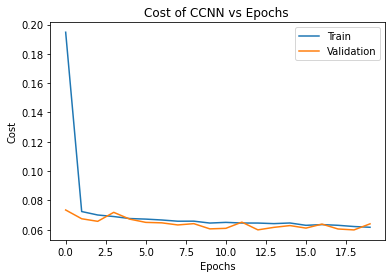

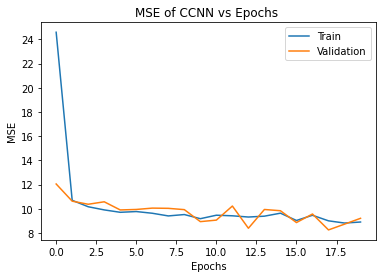

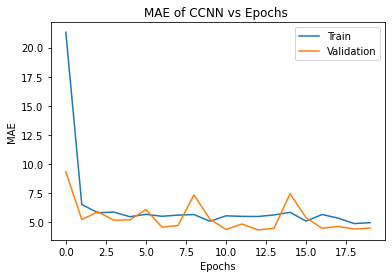

In [ ]:
plot_cost, plot_mse,plot_mae = 1, 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of CCNN vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mse:
    plt.plot(MSE_train)
    plt.plot(MSE_validation)
    plt.title("MSE of CCNN vs Epochs ")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mae:
    plt.plot(MAE_train)
    plt.plot(MAE_validation)
    plt.title("MAE of CCNN vs Epochs ")
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/CountNet.pth'
torch.save(Net.state_dict(), PATH)

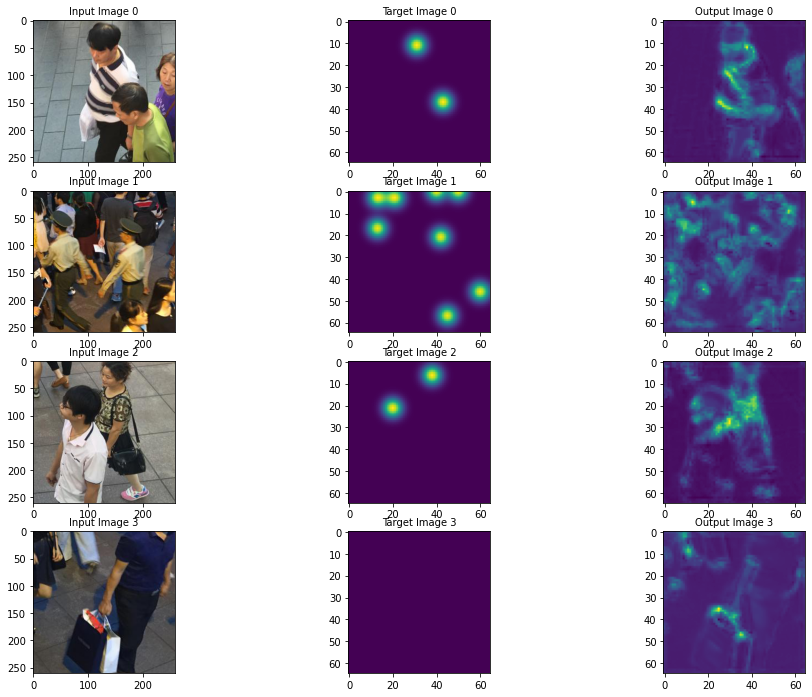

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

test_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

test_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/'

test_set =  ShanghaiTech_Dataset(test_names,test_data_folder,test_labels_folder )
test_generator = torch.utils.data.DataLoader(test_set, **params) 

PATH = '/content/drive/My Drive/CountNet.pth'
net = CountNet()
net.load_state_dict(torch.load(PATH))

dataiter = iter(test_generator)
images, labels = dataiter.next()

#print(images.shape,labels.shape)
outputs = net(images)
#print(outputs.shape)
test_set.test_network(images, outputs, labels)

In [ ]:
# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])


mse = nn.MSELoss()
mae = nn.L1Loss()

running_testloss, running_test_mse, running_test_mae = 0.0, 0.0 , 0.0
test_cnt = 0

# test
with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        test_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

        running_testloss += test_loss.item()
        running_loss += test_loss.item()
    
        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))

        a = torch.sqrt(mse(z,z_hat))
        running_test_mse += a
        running_mse += a

        b = mae(z,z_hat)
        running_test_mae += b
        running_mae += b

        if test_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_mse / 10 ))
          print("MAE of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_mae / 10 ))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

        test_cnt += 1
        

test_losses = running_testloss / test_cnt

MSE_test =  running_test_mse / test_cnt

MAE_test =running_test_mae / test_cnt



  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 1/565 [00:01<09:59,  1.06s/it]

  1%|          | 6/565 [00:01<07:00,  1.33it/s]

  1%|▏         | 8/565 [00:01<05:13,  1.78it/s]

  2%|▏         | 10/565 [00:01<03:56,  2.35it/s]

  2%|▏         | 12/565 [00:01<02:53,  3.18it/s]

Cost of test data after 10 iterations in epoch 20 : 0.121406
MSE of test data after 10 iterations in epoch 20 : 14.464447
MAE of test data after 10 iterations in epoch 20 : 8.554561




  2%|▏         | 14/565 [00:01<02:17,  4.01it/s]

  3%|▎         | 16/565 [00:02<01:52,  4.87it/s]

  3%|▎         | 18/565 [00:02<01:35,  5.76it/s]

  4%|▎         | 20/565 [00:02<01:22,  6.61it/s]

Cost of test data after 20 iterations in epoch 20 : 0.032487
MSE of test data after 20 iterations in epoch 20 : 4.659403
MAE of test data after 20 iterations in epoch 20 : 3.400000




  4%|▍         | 22/565 [00:02<01:14,  7.30it/s]

  4%|▍         | 24/565 [00:02<01:08,  7.87it/s]

  5%|▍         | 26/565 [00:03<01:03,  8.50it/s]

  5%|▍         | 28/565 [00:03<01:00,  8.88it/s]

  5%|▌         | 30/565 [00:03<00:57,  9.23it/s]

  6%|▌         | 32/565 [00:03<00:55,  9.57it/s]

Cost of test data after 30 iterations in epoch 20 : 0.088141
MSE of test data after 30 iterations in epoch 20 : 7.537896
MAE of test data after 30 iterations in epoch 20 : 5.025000




  6%|▌         | 34/565 [00:03<00:54,  9.71it/s]

  6%|▋         | 36/565 [00:04<00:53,  9.84it/s]

  7%|▋         | 38/565 [00:04<00:47, 11.13it/s]

  7%|▋         | 40/565 [00:04<00:49, 10.59it/s]

  7%|▋         | 42/565 [00:04<00:49, 10.58it/s]

Cost of test data after 40 iterations in epoch 20 : 0.082106
MSE of test data after 40 iterations in epoch 20 : 8.331710
MAE of test data after 40 iterations in epoch 20 : 5.300000




  8%|▊         | 44/565 [00:04<00:49, 10.53it/s]

  8%|▊         | 46/565 [00:05<00:50, 10.18it/s]

  8%|▊         | 48/565 [00:05<00:50, 10.18it/s]

  9%|▉         | 50/565 [00:05<00:49, 10.32it/s]

  9%|▉         | 52/565 [00:05<00:43, 11.71it/s]

Cost of test data after 50 iterations in epoch 20 : 0.070979
MSE of test data after 50 iterations in epoch 20 : 5.681695
MAE of test data after 50 iterations in epoch 20 : 3.875000




 10%|▉         | 54/565 [00:05<00:45, 11.22it/s]

 10%|▉         | 56/565 [00:05<00:46, 10.91it/s]

 10%|█         | 58/565 [00:06<00:47, 10.69it/s]

 11%|█         | 60/565 [00:06<00:48, 10.50it/s]



Cost of test data after 60 iterations in epoch 20 : 0.091143
MSE of test data after 60 iterations in epoch 20 : 8.256142
MAE of test data after 60 iterations in epoch 20 : 5.450000


 11%|█         | 62/565 [00:06<00:48, 10.40it/s]

 11%|█▏        | 64/565 [00:06<00:48, 10.34it/s]

 12%|█▏        | 66/565 [00:06<00:48, 10.25it/s]

 12%|█▏        | 68/565 [00:07<00:48, 10.21it/s]

 12%|█▏        | 70/565 [00:07<00:48, 10.13it/s]

 13%|█▎        | 72/565 [00:07<00:42, 11.60it/s]

Cost of test data after 70 iterations in epoch 20 : 0.026700
MSE of test data after 70 iterations in epoch 20 : 3.682353
MAE of test data after 70 iterations in epoch 20 : 2.525000




 13%|█▎        | 74/565 [00:07<00:44, 11.02it/s]

 13%|█▎        | 76/565 [00:07<00:44, 10.88it/s]

 14%|█▍        | 78/565 [00:08<00:45, 10.62it/s]

 14%|█▍        | 80/565 [00:08<00:47, 10.30it/s]

 15%|█▍        | 82/565 [00:08<00:46, 10.31it/s]

Cost of test data after 80 iterations in epoch 20 : 0.049291
MSE of test data after 80 iterations in epoch 20 : 5.073310
MAE of test data after 80 iterations in epoch 20 : 3.800000




 15%|█▍        | 84/565 [00:08<00:46, 10.34it/s]

 15%|█▌        | 86/565 [00:08<00:41, 11.43it/s]

 16%|█▌        | 88/565 [00:08<00:43, 11.05it/s]

 16%|█▌        | 90/565 [00:09<00:44, 10.77it/s]

Cost of test data after 90 iterations in epoch 20 : 0.038955
MSE of test data after 90 iterations in epoch 20 : 4.620498
MAE of test data after 90 iterations in epoch 20 : 3.375000




 16%|█▋        | 92/565 [00:09<00:45, 10.50it/s]

 17%|█▋        | 94/565 [00:09<00:46, 10.13it/s]

 17%|█▋        | 96/565 [00:09<00:45, 10.38it/s]

 17%|█▋        | 98/565 [00:09<00:39, 11.76it/s]

 18%|█▊        | 100/565 [00:10<00:40, 11.45it/s]

 18%|█▊        | 102/565 [00:10<00:41, 11.12it/s]

Cost of test data after 100 iterations in epoch 20 : 0.037491
MSE of test data after 100 iterations in epoch 20 : 4.536933
MAE of test data after 100 iterations in epoch 20 : 3.150000




 18%|█▊        | 104/565 [00:10<00:42, 10.81it/s]

 19%|█▉        | 106/565 [00:10<00:43, 10.59it/s]

 19%|█▉        | 108/565 [00:10<00:38, 11.86it/s]

 19%|█▉        | 110/565 [00:10<00:39, 11.43it/s]

Cost of test data after 110 iterations in epoch 20 : 0.080573
MSE of test data after 110 iterations in epoch 20 : 6.504599
MAE of test data after 110 iterations in epoch 20 : 4.400000




 20%|█▉        | 112/565 [00:11<00:41, 10.91it/s]

 20%|██        | 114/565 [00:11<00:42, 10.71it/s]

 21%|██        | 116/565 [00:11<00:42, 10.67it/s]

 21%|██        | 118/565 [00:11<00:42, 10.42it/s]

 21%|██        | 120/565 [00:11<00:42, 10.42it/s]



Cost of test data after 120 iterations in epoch 20 : 0.083873
MSE of test data after 120 iterations in epoch 20 : 7.595590
MAE of test data after 120 iterations in epoch 20 : 4.750000


 22%|██▏       | 122/565 [00:12<00:43, 10.27it/s]

 22%|██▏       | 124/565 [00:12<00:42, 10.28it/s]

 22%|██▏       | 126/565 [00:12<00:39, 11.21it/s]

 23%|██▎       | 128/565 [00:12<00:39, 10.96it/s]

 23%|██▎       | 130/565 [00:12<00:45,  9.56it/s]

 23%|██▎       | 132/565 [00:13<00:38, 11.17it/s]

Cost of test data after 130 iterations in epoch 20 : 0.023298
MSE of test data after 130 iterations in epoch 20 : 3.323329
MAE of test data after 130 iterations in epoch 20 : 2.575000




 24%|██▎       | 134/565 [00:13<00:40, 10.73it/s]

 24%|██▍       | 136/565 [00:13<00:41, 10.46it/s]

 24%|██▍       | 138/565 [00:13<00:41, 10.40it/s]

 25%|██▍       | 140/565 [00:13<00:42, 10.01it/s]

 25%|██▌       | 142/565 [00:14<00:41, 10.22it/s]

Cost of test data after 140 iterations in epoch 20 : 0.044481
MSE of test data after 140 iterations in epoch 20 : 5.133524
MAE of test data after 140 iterations in epoch 20 : 3.625000




 25%|██▌       | 144/565 [00:14<00:41, 10.23it/s]

 26%|██▌       | 146/565 [00:14<00:40, 10.30it/s]

 26%|██▌       | 148/565 [00:14<00:40, 10.23it/s]

 27%|██▋       | 150/565 [00:14<00:35, 11.55it/s]

Cost of test data after 150 iterations in epoch 20 : 0.112590
MSE of test data after 150 iterations in epoch 20 : 8.026526
MAE of test data after 150 iterations in epoch 20 : 5.475000




 27%|██▋       | 152/565 [00:14<00:38, 10.87it/s]

 27%|██▋       | 154/565 [00:15<00:38, 10.75it/s]

 28%|██▊       | 156/565 [00:15<00:38, 10.53it/s]

 28%|██▊       | 158/565 [00:15<00:39, 10.40it/s]

 28%|██▊       | 160/565 [00:15<00:38, 10.42it/s]

Cost of test data after 160 iterations in epoch 20 : 0.032413
MSE of test data after 160 iterations in epoch 20 : 4.160948
MAE of test data after 160 iterations in epoch 20 : 3.000000




 29%|██▊       | 162/565 [00:15<00:39, 10.23it/s]

 29%|██▉       | 164/565 [00:16<00:39, 10.21it/s]

 29%|██▉       | 166/565 [00:16<00:39, 10.16it/s]

 30%|██▉       | 168/565 [00:16<00:39, 10.16it/s]

 30%|███       | 170/565 [00:16<00:39, 10.12it/s]

 30%|███       | 172/565 [00:16<00:33, 11.58it/s]

Cost of test data after 170 iterations in epoch 20 : 0.021050
MSE of test data after 170 iterations in epoch 20 : 2.680634
MAE of test data after 170 iterations in epoch 20 : 2.200000




 31%|███       | 174/565 [00:17<00:34, 11.37it/s]

 31%|███       | 176/565 [00:17<00:35, 11.04it/s]

 32%|███▏      | 178/565 [00:17<00:36, 10.69it/s]

 32%|███▏      | 180/565 [00:17<00:37, 10.34it/s]

 32%|███▏      | 182/565 [00:17<00:36, 10.45it/s]

Cost of test data after 180 iterations in epoch 20 : 0.026483
MSE of test data after 180 iterations in epoch 20 : 3.101160
MAE of test data after 180 iterations in epoch 20 : 2.350000




 33%|███▎      | 184/565 [00:17<00:32, 11.55it/s]

 33%|███▎      | 186/565 [00:18<00:33, 11.15it/s]

 33%|███▎      | 188/565 [00:18<00:35, 10.58it/s]

 34%|███▎      | 190/565 [00:18<00:35, 10.46it/s]

 34%|███▍      | 192/565 [00:18<00:35, 10.40it/s]

Cost of test data after 190 iterations in epoch 20 : 0.023497
MSE of test data after 190 iterations in epoch 20 : 3.907881
MAE of test data after 190 iterations in epoch 20 : 2.800000




 34%|███▍      | 194/565 [00:18<00:36, 10.22it/s]

 35%|███▍      | 196/565 [00:19<00:35, 10.31it/s]

 35%|███▌      | 198/565 [00:19<00:35, 10.21it/s]

 35%|███▌      | 200/565 [00:19<00:35, 10.22it/s]



Cost of test data after 200 iterations in epoch 20 : 0.117952
MSE of test data after 200 iterations in epoch 20 : 11.364327
MAE of test data after 200 iterations in epoch 20 : 6.775000


 36%|███▌      | 202/565 [00:19<00:35, 10.22it/s]

 36%|███▌      | 204/565 [00:19<00:35, 10.13it/s]

 36%|███▋      | 206/565 [00:20<00:35, 10.11it/s]

 37%|███▋      | 208/565 [00:20<00:31, 11.35it/s]

 37%|███▋      | 210/565 [00:20<00:32, 11.01it/s]



Cost of test data after 210 iterations in epoch 20 : 0.061900
MSE of test data after 210 iterations in epoch 20 : 7.145384
MAE of test data after 210 iterations in epoch 20 : 4.900000


 38%|███▊      | 212/565 [00:20<00:32, 10.71it/s]

 38%|███▊      | 214/565 [00:20<00:32, 10.69it/s]

 38%|███▊      | 216/565 [00:21<00:32, 10.63it/s]

 39%|███▊      | 218/565 [00:21<00:33, 10.44it/s]

 39%|███▉      | 220/565 [00:21<00:33, 10.18it/s]

 39%|███▉      | 222/565 [00:21<00:33, 10.32it/s]

Cost of test data after 220 iterations in epoch 20 : 0.034411
MSE of test data after 220 iterations in epoch 20 : 4.451100
MAE of test data after 220 iterations in epoch 20 : 3.200000




 40%|███▉      | 224/565 [00:21<00:29, 11.65it/s]

 40%|████      | 226/565 [00:21<00:30, 11.08it/s]

 40%|████      | 228/565 [00:22<00:31, 10.60it/s]

 41%|████      | 230/565 [00:22<00:31, 10.60it/s]

 41%|████      | 232/565 [00:22<00:31, 10.53it/s]

Cost of test data after 230 iterations in epoch 20 : 0.189902
MSE of test data after 230 iterations in epoch 20 : 12.317351
MAE of test data after 230 iterations in epoch 20 : 7.450000




 41%|████▏     | 234/565 [00:22<00:31, 10.39it/s]

 42%|████▏     | 236/565 [00:22<00:31, 10.29it/s]

 42%|████▏     | 238/565 [00:23<00:32, 10.14it/s]

 42%|████▏     | 240/565 [00:23<00:32, 10.12it/s]

Cost of test data after 240 iterations in epoch 20 : 0.041625
MSE of test data after 240 iterations in epoch 20 : 5.907051
MAE of test data after 240 iterations in epoch 20 : 3.950000




 43%|████▎     | 242/565 [00:23<00:32, 10.05it/s]

 43%|████▎     | 244/565 [00:23<00:31, 10.12it/s]

 44%|████▎     | 246/565 [00:23<00:27, 11.45it/s]

 44%|████▍     | 248/565 [00:24<00:28, 10.97it/s]

 44%|████▍     | 250/565 [00:24<00:29, 10.55it/s]

 45%|████▍     | 252/565 [00:24<00:29, 10.68it/s]

Cost of test data after 250 iterations in epoch 20 : 0.035073
MSE of test data after 250 iterations in epoch 20 : 3.568559
MAE of test data after 250 iterations in epoch 20 : 2.800000




 45%|████▍     | 254/565 [00:24<00:29, 10.52it/s]

 45%|████▌     | 256/565 [00:24<00:25, 12.08it/s]

 46%|████▌     | 258/565 [00:24<00:26, 11.46it/s]

 46%|████▌     | 260/565 [00:25<00:27, 11.10it/s]

Cost of test data after 260 iterations in epoch 20 : 0.079484
MSE of test data after 260 iterations in epoch 20 : 7.528537
MAE of test data after 260 iterations in epoch 20 : 4.800000




 46%|████▋     | 262/565 [00:25<00:28, 10.73it/s]

 47%|████▋     | 264/565 [00:25<00:24, 12.35it/s]

 47%|████▋     | 266/565 [00:25<00:26, 11.11it/s]

 47%|████▋     | 268/565 [00:25<00:26, 11.31it/s]

 48%|████▊     | 270/565 [00:26<00:26, 10.98it/s]



Cost of test data after 270 iterations in epoch 20 : 0.051027
MSE of test data after 270 iterations in epoch 20 : 5.505529
MAE of test data after 270 iterations in epoch 20 : 3.775000


 48%|████▊     | 272/565 [00:26<00:27, 10.70it/s]

 48%|████▊     | 274/565 [00:26<00:24, 11.72it/s]

 49%|████▉     | 276/565 [00:26<00:25, 11.20it/s]

 49%|████▉     | 278/565 [00:26<00:26, 10.67it/s]

 50%|████▉     | 280/565 [00:26<00:27, 10.39it/s]



Cost of test data after 280 iterations in epoch 20 : 0.062502
MSE of test data after 280 iterations in epoch 20 : 6.071812
MAE of test data after 280 iterations in epoch 20 : 4.275000


 50%|████▉     | 282/565 [00:27<00:27, 10.30it/s]

 50%|█████     | 284/565 [00:27<00:27, 10.23it/s]

 51%|█████     | 286/565 [00:27<00:23, 11.71it/s]

 51%|█████     | 288/565 [00:27<00:25, 10.94it/s]

 51%|█████▏    | 290/565 [00:27<00:25, 10.97it/s]

Cost of test data after 290 iterations in epoch 20 : 0.085224
MSE of test data after 290 iterations in epoch 20 : 5.973916
MAE of test data after 290 iterations in epoch 20 : 4.375000




 52%|█████▏    | 292/565 [00:28<00:27,  9.77it/s]

 52%|█████▏    | 294/565 [00:28<00:27,  9.78it/s]

 52%|█████▏    | 296/565 [00:28<00:24, 11.20it/s]

 53%|█████▎    | 298/565 [00:28<00:24, 10.90it/s]

 53%|█████▎    | 300/565 [00:28<00:25, 10.58it/s]

Cost of test data after 300 iterations in epoch 20 : 0.100235
MSE of test data after 300 iterations in epoch 20 : 8.250244
MAE of test data after 300 iterations in epoch 20 : 5.475000




 53%|█████▎    | 302/565 [00:29<00:25, 10.39it/s]

 54%|█████▍    | 304/565 [00:29<00:24, 10.55it/s]

 54%|█████▍    | 306/565 [00:29<00:24, 10.43it/s]

 55%|█████▍    | 308/565 [00:29<00:24, 10.29it/s]

 55%|█████▍    | 310/565 [00:29<00:23, 10.94it/s]

 55%|█████▌    | 312/565 [00:29<00:23, 10.80it/s]

Cost of test data after 310 iterations in epoch 20 : 0.089048
MSE of test data after 310 iterations in epoch 20 : 5.662482
MAE of test data after 310 iterations in epoch 20 : 4.350000




 56%|█████▌    | 314/565 [00:30<00:23, 10.59it/s]

 56%|█████▌    | 316/565 [00:30<00:23, 10.44it/s]

 56%|█████▋    | 318/565 [00:30<00:23, 10.32it/s]

 57%|█████▋    | 320/565 [00:30<00:23, 10.23it/s]

 57%|█████▋    | 322/565 [00:30<00:23, 10.20it/s]

Cost of test data after 320 iterations in epoch 20 : 0.021413
MSE of test data after 320 iterations in epoch 20 : 2.802719
MAE of test data after 320 iterations in epoch 20 : 2.200000




 57%|█████▋    | 324/565 [00:31<00:23, 10.16it/s]

 58%|█████▊    | 326/565 [00:31<00:23, 10.16it/s]

 58%|█████▊    | 328/565 [00:31<00:20, 11.57it/s]

 58%|█████▊    | 330/565 [00:31<00:21, 11.08it/s]

 59%|█████▉    | 332/565 [00:31<00:21, 10.95it/s]

Cost of test data after 330 iterations in epoch 20 : 0.113908
MSE of test data after 330 iterations in epoch 20 : 10.078254
MAE of test data after 330 iterations in epoch 20 : 6.050000




 59%|█████▉    | 334/565 [00:32<00:20, 11.16it/s]

 59%|█████▉    | 336/565 [00:32<00:21, 10.78it/s]

 60%|█████▉    | 338/565 [00:32<00:19, 11.64it/s]

 60%|██████    | 340/565 [00:32<00:20, 11.08it/s]

 61%|██████    | 342/565 [00:32<00:20, 10.88it/s]

Cost of test data after 340 iterations in epoch 20 : 0.027779
MSE of test data after 340 iterations in epoch 20 : 3.412537
MAE of test data after 340 iterations in epoch 20 : 2.550000




 61%|██████    | 344/565 [00:32<00:20, 10.64it/s]

 61%|██████    | 346/565 [00:33<00:20, 10.46it/s]

 62%|██████▏   | 348/565 [00:33<00:20, 10.35it/s]

 62%|██████▏   | 350/565 [00:33<00:20, 10.67it/s]

 62%|██████▏   | 352/565 [00:33<00:18, 11.47it/s]

Cost of test data after 350 iterations in epoch 20 : 0.070028
MSE of test data after 350 iterations in epoch 20 : 7.929229
MAE of test data after 350 iterations in epoch 20 : 5.575000




 63%|██████▎   | 354/565 [00:33<00:18, 11.11it/s]

 63%|██████▎   | 356/565 [00:34<00:19, 10.53it/s]

 63%|██████▎   | 358/565 [00:34<00:20, 10.31it/s]

 64%|██████▎   | 360/565 [00:34<00:19, 10.51it/s]

Cost of test data after 360 iterations in epoch 20 : 0.059928
MSE of test data after 360 iterations in epoch 20 : 7.253223
MAE of test data after 360 iterations in epoch 20 : 4.825000




 64%|██████▍   | 362/565 [00:34<00:19, 10.26it/s]

 64%|██████▍   | 364/565 [00:34<00:19, 10.25it/s]

 65%|██████▍   | 366/565 [00:35<00:19, 10.21it/s]

 65%|██████▌   | 368/565 [00:35<00:19, 10.18it/s]

 65%|██████▌   | 370/565 [00:35<00:19, 10.07it/s]

 66%|██████▌   | 372/565 [00:35<00:18, 10.18it/s]

Cost of test data after 370 iterations in epoch 20 : 0.065386
MSE of test data after 370 iterations in epoch 20 : 7.527941
MAE of test data after 370 iterations in epoch 20 : 4.675000




 66%|██████▌   | 374/565 [00:35<00:19, 10.02it/s]

 67%|██████▋   | 376/565 [00:35<00:16, 11.52it/s]

 67%|██████▋   | 378/565 [00:36<00:16, 11.08it/s]

 67%|██████▋   | 380/565 [00:36<00:17, 10.78it/s]

 68%|██████▊   | 382/565 [00:36<00:17, 10.62it/s]

Cost of test data after 380 iterations in epoch 20 : 0.040911
MSE of test data after 380 iterations in epoch 20 : 5.172807
MAE of test data after 380 iterations in epoch 20 : 3.500000




 68%|██████▊   | 384/565 [00:36<00:17, 10.52it/s]

 68%|██████▊   | 386/565 [00:36<00:15, 11.88it/s]

 69%|██████▊   | 388/565 [00:37<00:17, 10.39it/s]

 69%|██████▉   | 390/565 [00:37<00:17, 10.26it/s]

 69%|██████▉   | 392/565 [00:37<00:15, 11.20it/s]

Cost of test data after 390 iterations in epoch 20 : 0.095621
MSE of test data after 390 iterations in epoch 20 : 6.146637
MAE of test data after 390 iterations in epoch 20 : 4.600000




 70%|██████▉   | 394/565 [00:37<00:17,  9.90it/s]

 70%|███████   | 396/565 [00:37<00:15, 11.19it/s]

 70%|███████   | 398/565 [00:38<00:15, 10.98it/s]

 71%|███████   | 400/565 [00:38<00:15, 10.54it/s]

Cost of test data after 400 iterations in epoch 20 : 0.122386
MSE of test data after 400 iterations in epoch 20 : 8.974292
MAE of test data after 400 iterations in epoch 20 : 5.775000




 71%|███████   | 402/565 [00:38<00:15, 10.34it/s]

 72%|███████▏  | 404/565 [00:38<00:15, 10.51it/s]

 72%|███████▏  | 406/565 [00:38<00:15, 10.21it/s]

 72%|███████▏  | 408/565 [00:39<00:15, 10.22it/s]

 73%|███████▎  | 410/565 [00:39<00:15,  9.97it/s]

 73%|███████▎  | 412/565 [00:39<00:15, 10.06it/s]

Cost of test data after 410 iterations in epoch 20 : 0.054463
MSE of test data after 410 iterations in epoch 20 : 5.583397
MAE of test data after 410 iterations in epoch 20 : 4.000000




 73%|███████▎  | 414/565 [00:39<00:14, 10.11it/s]

 74%|███████▎  | 416/565 [00:39<00:14, 10.17it/s]

 74%|███████▍  | 418/565 [00:40<00:14, 10.03it/s]

 74%|███████▍  | 420/565 [00:40<00:14, 10.08it/s]

 75%|███████▍  | 422/565 [00:40<00:14, 10.19it/s]

Cost of test data after 420 iterations in epoch 20 : 0.025383
MSE of test data after 420 iterations in epoch 20 : 3.372058
MAE of test data after 420 iterations in epoch 20 : 2.500000




 75%|███████▌  | 424/565 [00:40<00:12, 11.61it/s]

 75%|███████▌  | 426/565 [00:40<00:12, 10.94it/s]

 76%|███████▌  | 428/565 [00:40<00:12, 10.66it/s]

 76%|███████▌  | 430/565 [00:41<00:12, 10.60it/s]

 76%|███████▋  | 432/565 [00:41<00:12, 10.52it/s]

Cost of test data after 430 iterations in epoch 20 : 0.029932
MSE of test data after 430 iterations in epoch 20 : 4.172355
MAE of test data after 430 iterations in epoch 20 : 3.125000




 77%|███████▋  | 434/565 [00:41<00:12, 10.22it/s]

 77%|███████▋  | 436/565 [00:41<00:12, 10.21it/s]

 78%|███████▊  | 438/565 [00:41<00:12, 10.19it/s]

 78%|███████▊  | 440/565 [00:42<00:12, 10.11it/s]

 78%|███████▊  | 442/565 [00:42<00:12, 10.12it/s]

Cost of test data after 440 iterations in epoch 20 : 0.037154
MSE of test data after 440 iterations in epoch 20 : 4.682325
MAE of test data after 440 iterations in epoch 20 : 3.375000




 79%|███████▊  | 444/565 [00:42<00:10, 11.62it/s]

 79%|███████▉  | 446/565 [00:42<00:10, 11.19it/s]

 79%|███████▉  | 448/565 [00:42<00:10, 10.77it/s]

 80%|███████▉  | 450/565 [00:43<00:10, 10.49it/s]

 80%|████████  | 452/565 [00:43<00:10, 10.52it/s]

Cost of test data after 450 iterations in epoch 20 : 0.041707
MSE of test data after 450 iterations in epoch 20 : 4.575799
MAE of test data after 450 iterations in epoch 20 : 3.075000




 80%|████████  | 454/565 [00:43<00:10, 10.45it/s]

 81%|████████  | 456/565 [00:43<00:09, 12.04it/s]

 81%|████████  | 458/565 [00:43<00:09, 11.41it/s]

 81%|████████▏ | 460/565 [00:43<00:09, 10.94it/s]

 82%|████████▏ | 462/565 [00:44<00:09, 10.75it/s]

Cost of test data after 460 iterations in epoch 20 : 0.135403
MSE of test data after 460 iterations in epoch 20 : 10.918311
MAE of test data after 460 iterations in epoch 20 : 6.625000




 82%|████████▏ | 464/565 [00:44<00:09, 10.48it/s]

 82%|████████▏ | 466/565 [00:44<00:09, 10.32it/s]

 83%|████████▎ | 468/565 [00:44<00:09, 10.23it/s]

 83%|████████▎ | 470/565 [00:44<00:08, 11.41it/s]

 84%|████████▎ | 472/565 [00:45<00:08, 11.07it/s]

Cost of test data after 470 iterations in epoch 20 : 0.090583
MSE of test data after 470 iterations in epoch 20 : 7.422399
MAE of test data after 470 iterations in epoch 20 : 4.625000




 84%|████████▍ | 474/565 [00:45<00:08, 10.81it/s]

 84%|████████▍ | 476/565 [00:45<00:08, 10.71it/s]

 85%|████████▍ | 478/565 [00:45<00:08, 10.40it/s]

 85%|████████▍ | 480/565 [00:45<00:08, 10.32it/s]

 85%|████████▌ | 482/565 [00:46<00:08, 10.29it/s]

Cost of test data after 480 iterations in epoch 20 : 0.036869
MSE of test data after 480 iterations in epoch 20 : 3.224130
MAE of test data after 480 iterations in epoch 20 : 2.625000




 86%|████████▌ | 484/565 [00:46<00:07, 10.17it/s]

 86%|████████▌ | 486/565 [00:46<00:07, 10.17it/s]

 86%|████████▋ | 488/565 [00:46<00:07, 10.07it/s]

 87%|████████▋ | 490/565 [00:46<00:07,  9.96it/s]

 87%|████████▋ | 492/565 [00:47<00:07, 10.05it/s]

Cost of test data after 490 iterations in epoch 20 : 0.023650
MSE of test data after 490 iterations in epoch 20 : 2.935190
MAE of test data after 490 iterations in epoch 20 : 2.400000




 87%|████████▋ | 494/565 [00:47<00:06, 10.22it/s]

 88%|████████▊ | 496/565 [00:47<00:06, 11.43it/s]

 88%|████████▊ | 498/565 [00:47<00:06, 11.08it/s]

 88%|████████▊ | 500/565 [00:47<00:06, 10.76it/s]

 89%|████████▉ | 502/565 [00:47<00:05, 10.56it/s]

Cost of test data after 500 iterations in epoch 20 : 0.092888
MSE of test data after 500 iterations in epoch 20 : 6.451445
MAE of test data after 500 iterations in epoch 20 : 4.325000




 89%|████████▉ | 504/565 [00:48<00:05, 10.57it/s]

 90%|████████▉ | 506/565 [00:48<00:05, 10.40it/s]

 90%|████████▉ | 508/565 [00:48<00:05, 10.24it/s]

 90%|█████████ | 510/565 [00:48<00:04, 11.68it/s]

 91%|█████████ | 512/565 [00:48<00:04, 11.18it/s]

Cost of test data after 510 iterations in epoch 20 : 0.021739
MSE of test data after 510 iterations in epoch 20 : 3.188319
MAE of test data after 510 iterations in epoch 20 : 2.675000




 91%|█████████ | 514/565 [00:49<00:04, 10.68it/s]

 91%|█████████▏| 516/565 [00:49<00:04, 10.89it/s]

 92%|█████████▏| 518/565 [00:49<00:04, 10.61it/s]

 92%|█████████▏| 520/565 [00:49<00:03, 11.56it/s]

Cost of test data after 520 iterations in epoch 20 : 0.025467
MSE of test data after 520 iterations in epoch 20 : 3.670823
MAE of test data after 520 iterations in epoch 20 : 2.950000




 92%|█████████▏| 522/565 [00:49<00:03, 11.02it/s]

 93%|█████████▎| 524/565 [00:49<00:03, 10.81it/s]

 93%|█████████▎| 526/565 [00:50<00:03, 10.55it/s]

 93%|█████████▎| 528/565 [00:50<00:03, 10.79it/s]

 94%|█████████▍| 530/565 [00:50<00:03, 10.55it/s]



Cost of test data after 530 iterations in epoch 20 : 0.097470
MSE of test data after 530 iterations in epoch 20 : 7.687708
MAE of test data after 530 iterations in epoch 20 : 4.850000


 94%|█████████▍| 532/565 [00:50<00:03, 10.39it/s]

 95%|█████████▍| 534/565 [00:50<00:02, 11.35it/s]

 95%|█████████▍| 536/565 [00:51<00:02, 10.86it/s]

 95%|█████████▌| 538/565 [00:51<00:02, 10.60it/s]

 96%|█████████▌| 540/565 [00:51<00:02, 10.26it/s]

 96%|█████████▌| 542/565 [00:51<00:02, 10.25it/s]

Cost of test data after 540 iterations in epoch 20 : 0.086138
MSE of test data after 540 iterations in epoch 20 : 9.063563
MAE of test data after 540 iterations in epoch 20 : 6.175000




 96%|█████████▋| 544/565 [00:51<00:02, 10.20it/s]

 97%|█████████▋| 546/565 [00:52<00:01, 10.17it/s]

 97%|█████████▋| 548/565 [00:52<00:01,  9.95it/s]

 97%|█████████▋| 550/565 [00:52<00:01, 10.12it/s]

 98%|█████████▊| 552/565 [00:52<00:01, 10.32it/s]

Cost of test data after 550 iterations in epoch 20 : 0.049098
MSE of test data after 550 iterations in epoch 20 : 6.990194
MAE of test data after 550 iterations in epoch 20 : 4.750000




 98%|█████████▊| 554/565 [00:52<00:01, 10.05it/s]

 98%|█████████▊| 556/565 [00:53<00:00, 10.22it/s]

 99%|█████████▉| 558/565 [00:53<00:00, 11.62it/s]

 99%|█████████▉| 560/565 [00:53<00:00, 11.17it/s]

 99%|█████████▉| 562/565 [00:53<00:00, 10.84it/s]

Cost of test data after 560 iterations in epoch 20 : 0.030940
MSE of test data after 560 iterations in epoch 20 : 4.165321
MAE of test data after 560 iterations in epoch 20 : 2.925000




100%|██████████| 565/565 [00:54<00:00, 10.42it/s]


In [ ]:
print("Cost of Test data after training : ", test_losses)
print("MSE of Test data after training : ",MSE_test)
print("MAE of Test data after training : ",MAE_test)

Cost of Test data after training :  0.06187396160589244
MSE of Test data after training :  tensor(5.9550, device='cuda:0', dtype=torch.float64)
MAE of Test data after training :  tensor(4.0771, device='cuda:0', dtype=torch.float64)


## Data Augmentation

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_data"

In [ ]:
mkdir "/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_labels"

In [ ]:
train_aug_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_data/'
train_aug_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_labels/'

transform = transforms.ToTensor()

kwargs_train = {'data_root' : "/content/ShanghaiTech/part_B/train_data/images",
                'labels_root' : "/content/ShanghaiTech/part_B/train_data/ground-truth",
                'data_transform' : transform,
                'data_folder' : train_aug_data_folder,
                'labels_folder' :  train_aug_labels_folder,
                'data_aug' : True}

# Training Data Generators
training_set =  ShanghaiTech_Dataset(train_images_names,save = True, **kwargs_train)

### Train

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

train_aug_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_data/'
train_aug_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_aug_labels/'

val_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'
val_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/'

train_names = [f  for f in os.listdir(train_aug_data_folder) if os.path.isfile(os.path.join(train_aug_data_folder, f))]
val_names = [f  for f in os.listdir(val_data_folder) if os.path.isfile(os.path.join(val_data_folder, f))]

# Training and validation Data Generators
training_set =  ShanghaiTech_Dataset(train_names,train_aug_data_folder,train_aug_labels_folder )
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  ShanghaiTech_Dataset(val_names,val_data_folder, val_labels_folder)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = CountNet()
Net.to(device)

# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])

mse = nn.MSELoss()
mae = nn.L1Loss()
#optimizer = optim.SGD(Net.parameters(), lr = 0.00005, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(Net.parameters(), lr = 0.00005)

train_losses = []
validation_losses = []

MSE_train = []
MSE_validation = []

MAE_train = []
MAE_validation = []

# dataiter = iter(training_generator)
# batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0 , 0.0
    running_train_mse, running_val_mse, running_mse = 0.0, 0.0 , 0.0
    running_train_mae, running_val_mae, running_mae = 0.0, 0.0 , 0.0      
    train_cnt, val_cnt = 0, 0 
    
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        #print(batch_data[0,0,10,11])
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        #print(batch_labels[0,:,:])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        #print(batch_outputs[0,:,:,:])
        loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))
        
        a = torch.sqrt(mse(z,z_hat))
        running_train_mse += a
        running_mse += a
        
        b = mae(z,z_hat)
        running_train_mae += b
        running_mae += b
        
        if train_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mse / 10))
          print("MAE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mae / 10))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()
        
            z = torch.round(torch.sum(batch_labels, dim = [1,2]))
            z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))

            a = torch.sqrt(mse(z,z_hat))
            running_val_mse += a
            running_mse += a

            b = mae(z,z_hat)
            running_val_mae += b
            running_mae += b

            if val_cnt % 20 == 19:    # print every 10 mini-batches
              print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 20))
              print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 20))
              print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 20))
              running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

    MSE_train.append(running_train_mse / train_cnt)
    MSE_validation.append(running_val_mse / val_cnt)

    MAE_train.append(running_train_mae / train_cnt)
    MAE_validation.append(running_val_mae / val_cnt)



  0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:05<09:34,  5.17s/it]


  2%|▏         | 2/112 [00:06<07:33,  4.12s/it]


  3%|▎         | 3/112 [00:08<06:09,  3.39s/it]


  4%|▎         | 4/112 [00:10<05:10,  2.87s/it]


  4%|▍         | 5/112 [00:11<04:28,  2.51s/it]


  5%|▌         | 6/112 [00:13<03:59,  2.25s/it]


  6%|▋         | 7/112 [00:15<03:38,  2.08s/it]


  7%|▋         | 8/112 [00:16<03:23,  1.96s/it]


  8%|▊         | 9/112 [00:18<03:12,  1.87s/it]


  9%|▉         | 10/112 [00:20<03:04,  1.81s/it]

Cost of Train data after 10 iterations in epoch 1 : 0.635802
MSE of Train data after 10 iterations in epoch 1 : 61.592346
MAE of Train data after 10 iterations in epoch 1 : 59.862500





 10%|▉         | 11/112 [00:21<02:58,  1.77s/it]


 11%|█         | 12/112 [00:23<02:53,  1.74s/it]


 12%|█▏        | 13/112 [00:25<02:50,  1.72s/it]


 12%|█▎        | 14/112 [00:26<02:47,  1.71s/it]


 13%|█▎        | 15/112 [00:28<02:44,  1.70s/it]


 14%|█▍        | 16/112 [00:30<02:42,  1.69s/it]


 15%|█▌        | 17/112 [00:31<02:39,  1.68s/it]


 16%|█▌        | 18/112 [00:33<02:37,  1.67s/it]


 17%|█▋        | 19/112 [00:35<02:35,  1.67s/it]


 18%|█▊        | 20/112 [00:36<02:33,  1.67s/it]

Cost of Train data after 20 iterations in epoch 1 : 0.175645
MSE of Train data after 20 iterations in epoch 1 : 25.794799
MAE of Train data after 20 iterations in epoch 1 : 23.589063





 19%|█▉        | 21/112 [00:38<02:31,  1.66s/it]


 20%|█▉        | 22/112 [00:40<02:29,  1.66s/it]


 21%|██        | 23/112 [00:41<02:27,  1.66s/it]


 21%|██▏       | 24/112 [00:43<02:26,  1.66s/it]


 22%|██▏       | 25/112 [00:45<02:24,  1.66s/it]


 23%|██▎       | 26/112 [00:46<02:22,  1.66s/it]


 24%|██▍       | 27/112 [00:48<02:21,  1.66s/it]


 25%|██▌       | 28/112 [00:50<02:19,  1.66s/it]


 26%|██▌       | 29/112 [00:51<02:17,  1.66s/it]


 27%|██▋       | 30/112 [00:53<02:16,  1.66s/it]

Cost of Train data after 30 iterations in epoch 1 : 0.106993
MSE of Train data after 30 iterations in epoch 1 : 18.586462
MAE of Train data after 30 iterations in epoch 1 : 14.732813





 28%|██▊       | 31/112 [00:55<02:14,  1.66s/it]


 29%|██▊       | 32/112 [00:56<02:12,  1.66s/it]


 29%|██▉       | 33/112 [00:58<02:11,  1.66s/it]


 30%|███       | 34/112 [01:00<02:09,  1.66s/it]


 31%|███▏      | 35/112 [01:01<02:07,  1.66s/it]


 32%|███▏      | 36/112 [01:03<02:06,  1.67s/it]


 33%|███▎      | 37/112 [01:05<02:04,  1.67s/it]


 34%|███▍      | 38/112 [01:06<02:03,  1.66s/it]


 35%|███▍      | 39/112 [01:08<02:01,  1.66s/it]


 36%|███▌      | 40/112 [01:10<01:59,  1.66s/it]

Cost of Train data after 40 iterations in epoch 1 : 0.106034
MSE of Train data after 40 iterations in epoch 1 : 16.347878
MAE of Train data after 40 iterations in epoch 1 : 11.976562





 37%|███▋      | 41/112 [01:11<01:57,  1.66s/it]


 38%|███▊      | 42/112 [01:13<01:56,  1.66s/it]


 38%|███▊      | 43/112 [01:15<01:54,  1.66s/it]


 39%|███▉      | 44/112 [01:16<01:52,  1.66s/it]


 40%|████      | 45/112 [01:18<01:50,  1.66s/it]


 41%|████      | 46/112 [01:20<01:49,  1.66s/it]


 42%|████▏     | 47/112 [01:21<01:47,  1.66s/it]


 43%|████▎     | 48/112 [01:23<01:46,  1.66s/it]


 44%|████▍     | 49/112 [01:25<01:44,  1.66s/it]


 45%|████▍     | 50/112 [01:26<01:43,  1.67s/it]

Cost of Train data after 50 iterations in epoch 1 : 0.072645
MSE of Train data after 50 iterations in epoch 1 : 11.831286
MAE of Train data after 50 iterations in epoch 1 : 7.976562





 46%|████▌     | 51/112 [01:28<01:41,  1.66s/it]


 46%|████▋     | 52/112 [01:30<01:39,  1.66s/it]


 47%|████▋     | 53/112 [01:31<01:38,  1.66s/it]


 48%|████▊     | 54/112 [01:33<01:36,  1.66s/it]


 49%|████▉     | 55/112 [01:35<01:35,  1.68s/it]


 50%|█████     | 56/112 [01:36<01:33,  1.67s/it]


 51%|█████     | 57/112 [01:38<01:32,  1.68s/it]


 52%|█████▏    | 58/112 [01:40<01:30,  1.68s/it]


 53%|█████▎    | 59/112 [01:41<01:28,  1.67s/it]


 54%|█████▎    | 60/112 [01:43<01:27,  1.68s/it]

Cost of Train data after 60 iterations in epoch 1 : 0.095932
MSE of Train data after 60 iterations in epoch 1 : 14.069881
MAE of Train data after 60 iterations in epoch 1 : 8.348438





 54%|█████▍    | 61/112 [01:45<01:25,  1.67s/it]


 55%|█████▌    | 62/112 [01:46<01:24,  1.68s/it]


 56%|█████▋    | 63/112 [01:48<01:22,  1.68s/it]


 57%|█████▋    | 64/112 [01:50<01:20,  1.67s/it]


 58%|█████▊    | 65/112 [01:51<01:18,  1.67s/it]


 59%|█████▉    | 66/112 [01:53<01:16,  1.67s/it]


 60%|█████▉    | 67/112 [01:55<01:14,  1.67s/it]


 61%|██████    | 68/112 [01:56<01:13,  1.66s/it]


 62%|██████▏   | 69/112 [01:58<01:11,  1.66s/it]


 62%|██████▎   | 70/112 [02:00<01:09,  1.67s/it]

Cost of Train data after 70 iterations in epoch 1 : 0.105481
MSE of Train data after 70 iterations in epoch 1 : 13.638185
MAE of Train data after 70 iterations in epoch 1 : 6.834375





 63%|██████▎   | 71/112 [02:01<01:08,  1.67s/it]


 64%|██████▍   | 72/112 [02:03<01:06,  1.66s/it]


 65%|██████▌   | 73/112 [02:05<01:04,  1.66s/it]


 66%|██████▌   | 74/112 [02:06<01:03,  1.67s/it]


 67%|██████▋   | 75/112 [02:08<01:01,  1.66s/it]


 68%|██████▊   | 76/112 [02:10<00:59,  1.66s/it]


 69%|██████▉   | 77/112 [02:11<00:58,  1.66s/it]


 70%|██████▉   | 78/112 [02:13<00:56,  1.66s/it]


 71%|███████   | 79/112 [02:15<00:54,  1.66s/it]


 71%|███████▏  | 80/112 [02:16<00:53,  1.66s/it]

Cost of Train data after 80 iterations in epoch 1 : 0.079164
MSE of Train data after 80 iterations in epoch 1 : 11.670832
MAE of Train data after 80 iterations in epoch 1 : 7.096875





 72%|███████▏  | 81/112 [02:18<00:51,  1.66s/it]


 73%|███████▎  | 82/112 [02:20<00:49,  1.66s/it]


 74%|███████▍  | 83/112 [02:21<00:48,  1.66s/it]


 75%|███████▌  | 84/112 [02:23<00:46,  1.66s/it]


 76%|███████▌  | 85/112 [02:25<00:44,  1.67s/it]


 77%|███████▋  | 86/112 [02:26<00:43,  1.66s/it]


 78%|███████▊  | 87/112 [02:28<00:41,  1.66s/it]


 79%|███████▊  | 88/112 [02:30<00:40,  1.67s/it]


 79%|███████▉  | 89/112 [02:31<00:38,  1.66s/it]


 80%|████████  | 90/112 [02:33<00:36,  1.66s/it]

Cost of Train data after 90 iterations in epoch 1 : 0.091507
MSE of Train data after 90 iterations in epoch 1 : 11.815047
MAE of Train data after 90 iterations in epoch 1 : 6.510938





 81%|████████▏ | 91/112 [02:35<00:34,  1.66s/it]


 82%|████████▏ | 92/112 [02:36<00:33,  1.66s/it]


 83%|████████▎ | 93/112 [02:38<00:31,  1.66s/it]


 84%|████████▍ | 94/112 [02:40<00:29,  1.66s/it]


 85%|████████▍ | 95/112 [02:41<00:28,  1.66s/it]


 86%|████████▌ | 96/112 [02:43<00:26,  1.66s/it]


 87%|████████▋ | 97/112 [02:45<00:24,  1.67s/it]


 88%|████████▊ | 98/112 [02:46<00:23,  1.66s/it]


 88%|████████▊ | 99/112 [02:48<00:21,  1.67s/it]


 89%|████████▉ | 100/112 [02:50<00:19,  1.66s/it]

Cost of Train data after 100 iterations in epoch 1 : 0.077662
MSE of Train data after 100 iterations in epoch 1 : 11.088033
MAE of Train data after 100 iterations in epoch 1 : 5.903125





 90%|█████████ | 101/112 [02:51<00:18,  1.66s/it]


 91%|█████████ | 102/112 [02:53<00:16,  1.66s/it]


 92%|█████████▏| 103/112 [02:54<00:14,  1.66s/it]


 93%|█████████▎| 104/112 [02:56<00:13,  1.66s/it]


 94%|█████████▍| 105/112 [02:58<00:11,  1.66s/it]


 95%|█████████▍| 106/112 [02:59<00:09,  1.66s/it]


 96%|█████████▌| 107/112 [03:01<00:08,  1.66s/it]


 96%|█████████▋| 108/112 [03:03<00:06,  1.66s/it]


 97%|█████████▋| 109/112 [03:04<00:04,  1.66s/it]


 98%|█████████▊| 110/112 [03:06<00:03,  1.67s/it]

Cost of Train data after 110 iterations in epoch 1 : 0.088302
MSE of Train data after 110 iterations in epoch 1 : 11.718658
MAE of Train data after 110 iterations in epoch 1 : 6.685938





 99%|█████████▉| 111/112 [03:08<00:01,  1.66s/it]


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:01<00:14,  1.85s/it]


 22%|██▏       | 2/9 [00:02<00:10,  1.46s/it]


 33%|███▎      | 3/9 [00:02<00:07,  1.19s/it]


 44%|████▍     | 4/9 [00:03<00:05,  1.00s/it]


 56%|█████▌    | 5/9 [00:04<00:03,  1.09it/s]


 67%|██████▋   | 6/9 [00:04<00:02,  1.25it/s]


 78%|███████▊  | 7/9 [00:05<00:01,  1.32it/s]


 89%|████████▉ | 8/9 [00:05<00:00,  1.43it/s]


100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


 10%|█         | 1/10 [03:29<31:22, 209.22s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:44,  3.64s/it]


  2%|▏         | 2/112 [00:05<05:35,  3.05s/it]


  3%|▎         | 3/112 [00:07<04:48,  2.64s/it]


  4%|▎         | 4/112 [00:08<04:13,  2.35s/it]


  4%|▍         | 5/112 [00:10<03:50,  2.16s/it]


  5%|▌         | 6/112 [00:12<03:32,  2.01s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 2 : 0.073453
MSE of Train data after 10 iterations in epoch 2 : 10.243315
MAE of Train data after 10 iterations in epoch 2 : 5.318750





 10%|▉         | 11/112 [00:20<02:54,  1.73s/it]


 11%|█         | 12/112 [00:22<02:51,  1.72s/it]


 12%|█▏        | 13/112 [00:23<02:48,  1.70s/it]


 12%|█▎        | 14/112 [00:25<02:46,  1.70s/it]


 13%|█▎        | 15/112 [00:27<02:43,  1.69s/it]


 14%|█▍        | 16/112 [00:28<02:42,  1.69s/it]


 15%|█▌        | 17/112 [00:30<02:39,  1.68s/it]


 16%|█▌        | 18/112 [00:32<02:38,  1.69s/it]


 17%|█▋        | 19/112 [00:33<02:36,  1.68s/it]


 18%|█▊        | 20/112 [00:35<02:34,  1.68s/it]

Cost of Train data after 20 iterations in epoch 2 : 0.069893
MSE of Train data after 20 iterations in epoch 2 : 10.068190
MAE of Train data after 20 iterations in epoch 2 : 5.457813





 19%|█▉        | 21/112 [00:37<02:33,  1.69s/it]


 20%|█▉        | 22/112 [00:38<02:31,  1.68s/it]


 21%|██        | 23/112 [00:40<02:30,  1.69s/it]


 21%|██▏       | 24/112 [00:42<02:28,  1.68s/it]


 22%|██▏       | 25/112 [00:43<02:27,  1.69s/it]


 23%|██▎       | 26/112 [00:45<02:24,  1.68s/it]


 24%|██▍       | 27/112 [00:47<02:23,  1.69s/it]


 25%|██▌       | 28/112 [00:49<02:21,  1.68s/it]


 26%|██▌       | 29/112 [00:50<02:20,  1.69s/it]


 27%|██▋       | 30/112 [00:52<02:17,  1.68s/it]

Cost of Train data after 30 iterations in epoch 2 : 0.120102
MSE of Train data after 30 iterations in epoch 2 : 13.919546
MAE of Train data after 30 iterations in epoch 2 : 8.151563





 28%|██▊       | 31/112 [00:54<02:16,  1.69s/it]


 29%|██▊       | 32/112 [00:55<02:15,  1.69s/it]


 29%|██▉       | 33/112 [00:57<02:13,  1.69s/it]


 30%|███       | 34/112 [00:59<02:12,  1.69s/it]


 31%|███▏      | 35/112 [01:00<02:09,  1.69s/it]


 32%|███▏      | 36/112 [01:02<02:08,  1.69s/it]


 33%|███▎      | 37/112 [01:04<02:06,  1.68s/it]


 34%|███▍      | 38/112 [01:05<02:04,  1.68s/it]


 35%|███▍      | 39/112 [01:07<02:02,  1.68s/it]


 36%|███▌      | 40/112 [01:09<02:01,  1.69s/it]

Cost of Train data after 40 iterations in epoch 2 : 0.083165
MSE of Train data after 40 iterations in epoch 2 : 11.262717
MAE of Train data after 40 iterations in epoch 2 : 6.139063





 37%|███▋      | 41/112 [01:10<01:59,  1.69s/it]


 38%|███▊      | 42/112 [01:12<01:57,  1.68s/it]


 38%|███▊      | 43/112 [01:14<01:56,  1.69s/it]


 39%|███▉      | 44/112 [01:15<01:54,  1.68s/it]


 40%|████      | 45/112 [01:17<01:52,  1.69s/it]


 41%|████      | 46/112 [01:19<01:50,  1.68s/it]


 42%|████▏     | 47/112 [01:21<01:49,  1.68s/it]


 43%|████▎     | 48/112 [01:22<01:47,  1.68s/it]


 44%|████▍     | 49/112 [01:24<01:46,  1.68s/it]


 45%|████▍     | 50/112 [01:26<01:44,  1.68s/it]

Cost of Train data after 50 iterations in epoch 2 : 0.073215
MSE of Train data after 50 iterations in epoch 2 : 10.704554
MAE of Train data after 50 iterations in epoch 2 : 5.589063





 46%|████▌     | 51/112 [01:27<01:42,  1.68s/it]


 46%|████▋     | 52/112 [01:29<01:40,  1.68s/it]


 47%|████▋     | 53/112 [01:31<01:38,  1.67s/it]


 48%|████▊     | 54/112 [01:32<01:37,  1.68s/it]


 49%|████▉     | 55/112 [01:34<01:35,  1.68s/it]


 50%|█████     | 56/112 [01:36<01:34,  1.69s/it]


 51%|█████     | 57/112 [01:37<01:32,  1.68s/it]


 52%|█████▏    | 58/112 [01:39<01:31,  1.69s/it]


 53%|█████▎    | 59/112 [01:41<01:28,  1.68s/it]


 54%|█████▎    | 60/112 [01:42<01:27,  1.69s/it]

Cost of Train data after 60 iterations in epoch 2 : 0.083754
MSE of Train data after 60 iterations in epoch 2 : 10.838581
MAE of Train data after 60 iterations in epoch 2 : 5.975000





 54%|█████▍    | 61/112 [01:44<01:26,  1.69s/it]


 55%|█████▌    | 62/112 [01:46<01:24,  1.68s/it]


 56%|█████▋    | 63/112 [01:47<01:22,  1.69s/it]


 57%|█████▋    | 64/112 [01:49<01:20,  1.68s/it]


 58%|█████▊    | 65/112 [01:51<01:19,  1.69s/it]


 59%|█████▉    | 66/112 [01:52<01:17,  1.68s/it]


 60%|█████▉    | 67/112 [01:54<01:16,  1.69s/it]


 61%|██████    | 68/112 [01:56<01:13,  1.68s/it]


 62%|██████▏   | 69/112 [01:58<01:12,  1.68s/it]


 62%|██████▎   | 70/112 [01:59<01:10,  1.68s/it]

Cost of Train data after 70 iterations in epoch 2 : 0.077094
MSE of Train data after 70 iterations in epoch 2 : 11.195974
MAE of Train data after 70 iterations in epoch 2 : 5.612500





 63%|██████▎   | 71/112 [02:01<01:08,  1.67s/it]


 64%|██████▍   | 72/112 [02:03<01:07,  1.68s/it]


 65%|██████▌   | 73/112 [02:04<01:05,  1.67s/it]


 66%|██████▌   | 74/112 [02:06<01:03,  1.68s/it]


 67%|██████▋   | 75/112 [02:08<01:01,  1.68s/it]


 68%|██████▊   | 76/112 [02:09<01:00,  1.68s/it]


 69%|██████▉   | 77/112 [02:11<00:58,  1.68s/it]


 70%|██████▉   | 78/112 [02:13<00:57,  1.68s/it]


 71%|███████   | 79/112 [02:14<00:55,  1.68s/it]


 71%|███████▏  | 80/112 [02:16<00:53,  1.69s/it]

Cost of Train data after 80 iterations in epoch 2 : 0.080444
MSE of Train data after 80 iterations in epoch 2 : 10.656410
MAE of Train data after 80 iterations in epoch 2 : 6.048438





 72%|███████▏  | 81/112 [02:18<00:52,  1.69s/it]


 73%|███████▎  | 82/112 [02:19<00:50,  1.68s/it]


 74%|███████▍  | 83/112 [02:21<00:49,  1.69s/it]


 75%|███████▌  | 84/112 [02:23<00:47,  1.68s/it]


 76%|███████▌  | 85/112 [02:24<00:45,  1.69s/it]


 77%|███████▋  | 86/112 [02:26<00:43,  1.68s/it]


 78%|███████▊  | 87/112 [02:28<00:42,  1.69s/it]


 79%|███████▊  | 88/112 [02:29<00:40,  1.68s/it]


 79%|███████▉  | 89/112 [02:31<00:38,  1.68s/it]


 80%|████████  | 90/112 [02:33<00:36,  1.68s/it]

Cost of Train data after 90 iterations in epoch 2 : 0.084756
MSE of Train data after 90 iterations in epoch 2 : 11.233024
MAE of Train data after 90 iterations in epoch 2 : 6.181250





 81%|████████▏ | 91/112 [02:35<00:35,  1.67s/it]


 82%|████████▏ | 92/112 [02:36<00:33,  1.68s/it]


 83%|████████▎ | 93/112 [02:38<00:31,  1.68s/it]


 84%|████████▍ | 94/112 [02:40<00:30,  1.68s/it]


 85%|████████▍ | 95/112 [02:41<00:28,  1.68s/it]


 86%|████████▌ | 96/112 [02:43<00:26,  1.68s/it]


 87%|████████▋ | 97/112 [02:45<00:25,  1.68s/it]


 88%|████████▊ | 98/112 [02:46<00:23,  1.68s/it]


 88%|████████▊ | 99/112 [02:48<00:21,  1.68s/it]


 89%|████████▉ | 100/112 [02:50<00:20,  1.68s/it]

Cost of Train data after 100 iterations in epoch 2 : 0.060265
MSE of Train data after 100 iterations in epoch 2 : 9.179773
MAE of Train data after 100 iterations in epoch 2 : 5.078125





 90%|█████████ | 101/112 [02:51<00:18,  1.68s/it]


 91%|█████████ | 102/112 [02:53<00:16,  1.68s/it]


 92%|█████████▏| 103/112 [02:55<00:15,  1.68s/it]


 93%|█████████▎| 104/112 [02:56<00:13,  1.68s/it]


 94%|█████████▍| 105/112 [02:58<00:11,  1.68s/it]


 95%|█████████▍| 106/112 [03:00<00:10,  1.68s/it]


 96%|█████████▌| 107/112 [03:01<00:08,  1.69s/it]


 96%|█████████▋| 108/112 [03:03<00:06,  1.68s/it]


 97%|█████████▋| 109/112 [03:05<00:05,  1.69s/it]


 98%|█████████▊| 110/112 [03:06<00:03,  1.68s/it]

Cost of Train data after 110 iterations in epoch 2 : 0.104335
MSE of Train data after 110 iterations in epoch 2 : 13.204141
MAE of Train data after 110 iterations in epoch 2 : 6.601562





 99%|█████████▉| 111/112 [03:08<00:01,  1.67s/it]


100%|██████████| 112/112 [03:10<00:00,  1.70s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:29,  3.68s/it]


 22%|██▏       | 2/9 [00:04<00:19,  2.74s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.73s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.07s/it]


 56%|█████▌    | 5/9 [00:10<00:08,  2.24s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.73s/it]


 78%|███████▊  | 7/9 [00:13<00:04,  2.02s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.57s/it]


100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


 20%|██        | 2/10 [06:53<27:42, 207.83s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<07:11,  3.88s/it]


  2%|▏         | 2/112 [00:05<05:55,  3.23s/it]


  3%|▎         | 3/112 [00:07<05:00,  2.76s/it]


  4%|▎         | 4/112 [00:08<04:22,  2.43s/it]


  4%|▍         | 5/112 [00:10<03:55,  2.21s/it]


  5%|▌         | 6/112 [00:12<03:36,  2.04s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 3 : 0.084701
MSE of Train data after 10 iterations in epoch 3 : 10.485298
MAE of Train data after 10 iterations in epoch 3 : 5.087500





 10%|▉         | 11/112 [00:20<02:54,  1.73s/it]


 11%|█         | 12/112 [00:22<02:51,  1.71s/it]


 12%|█▏        | 13/112 [00:23<02:47,  1.70s/it]


 12%|█▎        | 14/112 [00:25<02:45,  1.69s/it]


 13%|█▎        | 15/112 [00:27<02:43,  1.68s/it]


 14%|█▍        | 16/112 [00:28<02:40,  1.68s/it]


 15%|█▌        | 17/112 [00:30<02:39,  1.68s/it]


 16%|█▌        | 18/112 [00:32<02:37,  1.67s/it]


 17%|█▋        | 19/112 [00:33<02:35,  1.67s/it]


 18%|█▊        | 20/112 [00:35<02:33,  1.67s/it]

Cost of Train data after 20 iterations in epoch 3 : 0.091403
MSE of Train data after 20 iterations in epoch 3 : 11.878310
MAE of Train data after 20 iterations in epoch 3 : 7.187500





 19%|█▉        | 21/112 [00:37<02:32,  1.67s/it]


 20%|█▉        | 22/112 [00:38<02:30,  1.67s/it]


 21%|██        | 23/112 [00:40<02:28,  1.67s/it]


 21%|██▏       | 24/112 [00:42<02:26,  1.67s/it]


 22%|██▏       | 25/112 [00:43<02:25,  1.67s/it]


 23%|██▎       | 26/112 [00:45<02:23,  1.67s/it]


 24%|██▍       | 27/112 [00:47<02:21,  1.67s/it]


 25%|██▌       | 28/112 [00:48<02:20,  1.67s/it]


 26%|██▌       | 29/112 [00:50<02:18,  1.67s/it]


 27%|██▋       | 30/112 [00:52<02:16,  1.67s/it]

Cost of Train data after 30 iterations in epoch 3 : 0.083623
MSE of Train data after 30 iterations in epoch 3 : 10.720228
MAE of Train data after 30 iterations in epoch 3 : 5.903125





 28%|██▊       | 31/112 [00:53<02:15,  1.67s/it]


 29%|██▊       | 32/112 [00:55<02:13,  1.67s/it]


 29%|██▉       | 33/112 [00:57<02:11,  1.67s/it]


 30%|███       | 34/112 [00:58<02:09,  1.67s/it]


 31%|███▏      | 35/112 [01:00<02:08,  1.67s/it]


 32%|███▏      | 36/112 [01:02<02:06,  1.67s/it]


 33%|███▎      | 37/112 [01:03<02:04,  1.66s/it]


 34%|███▍      | 38/112 [01:05<02:02,  1.66s/it]


 35%|███▍      | 39/112 [01:07<02:00,  1.65s/it]


 36%|███▌      | 40/112 [01:08<01:58,  1.65s/it]

Cost of Train data after 40 iterations in epoch 3 : 0.074929
MSE of Train data after 40 iterations in epoch 3 : 10.823800
MAE of Train data after 40 iterations in epoch 3 : 6.140625





 37%|███▋      | 41/112 [01:10<01:57,  1.65s/it]


 38%|███▊      | 42/112 [01:12<01:55,  1.65s/it]


 38%|███▊      | 43/112 [01:13<01:54,  1.66s/it]


 39%|███▉      | 44/112 [01:15<01:52,  1.66s/it]


 40%|████      | 45/112 [01:17<01:51,  1.66s/it]


 41%|████      | 46/112 [01:18<01:49,  1.67s/it]


 42%|████▏     | 47/112 [01:20<01:48,  1.67s/it]


 43%|████▎     | 48/112 [01:22<01:46,  1.67s/it]


 44%|████▍     | 49/112 [01:23<01:45,  1.67s/it]


 45%|████▍     | 50/112 [01:25<01:43,  1.67s/it]

Cost of Train data after 50 iterations in epoch 3 : 0.072528
MSE of Train data after 50 iterations in epoch 3 : 10.532723
MAE of Train data after 50 iterations in epoch 3 : 5.764063





 46%|████▌     | 51/112 [01:27<01:41,  1.67s/it]


 46%|████▋     | 52/112 [01:28<01:39,  1.67s/it]


 47%|████▋     | 53/112 [01:30<01:38,  1.66s/it]


 48%|████▊     | 54/112 [01:32<01:36,  1.66s/it]


 49%|████▉     | 55/112 [01:33<01:34,  1.66s/it]


 50%|█████     | 56/112 [01:35<01:33,  1.66s/it]


 51%|█████     | 57/112 [01:37<01:31,  1.67s/it]


 52%|█████▏    | 58/112 [01:38<01:29,  1.67s/it]


 53%|█████▎    | 59/112 [01:40<01:28,  1.66s/it]


 54%|█████▎    | 60/112 [01:42<01:26,  1.67s/it]

Cost of Train data after 60 iterations in epoch 3 : 0.084187
MSE of Train data after 60 iterations in epoch 3 : 10.518954
MAE of Train data after 60 iterations in epoch 3 : 6.104688





 54%|█████▍    | 61/112 [01:43<01:24,  1.66s/it]


 55%|█████▌    | 62/112 [01:45<01:23,  1.66s/it]


 56%|█████▋    | 63/112 [01:47<01:21,  1.67s/it]


 57%|█████▋    | 64/112 [01:48<01:19,  1.66s/it]


 58%|█████▊    | 65/112 [01:50<01:18,  1.67s/it]


 59%|█████▉    | 66/112 [01:52<01:16,  1.67s/it]


 60%|█████▉    | 67/112 [01:53<01:14,  1.67s/it]


 61%|██████    | 68/112 [01:55<01:13,  1.67s/it]


 62%|██████▏   | 69/112 [01:57<01:11,  1.67s/it]


 62%|██████▎   | 70/112 [01:58<01:10,  1.67s/it]

Cost of Train data after 70 iterations in epoch 3 : 0.086502
MSE of Train data after 70 iterations in epoch 3 : 11.791621
MAE of Train data after 70 iterations in epoch 3 : 6.539062





 63%|██████▎   | 71/112 [02:00<01:08,  1.66s/it]


 64%|██████▍   | 72/112 [02:02<01:06,  1.66s/it]


 65%|██████▌   | 73/112 [02:03<01:05,  1.67s/it]


 66%|██████▌   | 74/112 [02:05<01:03,  1.66s/it]


 67%|██████▋   | 75/112 [02:07<01:01,  1.66s/it]


 68%|██████▊   | 76/112 [02:08<00:59,  1.66s/it]


 69%|██████▉   | 77/112 [02:10<00:58,  1.67s/it]


 70%|██████▉   | 78/112 [02:12<00:56,  1.67s/it]


 71%|███████   | 79/112 [02:13<00:55,  1.67s/it]


 71%|███████▏  | 80/112 [02:15<00:53,  1.67s/it]

Cost of Train data after 80 iterations in epoch 3 : 0.084418
MSE of Train data after 80 iterations in epoch 3 : 10.755893
MAE of Train data after 80 iterations in epoch 3 : 5.834375





 72%|███████▏  | 81/112 [02:17<00:51,  1.67s/it]


 73%|███████▎  | 82/112 [02:18<00:50,  1.67s/it]


 74%|███████▍  | 83/112 [02:20<00:48,  1.67s/it]


 75%|███████▌  | 84/112 [02:22<00:46,  1.67s/it]


 76%|███████▌  | 85/112 [02:23<00:45,  1.67s/it]


 77%|███████▋  | 86/112 [02:25<00:43,  1.67s/it]


 78%|███████▊  | 87/112 [02:27<00:41,  1.67s/it]


 79%|███████▊  | 88/112 [02:28<00:40,  1.67s/it]


 79%|███████▉  | 89/112 [02:30<00:38,  1.67s/it]


 80%|████████  | 90/112 [02:32<00:36,  1.67s/it]

Cost of Train data after 90 iterations in epoch 3 : 0.090494
MSE of Train data after 90 iterations in epoch 3 : 11.828785
MAE of Train data after 90 iterations in epoch 3 : 5.660938





 81%|████████▏ | 91/112 [02:33<00:35,  1.67s/it]


 82%|████████▏ | 92/112 [02:35<00:33,  1.66s/it]


 83%|████████▎ | 93/112 [02:37<00:31,  1.66s/it]


 84%|████████▍ | 94/112 [02:38<00:29,  1.66s/it]


 85%|████████▍ | 95/112 [02:40<00:28,  1.66s/it]


 86%|████████▌ | 96/112 [02:42<00:26,  1.67s/it]


 87%|████████▋ | 97/112 [02:43<00:25,  1.67s/it]


 88%|████████▊ | 98/112 [02:45<00:23,  1.67s/it]


 88%|████████▊ | 99/112 [02:47<00:21,  1.67s/it]


 89%|████████▉ | 100/112 [02:48<00:20,  1.67s/it]

Cost of Train data after 100 iterations in epoch 3 : 0.059710
MSE of Train data after 100 iterations in epoch 3 : 8.970051
MAE of Train data after 100 iterations in epoch 3 : 4.698437





 90%|█████████ | 101/112 [02:50<00:18,  1.67s/it]


 91%|█████████ | 102/112 [02:52<00:16,  1.67s/it]


 92%|█████████▏| 103/112 [02:53<00:14,  1.67s/it]


 93%|█████████▎| 104/112 [02:55<00:13,  1.67s/it]


 94%|█████████▍| 105/112 [02:57<00:11,  1.68s/it]


 95%|█████████▍| 106/112 [02:58<00:10,  1.67s/it]


 96%|█████████▌| 107/112 [03:00<00:08,  1.67s/it]


 96%|█████████▋| 108/112 [03:02<00:06,  1.67s/it]


 97%|█████████▋| 109/112 [03:03<00:05,  1.67s/it]


 98%|█████████▊| 110/112 [03:05<00:03,  1.67s/it]

Cost of Train data after 110 iterations in epoch 3 : 0.065349
MSE of Train data after 110 iterations in epoch 3 : 9.720277
MAE of Train data after 110 iterations in epoch 3 : 5.646875





 99%|█████████▉| 111/112 [03:07<00:01,  1.67s/it]


100%|██████████| 112/112 [03:08<00:00,  1.69s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:04<00:35,  4.39s/it]


 22%|██▏       | 2/9 [00:04<00:22,  3.23s/it]


 33%|███▎      | 3/9 [00:07<00:18,  3.13s/it]


 44%|████▍     | 4/9 [00:08<00:11,  2.35s/it]


 56%|█████▌    | 5/9 [00:11<00:10,  2.51s/it]


 67%|██████▋   | 6/9 [00:11<00:05,  1.91s/it]


 78%|███████▊  | 7/9 [00:14<00:04,  2.13s/it]


 89%|████████▉ | 8/9 [00:14<00:01,  1.65s/it]


100%|██████████| 9/9 [00:15<00:00,  1.70s/it]


 30%|███       | 3/10 [10:18<24:07, 206.77s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:27,  3.49s/it]


  2%|▏         | 2/112 [00:05<05:25,  2.96s/it]


  3%|▎         | 3/112 [00:06<04:39,  2.57s/it]


  4%|▎         | 4/112 [00:08<04:09,  2.31s/it]


  4%|▍         | 5/112 [00:10<03:46,  2.12s/it]


  5%|▌         | 6/112 [00:11<03:31,  2.00s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 4 : 0.082913
MSE of Train data after 10 iterations in epoch 4 : 10.761226
MAE of Train data after 10 iterations in epoch 4 : 5.798438





 10%|▉         | 11/112 [00:20<02:56,  1.75s/it]


 11%|█         | 12/112 [00:22<02:52,  1.73s/it]


 12%|█▏        | 13/112 [00:23<02:50,  1.72s/it]


 12%|█▎        | 14/112 [00:25<02:47,  1.71s/it]


 13%|█▎        | 15/112 [00:27<02:45,  1.70s/it]


 14%|█▍        | 16/112 [00:28<02:42,  1.69s/it]


 15%|█▌        | 17/112 [00:30<02:41,  1.70s/it]


 16%|█▌        | 18/112 [00:32<02:39,  1.69s/it]


 17%|█▋        | 19/112 [00:33<02:37,  1.70s/it]


 18%|█▊        | 20/112 [00:35<02:35,  1.69s/it]

Cost of Train data after 20 iterations in epoch 4 : 0.087165
MSE of Train data after 20 iterations in epoch 4 : 10.855874
MAE of Train data after 20 iterations in epoch 4 : 5.634375





 19%|█▉        | 21/112 [00:37<02:33,  1.68s/it]


 20%|█▉        | 22/112 [00:38<02:31,  1.69s/it]


 21%|██        | 23/112 [00:40<02:29,  1.68s/it]


 21%|██▏       | 24/112 [00:42<02:28,  1.69s/it]


 22%|██▏       | 25/112 [00:44<02:26,  1.68s/it]


 23%|██▎       | 26/112 [00:45<02:25,  1.69s/it]


 24%|██▍       | 27/112 [00:47<02:23,  1.69s/it]


 25%|██▌       | 28/112 [00:49<02:22,  1.70s/it]


 26%|██▌       | 29/112 [00:50<02:20,  1.69s/it]


 27%|██▋       | 30/112 [00:52<02:19,  1.70s/it]

Cost of Train data after 30 iterations in epoch 4 : 0.074986
MSE of Train data after 30 iterations in epoch 4 : 9.895959
MAE of Train data after 30 iterations in epoch 4 : 5.926563





 28%|██▊       | 31/112 [00:54<02:17,  1.70s/it]


 29%|██▊       | 32/112 [00:55<02:15,  1.69s/it]


 29%|██▉       | 33/112 [00:57<02:13,  1.70s/it]


 30%|███       | 34/112 [00:59<02:11,  1.69s/it]


 31%|███▏      | 35/112 [01:00<02:10,  1.70s/it]


 32%|███▏      | 36/112 [01:02<02:08,  1.69s/it]


 33%|███▎      | 37/112 [01:04<02:07,  1.70s/it]


 34%|███▍      | 38/112 [01:06<02:05,  1.69s/it]


 35%|███▍      | 39/112 [01:07<02:03,  1.69s/it]


 36%|███▌      | 40/112 [01:09<02:01,  1.68s/it]

Cost of Train data after 40 iterations in epoch 4 : 0.082212
MSE of Train data after 40 iterations in epoch 4 : 11.330774
MAE of Train data after 40 iterations in epoch 4 : 6.287500





 37%|███▋      | 41/112 [01:11<01:59,  1.68s/it]


 38%|███▊      | 42/112 [01:12<01:58,  1.69s/it]


 38%|███▊      | 43/112 [01:14<01:55,  1.68s/it]


 39%|███▉      | 44/112 [01:16<01:54,  1.69s/it]


 40%|████      | 45/112 [01:17<01:52,  1.68s/it]


 41%|████      | 46/112 [01:19<01:51,  1.69s/it]


 42%|████▏     | 47/112 [01:21<01:49,  1.68s/it]


 43%|████▎     | 48/112 [01:22<01:48,  1.69s/it]


 44%|████▍     | 49/112 [01:24<01:46,  1.68s/it]


 45%|████▍     | 50/112 [01:26<01:45,  1.69s/it]

Cost of Train data after 50 iterations in epoch 4 : 0.084658
MSE of Train data after 50 iterations in epoch 4 : 10.789146
MAE of Train data after 50 iterations in epoch 4 : 5.028125





 46%|████▌     | 51/112 [01:28<01:43,  1.70s/it]


 46%|████▋     | 52/112 [01:29<01:41,  1.69s/it]


 47%|████▋     | 53/112 [01:43<05:13,  5.31s/it]


 48%|████▊     | 54/112 [01:45<04:04,  4.22s/it]


 49%|████▉     | 55/112 [01:46<03:17,  3.46s/it]


 50%|█████     | 56/112 [01:48<02:43,  2.92s/it]


 51%|█████     | 57/112 [01:50<02:20,  2.56s/it]


 52%|█████▏    | 58/112 [01:51<02:03,  2.29s/it]


 53%|█████▎    | 59/112 [01:53<01:52,  2.12s/it]


 54%|█████▎    | 60/112 [01:55<01:43,  1.98s/it]

Cost of Train data after 60 iterations in epoch 4 : 0.075865
MSE of Train data after 60 iterations in epoch 4 : 10.479269
MAE of Train data after 60 iterations in epoch 4 : 5.698438





 54%|█████▍    | 61/112 [01:56<01:36,  1.89s/it]


 55%|█████▌    | 62/112 [01:58<01:32,  1.84s/it]


 56%|█████▋    | 63/112 [02:00<01:27,  1.79s/it]


 57%|█████▋    | 64/112 [02:01<01:24,  1.77s/it]


 58%|█████▊    | 65/112 [02:03<01:21,  1.74s/it]


 59%|█████▉    | 66/112 [02:05<01:19,  1.73s/it]


 60%|█████▉    | 67/112 [02:07<01:17,  1.71s/it]


 61%|██████    | 68/112 [02:08<01:15,  1.71s/it]


 62%|██████▏   | 69/112 [02:10<01:12,  1.70s/it]


 62%|██████▎   | 70/112 [02:12<01:11,  1.70s/it]

Cost of Train data after 70 iterations in epoch 4 : 0.070579
MSE of Train data after 70 iterations in epoch 4 : 9.568100
MAE of Train data after 70 iterations in epoch 4 : 4.825000





 63%|██████▎   | 71/112 [02:13<01:09,  1.70s/it]


 64%|██████▍   | 72/112 [02:15<01:07,  1.69s/it]


 65%|██████▌   | 73/112 [02:17<01:05,  1.69s/it]


 66%|██████▌   | 74/112 [02:18<01:03,  1.68s/it]


 67%|██████▋   | 75/112 [02:20<01:02,  1.69s/it]


 68%|██████▊   | 76/112 [02:22<01:00,  1.68s/it]


 69%|██████▉   | 77/112 [02:23<00:59,  1.69s/it]


 70%|██████▉   | 78/112 [02:25<00:57,  1.69s/it]


 71%|███████   | 79/112 [02:27<00:55,  1.69s/it]


 71%|███████▏  | 80/112 [02:29<00:53,  1.69s/it]

Cost of Train data after 80 iterations in epoch 4 : 0.083860
MSE of Train data after 80 iterations in epoch 4 : 11.880102
MAE of Train data after 80 iterations in epoch 4 : 6.853125





 72%|███████▏  | 81/112 [02:30<00:52,  1.69s/it]


 73%|███████▎  | 82/112 [02:32<00:51,  1.70s/it]


 74%|███████▍  | 83/112 [02:34<00:49,  1.69s/it]


 75%|███████▌  | 84/112 [02:35<00:47,  1.70s/it]


 76%|███████▌  | 85/112 [02:37<00:45,  1.68s/it]


 77%|███████▋  | 86/112 [02:39<00:43,  1.69s/it]


 78%|███████▊  | 87/112 [02:40<00:42,  1.68s/it]


 79%|███████▊  | 88/112 [02:42<00:40,  1.69s/it]


 79%|███████▉  | 89/112 [02:44<00:38,  1.68s/it]


 80%|████████  | 90/112 [02:45<00:37,  1.69s/it]

Cost of Train data after 90 iterations in epoch 4 : 0.081299
MSE of Train data after 90 iterations in epoch 4 : 10.678190
MAE of Train data after 90 iterations in epoch 4 : 6.275000





 81%|████████▏ | 91/112 [02:47<00:35,  1.69s/it]


 82%|████████▏ | 92/112 [02:49<00:33,  1.69s/it]


 83%|████████▎ | 93/112 [02:51<00:32,  1.70s/it]


 84%|████████▍ | 94/112 [02:52<00:30,  1.69s/it]


 85%|████████▍ | 95/112 [02:54<00:28,  1.70s/it]


 86%|████████▌ | 96/112 [02:56<00:27,  1.69s/it]


 87%|████████▋ | 97/112 [02:57<00:25,  1.70s/it]


 88%|████████▊ | 98/112 [02:59<00:23,  1.69s/it]


 88%|████████▊ | 99/112 [03:01<00:22,  1.70s/it]


 89%|████████▉ | 100/112 [03:02<00:20,  1.68s/it]

Cost of Train data after 100 iterations in epoch 4 : 0.085443
MSE of Train data after 100 iterations in epoch 4 : 11.469126
MAE of Train data after 100 iterations in epoch 4 : 5.570312





 90%|█████████ | 101/112 [03:04<00:18,  1.68s/it]


 91%|█████████ | 102/112 [03:06<00:16,  1.69s/it]


 92%|█████████▏| 103/112 [03:07<00:15,  1.70s/it]


 93%|█████████▎| 104/112 [03:09<00:13,  1.70s/it]


 94%|█████████▍| 105/112 [03:11<00:11,  1.69s/it]


 95%|█████████▍| 106/112 [03:13<00:10,  1.69s/it]


 96%|█████████▌| 107/112 [03:14<00:08,  1.69s/it]


 96%|█████████▋| 108/112 [03:16<00:06,  1.70s/it]


 97%|█████████▋| 109/112 [03:18<00:05,  1.69s/it]


 98%|█████████▊| 110/112 [03:19<00:03,  1.69s/it]

Cost of Train data after 110 iterations in epoch 4 : 0.057431
MSE of Train data after 110 iterations in epoch 4 : 8.568553
MAE of Train data after 110 iterations in epoch 4 : 4.887500





 99%|█████████▉| 111/112 [03:21<00:01,  1.69s/it]


100%|██████████| 112/112 [03:23<00:00,  1.81s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:29,  3.66s/it]


 22%|██▏       | 2/9 [00:04<00:19,  2.73s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.68s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.04s/it]


 56%|█████▌    | 5/9 [00:10<00:08,  2.23s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.74s/it]


 78%|███████▊  | 7/9 [00:13<00:04,  2.03s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.58s/it]


100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


 40%|████      | 4/10 [13:55<20:59, 209.96s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:30,  3.52s/it]


  2%|▏         | 2/112 [00:05<05:26,  2.96s/it]


  3%|▎         | 3/112 [00:06<04:40,  2.58s/it]


  4%|▎         | 4/112 [00:08<04:10,  2.32s/it]


  4%|▍         | 5/112 [00:10<03:46,  2.12s/it]


  5%|▌         | 6/112 [00:11<03:30,  1.99s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 5 : 0.069906
MSE of Train data after 10 iterations in epoch 5 : 9.224764
MAE of Train data after 10 iterations in epoch 5 : 4.881250





 10%|▉         | 11/112 [00:20<02:55,  1.73s/it]


 11%|█         | 12/112 [00:21<02:51,  1.71s/it]


 12%|█▏        | 13/112 [00:23<02:48,  1.71s/it]


 12%|█▎        | 14/112 [00:25<02:45,  1.69s/it]


 13%|█▎        | 15/112 [00:27<02:43,  1.69s/it]


 14%|█▍        | 16/112 [00:28<02:41,  1.68s/it]


 15%|█▌        | 17/112 [00:30<02:39,  1.68s/it]


 16%|█▌        | 18/112 [00:32<02:38,  1.68s/it]


 17%|█▋        | 19/112 [00:33<02:35,  1.68s/it]


 18%|█▊        | 20/112 [00:35<02:34,  1.68s/it]

Cost of Train data after 20 iterations in epoch 5 : 0.064188
MSE of Train data after 20 iterations in epoch 5 : 9.577608
MAE of Train data after 20 iterations in epoch 5 : 5.032813





 19%|█▉        | 21/112 [00:37<02:32,  1.68s/it]


 20%|█▉        | 22/112 [00:38<02:30,  1.68s/it]


 21%|██        | 23/112 [00:40<02:29,  1.68s/it]


 21%|██▏       | 24/112 [00:42<02:27,  1.68s/it]


 22%|██▏       | 25/112 [00:43<02:25,  1.67s/it]


 23%|██▎       | 26/112 [00:45<02:24,  1.67s/it]


 24%|██▍       | 27/112 [00:47<02:22,  1.67s/it]


 25%|██▌       | 28/112 [00:48<02:20,  1.67s/it]


 26%|██▌       | 29/112 [00:50<02:18,  1.67s/it]


 27%|██▋       | 30/112 [00:52<02:17,  1.68s/it]

Cost of Train data after 30 iterations in epoch 5 : 0.068189
MSE of Train data after 30 iterations in epoch 5 : 10.477904
MAE of Train data after 30 iterations in epoch 5 : 5.356250





 28%|██▊       | 31/112 [00:53<02:15,  1.68s/it]


 29%|██▊       | 32/112 [00:55<02:13,  1.67s/it]


 29%|██▉       | 33/112 [00:57<02:12,  1.68s/it]


 30%|███       | 34/112 [00:58<02:10,  1.68s/it]


 31%|███▏      | 35/112 [01:00<02:08,  1.67s/it]


 32%|███▏      | 36/112 [01:02<02:07,  1.68s/it]


 33%|███▎      | 37/112 [01:03<02:05,  1.67s/it]


 34%|███▍      | 38/112 [01:05<02:03,  1.67s/it]


 35%|███▍      | 39/112 [01:07<02:01,  1.67s/it]


 36%|███▌      | 40/112 [01:08<02:00,  1.67s/it]

Cost of Train data after 40 iterations in epoch 5 : 0.065262
MSE of Train data after 40 iterations in epoch 5 : 8.933055
MAE of Train data after 40 iterations in epoch 5 : 4.703125





 37%|███▋      | 41/112 [01:10<01:58,  1.67s/it]


 38%|███▊      | 42/112 [01:12<01:57,  1.68s/it]


 38%|███▊      | 43/112 [01:13<01:55,  1.67s/it]


 39%|███▉      | 44/112 [01:15<01:53,  1.67s/it]


 40%|████      | 45/112 [01:17<01:52,  1.67s/it]


 41%|████      | 46/112 [01:18<01:50,  1.67s/it]


 42%|████▏     | 47/112 [01:20<01:48,  1.67s/it]


 43%|████▎     | 48/112 [01:22<01:46,  1.67s/it]


 44%|████▍     | 49/112 [01:23<01:45,  1.67s/it]


 45%|████▍     | 50/112 [01:25<01:43,  1.67s/it]

Cost of Train data after 50 iterations in epoch 5 : 0.089771
MSE of Train data after 50 iterations in epoch 5 : 11.679752
MAE of Train data after 50 iterations in epoch 5 : 6.454688





 46%|████▌     | 51/112 [01:27<01:41,  1.67s/it]


 46%|████▋     | 52/112 [01:28<01:40,  1.67s/it]


 47%|████▋     | 53/112 [01:30<01:38,  1.67s/it]


 48%|████▊     | 54/112 [01:32<01:36,  1.67s/it]


 49%|████▉     | 55/112 [01:33<01:35,  1.67s/it]


 50%|█████     | 56/112 [01:35<01:33,  1.67s/it]


 51%|█████     | 57/112 [01:37<01:31,  1.67s/it]


 52%|█████▏    | 58/112 [01:38<01:30,  1.67s/it]


 53%|█████▎    | 59/112 [01:40<01:28,  1.67s/it]


 54%|█████▎    | 60/112 [01:42<01:26,  1.67s/it]

Cost of Train data after 60 iterations in epoch 5 : 0.098840
MSE of Train data after 60 iterations in epoch 5 : 11.531937
MAE of Train data after 60 iterations in epoch 5 : 7.293750





 54%|█████▍    | 61/112 [01:43<01:25,  1.67s/it]


 55%|█████▌    | 62/112 [01:45<01:23,  1.68s/it]


 56%|█████▋    | 63/112 [01:47<01:22,  1.68s/it]


 57%|█████▋    | 64/112 [01:49<01:20,  1.67s/it]


 58%|█████▊    | 65/112 [01:50<01:18,  1.67s/it]


 59%|█████▉    | 66/112 [01:52<01:16,  1.67s/it]


 60%|█████▉    | 67/112 [01:54<01:15,  1.67s/it]


 61%|██████    | 68/112 [01:55<01:13,  1.67s/it]


 62%|██████▏   | 69/112 [01:57<01:11,  1.67s/it]


 62%|██████▎   | 70/112 [01:59<01:10,  1.67s/it]

Cost of Train data after 70 iterations in epoch 5 : 0.055412
MSE of Train data after 70 iterations in epoch 5 : 9.671461
MAE of Train data after 70 iterations in epoch 5 : 6.103125





 63%|██████▎   | 71/112 [02:00<01:08,  1.67s/it]


 64%|██████▍   | 72/112 [02:02<01:06,  1.67s/it]


 65%|██████▌   | 73/112 [02:04<01:05,  1.67s/it]


 66%|██████▌   | 74/112 [02:05<01:03,  1.67s/it]


 67%|██████▋   | 75/112 [02:07<01:01,  1.67s/it]


 68%|██████▊   | 76/112 [02:09<01:00,  1.67s/it]


 69%|██████▉   | 77/112 [02:10<00:58,  1.67s/it]


 70%|██████▉   | 78/112 [02:12<00:56,  1.67s/it]


 71%|███████   | 79/112 [02:14<00:54,  1.66s/it]


 71%|███████▏  | 80/112 [02:15<00:53,  1.67s/it]

Cost of Train data after 80 iterations in epoch 5 : 0.094027
MSE of Train data after 80 iterations in epoch 5 : 12.626029
MAE of Train data after 80 iterations in epoch 5 : 7.664062





 72%|███████▏  | 81/112 [02:17<00:51,  1.67s/it]


 73%|███████▎  | 82/112 [02:19<00:50,  1.67s/it]


 74%|███████▍  | 83/112 [02:20<00:48,  1.67s/it]


 75%|███████▌  | 84/112 [02:22<00:46,  1.67s/it]


 76%|███████▌  | 85/112 [02:24<00:45,  1.67s/it]


 77%|███████▋  | 86/112 [02:25<00:43,  1.68s/it]


 78%|███████▊  | 87/112 [02:27<00:41,  1.67s/it]


 79%|███████▊  | 88/112 [02:29<00:40,  1.67s/it]


 79%|███████▉  | 89/112 [02:30<00:38,  1.67s/it]


 80%|████████  | 90/112 [02:32<00:36,  1.67s/it]

Cost of Train data after 90 iterations in epoch 5 : 0.086778
MSE of Train data after 90 iterations in epoch 5 : 11.018454
MAE of Train data after 90 iterations in epoch 5 : 6.356250





 81%|████████▏ | 91/112 [02:34<00:35,  1.67s/it]


 82%|████████▏ | 92/112 [02:35<00:33,  1.67s/it]


 83%|████████▎ | 93/112 [02:37<00:31,  1.67s/it]


 84%|████████▍ | 94/112 [02:39<00:30,  1.67s/it]


 85%|████████▍ | 95/112 [02:40<00:28,  1.67s/it]


 86%|████████▌ | 96/112 [02:42<00:26,  1.67s/it]


 87%|████████▋ | 97/112 [02:44<00:25,  1.67s/it]


 88%|████████▊ | 98/112 [02:45<00:23,  1.67s/it]


 88%|████████▊ | 99/112 [02:47<00:21,  1.67s/it]


 89%|████████▉ | 100/112 [02:49<00:20,  1.67s/it]

Cost of Train data after 100 iterations in epoch 5 : 0.063887
MSE of Train data after 100 iterations in epoch 5 : 9.285687
MAE of Train data after 100 iterations in epoch 5 : 4.990625





 90%|█████████ | 101/112 [02:50<00:18,  1.67s/it]


 91%|█████████ | 102/112 [02:52<00:16,  1.67s/it]


 92%|█████████▏| 103/112 [02:54<00:14,  1.67s/it]


 93%|█████████▎| 104/112 [02:55<00:13,  1.67s/it]


 94%|█████████▍| 105/112 [02:57<00:11,  1.67s/it]


 95%|█████████▍| 106/112 [02:59<00:10,  1.67s/it]


 96%|█████████▌| 107/112 [03:00<00:08,  1.67s/it]


 96%|█████████▋| 108/112 [03:02<00:06,  1.67s/it]


 97%|█████████▋| 109/112 [03:04<00:04,  1.67s/it]


 98%|█████████▊| 110/112 [03:05<00:03,  1.67s/it]

Cost of Train data after 110 iterations in epoch 5 : 0.097041
MSE of Train data after 110 iterations in epoch 5 : 11.960424
MAE of Train data after 110 iterations in epoch 5 : 5.685938





 99%|█████████▉| 111/112 [03:07<00:01,  1.67s/it]


100%|██████████| 112/112 [03:09<00:00,  1.69s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:30,  3.81s/it]


 22%|██▏       | 2/9 [00:04<00:19,  2.83s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.77s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.10s/it]


 56%|█████▌    | 5/9 [00:10<00:09,  2.26s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.74s/it]


 78%|███████▊  | 7/9 [00:13<00:04,  2.07s/it]


 89%|████████▉ | 8/9 [00:14<00:01,  1.60s/it]


100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


 50%|█████     | 5/10 [17:19<17:20, 208.05s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:35,  3.57s/it]


  2%|▏         | 2/112 [00:05<05:29,  3.00s/it]


  3%|▎         | 3/112 [00:06<04:44,  2.61s/it]


  4%|▎         | 4/112 [00:08<04:11,  2.33s/it]


  4%|▍         | 5/112 [00:10<03:49,  2.14s/it]


  5%|▌         | 6/112 [00:12<03:32,  2.01s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 6 : 0.084951
MSE of Train data after 10 iterations in epoch 6 : 11.033119
MAE of Train data after 10 iterations in epoch 6 : 5.832813





 10%|▉         | 11/112 [00:20<02:55,  1.74s/it]


 11%|█         | 12/112 [00:22<02:53,  1.74s/it]


 12%|█▏        | 13/112 [00:23<02:50,  1.72s/it]


 12%|█▎        | 14/112 [00:25<02:49,  1.73s/it]


 13%|█▎        | 15/112 [00:27<02:45,  1.71s/it]


 14%|█▍        | 16/112 [00:29<02:44,  1.71s/it]


 15%|█▌        | 17/112 [00:30<02:41,  1.70s/it]


 16%|█▌        | 18/112 [00:32<02:40,  1.71s/it]


 17%|█▋        | 19/112 [00:34<02:37,  1.70s/it]


 18%|█▊        | 20/112 [00:35<02:36,  1.70s/it]

Cost of Train data after 20 iterations in epoch 6 : 0.070862
MSE of Train data after 20 iterations in epoch 6 : 10.090698
MAE of Train data after 20 iterations in epoch 6 : 5.809375





 19%|█▉        | 21/112 [00:37<02:35,  1.70s/it]


 20%|█▉        | 22/112 [00:39<02:32,  1.69s/it]


 21%|██        | 23/112 [00:40<02:31,  1.70s/it]


 21%|██▏       | 24/112 [00:42<02:29,  1.69s/it]


 22%|██▏       | 25/112 [00:44<02:28,  1.70s/it]


 23%|██▎       | 26/112 [00:45<02:25,  1.70s/it]


 24%|██▍       | 27/112 [00:47<02:24,  1.70s/it]


 25%|██▌       | 28/112 [00:49<02:21,  1.69s/it]


 26%|██▌       | 29/112 [00:51<02:20,  1.70s/it]


 27%|██▋       | 30/112 [00:52<02:18,  1.69s/it]

Cost of Train data after 30 iterations in epoch 6 : 0.079652
MSE of Train data after 30 iterations in epoch 6 : 10.892946
MAE of Train data after 30 iterations in epoch 6 : 5.317188





 28%|██▊       | 31/112 [00:54<02:16,  1.69s/it]


 29%|██▊       | 32/112 [00:56<02:15,  1.69s/it]


 29%|██▉       | 33/112 [00:57<02:13,  1.69s/it]


 30%|███       | 34/112 [00:59<02:12,  1.69s/it]


 31%|███▏      | 35/112 [01:01<02:10,  1.69s/it]


 32%|███▏      | 36/112 [01:02<02:08,  1.70s/it]


 33%|███▎      | 37/112 [01:04<02:06,  1.69s/it]


 34%|███▍      | 38/112 [01:06<02:05,  1.70s/it]


 35%|███▍      | 39/112 [01:07<02:03,  1.69s/it]


 36%|███▌      | 40/112 [01:09<02:02,  1.70s/it]

Cost of Train data after 40 iterations in epoch 6 : 0.064011
MSE of Train data after 40 iterations in epoch 6 : 9.636000
MAE of Train data after 40 iterations in epoch 6 : 5.317188





 37%|███▋      | 41/112 [01:11<02:00,  1.70s/it]


 38%|███▊      | 42/112 [01:13<01:58,  1.70s/it]


 38%|███▊      | 43/112 [01:14<01:57,  1.70s/it]


 39%|███▉      | 44/112 [01:16<01:54,  1.69s/it]


 40%|████      | 45/112 [01:18<01:53,  1.70s/it]


 41%|████      | 46/112 [01:19<01:51,  1.69s/it]


 42%|████▏     | 47/112 [01:21<01:50,  1.69s/it]


 43%|████▎     | 48/112 [01:23<01:47,  1.69s/it]


 44%|████▍     | 49/112 [01:24<01:46,  1.69s/it]


 45%|████▍     | 50/112 [01:26<01:44,  1.69s/it]

Cost of Train data after 50 iterations in epoch 6 : 0.113291
MSE of Train data after 50 iterations in epoch 6 : 13.940772
MAE of Train data after 50 iterations in epoch 6 : 7.996875





 46%|████▌     | 51/112 [01:28<01:42,  1.68s/it]


 46%|████▋     | 52/112 [01:29<01:41,  1.69s/it]


 47%|████▋     | 53/112 [01:31<01:39,  1.69s/it]


 48%|████▊     | 54/112 [01:33<01:38,  1.70s/it]


 49%|████▉     | 55/112 [01:35<01:36,  1.69s/it]


 50%|█████     | 56/112 [01:36<01:34,  1.69s/it]


 51%|█████     | 57/112 [01:38<01:32,  1.69s/it]


 52%|█████▏    | 58/112 [01:40<01:31,  1.69s/it]


 53%|█████▎    | 59/112 [01:41<01:29,  1.69s/it]


 54%|█████▎    | 60/112 [01:43<01:27,  1.69s/it]

Cost of Train data after 60 iterations in epoch 6 : 0.061476
MSE of Train data after 60 iterations in epoch 6 : 10.244656
MAE of Train data after 60 iterations in epoch 6 : 6.982813





 54%|█████▍    | 61/112 [01:45<01:26,  1.70s/it]


 55%|█████▌    | 62/112 [01:46<01:24,  1.69s/it]


 56%|█████▋    | 63/112 [01:48<01:23,  1.70s/it]


 57%|█████▋    | 64/112 [01:50<01:21,  1.69s/it]


 58%|█████▊    | 65/112 [01:51<01:19,  1.70s/it]


 59%|█████▉    | 66/112 [01:53<01:17,  1.69s/it]


 60%|█████▉    | 67/112 [01:55<01:16,  1.70s/it]


 61%|██████    | 68/112 [01:57<01:14,  1.69s/it]


 62%|██████▏   | 69/112 [01:58<01:13,  1.70s/it]


 62%|██████▎   | 70/112 [02:00<01:10,  1.69s/it]

Cost of Train data after 70 iterations in epoch 6 : 0.109309
MSE of Train data after 70 iterations in epoch 6 : 12.847145
MAE of Train data after 70 iterations in epoch 6 : 6.029688





 63%|██████▎   | 71/112 [02:02<01:08,  1.68s/it]


 64%|██████▍   | 72/112 [02:03<01:07,  1.69s/it]


 65%|██████▌   | 73/112 [02:05<01:05,  1.68s/it]


 66%|██████▌   | 74/112 [02:07<01:04,  1.69s/it]


 67%|██████▋   | 75/112 [02:08<01:02,  1.69s/it]


 68%|██████▊   | 76/112 [02:10<01:00,  1.69s/it]


 69%|██████▉   | 77/112 [02:12<00:58,  1.68s/it]


 70%|██████▉   | 78/112 [02:13<00:57,  1.69s/it]


 71%|███████   | 79/112 [02:15<00:55,  1.69s/it]


 71%|███████▏  | 80/112 [02:17<00:54,  1.70s/it]

Cost of Train data after 80 iterations in epoch 6 : 0.047429
MSE of Train data after 80 iterations in epoch 6 : 7.784170
MAE of Train data after 80 iterations in epoch 6 : 4.903125





 72%|███████▏  | 81/112 [02:19<00:52,  1.70s/it]


 73%|███████▎  | 82/112 [02:20<00:50,  1.69s/it]


 74%|███████▍  | 83/112 [02:22<00:49,  1.69s/it]


 75%|███████▌  | 84/112 [02:24<00:47,  1.69s/it]


 76%|███████▌  | 85/112 [02:25<00:45,  1.70s/it]


 77%|███████▋  | 86/112 [02:27<00:43,  1.69s/it]


 78%|███████▊  | 87/112 [02:29<00:42,  1.70s/it]


 79%|███████▊  | 88/112 [02:30<00:40,  1.69s/it]


 79%|███████▉  | 89/112 [02:32<00:39,  1.70s/it]


 80%|████████  | 90/112 [02:34<00:37,  1.69s/it]

Cost of Train data after 90 iterations in epoch 6 : 0.051539
MSE of Train data after 90 iterations in epoch 6 : 8.295776
MAE of Train data after 90 iterations in epoch 6 : 5.084375





 81%|████████▏ | 91/112 [02:35<00:35,  1.68s/it]


 82%|████████▏ | 92/112 [02:37<00:33,  1.70s/it]


 83%|████████▎ | 93/112 [02:39<00:32,  1.69s/it]


 84%|████████▍ | 94/112 [02:41<00:30,  1.69s/it]


 85%|████████▍ | 95/112 [02:42<00:28,  1.69s/it]


 86%|████████▌ | 96/112 [02:44<00:27,  1.69s/it]


 87%|████████▋ | 97/112 [02:46<00:25,  1.69s/it]


 88%|████████▊ | 98/112 [02:47<00:23,  1.69s/it]


 88%|████████▊ | 99/112 [02:49<00:21,  1.69s/it]


 89%|████████▉ | 100/112 [02:51<00:20,  1.70s/it]

Cost of Train data after 100 iterations in epoch 6 : 0.091068
MSE of Train data after 100 iterations in epoch 6 : 10.669917
MAE of Train data after 100 iterations in epoch 6 : 5.650000





 90%|█████████ | 101/112 [02:52<00:18,  1.71s/it]


 91%|█████████ | 102/112 [02:54<00:16,  1.70s/it]


 92%|█████████▏| 103/112 [02:56<00:15,  1.70s/it]


 93%|█████████▎| 104/112 [02:57<00:13,  1.69s/it]


 94%|█████████▍| 105/112 [02:59<00:11,  1.70s/it]


 95%|█████████▍| 106/112 [03:01<00:10,  1.69s/it]


 96%|█████████▌| 107/112 [03:03<00:08,  1.70s/it]


 96%|█████████▋| 108/112 [03:04<00:06,  1.69s/it]


 97%|█████████▋| 109/112 [03:06<00:05,  1.70s/it]


 98%|█████████▊| 110/112 [03:08<00:03,  1.69s/it]

Cost of Train data after 110 iterations in epoch 6 : 0.082867
MSE of Train data after 110 iterations in epoch 6 : 10.816562
MAE of Train data after 110 iterations in epoch 6 : 6.257812





 99%|█████████▉| 111/112 [03:09<00:01,  1.68s/it]


100%|██████████| 112/112 [03:11<00:00,  1.71s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:30,  3.82s/it]


 22%|██▏       | 2/9 [00:04<00:19,  2.83s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.74s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.09s/it]


 56%|█████▌    | 5/9 [00:09<00:08,  2.21s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.71s/it]


 78%|███████▊  | 7/9 [00:13<00:03,  2.00s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.57s/it]


100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


 60%|██████    | 6/10 [20:44<13:49, 207.33s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:19,  3.42s/it]


  2%|▏         | 2/112 [00:05<05:18,  2.89s/it]


  3%|▎         | 3/112 [00:06<04:35,  2.53s/it]


  4%|▎         | 4/112 [00:08<04:05,  2.27s/it]


  4%|▍         | 5/112 [00:10<03:43,  2.09s/it]


  5%|▌         | 6/112 [00:11<03:28,  1.97s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 7 : 0.060176
MSE of Train data after 10 iterations in epoch 7 : 9.343419
MAE of Train data after 10 iterations in epoch 7 : 5.365625





 10%|▉         | 11/112 [00:20<02:54,  1.73s/it]


 11%|█         | 12/112 [00:21<02:51,  1.71s/it]


 12%|█▏        | 13/112 [00:23<02:48,  1.70s/it]


 12%|█▎        | 14/112 [00:25<02:46,  1.70s/it]


 13%|█▎        | 15/112 [00:26<02:44,  1.70s/it]


 14%|█▍        | 16/112 [00:28<02:42,  1.69s/it]


 15%|█▌        | 17/112 [00:30<02:40,  1.69s/it]


 16%|█▌        | 18/112 [00:31<02:38,  1.68s/it]


 17%|█▋        | 19/112 [00:33<02:36,  1.68s/it]


 18%|█▊        | 20/112 [00:35<02:34,  1.68s/it]

Cost of Train data after 20 iterations in epoch 7 : 0.067609
MSE of Train data after 20 iterations in epoch 7 : 9.593755
MAE of Train data after 20 iterations in epoch 7 : 4.895313





 19%|█▉        | 21/112 [00:36<02:32,  1.68s/it]


 20%|█▉        | 22/112 [00:38<02:31,  1.68s/it]


 21%|██        | 23/112 [00:40<02:29,  1.68s/it]


 21%|██▏       | 24/112 [00:42<02:28,  1.68s/it]


 22%|██▏       | 25/112 [00:43<02:26,  1.68s/it]


 23%|██▎       | 26/112 [00:45<02:24,  1.68s/it]


 24%|██▍       | 27/112 [00:47<02:22,  1.68s/it]


 25%|██▌       | 28/112 [00:48<02:20,  1.68s/it]


 26%|██▌       | 29/112 [00:50<02:18,  1.67s/it]


 27%|██▋       | 30/112 [00:52<02:17,  1.68s/it]

Cost of Train data after 30 iterations in epoch 7 : 0.069326
MSE of Train data after 30 iterations in epoch 7 : 8.958239
MAE of Train data after 30 iterations in epoch 7 : 5.329688





 28%|██▊       | 31/112 [00:53<02:15,  1.67s/it]


 29%|██▊       | 32/112 [00:55<02:13,  1.67s/it]


 29%|██▉       | 33/112 [00:57<02:12,  1.68s/it]


 30%|███       | 34/112 [00:58<02:11,  1.68s/it]


 31%|███▏      | 35/112 [01:00<02:09,  1.68s/it]


 32%|███▏      | 36/112 [01:02<02:07,  1.68s/it]


 33%|███▎      | 37/112 [01:03<02:06,  1.68s/it]


 34%|███▍      | 38/112 [01:05<02:04,  1.69s/it]


 35%|███▍      | 39/112 [01:07<02:02,  1.68s/it]


 36%|███▌      | 40/112 [01:08<02:01,  1.68s/it]

Cost of Train data after 40 iterations in epoch 7 : 0.085609
MSE of Train data after 40 iterations in epoch 7 : 11.506885
MAE of Train data after 40 iterations in epoch 7 : 7.103125





 37%|███▋      | 41/112 [01:10<01:59,  1.68s/it]


 38%|███▊      | 42/112 [01:12<01:57,  1.68s/it]


 38%|███▊      | 43/112 [01:13<01:55,  1.68s/it]


 39%|███▉      | 44/112 [01:15<01:54,  1.68s/it]


 40%|████      | 45/112 [01:17<01:52,  1.68s/it]


 41%|████      | 46/112 [01:18<01:51,  1.68s/it]


 42%|████▏     | 47/112 [01:20<01:49,  1.68s/it]


 43%|████▎     | 48/112 [01:22<01:47,  1.68s/it]


 44%|████▍     | 49/112 [01:23<01:45,  1.68s/it]


 45%|████▍     | 50/112 [01:25<01:43,  1.68s/it]

Cost of Train data after 50 iterations in epoch 7 : 0.064553
MSE of Train data after 50 iterations in epoch 7 : 11.472206
MAE of Train data after 50 iterations in epoch 7 : 8.937500





 46%|████▌     | 51/112 [01:27<01:42,  1.68s/it]


 46%|████▋     | 52/112 [01:29<01:40,  1.67s/it]


 47%|████▋     | 53/112 [01:30<01:38,  1.67s/it]


 48%|████▊     | 54/112 [01:32<01:37,  1.68s/it]


 49%|████▉     | 55/112 [01:34<01:35,  1.67s/it]


 50%|█████     | 56/112 [01:35<01:33,  1.68s/it]


 51%|█████     | 57/112 [01:37<01:32,  1.68s/it]


 52%|█████▏    | 58/112 [01:39<01:30,  1.68s/it]


 53%|█████▎    | 59/112 [01:40<01:28,  1.67s/it]


 54%|█████▎    | 60/112 [01:42<01:27,  1.67s/it]

Cost of Train data after 60 iterations in epoch 7 : 0.076571
MSE of Train data after 60 iterations in epoch 7 : 10.979525
MAE of Train data after 60 iterations in epoch 7 : 6.804688





 54%|█████▍    | 61/112 [01:44<01:25,  1.68s/it]


 55%|█████▌    | 62/112 [01:45<01:23,  1.67s/it]


 56%|█████▋    | 63/112 [01:47<01:21,  1.67s/it]


 57%|█████▋    | 64/112 [01:49<01:20,  1.67s/it]


 58%|█████▊    | 65/112 [01:50<01:18,  1.67s/it]


 59%|█████▉    | 66/112 [01:52<01:16,  1.67s/it]


 60%|█████▉    | 67/112 [01:54<01:15,  1.67s/it]


 61%|██████    | 68/112 [01:55<01:13,  1.67s/it]


 62%|██████▏   | 69/112 [01:57<01:12,  1.68s/it]


 62%|██████▎   | 70/112 [01:59<01:10,  1.68s/it]

Cost of Train data after 70 iterations in epoch 7 : 0.119292
MSE of Train data after 70 iterations in epoch 7 : 13.156334
MAE of Train data after 70 iterations in epoch 7 : 7.315625





 63%|██████▎   | 71/112 [02:00<01:08,  1.68s/it]


 64%|██████▍   | 72/112 [02:02<01:07,  1.68s/it]


 65%|██████▌   | 73/112 [02:04<01:05,  1.68s/it]


 66%|██████▌   | 74/112 [02:05<01:03,  1.68s/it]


 67%|██████▋   | 75/112 [02:07<01:02,  1.68s/it]


 68%|██████▊   | 76/112 [02:09<01:00,  1.68s/it]


 69%|██████▉   | 77/112 [02:10<00:58,  1.68s/it]


 70%|██████▉   | 78/112 [02:12<00:57,  1.68s/it]


 71%|███████   | 79/112 [02:14<00:55,  1.67s/it]


 71%|███████▏  | 80/112 [02:15<00:53,  1.67s/it]

Cost of Train data after 80 iterations in epoch 7 : 0.074340
MSE of Train data after 80 iterations in epoch 7 : 10.595851
MAE of Train data after 80 iterations in epoch 7 : 6.578125





 72%|███████▏  | 81/112 [02:17<00:51,  1.67s/it]


 73%|███████▎  | 82/112 [02:19<00:50,  1.67s/it]


 74%|███████▍  | 83/112 [02:20<00:48,  1.67s/it]


 75%|███████▌  | 84/112 [02:22<00:46,  1.68s/it]


 76%|███████▌  | 85/112 [02:24<00:45,  1.67s/it]


 77%|███████▋  | 86/112 [02:25<00:43,  1.67s/it]


 78%|███████▊  | 87/112 [02:27<00:41,  1.67s/it]


 79%|███████▊  | 88/112 [02:29<00:40,  1.67s/it]


 79%|███████▉  | 89/112 [02:30<00:38,  1.67s/it]


 80%|████████  | 90/112 [02:32<00:36,  1.67s/it]

Cost of Train data after 90 iterations in epoch 7 : 0.096807
MSE of Train data after 90 iterations in epoch 7 : 12.003178
MAE of Train data after 90 iterations in epoch 7 : 6.625000





 81%|████████▏ | 91/112 [02:34<00:35,  1.67s/it]


 82%|████████▏ | 92/112 [02:35<00:33,  1.67s/it]


 83%|████████▎ | 93/112 [02:37<00:31,  1.67s/it]


 84%|████████▍ | 94/112 [02:39<00:30,  1.67s/it]


 85%|████████▍ | 95/112 [02:40<00:28,  1.67s/it]


 86%|████████▌ | 96/112 [02:42<00:26,  1.68s/it]


 87%|████████▋ | 97/112 [02:44<00:25,  1.67s/it]


 88%|████████▊ | 98/112 [02:46<00:23,  1.68s/it]


 88%|████████▊ | 99/112 [02:47<00:21,  1.67s/it]


 89%|████████▉ | 100/112 [02:49<00:19,  1.66s/it]

Cost of Train data after 100 iterations in epoch 7 : 0.058976
MSE of Train data after 100 iterations in epoch 7 : 9.246377
MAE of Train data after 100 iterations in epoch 7 : 5.071875





 90%|█████████ | 101/112 [02:50<00:18,  1.66s/it]


 91%|█████████ | 102/112 [02:52<00:16,  1.66s/it]


 92%|█████████▏| 103/112 [02:54<00:14,  1.66s/it]


 93%|█████████▎| 104/112 [02:55<00:13,  1.67s/it]


 94%|█████████▍| 105/112 [02:57<00:11,  1.67s/it]


 95%|█████████▍| 106/112 [02:59<00:10,  1.67s/it]


 96%|█████████▌| 107/112 [03:01<00:08,  1.67s/it]


 96%|█████████▋| 108/112 [03:02<00:06,  1.67s/it]


 97%|█████████▋| 109/112 [03:04<00:05,  1.67s/it]


 98%|█████████▊| 110/112 [03:06<00:03,  1.67s/it]

Cost of Train data after 110 iterations in epoch 7 : 0.083212
MSE of Train data after 110 iterations in epoch 7 : 10.929996
MAE of Train data after 110 iterations in epoch 7 : 6.068750





 99%|█████████▉| 111/112 [03:07<00:01,  1.67s/it]


100%|██████████| 112/112 [03:09<00:00,  1.69s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:30,  3.85s/it]


 22%|██▏       | 2/9 [00:04<00:20,  2.86s/it]


 33%|███▎      | 3/9 [00:07<00:16,  2.80s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.13s/it]


 56%|█████▌    | 5/9 [00:10<00:09,  2.27s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.74s/it]


 78%|███████▊  | 7/9 [00:13<00:03,  1.97s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.54s/it]


100%|██████████| 9/9 [00:14<00:00,  1.61s/it]


 70%|███████   | 7/10 [24:08<10:18, 206.28s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:25,  3.47s/it]


  2%|▏         | 2/112 [00:05<05:24,  2.95s/it]


  3%|▎         | 3/112 [00:06<04:40,  2.57s/it]


  4%|▎         | 4/112 [00:08<04:09,  2.31s/it]


  4%|▍         | 5/112 [00:10<03:46,  2.12s/it]


  5%|▌         | 6/112 [00:11<03:31,  2.00s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 8 : 0.060265
MSE of Train data after 10 iterations in epoch 8 : 8.959703
MAE of Train data after 10 iterations in epoch 8 : 5.203125





 10%|▉         | 11/112 [00:20<02:57,  1.76s/it]


 11%|█         | 12/112 [00:22<02:53,  1.73s/it]


 12%|█▏        | 13/112 [00:23<02:50,  1.73s/it]


 12%|█▎        | 14/112 [00:25<02:47,  1.71s/it]


 13%|█▎        | 15/112 [00:27<02:46,  1.71s/it]


 14%|█▍        | 16/112 [00:28<02:43,  1.70s/it]


 15%|█▌        | 17/112 [00:30<02:41,  1.70s/it]


 16%|█▌        | 18/112 [00:32<02:39,  1.70s/it]


 17%|█▋        | 19/112 [00:34<02:38,  1.70s/it]


 18%|█▊        | 20/112 [00:35<02:36,  1.70s/it]

Cost of Train data after 20 iterations in epoch 8 : 0.094260
MSE of Train data after 20 iterations in epoch 8 : 11.303929
MAE of Train data after 20 iterations in epoch 8 : 6.696875





 19%|█▉        | 21/112 [00:37<02:34,  1.69s/it]


 20%|█▉        | 22/112 [00:39<02:32,  1.70s/it]


 21%|██        | 23/112 [00:40<02:30,  1.69s/it]


 21%|██▏       | 24/112 [00:42<02:29,  1.70s/it]


 22%|██▏       | 25/112 [00:44<02:27,  1.69s/it]


 23%|██▎       | 26/112 [00:45<02:26,  1.70s/it]


 24%|██▍       | 27/112 [00:47<02:23,  1.69s/it]


 25%|██▌       | 28/112 [00:49<02:22,  1.69s/it]


 26%|██▌       | 29/112 [00:50<02:20,  1.69s/it]


 27%|██▋       | 30/112 [00:52<02:18,  1.69s/it]

Cost of Train data after 30 iterations in epoch 8 : 0.081763
MSE of Train data after 30 iterations in epoch 8 : 11.438403
MAE of Train data after 30 iterations in epoch 8 : 6.268750





 28%|██▊       | 31/112 [00:54<02:16,  1.69s/it]


 29%|██▊       | 32/112 [00:56<02:15,  1.69s/it]


 29%|██▉       | 33/112 [00:57<02:14,  1.70s/it]


 30%|███       | 34/112 [00:59<02:12,  1.70s/it]


 31%|███▏      | 35/112 [01:01<02:11,  1.71s/it]


 32%|███▏      | 36/112 [01:02<02:08,  1.69s/it]


 33%|███▎      | 37/112 [01:04<02:07,  1.70s/it]


 34%|███▍      | 38/112 [01:06<02:05,  1.69s/it]


 35%|███▍      | 39/112 [01:07<02:03,  1.70s/it]


 36%|███▌      | 40/112 [01:09<02:01,  1.69s/it]

Cost of Train data after 40 iterations in epoch 8 : 0.066745
MSE of Train data after 40 iterations in epoch 8 : 9.399625
MAE of Train data after 40 iterations in epoch 8 : 6.162500





 37%|███▋      | 41/112 [01:11<01:59,  1.69s/it]


 38%|███▊      | 42/112 [01:13<01:58,  1.70s/it]


 38%|███▊      | 43/112 [01:14<01:56,  1.69s/it]


 39%|███▉      | 44/112 [01:16<01:55,  1.70s/it]


 40%|████      | 45/112 [01:18<01:53,  1.69s/it]


 41%|████      | 46/112 [01:19<01:52,  1.70s/it]


 42%|████▏     | 47/112 [01:21<01:49,  1.69s/it]


 43%|████▎     | 48/112 [01:23<01:49,  1.71s/it]


 44%|████▍     | 49/112 [01:24<01:46,  1.70s/it]


 45%|████▍     | 50/112 [01:26<01:45,  1.70s/it]

Cost of Train data after 50 iterations in epoch 8 : 0.073640
MSE of Train data after 50 iterations in epoch 8 : 10.406816
MAE of Train data after 50 iterations in epoch 8 : 6.151563





 46%|████▌     | 51/112 [01:28<01:43,  1.70s/it]


 46%|████▋     | 52/112 [01:30<01:41,  1.70s/it]


 47%|████▋     | 53/112 [01:31<01:40,  1.70s/it]


 48%|████▊     | 54/112 [01:33<01:38,  1.69s/it]


 49%|████▉     | 55/112 [01:35<01:36,  1.70s/it]


 50%|█████     | 56/112 [01:36<01:34,  1.69s/it]


 51%|█████     | 57/112 [01:38<01:33,  1.69s/it]


 52%|█████▏    | 58/112 [01:40<01:31,  1.69s/it]


 53%|█████▎    | 59/112 [01:41<01:29,  1.70s/it]


 54%|█████▎    | 60/112 [01:43<01:27,  1.69s/it]

Cost of Train data after 60 iterations in epoch 8 : 0.069636
MSE of Train data after 60 iterations in epoch 8 : 10.286540
MAE of Train data after 60 iterations in epoch 8 : 6.084375





 54%|█████▍    | 61/112 [01:45<01:25,  1.69s/it]


 55%|█████▌    | 62/112 [01:46<01:24,  1.69s/it]


 56%|█████▋    | 63/112 [01:48<01:22,  1.68s/it]


 57%|█████▋    | 64/112 [01:50<01:21,  1.69s/it]


 58%|█████▊    | 65/112 [01:51<01:19,  1.68s/it]


 59%|█████▉    | 66/112 [01:53<01:17,  1.69s/it]


 60%|█████▉    | 67/112 [01:55<01:15,  1.69s/it]


 61%|██████    | 68/112 [01:57<01:14,  1.69s/it]


 62%|██████▏   | 69/112 [01:58<01:12,  1.69s/it]


 62%|██████▎   | 70/112 [02:00<01:11,  1.70s/it]

Cost of Train data after 70 iterations in epoch 8 : 0.046525
MSE of Train data after 70 iterations in epoch 8 : 7.400585
MAE of Train data after 70 iterations in epoch 8 : 4.300000





 63%|██████▎   | 71/112 [02:02<01:09,  1.71s/it]


 64%|██████▍   | 72/112 [02:03<01:07,  1.70s/it]


 65%|██████▌   | 73/112 [02:05<01:06,  1.70s/it]


 66%|██████▌   | 74/112 [02:07<01:04,  1.70s/it]


 67%|██████▋   | 75/112 [02:08<01:02,  1.69s/it]


 68%|██████▊   | 76/112 [02:10<01:00,  1.69s/it]


 69%|██████▉   | 77/112 [02:12<00:59,  1.70s/it]


 70%|██████▉   | 78/112 [02:14<00:57,  1.70s/it]


 71%|███████   | 79/112 [02:15<00:56,  1.70s/it]


 71%|███████▏  | 80/112 [02:17<00:54,  1.69s/it]

Cost of Train data after 80 iterations in epoch 8 : 0.106087
MSE of Train data after 80 iterations in epoch 8 : 13.084476
MAE of Train data after 80 iterations in epoch 8 : 7.048438





 72%|███████▏  | 81/112 [02:19<00:52,  1.69s/it]


 73%|███████▎  | 82/112 [02:20<00:50,  1.69s/it]


 74%|███████▍  | 83/112 [02:22<00:48,  1.69s/it]


 75%|███████▌  | 84/112 [02:24<00:47,  1.70s/it]


 76%|███████▌  | 85/112 [02:25<00:45,  1.69s/it]


 77%|███████▋  | 86/112 [02:27<00:44,  1.70s/it]


 78%|███████▊  | 87/112 [02:29<00:42,  1.69s/it]


 79%|███████▊  | 88/112 [02:30<00:40,  1.70s/it]


 79%|███████▉  | 89/112 [02:32<00:38,  1.69s/it]


 80%|████████  | 90/112 [02:34<00:37,  1.70s/it]

Cost of Train data after 90 iterations in epoch 8 : 0.091073
MSE of Train data after 90 iterations in epoch 8 : 11.661092
MAE of Train data after 90 iterations in epoch 8 : 6.746875





 81%|████████▏ | 91/112 [02:36<00:35,  1.70s/it]


 82%|████████▏ | 92/112 [02:37<00:33,  1.70s/it]


 83%|████████▎ | 93/112 [02:39<00:32,  1.70s/it]


 84%|████████▍ | 94/112 [02:41<00:30,  1.69s/it]


 85%|████████▍ | 95/112 [02:42<00:28,  1.70s/it]


 86%|████████▌ | 96/112 [02:44<00:27,  1.69s/it]


 87%|████████▋ | 97/112 [02:46<00:25,  1.70s/it]


 88%|████████▊ | 98/112 [02:47<00:23,  1.69s/it]


 88%|████████▊ | 99/112 [02:49<00:22,  1.71s/it]


 89%|████████▉ | 100/112 [02:51<00:20,  1.70s/it]

Cost of Train data after 100 iterations in epoch 8 : 0.078663
MSE of Train data after 100 iterations in epoch 8 : 10.862768
MAE of Train data after 100 iterations in epoch 8 : 6.960938





 90%|█████████ | 101/112 [02:53<00:18,  1.69s/it]


 91%|█████████ | 102/112 [02:54<00:16,  1.70s/it]


 92%|█████████▏| 103/112 [02:56<00:15,  1.69s/it]


 93%|█████████▎| 104/112 [02:58<00:13,  1.70s/it]


 94%|█████████▍| 105/112 [02:59<00:11,  1.69s/it]


 95%|█████████▍| 106/112 [03:01<00:10,  1.70s/it]


 96%|█████████▌| 107/112 [03:03<00:08,  1.69s/it]


 96%|█████████▋| 108/112 [03:04<00:06,  1.70s/it]


 97%|█████████▋| 109/112 [03:06<00:05,  1.69s/it]


 98%|█████████▊| 110/112 [03:08<00:03,  1.70s/it]

Cost of Train data after 110 iterations in epoch 8 : 0.077655
MSE of Train data after 110 iterations in epoch 8 : 10.295038
MAE of Train data after 110 iterations in epoch 8 : 5.057813





 99%|█████████▉| 111/112 [03:10<00:01,  1.70s/it]


100%|██████████| 112/112 [03:11<00:00,  1.71s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:30,  3.87s/it]


 22%|██▏       | 2/9 [00:04<00:20,  2.88s/it]


 33%|███▎      | 3/9 [00:07<00:16,  2.79s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.11s/it]


 56%|█████▌    | 5/9 [00:10<00:09,  2.31s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.79s/it]


 78%|███████▊  | 7/9 [00:13<00:04,  2.01s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.57s/it]


100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


 80%|████████  | 8/10 [27:34<06:52, 206.22s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:07,  3.31s/it]


  2%|▏         | 2/112 [00:04<05:10,  2.82s/it]


  3%|▎         | 3/112 [00:06<04:29,  2.47s/it]


  4%|▎         | 4/112 [00:08<04:01,  2.23s/it]


  4%|▍         | 5/112 [00:09<03:40,  2.07s/it]


  5%|▌         | 6/112 [00:11<03:26,  1.95s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 9 : 0.073680
MSE of Train data after 10 iterations in epoch 9 : 10.066885
MAE of Train data after 10 iterations in epoch 9 : 5.189063





 10%|▉         | 11/112 [00:20<02:54,  1.73s/it]


 11%|█         | 12/112 [00:21<02:51,  1.72s/it]


 12%|█▏        | 13/112 [00:23<02:48,  1.71s/it]


 12%|█▎        | 14/112 [00:25<02:46,  1.70s/it]


 13%|█▎        | 15/112 [00:26<02:44,  1.69s/it]


 14%|█▍        | 16/112 [00:28<02:41,  1.69s/it]


 15%|█▌        | 17/112 [00:30<02:39,  1.68s/it]


 16%|█▌        | 18/112 [00:31<02:38,  1.68s/it]


 17%|█▋        | 19/112 [00:33<02:36,  1.68s/it]


 18%|█▊        | 20/112 [00:35<02:34,  1.68s/it]

Cost of Train data after 20 iterations in epoch 9 : 0.066090
MSE of Train data after 20 iterations in epoch 9 : 9.788602
MAE of Train data after 20 iterations in epoch 9 : 4.845313





 19%|█▉        | 21/112 [00:36<02:32,  1.68s/it]


 20%|█▉        | 22/112 [00:38<02:31,  1.68s/it]


 21%|██        | 23/112 [00:40<02:28,  1.67s/it]


 21%|██▏       | 24/112 [00:41<02:27,  1.68s/it]


 22%|██▏       | 25/112 [00:43<02:26,  1.68s/it]


 23%|██▎       | 26/112 [00:45<02:24,  1.68s/it]


 24%|██▍       | 27/112 [00:46<02:22,  1.68s/it]


 25%|██▌       | 28/112 [00:48<02:20,  1.68s/it]


 26%|██▌       | 29/112 [00:50<02:19,  1.68s/it]


 27%|██▋       | 30/112 [00:51<02:17,  1.67s/it]

Cost of Train data after 30 iterations in epoch 9 : 0.092684
MSE of Train data after 30 iterations in epoch 9 : 11.653137
MAE of Train data after 30 iterations in epoch 9 : 6.360938





 28%|██▊       | 31/112 [00:53<02:16,  1.68s/it]


 29%|██▊       | 32/112 [00:55<02:14,  1.68s/it]


 29%|██▉       | 33/112 [00:56<02:12,  1.67s/it]


 30%|███       | 34/112 [00:58<02:10,  1.67s/it]


 31%|███▏      | 35/112 [01:00<02:08,  1.67s/it]


 32%|███▏      | 36/112 [01:02<02:07,  1.67s/it]


 33%|███▎      | 37/112 [01:03<02:05,  1.68s/it]


 34%|███▍      | 38/112 [01:05<02:04,  1.68s/it]


 35%|███▍      | 39/112 [01:07<02:02,  1.68s/it]


 36%|███▌      | 40/112 [01:08<02:00,  1.68s/it]

Cost of Train data after 40 iterations in epoch 9 : 0.063723
MSE of Train data after 40 iterations in epoch 9 : 9.863369
MAE of Train data after 40 iterations in epoch 9 : 6.187500





 37%|███▋      | 41/112 [01:10<01:59,  1.68s/it]


 38%|███▊      | 42/112 [01:12<01:57,  1.67s/it]


 38%|███▊      | 43/112 [01:13<01:55,  1.67s/it]


 39%|███▉      | 44/112 [01:15<01:53,  1.67s/it]


 40%|████      | 45/112 [01:17<01:52,  1.68s/it]


 41%|████      | 46/112 [01:18<01:50,  1.67s/it]


 42%|████▏     | 47/112 [01:20<01:48,  1.68s/it]


 43%|████▎     | 48/112 [01:22<01:47,  1.68s/it]


 44%|████▍     | 49/112 [01:23<01:45,  1.67s/it]


 45%|████▍     | 50/112 [01:25<01:43,  1.68s/it]

Cost of Train data after 50 iterations in epoch 9 : 0.053855
MSE of Train data after 50 iterations in epoch 9 : 9.284205
MAE of Train data after 50 iterations in epoch 9 : 6.392188





 46%|████▌     | 51/112 [01:27<01:42,  1.68s/it]


 46%|████▋     | 52/112 [01:28<01:40,  1.68s/it]


 47%|████▋     | 53/112 [01:30<01:38,  1.67s/it]


 48%|████▊     | 54/112 [01:32<01:37,  1.67s/it]


 49%|████▉     | 55/112 [01:33<01:35,  1.68s/it]


 50%|█████     | 56/112 [01:35<01:33,  1.67s/it]


 51%|█████     | 57/112 [01:37<01:32,  1.68s/it]


 52%|█████▏    | 58/112 [01:38<01:31,  1.69s/it]


 53%|█████▎    | 59/112 [01:40<01:29,  1.68s/it]


 54%|█████▎    | 60/112 [01:42<01:27,  1.68s/it]

Cost of Train data after 60 iterations in epoch 9 : 0.071467
MSE of Train data after 60 iterations in epoch 9 : 10.980491
MAE of Train data after 60 iterations in epoch 9 : 6.260938





 54%|█████▍    | 61/112 [01:43<01:25,  1.68s/it]


 55%|█████▌    | 62/112 [01:45<01:24,  1.68s/it]


 56%|█████▋    | 63/112 [01:47<01:22,  1.68s/it]


 57%|█████▋    | 64/112 [01:49<01:21,  1.69s/it]


 58%|█████▊    | 65/112 [01:50<01:19,  1.69s/it]


 59%|█████▉    | 66/112 [01:52<01:17,  1.69s/it]


 60%|█████▉    | 67/112 [01:54<01:15,  1.68s/it]


 61%|██████    | 68/112 [01:55<01:14,  1.68s/it]


 62%|██████▏   | 69/112 [01:57<01:12,  1.68s/it]


 62%|██████▎   | 70/112 [01:59<01:10,  1.68s/it]

Cost of Train data after 70 iterations in epoch 9 : 0.109971
MSE of Train data after 70 iterations in epoch 9 : 12.353947
MAE of Train data after 70 iterations in epoch 9 : 6.942188





 63%|██████▎   | 71/112 [02:00<01:08,  1.68s/it]


 64%|██████▍   | 72/112 [02:02<01:07,  1.68s/it]


 65%|██████▌   | 73/112 [02:04<01:05,  1.69s/it]


 66%|██████▌   | 74/112 [02:05<01:03,  1.68s/it]


 67%|██████▋   | 75/112 [02:07<01:02,  1.68s/it]


 68%|██████▊   | 76/112 [02:09<01:00,  1.68s/it]


 69%|██████▉   | 77/112 [02:10<00:58,  1.68s/it]


 70%|██████▉   | 78/112 [02:12<00:57,  1.68s/it]


 71%|███████   | 79/112 [02:14<00:55,  1.68s/it]


 71%|███████▏  | 80/112 [02:15<00:53,  1.68s/it]

Cost of Train data after 80 iterations in epoch 9 : 0.059455
MSE of Train data after 80 iterations in epoch 9 : 9.144223
MAE of Train data after 80 iterations in epoch 9 : 5.085938





 72%|███████▏  | 81/112 [02:17<00:51,  1.68s/it]


 73%|███████▎  | 82/112 [02:19<00:50,  1.68s/it]


 74%|███████▍  | 83/112 [02:20<00:48,  1.68s/it]


 75%|███████▌  | 84/112 [02:22<00:46,  1.67s/it]


 76%|███████▌  | 85/112 [02:24<00:45,  1.67s/it]


 77%|███████▋  | 86/112 [02:25<00:43,  1.68s/it]


 78%|███████▊  | 87/112 [02:27<00:41,  1.68s/it]


 79%|███████▊  | 88/112 [02:29<00:40,  1.68s/it]


 79%|███████▉  | 89/112 [02:31<00:38,  1.69s/it]


 80%|████████  | 90/112 [02:32<00:37,  1.69s/it]

Cost of Train data after 90 iterations in epoch 9 : 0.104678
MSE of Train data after 90 iterations in epoch 9 : 12.571644
MAE of Train data after 90 iterations in epoch 9 : 6.428125





 81%|████████▏ | 91/112 [02:34<00:35,  1.69s/it]


 82%|████████▏ | 92/112 [02:36<00:33,  1.68s/it]


 83%|████████▎ | 93/112 [02:37<00:31,  1.68s/it]


 84%|████████▍ | 94/112 [02:39<00:30,  1.68s/it]


 85%|████████▍ | 95/112 [02:41<00:28,  1.67s/it]


 86%|████████▌ | 96/112 [02:42<00:26,  1.67s/it]


 87%|████████▋ | 97/112 [02:44<00:25,  1.68s/it]


 88%|████████▊ | 98/112 [02:46<00:23,  1.68s/it]


 88%|████████▊ | 99/112 [02:47<00:21,  1.67s/it]


 89%|████████▉ | 100/112 [02:49<00:20,  1.68s/it]

Cost of Train data after 100 iterations in epoch 9 : 0.072134
MSE of Train data after 100 iterations in epoch 9 : 10.351940
MAE of Train data after 100 iterations in epoch 9 : 6.451563





 90%|█████████ | 101/112 [02:51<00:18,  1.68s/it]


 91%|█████████ | 102/112 [02:52<00:16,  1.68s/it]


 92%|█████████▏| 103/112 [02:54<00:15,  1.67s/it]


 93%|█████████▎| 104/112 [02:56<00:13,  1.68s/it]


 94%|█████████▍| 105/112 [02:57<00:11,  1.67s/it]


 95%|█████████▍| 106/112 [02:59<00:10,  1.67s/it]


 96%|█████████▌| 107/112 [03:01<00:08,  1.67s/it]


 96%|█████████▋| 108/112 [03:02<00:06,  1.67s/it]


 97%|█████████▋| 109/112 [03:04<00:05,  1.67s/it]


 98%|█████████▊| 110/112 [03:06<00:03,  1.67s/it]

Cost of Train data after 110 iterations in epoch 9 : 0.072412
MSE of Train data after 110 iterations in epoch 9 : 9.582525
MAE of Train data after 110 iterations in epoch 9 : 5.075000





 99%|█████████▉| 111/112 [03:07<00:01,  1.67s/it]


100%|██████████| 112/112 [03:09<00:00,  1.69s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:30,  3.79s/it]


 22%|██▏       | 2/9 [00:04<00:19,  2.82s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.73s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.07s/it]


 56%|█████▌    | 5/9 [00:10<00:09,  2.40s/it]


 67%|██████▋   | 6/9 [00:11<00:05,  1.84s/it]


 78%|███████▊  | 7/9 [00:13<00:04,  2.10s/it]


 89%|████████▉ | 8/9 [00:14<00:01,  1.62s/it]


100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


 90%|█████████ | 9/10 [30:59<03:25, 205.66s/it]


  0%|          | 0/112 [00:00<?, ?it/s]


  1%|          | 1/112 [00:03<06:17,  3.40s/it]


  2%|▏         | 2/112 [00:05<05:16,  2.88s/it]


  3%|▎         | 3/112 [00:06<04:36,  2.54s/it]


  4%|▎         | 4/112 [00:08<04:06,  2.28s/it]


  4%|▍         | 5/112 [00:10<03:46,  2.11s/it]


  5%|▌         | 6/112 [00:11<03:29,  1.98s/it]


  6%|▋         | 7/112 [00:1

Cost of Train data after 10 iterations in epoch 10 : 0.080102
MSE of Train data after 10 iterations in epoch 10 : 10.089144
MAE of Train data after 10 iterations in epoch 10 : 5.462500





 10%|▉         | 11/112 [00:20<02:55,  1.74s/it]


 11%|█         | 12/112 [00:22<02:53,  1.73s/it]


 12%|█▏        | 13/112 [00:23<02:50,  1.72s/it]


 12%|█▎        | 14/112 [00:25<02:48,  1.72s/it]


 13%|█▎        | 15/112 [00:27<02:45,  1.71s/it]


 14%|█▍        | 16/112 [00:28<02:44,  1.71s/it]


 15%|█▌        | 17/112 [00:30<02:41,  1.70s/it]


 16%|█▌        | 18/112 [00:32<02:40,  1.71s/it]


 17%|█▋        | 19/112 [00:34<02:38,  1.71s/it]


 18%|█▊        | 20/112 [00:35<02:36,  1.71s/it]

Cost of Train data after 20 iterations in epoch 10 : 0.102591
MSE of Train data after 20 iterations in epoch 10 : 12.186037
MAE of Train data after 20 iterations in epoch 10 : 6.482813





 19%|█▉        | 21/112 [00:37<02:36,  1.72s/it]


 20%|█▉        | 22/112 [00:39<02:32,  1.70s/it]


 21%|██        | 23/112 [00:40<02:31,  1.71s/it]


 21%|██▏       | 24/112 [00:42<02:29,  1.70s/it]


 22%|██▏       | 25/112 [00:44<02:28,  1.71s/it]


 23%|██▎       | 26/112 [00:45<02:25,  1.70s/it]


 24%|██▍       | 27/112 [00:47<02:24,  1.70s/it]


 25%|██▌       | 28/112 [00:49<02:22,  1.69s/it]


 26%|██▌       | 29/112 [00:51<02:21,  1.70s/it]


 27%|██▋       | 30/112 [00:52<02:18,  1.69s/it]

Cost of Train data after 30 iterations in epoch 10 : 0.078895
MSE of Train data after 30 iterations in epoch 10 : 10.006840
MAE of Train data after 30 iterations in epoch 10 : 6.243750





 28%|██▊       | 31/112 [00:54<02:16,  1.69s/it]


 29%|██▊       | 32/112 [00:56<02:15,  1.70s/it]


 29%|██▉       | 33/112 [00:57<02:13,  1.69s/it]


 30%|███       | 34/112 [00:59<02:12,  1.70s/it]


 31%|███▏      | 35/112 [01:01<02:10,  1.70s/it]


 32%|███▏      | 36/112 [01:02<02:09,  1.70s/it]


 33%|███▎      | 37/112 [01:04<02:07,  1.70s/it]


 34%|███▍      | 38/112 [01:06<02:05,  1.70s/it]


 35%|███▍      | 39/112 [01:07<02:03,  1.70s/it]


 36%|███▌      | 40/112 [01:09<02:02,  1.71s/it]

Cost of Train data after 40 iterations in epoch 10 : 0.080895
MSE of Train data after 40 iterations in epoch 10 : 11.643773
MAE of Train data after 40 iterations in epoch 10 : 7.132812





 37%|███▋      | 41/112 [01:11<02:01,  1.71s/it]


 38%|███▊      | 42/112 [01:13<01:58,  1.70s/it]


 38%|███▊      | 43/112 [01:14<01:57,  1.70s/it]


 39%|███▉      | 44/112 [01:16<01:55,  1.70s/it]


 40%|████      | 45/112 [01:18<01:53,  1.70s/it]


 41%|████      | 46/112 [01:19<01:52,  1.70s/it]


 42%|████▏     | 47/112 [01:21<01:50,  1.70s/it]


 43%|████▎     | 48/112 [01:23<01:48,  1.70s/it]


 44%|████▍     | 49/112 [01:25<01:47,  1.70s/it]


 45%|████▍     | 50/112 [01:26<01:45,  1.70s/it]

Cost of Train data after 50 iterations in epoch 10 : 0.078191
MSE of Train data after 50 iterations in epoch 10 : 10.911749
MAE of Train data after 50 iterations in epoch 10 : 6.931250





 46%|████▌     | 51/112 [01:28<01:43,  1.69s/it]


 46%|████▋     | 52/112 [01:30<01:41,  1.70s/it]


 47%|████▋     | 53/112 [01:31<01:39,  1.69s/it]


 48%|████▊     | 54/112 [01:33<01:38,  1.70s/it]


 49%|████▉     | 55/112 [01:35<01:36,  1.69s/it]


 50%|█████     | 56/112 [01:36<01:35,  1.70s/it]


 51%|█████     | 57/112 [01:38<01:33,  1.69s/it]


 52%|█████▏    | 58/112 [01:40<01:31,  1.70s/it]


 53%|█████▎    | 59/112 [01:41<01:29,  1.70s/it]


 54%|█████▎    | 60/112 [01:43<01:28,  1.71s/it]

Cost of Train data after 60 iterations in epoch 10 : 0.067722
MSE of Train data after 60 iterations in epoch 10 : 9.904002
MAE of Train data after 60 iterations in epoch 10 : 4.964063





 54%|█████▍    | 61/112 [01:45<01:27,  1.72s/it]


 55%|█████▌    | 62/112 [01:47<01:25,  1.71s/it]


 56%|█████▋    | 63/112 [01:48<01:23,  1.71s/it]


 57%|█████▋    | 64/112 [01:50<01:21,  1.70s/it]


 58%|█████▊    | 65/112 [01:52<01:20,  1.71s/it]


 59%|█████▉    | 66/112 [01:53<01:18,  1.70s/it]


 60%|█████▉    | 67/112 [01:55<01:16,  1.70s/it]


 61%|██████    | 68/112 [01:57<01:14,  1.70s/it]


 62%|██████▏   | 69/112 [01:59<01:13,  1.70s/it]


 62%|██████▎   | 70/112 [02:00<01:11,  1.70s/it]

Cost of Train data after 70 iterations in epoch 10 : 0.060779
MSE of Train data after 70 iterations in epoch 10 : 8.859597
MAE of Train data after 70 iterations in epoch 10 : 5.334375





 63%|██████▎   | 71/112 [02:02<01:09,  1.69s/it]


 64%|██████▍   | 72/112 [02:04<01:08,  1.70s/it]


 65%|██████▌   | 73/112 [02:05<01:06,  1.70s/it]


 66%|██████▌   | 74/112 [02:07<01:04,  1.70s/it]


 67%|██████▋   | 75/112 [02:09<01:02,  1.69s/it]


 68%|██████▊   | 76/112 [02:10<01:01,  1.71s/it]


 69%|██████▉   | 77/112 [02:12<00:59,  1.70s/it]


 70%|██████▉   | 78/112 [02:14<00:58,  1.71s/it]


 71%|███████   | 79/112 [02:15<00:55,  1.70s/it]


 71%|███████▏  | 80/112 [02:17<00:54,  1.70s/it]

Cost of Train data after 80 iterations in epoch 10 : 0.084537
MSE of Train data after 80 iterations in epoch 10 : 11.110449
MAE of Train data after 80 iterations in epoch 10 : 5.296875





 72%|███████▏  | 81/112 [02:19<00:53,  1.71s/it]


 73%|███████▎  | 82/112 [02:21<00:51,  1.71s/it]


 74%|███████▍  | 83/112 [02:22<00:49,  1.71s/it]


 75%|███████▌  | 84/112 [02:24<00:47,  1.69s/it]


 76%|███████▌  | 85/112 [02:26<00:45,  1.70s/it]


 77%|███████▋  | 86/112 [02:27<00:44,  1.69s/it]


 78%|███████▊  | 87/112 [02:29<00:42,  1.70s/it]


 79%|███████▊  | 88/112 [02:31<00:40,  1.69s/it]


 79%|███████▉  | 89/112 [02:33<00:39,  1.70s/it]


 80%|████████  | 90/112 [02:34<00:37,  1.70s/it]

Cost of Train data after 90 iterations in epoch 10 : 0.063532
MSE of Train data after 90 iterations in epoch 10 : 9.203973
MAE of Train data after 90 iterations in epoch 10 : 5.062500





 81%|████████▏ | 91/112 [02:36<00:35,  1.69s/it]


 82%|████████▏ | 92/112 [02:38<00:33,  1.70s/it]


 83%|████████▎ | 93/112 [02:39<00:32,  1.69s/it]


 84%|████████▍ | 94/112 [02:41<00:30,  1.70s/it]


 85%|████████▍ | 95/112 [02:43<00:28,  1.69s/it]


 86%|████████▌ | 96/112 [02:44<00:27,  1.70s/it]


 87%|████████▋ | 97/112 [02:46<00:25,  1.69s/it]


 88%|████████▊ | 98/112 [02:48<00:23,  1.70s/it]


 88%|████████▊ | 99/112 [02:49<00:22,  1.69s/it]


 89%|████████▉ | 100/112 [02:51<00:20,  1.70s/it]

Cost of Train data after 100 iterations in epoch 10 : 0.057909
MSE of Train data after 100 iterations in epoch 10 : 8.679751
MAE of Train data after 100 iterations in epoch 10 : 4.598438





 90%|█████████ | 101/112 [02:53<00:18,  1.71s/it]


 91%|█████████ | 102/112 [02:55<00:16,  1.70s/it]


 92%|█████████▏| 103/112 [02:56<00:15,  1.70s/it]


 93%|█████████▎| 104/112 [02:58<00:13,  1.69s/it]


 94%|█████████▍| 105/112 [03:00<00:11,  1.70s/it]


 95%|█████████▍| 106/112 [03:01<00:10,  1.69s/it]


 96%|█████████▌| 107/112 [03:03<00:08,  1.70s/it]


 96%|█████████▋| 108/112 [03:05<00:06,  1.69s/it]


 97%|█████████▋| 109/112 [03:06<00:05,  1.70s/it]


 98%|█████████▊| 110/112 [03:08<00:03,  1.69s/it]

Cost of Train data after 110 iterations in epoch 10 : 0.076156
MSE of Train data after 110 iterations in epoch 10 : 10.690479
MAE of Train data after 110 iterations in epoch 10 : 5.943750





 99%|█████████▉| 111/112 [03:10<00:01,  1.69s/it]


100%|██████████| 112/112 [03:11<00:00,  1.71s/it]



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:03<00:31,  3.96s/it]


 22%|██▏       | 2/9 [00:04<00:20,  2.93s/it]


 33%|███▎      | 3/9 [00:06<00:16,  2.76s/it]


 44%|████▍     | 4/9 [00:07<00:10,  2.10s/it]


 56%|█████▌    | 5/9 [00:09<00:08,  2.20s/it]


 67%|██████▋   | 6/9 [00:10<00:05,  1.69s/it]


 78%|███████▊  | 7/9 [00:12<00:03,  1.97s/it]


 89%|████████▉ | 8/9 [00:13<00:01,  1.54s/it]


100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


100%|██████████| 10/10 [34:25<00:00, 206.51s/it]


In [ ]:
# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0 , 0.0
    running_train_mse, running_val_mse, running_mse = 0.0, 0.0 , 0.0
    running_train_mae, running_val_mae, running_mae = 0.0, 0.0 , 0.0      
    train_cnt, val_cnt = 0, 0 
    
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        #print(batch_data[0,0,10,11])
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        #print(batch_labels[0,:,:])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        #print(batch_outputs[0,:,:,:])
        loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))
        
        a = torch.sqrt(mse(z,z_hat))
        running_train_mse += a
        running_mse += a
        
        b = mae(z,z_hat)
        running_train_mae += b
        running_mae += b
        
        if train_cnt % 20 == 19:    # print every 10 mini-batches
          print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 20))
          print("MSE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mse / 20))
          print("MAE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mae / 20))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()
        
            z = torch.round(torch.sum(batch_labels, dim = [1,2]))
            z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))

            a = torch.sqrt(mse(z,z_hat))
            running_val_mse += a
            running_mse += a

            b = mae(z,z_hat)
            running_val_mae += b
            running_mae += b

            if val_cnt % 20 == 19:    # print every 10 mini-batches
              print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 20))
              print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 20))
              print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 20))
              running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

    MSE_train.append(running_train_mse / train_cnt)
    MSE_validation.append(running_val_mse / val_cnt)

    MAE_train.append(running_train_mae / train_cnt)
    MAE_validation.append(running_val_mae / val_cnt)

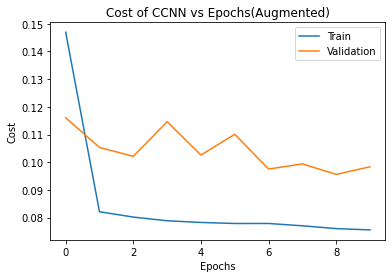

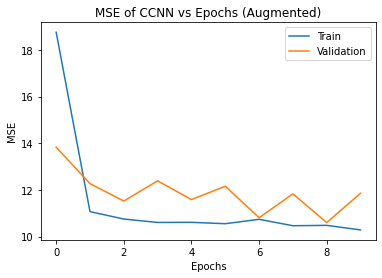

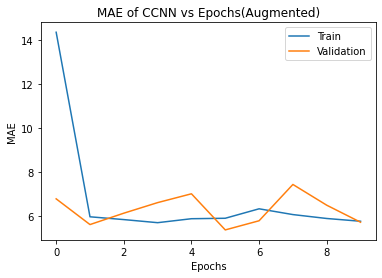

In [ ]:
plot_cost, plot_mse,plot_mae = 1, 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of CCNN vs Epochs(Augmented)")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mse:
    plt.plot(MSE_train)
    plt.plot(MSE_validation)
    plt.title("MSE of CCNN vs Epochs (Augmented)")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mae:
    plt.plot(MAE_train)
    
    plt.plot(MAE_validation)
    plt.title("MAE of CCNN vs Epochs(Augmented)")
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/CountNet_Aug.pth'
torch.save(Net.state_dict(), PATH)

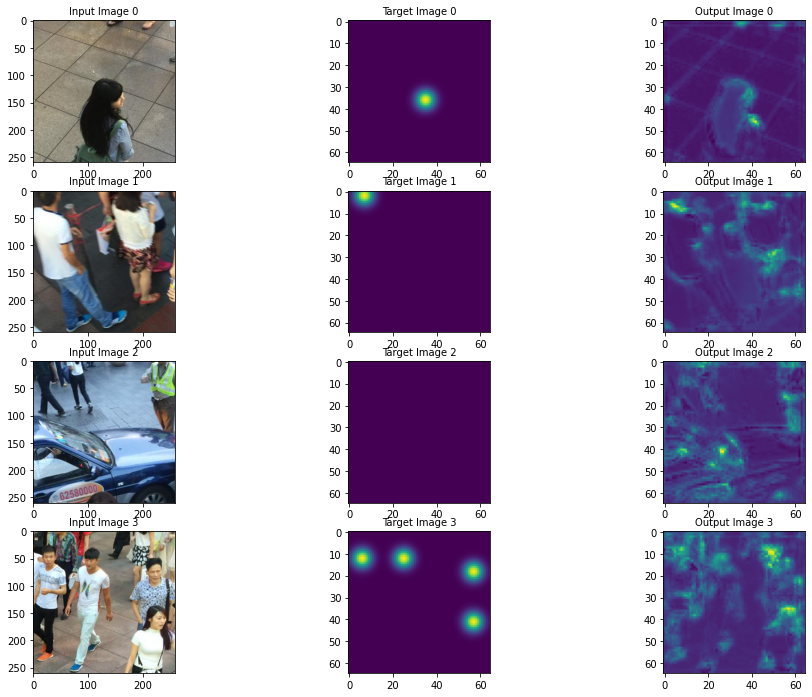

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

test_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

test_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/'

test_set =  ShanghaiTech_Dataset(test_names,test_data_folder,test_labels_folder )
test_generator = torch.utils.data.DataLoader(test_set, **params) 

PATH = '/content/drive/My Drive/CountNet_Aug.pth'
net = CountNet()
net.load_state_dict(torch.load(PATH))

dataiter = iter(test_generator)
images, labels = dataiter.next()

#print(images.shape,labels.shape)
outputs = net(images)
#print(outputs.shape)
test_set.test_network(images, outputs, labels)

In [ ]:
# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])


mse = nn.MSELoss()
mae = nn.L1Loss()

running_testloss, running_test_mse, running_test_mae = 0.0, 0.0 , 0.0
test_cnt = 0

# test
with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        test_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

        running_testloss += test_loss.item()
        running_loss += test_loss.item()
    
        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))

        a = torch.sqrt(mse(z,z_hat))
        running_test_mse += a
        running_mse += a

        b = mae(z,z_hat)
        running_test_mae += b
        running_mae += b

        if test_cnt % 20 == 19:    # print every 10 mini-batches
          print("Cost of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_loss / 20))
          print("MSE of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_mse / 20 ))
          print("MAE of test data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_mae / 20 ))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

        test_cnt += 1
        

test_losses = running_testloss / test_cnt

MSE_test =  running_test_mse / test_cnt

MAE_test =running_test_mae / test_cnt



  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 1/565 [00:03<36:46,  3.91s/it]

  1%|          | 3/565 [00:04<25:50,  2.76s/it]

  1%|          | 5/565 [00:04<18:12,  1.95s/it]

  1%|          | 6/565 [00:05<16:58,  1.82s/it]

  1%|▏         | 8/565 [00:07<13:50,  1.49s/it]

  2%|▏         | 10/565 [00:08<11:12,  1.21s/it]

  2%|▏         | 11/565 [00:08<08:43,  1.06it/s]

  2%|▏         | 12/565 [00:08<06:40,  1.38it/s]

  2%|▏         | 13/565 [00:10<09:32,  1.04s/it]

  3%|▎         | 15/565 [00:12<09:23,  1.02s/it]

  3%|▎         | 17/565 [00:13<07:47,  1.17it/s]

  3%|▎         | 19/565 [00:14<06:48,  1.34it/s]

Cost of test data after 20 iterations in epoch 10 : 0.115544
MSE of test data after 20 iterations in epoch 10 : 11.903645
MAE of test data after 20 iterations in epoch 10 : 7.178463




  4%|▎         | 21/565 [00:16<07:01,  1.29it/s]

  4%|▍         | 23/565 [00:18<07:41,  1.17it/s]

  4%|▍         | 25/565 [00:18<05:53,  1.53it/s]

  5%|▍         | 27/565 [00:19<05:20,  1.68it/s]

  5%|▍         | 28/565 [00:19<04:38,  1.93it/s]

  5%|▌         | 29/565 [00:20<05:05,  1.75it/s]

  5%|▌         | 30/565 [00:21<05:23,  1.65it/s]

  5%|▌         | 31/565 [00:22<07:09,  1.24it/s]

  6%|▌         | 33/565 [00:23<06:39,  1.33it/s]

  6%|▌         | 35/565 [00:25<06:25,  1.37it/s]

  6%|▋         | 36/565 [00:25<05:17,  1.67it/s]

  7%|▋         | 38/565 [00:26<05:12,  1.69it/s]

  7%|▋         | 39/565 [00:26<04:11,  2.09it/s]

  7%|▋         | 40/565 [00:27<04:35,  1.91it/s]

Cost of test data after 40 iterations in epoch 10 : 0.046705
MSE of test data after 40 iterations in epoch 10 : 5.660010
MAE of test data after 40 iterations in epoch 10 : 4.225000




  7%|▋         | 41/565 [00:28<05:35,  1.56it/s]

  8%|▊         | 43/565 [00:29<06:02,  1.44it/s]

  8%|▊         | 45/565 [00:31<06:14,  1.39it/s]

  8%|▊         | 47/565 [00:33<06:21,  1.36it/s]

  9%|▊         | 49/565 [00:34<06:12,  1.38it/s]

  9%|▉         | 51/565 [00:35<05:47,  1.48it/s]

  9%|▉         | 53/565 [00:36<05:32,  1.54it/s]

 10%|▉         | 54/565 [00:37<05:14,  1.63it/s]

 10%|▉         | 55/565 [00:37<05:28,  1.55it/s]

 10%|▉         | 56/565 [00:38<05:13,  1.62it/s]

 10%|█         | 57/565 [00:39<06:29,  1.30it/s]

 10%|█         | 58/565 [00:40<05:40,  1.49it/s]

 10%|█         | 59/565 [00:40<05:53,  1.43it/s]

 11%|█         | 60/565 [00:41<04:35,  1.83it/s]

Cost of test data after 60 iterations in epoch 10 : 0.034917
MSE of test data after 60 iterations in epoch 10 : 5.145453
MAE of test data after 60 iterations in epoch 10 : 3.862500




 11%|█         | 61/565 [00:42<07:46,  1.08it/s]

 11%|█         | 63/565 [00:44<07:17,  1.15it/s]

 12%|█▏        | 65/565 [00:45<06:58,  1.19it/s]

 12%|█▏        | 67/565 [00:47<06:37,  1.25it/s]

 12%|█▏        | 69/565 [00:48<06:30,  1.27it/s]

 13%|█▎        | 71/565 [00:50<06:30,  1.27it/s]

 13%|█▎        | 73/565 [00:51<06:09,  1.33it/s]

 13%|█▎        | 75/565 [00:52<05:36,  1.46it/s]

 14%|█▎        | 77/565 [00:54<05:42,  1.43it/s]

 14%|█▍        | 79/565 [00:55<05:48,  1.39it/s]

Cost of test data after 80 iterations in epoch 10 : 0.078533
MSE of test data after 80 iterations in epoch 10 : 9.074767
MAE of test data after 80 iterations in epoch 10 : 6.225000




 14%|█▍        | 81/565 [00:57<05:41,  1.42it/s]

 15%|█▍        | 83/565 [00:58<06:07,  1.31it/s]

 15%|█▌        | 85/565 [01:00<06:34,  1.22it/s]

 15%|█▌        | 87/565 [01:02<06:36,  1.20it/s]

 16%|█▌        | 89/565 [01:04<06:57,  1.14it/s]

 16%|█▌        | 91/565 [01:06<07:11,  1.10it/s]

 16%|█▋        | 93/565 [01:08<07:05,  1.11it/s]

 17%|█▋        | 95/565 [01:09<06:54,  1.14it/s]

 17%|█▋        | 97/565 [01:11<06:18,  1.23it/s]

 18%|█▊        | 99/565 [01:12<06:26,  1.21it/s]

Cost of test data after 100 iterations in epoch 10 : 0.047381
MSE of test data after 100 iterations in epoch 10 : 4.619254
MAE of test data after 100 iterations in epoch 10 : 3.487500




 18%|█▊        | 101/565 [01:14<06:42,  1.15it/s]

 18%|█▊        | 103/565 [01:16<07:02,  1.09it/s]

 19%|█▊        | 105/565 [01:18<06:57,  1.10it/s]

 19%|█▉        | 107/565 [01:20<07:00,  1.09it/s]

 19%|█▉        | 109/565 [01:22<07:23,  1.03it/s]

 20%|█▉        | 111/565 [01:24<07:29,  1.01it/s]

 20%|██        | 113/565 [01:26<07:12,  1.05it/s]

 20%|██        | 115/565 [01:28<07:04,  1.06it/s]

 21%|██        | 117/565 [01:30<07:09,  1.04it/s]

 21%|██        | 119/565 [01:32<06:52,  1.08it/s]

Cost of test data after 120 iterations in epoch 10 : 0.050610
MSE of test data after 120 iterations in epoch 10 : 7.316019
MAE of test data after 120 iterations in epoch 10 : 5.137500




 21%|██▏       | 121/565 [01:34<07:17,  1.01it/s]

 22%|██▏       | 123/565 [01:36<07:09,  1.03it/s]

 22%|██▏       | 125/565 [01:38<07:23,  1.01s/it]

 22%|██▏       | 127/565 [01:39<06:49,  1.07it/s]

 23%|██▎       | 129/565 [01:41<06:28,  1.12it/s]

 23%|██▎       | 131/565 [01:43<06:24,  1.13it/s]

 24%|██▎       | 133/565 [01:44<06:00,  1.20it/s]

 24%|██▍       | 135/565 [01:46<06:16,  1.14it/s]

 24%|██▍       | 137/565 [01:48<06:46,  1.05it/s]

 25%|██▍       | 139/565 [01:51<07:12,  1.02s/it]

Cost of test data after 140 iterations in epoch 10 : 0.022772
MSE of test data after 140 iterations in epoch 10 : 3.866607
MAE of test data after 140 iterations in epoch 10 : 3.250000




 25%|██▍       | 141/565 [01:53<07:18,  1.03s/it]

 25%|██▌       | 143/565 [01:54<06:43,  1.05it/s]

 26%|██▌       | 145/565 [01:57<07:19,  1.05s/it]

 26%|██▌       | 147/565 [01:58<06:37,  1.05it/s]

 26%|██▋       | 149/565 [02:00<06:39,  1.04it/s]

 27%|██▋       | 151/565 [02:02<06:14,  1.11it/s]

 27%|██▋       | 153/565 [02:04<06:13,  1.10it/s]

 27%|██▋       | 155/565 [02:05<05:56,  1.15it/s]

 28%|██▊       | 157/565 [02:07<05:49,  1.17it/s]

 28%|██▊       | 159/565 [02:09<05:52,  1.15it/s]

Cost of test data after 160 iterations in epoch 10 : 0.053040
MSE of test data after 160 iterations in epoch 10 : 5.710253
MAE of test data after 160 iterations in epoch 10 : 4.437500




 28%|██▊       | 161/565 [02:12<06:54,  1.03s/it]

 29%|██▉       | 163/565 [02:13<06:36,  1.01it/s]

 29%|██▉       | 165/565 [02:15<06:22,  1.05it/s]

 30%|██▉       | 167/565 [02:17<05:59,  1.11it/s]

 30%|██▉       | 169/565 [02:18<05:42,  1.16it/s]

 30%|███       | 171/565 [02:21<06:16,  1.05it/s]

 31%|███       | 173/565 [02:22<05:47,  1.13it/s]

 31%|███       | 175/565 [02:24<05:57,  1.09it/s]

 31%|███▏      | 177/565 [02:26<06:04,  1.06it/s]

 32%|███▏      | 179/565 [02:28<05:52,  1.09it/s]

Cost of test data after 180 iterations in epoch 10 : 0.036234
MSE of test data after 180 iterations in epoch 10 : 5.301530
MAE of test data after 180 iterations in epoch 10 : 3.925000




 32%|███▏      | 181/565 [02:30<06:04,  1.05it/s]

 32%|███▏      | 183/565 [02:32<06:02,  1.05it/s]

 33%|███▎      | 185/565 [02:34<06:01,  1.05it/s]

 33%|███▎      | 187/565 [02:36<06:38,  1.05s/it]

 33%|███▎      | 189/565 [02:38<06:04,  1.03it/s]

 34%|███▍      | 191/565 [02:40<06:05,  1.02it/s]

 34%|███▍      | 193/565 [02:41<05:42,  1.09it/s]

 35%|███▍      | 195/565 [02:43<05:23,  1.14it/s]

 35%|███▍      | 197/565 [02:45<05:58,  1.03it/s]

 35%|███▌      | 199/565 [02:47<05:49,  1.05it/s]

Cost of test data after 200 iterations in epoch 10 : 0.068830
MSE of test data after 200 iterations in epoch 10 : 8.006529
MAE of test data after 200 iterations in epoch 10 : 5.437500




 36%|███▌      | 201/565 [02:49<05:36,  1.08it/s]

 36%|███▌      | 203/565 [02:50<05:24,  1.12it/s]

 36%|███▋      | 205/565 [02:52<05:34,  1.07it/s]

 37%|███▋      | 207/565 [02:54<05:05,  1.17it/s]

 37%|███▋      | 209/565 [02:55<05:02,  1.18it/s]

 37%|███▋      | 211/565 [02:57<04:53,  1.21it/s]

 38%|███▊      | 213/565 [02:59<05:02,  1.16it/s]

 38%|███▊      | 215/565 [03:01<05:07,  1.14it/s]

 38%|███▊      | 217/565 [03:02<04:58,  1.17it/s]

 39%|███▉      | 219/565 [03:04<04:56,  1.17it/s]

Cost of test data after 220 iterations in epoch 10 : 0.083093
MSE of test data after 220 iterations in epoch 10 : 7.872910
MAE of test data after 220 iterations in epoch 10 : 5.612500




 39%|███▉      | 221/565 [03:06<04:53,  1.17it/s]

 39%|███▉      | 222/565 [03:06<03:37,  1.58it/s]

 39%|███▉      | 223/565 [03:08<05:50,  1.02s/it]

 40%|███▉      | 225/565 [03:10<06:20,  1.12s/it]

 40%|████      | 227/565 [03:13<06:12,  1.10s/it]

 41%|████      | 229/565 [03:15<06:18,  1.13s/it]

 41%|████      | 231/565 [03:17<05:46,  1.04s/it]

 41%|████      | 233/565 [03:18<05:30,  1.00it/s]

 42%|████▏     | 235/565 [03:20<05:23,  1.02it/s]

 42%|████▏     | 237/565 [03:22<05:06,  1.07it/s]

 42%|████▏     | 239/565 [03:24<05:01,  1.08it/s]

Cost of test data after 240 iterations in epoch 10 : 0.075664
MSE of test data after 240 iterations in epoch 10 : 6.730018
MAE of test data after 240 iterations in epoch 10 : 4.987500




 43%|████▎     | 241/565 [03:26<04:57,  1.09it/s]

 43%|████▎     | 243/565 [03:30<07:03,  1.31s/it]

 43%|████▎     | 245/565 [03:33<07:11,  1.35s/it]

 44%|████▎     | 247/565 [03:34<06:15,  1.18s/it]

 44%|████▍     | 249/565 [03:36<05:52,  1.11s/it]

 44%|████▍     | 251/565 [03:38<05:17,  1.01s/it]

 45%|████▍     | 253/565 [03:40<05:15,  1.01s/it]

 45%|████▌     | 255/565 [03:43<05:41,  1.10s/it]

 45%|████▌     | 257/565 [03:44<04:49,  1.06it/s]

 46%|████▌     | 259/565 [03:45<04:21,  1.17it/s]

Cost of test data after 260 iterations in epoch 10 : 0.042114
MSE of test data after 260 iterations in epoch 10 : 5.564399
MAE of test data after 260 iterations in epoch 10 : 4.087500




 46%|████▌     | 261/565 [03:47<04:16,  1.18it/s]

 47%|████▋     | 263/565 [03:49<04:44,  1.06it/s]

 47%|████▋     | 265/565 [03:51<04:37,  1.08it/s]

 47%|████▋     | 267/565 [03:53<04:49,  1.03it/s]

 48%|████▊     | 269/565 [03:54<04:11,  1.18it/s]

 48%|████▊     | 271/565 [03:56<04:04,  1.20it/s]

 48%|████▊     | 273/565 [03:57<04:06,  1.18it/s]

 49%|████▊     | 275/565 [03:59<04:01,  1.20it/s]

 49%|████▉     | 277/565 [04:01<03:55,  1.22it/s]

 49%|████▉     | 278/565 [04:01<02:52,  1.66it/s]

 49%|████▉     | 279/565 [04:03<04:41,  1.02it/s]

Cost of test data after 280 iterations in epoch 10 : 0.031205
MSE of test data after 280 iterations in epoch 10 : 4.560476
MAE of test data after 280 iterations in epoch 10 : 3.550000




 50%|████▉     | 281/565 [04:05<04:46,  1.01s/it]

 50%|█████     | 283/565 [04:06<04:32,  1.04it/s]

 50%|█████     | 284/565 [04:07<03:22,  1.39it/s]

 50%|█████     | 285/565 [04:08<04:37,  1.01it/s]

 51%|█████     | 286/565 [04:09<04:08,  1.12it/s]

 51%|█████     | 287/565 [04:10<04:17,  1.08it/s]

 51%|█████     | 288/565 [04:11<04:11,  1.10it/s]

 51%|█████     | 289/565 [04:12<04:09,  1.11it/s]

 51%|█████▏    | 290/565 [04:12<04:04,  1.12it/s]

 52%|█████▏    | 291/565 [04:14<04:35,  1.00s/it]

 52%|█████▏    | 292/565 [04:14<03:56,  1.15it/s]

 52%|█████▏    | 293/565 [04:15<04:09,  1.09it/s]

 52%|█████▏    | 294/565 [04:16<03:57,  1.14it/s]

 52%|█████▏    | 295/565 [04:17<04:05,  1.10it/s]

 52%|█████▏    | 296/565 [04:18<03:57,  1.13it/s]

 53%|█████▎    | 297/565 [04:19<03:43,  1.20it/s]

 53%|█████▎    | 298/565 [04:20<04:02,  1.10it/s]

 53%|█████▎    | 299/565 [04:20<03:49,  1.16it/s]

 53%|█████▎    | 300/565 [04:22<04:08,  1.07it/s]

Cost of test data after 300 iterations in epoch 10 : 0.094464
MSE of test data after 300 iterations in epoch 10 : 7.576185
MAE of test data after 300 iterations in epoch 10 : 5.137500




 53%|█████▎    | 301/565 [04:22<03:36,  1.22it/s]

 53%|█████▎    | 302/565 [04:23<04:00,  1.09it/s]

 54%|█████▎    | 303/565 [04:24<03:56,  1.11it/s]

 54%|█████▍    | 304/565 [04:25<03:43,  1.17it/s]

 54%|█████▍    | 305/565 [04:26<03:42,  1.17it/s]

 54%|█████▍    | 306/565 [04:27<04:20,  1.01s/it]

 54%|█████▍    | 307/565 [04:28<03:53,  1.11it/s]

 55%|█████▍    | 308/565 [04:29<04:41,  1.09s/it]

 55%|█████▍    | 309/565 [04:30<03:44,  1.14it/s]

 55%|█████▍    | 310/565 [04:31<04:47,  1.13s/it]

 55%|█████▌    | 312/565 [04:34<05:06,  1.21s/it]

 55%|█████▌    | 313/565 [04:35<03:59,  1.05it/s]

 56%|█████▌    | 314/565 [04:35<03:47,  1.10it/s]

 56%|█████▌    | 315/565 [04:37<04:26,  1.07s/it]

 56%|█████▌    | 316/565 [04:37<03:25,  1.21it/s]

 56%|█████▌    | 317/565 [04:38<04:02,  1.02it/s]

 56%|█████▋    | 318/565 [04:39<03:44,  1.10it/s]

 56%|█████▋    | 319/565 [04:40<03:43,  1.10it/s]

 57%|█████▋    | 320/565 [04:41<03:30,  1.16it/s]

Cost of test data after 320 iterations in epoch 10 : 0.132854
MSE of test data after 320 iterations in epoch 10 : 10.647639
MAE of test data after 320 iterations in epoch 10 : 7.275000




 57%|█████▋    | 321/565 [04:42<04:21,  1.07s/it]

 57%|█████▋    | 322/565 [04:42<03:12,  1.26it/s]

 57%|█████▋    | 323/565 [04:44<04:12,  1.04s/it]

 58%|█████▊    | 325/565 [04:46<04:15,  1.06s/it]

 58%|█████▊    | 327/565 [04:48<03:40,  1.08it/s]

 58%|█████▊    | 329/565 [04:50<03:45,  1.05it/s]

 59%|█████▊    | 331/565 [04:51<03:29,  1.12it/s]

 59%|█████▉    | 333/565 [04:53<03:23,  1.14it/s]

 59%|█████▉    | 335/565 [04:54<03:16,  1.17it/s]

 60%|█████▉    | 337/565 [04:56<03:19,  1.14it/s]

 60%|██████    | 339/565 [04:58<03:21,  1.12it/s]

Cost of test data after 340 iterations in epoch 10 : 0.036273
MSE of test data after 340 iterations in epoch 10 : 5.209801
MAE of test data after 340 iterations in epoch 10 : 4.100000




 60%|██████    | 341/565 [05:00<03:14,  1.15it/s]

 61%|██████    | 343/565 [05:01<03:13,  1.15it/s]

 61%|██████    | 345/565 [05:03<03:11,  1.15it/s]

 61%|██████▏   | 347/565 [05:05<03:05,  1.17it/s]

 62%|██████▏   | 349/565 [05:06<03:00,  1.20it/s]

 62%|██████▏   | 351/565 [05:08<03:04,  1.16it/s]

 62%|██████▏   | 353/565 [05:10<03:15,  1.08it/s]

 63%|██████▎   | 355/565 [05:12<03:09,  1.11it/s]

 63%|██████▎   | 357/565 [05:14<02:59,  1.16it/s]

 64%|██████▎   | 359/565 [05:15<02:54,  1.18it/s]

Cost of test data after 360 iterations in epoch 10 : 0.096049
MSE of test data after 360 iterations in epoch 10 : 9.085038
MAE of test data after 360 iterations in epoch 10 : 6.025000




 64%|██████▍   | 361/565 [05:17<02:55,  1.16it/s]

 64%|██████▍   | 363/565 [05:19<02:46,  1.21it/s]

 64%|██████▍   | 364/565 [05:19<02:05,  1.60it/s]

 65%|██████▍   | 365/565 [05:20<02:57,  1.13it/s]

 65%|██████▍   | 366/565 [05:20<02:11,  1.52it/s]

 65%|██████▍   | 367/565 [05:22<03:15,  1.01it/s]

 65%|██████▌   | 368/565 [05:22<02:28,  1.32it/s]

 65%|██████▌   | 369/565 [05:24<03:19,  1.02s/it]

 65%|██████▌   | 370/565 [05:24<02:24,  1.35it/s]

 66%|██████▌   | 371/565 [05:26<03:14,  1.00s/it]

 66%|██████▌   | 372/565 [05:26<02:39,  1.21it/s]

 66%|██████▌   | 373/565 [05:27<03:05,  1.03it/s]

 66%|██████▌   | 374/565 [05:28<02:33,  1.25it/s]

 66%|██████▋   | 375/565 [05:29<03:17,  1.04s/it]

 67%|██████▋   | 376/565 [05:30<02:46,  1.14it/s]

 67%|██████▋   | 377/565 [05:32<03:30,  1.12s/it]

 67%|██████▋   | 379/565 [05:34<03:46,  1.22s/it]

Cost of test data after 380 iterations in epoch 10 : 0.025676
MSE of test data after 380 iterations in epoch 10 : 3.585550
MAE of test data after 380 iterations in epoch 10 : 2.962500




 67%|██████▋   | 381/565 [05:36<03:23,  1.11s/it]

 68%|██████▊   | 383/565 [05:38<03:05,  1.02s/it]

 68%|██████▊   | 385/565 [05:40<02:59,  1.00it/s]

 68%|██████▊   | 387/565 [05:41<02:45,  1.08it/s]

 69%|██████▉   | 389/565 [05:43<02:42,  1.08it/s]

 69%|██████▉   | 391/565 [05:45<02:44,  1.06it/s]

 70%|██████▉   | 393/565 [05:47<02:36,  1.10it/s]

 70%|██████▉   | 395/565 [05:48<02:24,  1.17it/s]

 70%|███████   | 397/565 [05:50<02:23,  1.17it/s]

 71%|███████   | 399/565 [05:52<02:29,  1.11it/s]

Cost of test data after 400 iterations in epoch 10 : 0.031508
MSE of test data after 400 iterations in epoch 10 : 4.983659
MAE of test data after 400 iterations in epoch 10 : 3.900000




 71%|███████   | 401/565 [05:54<02:35,  1.06it/s]

 71%|███████▏  | 403/565 [05:56<02:37,  1.03it/s]

 72%|███████▏  | 405/565 [05:57<02:25,  1.10it/s]

 72%|███████▏  | 406/565 [05:58<01:49,  1.46it/s]

 72%|███████▏  | 407/565 [06:00<03:13,  1.22s/it]

 72%|███████▏  | 409/565 [06:02<03:04,  1.18s/it]

 73%|███████▎  | 411/565 [06:04<02:45,  1.07s/it]

 73%|███████▎  | 413/565 [06:05<02:29,  1.02it/s]

 73%|███████▎  | 415/565 [06:07<02:24,  1.04it/s]

 74%|███████▍  | 417/565 [06:09<02:17,  1.07it/s]

 74%|███████▍  | 419/565 [06:11<02:16,  1.07it/s]

Cost of test data after 420 iterations in epoch 10 : 0.057874
MSE of test data after 420 iterations in epoch 10 : 6.447553
MAE of test data after 420 iterations in epoch 10 : 4.575000




 75%|███████▍  | 421/565 [06:14<02:31,  1.05s/it]

 75%|███████▍  | 423/565 [06:15<02:21,  1.00it/s]

 75%|███████▌  | 425/565 [06:17<02:17,  1.02it/s]

 76%|███████▌  | 427/565 [06:19<02:11,  1.05it/s]

 76%|███████▌  | 429/565 [06:21<02:14,  1.01it/s]

 76%|███████▋  | 431/565 [06:23<02:04,  1.08it/s]

 77%|███████▋  | 433/565 [06:25<02:04,  1.06it/s]

 77%|███████▋  | 435/565 [06:26<01:56,  1.12it/s]

 77%|███████▋  | 437/565 [06:28<01:56,  1.10it/s]

 78%|███████▊  | 439/565 [06:30<01:51,  1.13it/s]

Cost of test data after 440 iterations in epoch 10 : 0.020050
MSE of test data after 440 iterations in epoch 10 : 3.282889
MAE of test data after 440 iterations in epoch 10 : 2.700000




 78%|███████▊  | 441/565 [06:31<01:48,  1.14it/s]

 78%|███████▊  | 443/565 [06:33<01:42,  1.19it/s]

 79%|███████▉  | 445/565 [06:35<01:43,  1.16it/s]

 79%|███████▉  | 447/565 [06:37<01:50,  1.07it/s]

 79%|███████▉  | 449/565 [06:39<01:48,  1.07it/s]

 80%|███████▉  | 451/565 [06:41<01:42,  1.11it/s]

 80%|████████  | 453/565 [06:42<01:39,  1.12it/s]

 81%|████████  | 455/565 [06:45<01:48,  1.01it/s]

 81%|████████  | 457/565 [06:47<01:44,  1.04it/s]

 81%|████████  | 459/565 [06:49<01:44,  1.01it/s]

Cost of test data after 460 iterations in epoch 10 : 0.031659
MSE of test data after 460 iterations in epoch 10 : 4.344819
MAE of test data after 460 iterations in epoch 10 : 3.675000




 82%|████████▏ | 461/565 [06:50<01:39,  1.04it/s]

 82%|████████▏ | 463/565 [06:52<01:37,  1.05it/s]

 82%|████████▏ | 465/565 [06:54<01:39,  1.00it/s]

 83%|████████▎ | 467/565 [06:56<01:33,  1.05it/s]

 83%|████████▎ | 469/565 [06:58<01:30,  1.06it/s]

 83%|████████▎ | 471/565 [07:00<01:27,  1.07it/s]

 84%|████████▎ | 473/565 [07:02<01:29,  1.02it/s]

 84%|████████▍ | 475/565 [07:04<01:22,  1.09it/s]

 84%|████████▍ | 476/565 [07:04<01:02,  1.44it/s]

 84%|████████▍ | 477/565 [07:05<01:28,  1.01s/it]

 85%|████████▍ | 479/565 [07:07<01:22,  1.05it/s]

Cost of test data after 480 iterations in epoch 10 : 0.047741
MSE of test data after 480 iterations in epoch 10 : 5.550145
MAE of test data after 480 iterations in epoch 10 : 4.125000




 85%|████████▌ | 481/565 [07:09<01:25,  1.02s/it]

 85%|████████▌ | 483/565 [07:11<01:20,  1.02it/s]

 86%|████████▌ | 485/565 [07:13<01:17,  1.03it/s]

 86%|████████▌ | 487/565 [07:15<01:13,  1.06it/s]

 86%|████████▋ | 488/565 [07:17<01:28,  1.16s/it]

 87%|████████▋ | 489/565 [07:17<01:05,  1.15it/s]

 87%|████████▋ | 490/565 [07:18<01:18,  1.04s/it]

 87%|████████▋ | 491/565 [07:19<01:07,  1.09it/s]

 87%|████████▋ | 492/565 [07:20<01:08,  1.07it/s]

 87%|████████▋ | 493/565 [07:20<00:56,  1.29it/s]

 87%|████████▋ | 494/565 [07:22<01:08,  1.03it/s]

 88%|████████▊ | 495/565 [07:22<00:54,  1.30it/s]

 88%|████████▊ | 496/565 [07:23<01:06,  1.03it/s]

 88%|████████▊ | 497/565 [07:24<00:50,  1.36it/s]

 88%|████████▊ | 498/565 [07:25<01:01,  1.09it/s]

 88%|████████▊ | 500/565 [07:27<01:00,  1.07it/s]

Cost of test data after 500 iterations in epoch 10 : 0.063051
MSE of test data after 500 iterations in epoch 10 : 7.130981
MAE of test data after 500 iterations in epoch 10 : 5.137500




 89%|████████▉ | 502/565 [07:29<00:58,  1.09it/s]

 89%|████████▉ | 504/565 [07:30<00:51,  1.18it/s]

 90%|████████▉ | 506/565 [07:32<00:49,  1.19it/s]

 90%|████████▉ | 507/565 [07:32<00:38,  1.49it/s]

 90%|████████▉ | 508/565 [07:33<00:52,  1.08it/s]

 90%|█████████ | 509/565 [07:34<00:41,  1.35it/s]

 90%|█████████ | 510/565 [07:35<00:53,  1.03it/s]

 90%|█████████ | 511/565 [07:36<00:41,  1.30it/s]

 91%|█████████ | 512/565 [07:37<00:49,  1.06it/s]

 91%|█████████ | 513/565 [07:37<00:38,  1.36it/s]

 91%|█████████ | 514/565 [07:39<00:50,  1.00it/s]

 91%|█████████ | 515/565 [07:39<00:37,  1.32it/s]

 91%|█████████▏| 516/565 [07:41<00:49,  1.01s/it]

 92%|█████████▏| 517/565 [07:41<00:35,  1.35it/s]

 92%|█████████▏| 518/565 [07:43<00:50,  1.07s/it]

 92%|█████████▏| 520/565 [07:44<00:45,  1.02s/it]

Cost of test data after 520 iterations in epoch 10 : 0.043589
MSE of test data after 520 iterations in epoch 10 : 5.628660
MAE of test data after 520 iterations in epoch 10 : 4.212500




 92%|█████████▏| 522/565 [07:46<00:42,  1.02it/s]

 93%|█████████▎| 524/565 [07:48<00:39,  1.03it/s]

 93%|█████████▎| 526/565 [07:50<00:36,  1.08it/s]

 93%|█████████▎| 528/565 [07:51<00:32,  1.12it/s]

 94%|█████████▍| 530/565 [07:53<00:29,  1.18it/s]

 94%|█████████▍| 531/565 [07:53<00:21,  1.57it/s]

 94%|█████████▍| 532/565 [07:54<00:29,  1.14it/s]

 94%|█████████▍| 533/565 [07:55<00:21,  1.50it/s]

 95%|█████████▍| 534/565 [07:56<00:31,  1.01s/it]

 95%|█████████▍| 535/565 [07:57<00:23,  1.27it/s]

 95%|█████████▍| 536/565 [07:58<00:28,  1.02it/s]

 95%|█████████▌| 537/565 [07:59<00:24,  1.16it/s]

 95%|█████████▌| 538/565 [07:59<00:23,  1.15it/s]

 95%|█████████▌| 539/565 [08:00<00:20,  1.26it/s]

 96%|█████████▌| 540/565 [08:01<00:21,  1.18it/s]

Cost of test data after 540 iterations in epoch 10 : 0.043261
MSE of test data after 540 iterations in epoch 10 : 5.879057
MAE of test data after 540 iterations in epoch 10 : 4.387500




 96%|█████████▌| 541/565 [08:02<00:20,  1.19it/s]

 96%|█████████▌| 542/565 [08:03<00:18,  1.22it/s]

 96%|█████████▌| 543/565 [08:04<00:21,  1.03it/s]

 96%|█████████▋| 544/565 [08:04<00:16,  1.31it/s]

 96%|█████████▋| 545/565 [08:07<00:28,  1.43s/it]

 97%|█████████▋| 546/565 [08:07<00:19,  1.03s/it]

 97%|█████████▋| 547/565 [08:09<00:23,  1.28s/it]

 97%|█████████▋| 549/565 [08:11<00:18,  1.16s/it]

 98%|█████████▊| 551/565 [08:15<00:19,  1.40s/it]

 98%|█████████▊| 553/565 [08:20<00:20,  1.69s/it]

 98%|█████████▊| 555/565 [08:22<00:16,  1.60s/it]

 99%|█████████▊| 557/565 [08:25<00:11,  1.46s/it]

 99%|█████████▉| 559/565 [08:26<00:07,  1.29s/it]

Cost of test data after 560 iterations in epoch 10 : 0.046514
MSE of test data after 560 iterations in epoch 10 : 5.821225
MAE of test data after 560 iterations in epoch 10 : 4.487500




 99%|█████████▉| 561/565 [08:28<00:04,  1.15s/it]

 99%|█████████▉| 562/565 [08:29<00:03,  1.20s/it]

100%|█████████▉| 563/565 [08:30<00:01,  1.00it/s]

100%|█████████▉| 564/565 [08:32<00:01,  1.16s/it]

100%|██████████| 565/565 [08:33<00:00,  1.10it/s]


In [ ]:
print("Cost of Test data after training : ", test_losses)
print("MSE of Test data after training : ",MSE_test)
print("MAE of Test data after training : ",MAE_test)

Cost of Test data after training :  0.05389657707764799
MSE of Test data after training :  tensor(6.1108, device='cuda:0', dtype=torch.float64)
MAE of Test data after training :  tensor(4.4804, device='cuda:0', dtype=torch.float64)


### Train CCNN_FC

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

train_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_data/'
train_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_labels/'

val_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'
val_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/'

train_names = [f  for f in os.listdir(train_data_folder) if os.path.isfile(os.path.join(train_data_folder, f))]
val_names = [f  for f in os.listdir(val_data_folder) if os.path.isfile(os.path.join(val_data_folder, f))]

# Training and validation Data Generators
training_set =  ShanghaiTech_Dataset(train_names,train_data_folder,train_labels_folder )
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  ShanghaiTech_Dataset(val_names,val_data_folder, val_labels_folder)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = CountNet_FC()
Net.to(device)

# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])

mse = nn.MSELoss()
mae = nn.L1Loss()
#optimizer = optim.SGD(Net.parameters(), lr = 0.00005, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(Net.parameters(), lr = 0.00005)

train_losses = []
validation_losses = []

MSE_train = []
MSE_validation = []

MAE_train = []
MAE_validation = []

# dataiter = iter(training_generator)
# batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0 , 0.0
    running_train_mse, running_val_mse, running_mse = 0.0, 0.0 , 0.0
    running_train_mae, running_val_mae, running_mae = 0.0, 0.0 , 0.0      
    train_cnt, val_cnt = 0, 0 
    
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        #print(batch_data[0,0,10,11])
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        #print(batch_labels[0,:,:])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        #print(batch_outputs[0,:,:,:])
        loss = Euclidean_regression_loss(batch_outputs.squeeze().view(-1,65,65), batch_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze().view(-1,65,65), dim = [1,2]))
        
        a = torch.sqrt(mse(z,z_hat))
        running_train_mse += a
        running_mse += a
        
        b = mae(z,z_hat)
        running_train_mae += b
        running_mae += b
        
        if train_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mse / 10))
          print("MAE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mae / 10))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = Euclidean_regression_loss(batch_outputs.squeeze().view(-1,65,65), batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()
        
            z = torch.round(torch.sum(batch_labels, dim = [1,2]))
            z_hat = torch.round(torch.sum(batch_outputs.squeeze().view(-1,65,65), dim = [1,2]))

            a = torch.sqrt(mse(z,z_hat))
            running_val_mse += a
            running_mse += a

            b = mae(z,z_hat)
            running_val_mae += b
            running_mae += b

            if val_cnt % 10 == 9:    # print every 10 mini-batches
              print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
              print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 10))
              print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 10))
              running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

    MSE_train.append(running_train_mse / train_cnt)
    MSE_validation.append(running_val_mse / val_cnt)

    MAE_train.append(running_train_mae / train_cnt)
    MAE_validation.append(running_val_mae / val_cnt)







  0%|          | 0/10 [00:00<?, ?it/s]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:03<03:35,  3.92s/it]






  4%|▎         | 2/56 [00:05<02:47,  3.11s/it]






  5%|▌         | 3/56 [00:06<02:17,  2.59s/it]






  7%|▋         | 4/56 [00:07<01:53,  2.17s/it]






  9%|▉         | 5/56 [00:09<01:44,  2.06s/it]






 11%|█         | 6/56 [00:10<01:29,  1.80s/it]






 12%|█▎        | 7/56 [00:12<01:24,  1.72s/it]






 14%|█▍        | 8/56 [00:13<01:14,  1.56s/it]






 16%|█▌        | 9/56 [00:15<01:19,  1.68s/it]






 18%|█▊        | 10/56 [00:16<01:10,  1.54s/it]

Cost of Train data after 10 iterations in epoch 1 : 2.083227
MSE of Train data after 10 iterations in epoch 1 : 12.162197
MAE of Train data after 10 iterations in epoch 1 : 6.015625









 20%|█▉        | 11/56 [00:18<01:10,  1.56s/it]






 21%|██▏       | 12/56 [00:19<01:03,  1.45s/it]






 23%|██▎       | 13/56 [00:20<01:00,  1.41s/it]






 25%|██▌       | 14/56 [00:21<00:56,  1.35s/it]






 27%|██▋       | 15/56 [00:23<00:57,  1.41s/it]






 29%|██▊       | 16/56 [00:24<00:53,  1.35s/it]






 30%|███       | 17/56 [00:26<00:56,  1.44s/it]






 32%|███▏      | 18/56 [00:27<00:52,  1.37s/it]






 34%|███▍      | 19/56 [00:28<00:49,  1.34s/it]






 36%|███▌      | 20/56 [00:30<00:46,  1.30s/it]

Cost of Train data after 20 iterations in epoch 1 : 1.729043
MSE of Train data after 20 iterations in epoch 1 : 13.463674
MAE of Train data after 20 iterations in epoch 1 : 6.737500









 38%|███▊      | 21/56 [00:31<00:46,  1.33s/it]






 39%|███▉      | 22/56 [00:32<00:43,  1.29s/it]






 41%|████      | 23/56 [00:34<00:44,  1.36s/it]






 43%|████▎     | 24/56 [00:35<00:42,  1.31s/it]






 45%|████▍     | 25/56 [00:36<00:42,  1.39s/it]






 46%|████▋     | 26/56 [00:38<00:39,  1.33s/it]






 48%|████▊     | 27/56 [00:39<00:39,  1.36s/it]






 50%|█████     | 28/56 [00:40<00:36,  1.31s/it]






 52%|█████▏    | 29/56 [00:42<00:35,  1.30s/it]






 54%|█████▎    | 30/56 [00:43<00:33,  1.28s/it]

Cost of Train data after 30 iterations in epoch 1 : 1.603706
MSE of Train data after 30 iterations in epoch 1 : 13.121140
MAE of Train data after 30 iterations in epoch 1 : 5.862500









 55%|█████▌    | 31/56 [00:44<00:32,  1.28s/it]






 57%|█████▋    | 32/56 [00:45<00:32,  1.34s/it]






 59%|█████▉    | 33/56 [00:47<00:30,  1.31s/it]






 61%|██████    | 34/56 [00:48<00:29,  1.35s/it]






 62%|██████▎   | 35/56 [00:49<00:27,  1.30s/it]






 64%|██████▍   | 36/56 [00:51<00:25,  1.28s/it]






 66%|██████▌   | 37/56 [00:52<00:24,  1.29s/it]






 68%|██████▊   | 38/56 [00:53<00:22,  1.28s/it]






 70%|██████▉   | 39/56 [00:55<00:22,  1.35s/it]






 71%|███████▏  | 40/56 [00:56<00:20,  1.31s/it]

Cost of Train data after 40 iterations in epoch 1 : 1.458835
MSE of Train data after 40 iterations in epoch 1 : 14.255778
MAE of Train data after 40 iterations in epoch 1 : 6.687500









 73%|███████▎  | 41/56 [00:57<00:20,  1.38s/it]






 75%|███████▌  | 42/56 [00:59<00:18,  1.33s/it]






 77%|███████▋  | 43/56 [01:00<00:16,  1.30s/it]






 79%|███████▊  | 44/56 [01:01<00:15,  1.27s/it]






 80%|████████  | 45/56 [01:03<00:14,  1.31s/it]






 82%|████████▏ | 46/56 [01:04<00:12,  1.28s/it]






 84%|████████▍ | 47/56 [01:05<00:12,  1.37s/it]






 86%|████████▌ | 48/56 [01:06<00:10,  1.32s/it]






 88%|████████▊ | 49/56 [01:08<00:09,  1.36s/it]






 89%|████████▉ | 50/56 [01:09<00:07,  1.31s/it]

Cost of Train data after 50 iterations in epoch 1 : 1.249085
MSE of Train data after 50 iterations in epoch 1 : 11.982010
MAE of Train data after 50 iterations in epoch 1 : 5.876563









 91%|█████████ | 51/56 [01:11<00:06,  1.33s/it]






 93%|█████████▎| 52/56 [01:12<00:05,  1.30s/it]






 95%|█████████▍| 53/56 [01:13<00:03,  1.28s/it]






 96%|█████████▋| 54/56 [01:14<00:02,  1.27s/it]






 98%|█████████▊| 55/56 [01:16<00:01,  1.28s/it]






100%|██████████| 56/56 [01:24<00:00,  1.51s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:03<00:28,  3.50s/it]






 22%|██▏       | 2/9 [00:03<00:17,  2.55s/it]






 33%|███▎      | 3/9 [00:06<00:15,  2.55s/it]






 44%|████▍     | 4/9 [00:06<00:09,  1.88s/it]






 56%|█████▌    | 5/9 [00:09<00:08,  2.11s/it]






 67%|██████▋   | 6/9 [00:09<00:04,  1.57s/it]






 78%|███████▊  | 7/9 [00:12<00:03,  1.92s/it]






 89%|████████▉ | 8/9 [00:12<00:01,  1.43s/it]






100%|██████████| 9/9 [00:15<00:00,  1.68s/it]






 10%|█         | 1/10 [01:39<14:55, 99.54s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:38,  1.79s/it]






  4%|

Cost of Train data after 10 iterations in epoch 2 : 0.928202
MSE of Train data after 10 iterations in epoch 2 : 13.700043
MAE of Train data after 10 iterations in epoch 2 : 6.737500









 20%|█▉        | 11/56 [00:13<00:55,  1.23s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.22s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.21s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.21s/it]






 30%|███       | 17/56 [00:21<00:47,  1.21s/it]






 32%|███▏      | 18/56 [00:22<00:45,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 2 : 0.716771
MSE of Train data after 20 iterations in epoch 2 : 12.804496
MAE of Train data after 20 iterations in epoch 2 : 6.645313









 38%|███▊      | 21/56 [00:25<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:41,  1.21s/it]






 41%|████      | 23/56 [00:28<00:39,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:31<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.20s/it]

Cost of Train data after 30 iterations in epoch 2 : 0.524883
MSE of Train data after 30 iterations in epoch 2 : 10.790345
MAE of Train data after 30 iterations in epoch 2 : 6.043750









 55%|█████▌    | 31/56 [00:38<00:29,  1.20s/it]






 57%|█████▋    | 32/56 [00:39<00:28,  1.20s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.21s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.21s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.21s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.21s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.21s/it]

Cost of Train data after 40 iterations in epoch 2 : 0.390502
MSE of Train data after 40 iterations in epoch 2 : 11.121252
MAE of Train data after 40 iterations in epoch 2 : 6.110938









 73%|███████▎  | 41/56 [00:50<00:18,  1.21s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.20s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:54<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.20s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.20s/it]






 89%|████████▉ | 50/56 [01:00<00:07,  1.20s/it]

Cost of Train data after 50 iterations in epoch 2 : 0.289510
MSE of Train data after 50 iterations in epoch 2 : 11.174743
MAE of Train data after 50 iterations in epoch 2 : 6.598438









 91%|█████████ | 51/56 [01:02<00:06,  1.20s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.20s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.20s/it]






 98%|█████████▊| 55/56 [01:06<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.15it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.42it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.70it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.99it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.10it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.34it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.54it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.75it/s]






100%|██████████| 9/9 [00:03<00:00,  2.63it/s]






 20%|██        | 2/10 [02:51<12:09, 91.17s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:37,  1.77s/it]






  4%|

Cost of Train data after 10 iterations in epoch 3 : 0.196261
MSE of Train data after 10 iterations in epoch 3 : 12.522287
MAE of Train data after 10 iterations in epoch 3 : 7.190625









 20%|█▉        | 11/56 [00:13<00:55,  1.23s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:50,  1.21s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.20s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.20s/it]






 30%|███       | 17/56 [00:21<00:46,  1.20s/it]






 32%|███▏      | 18/56 [00:22<00:45,  1.20s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.20s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.20s/it]

Cost of Train data after 20 iterations in epoch 3 : 0.135091
MSE of Train data after 20 iterations in epoch 3 : 10.600423
MAE of Train data after 20 iterations in epoch 3 : 6.693750









 38%|███▊      | 21/56 [00:25<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:41,  1.21s/it]






 41%|████      | 23/56 [00:28<00:40,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.20s/it]






 46%|████▋     | 26/56 [00:31<00:36,  1.20s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 3 : 0.121824
MSE of Train data after 30 iterations in epoch 3 : 11.417844
MAE of Train data after 30 iterations in epoch 3 : 6.506250









 55%|█████▌    | 31/56 [00:37<00:30,  1.20s/it]






 57%|█████▋    | 32/56 [00:39<00:28,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.21s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.20s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.20s/it]






 64%|██████▍   | 36/56 [00:43<00:23,  1.20s/it]






 66%|██████▌   | 37/56 [00:45<00:22,  1.20s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.20s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.20s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.20s/it]

Cost of Train data after 40 iterations in epoch 3 : 0.098915
MSE of Train data after 40 iterations in epoch 3 : 11.559902
MAE of Train data after 40 iterations in epoch 3 : 7.118750









 73%|███████▎  | 41/56 [00:49<00:18,  1.20s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.20s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.20s/it]






 80%|████████  | 45/56 [00:54<00:13,  1.20s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.20s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:00<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 3 : 0.114861
MSE of Train data after 50 iterations in epoch 3 : 13.581401
MAE of Train data after 50 iterations in epoch 3 : 7.996875









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.21s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.20s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.20s/it]






 98%|█████████▊| 55/56 [01:06<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.15it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.42it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.70it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.96it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.21it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.43it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.62it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.80it/s]






100%|██████████| 9/9 [00:03<00:00,  2.67it/s]






 30%|███       | 3/10 [04:02<09:56, 85.26s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:38,  1.80s/it]






  4%|

Cost of Train data after 10 iterations in epoch 4 : 0.081966
MSE of Train data after 10 iterations in epoch 4 : 11.496446
MAE of Train data after 10 iterations in epoch 4 : 7.232813









 20%|█▉        | 11/56 [00:13<00:54,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.21s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.22s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.21s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.21s/it]






 30%|███       | 17/56 [00:21<00:47,  1.21s/it]






 32%|███▏      | 18/56 [00:22<00:46,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 4 : 0.088446
MSE of Train data after 20 iterations in epoch 4 : 11.950568
MAE of Train data after 20 iterations in epoch 4 : 7.531250









 38%|███▊      | 21/56 [00:25<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:40,  1.21s/it]






 41%|████      | 23/56 [00:28<00:40,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:32<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.20s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 4 : 0.109390
MSE of Train data after 30 iterations in epoch 4 : 14.082771
MAE of Train data after 30 iterations in epoch 4 : 7.932813









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:29,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:28,  1.22s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.22s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.21s/it]






 66%|██████▌   | 37/56 [00:45<00:22,  1.21s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.20s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.20s/it]

Cost of Train data after 40 iterations in epoch 4 : 0.057957
MSE of Train data after 40 iterations in epoch 4 : 9.652386
MAE of Train data after 40 iterations in epoch 4 : 6.340625









 73%|███████▎  | 41/56 [00:50<00:18,  1.20s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.20s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:54<00:13,  1.20s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.20s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 4 : 0.075794
MSE of Train data after 50 iterations in epoch 4 : 11.287660
MAE of Train data after 50 iterations in epoch 4 : 6.928125









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.20s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.20s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.20s/it]






 98%|█████████▊| 55/56 [01:06<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:07,  1.13it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.41it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.69it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.95it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.21it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.64it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.82it/s]






100%|██████████| 9/9 [00:03<00:00,  2.70it/s]






 40%|████      | 4/10 [05:14<08:06, 81.16s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:37,  1.76s/it]






  4%|

Cost of Train data after 10 iterations in epoch 5 : 0.089975
MSE of Train data after 10 iterations in epoch 5 : 12.257602
MAE of Train data after 10 iterations in epoch 5 : 7.176563









 20%|█▉        | 11/56 [00:13<00:54,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:50,  1.21s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.21s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.21s/it]






 30%|███       | 17/56 [00:21<00:47,  1.22s/it]






 32%|███▏      | 18/56 [00:22<00:46,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 5 : 0.086357
MSE of Train data after 20 iterations in epoch 5 : 12.268464
MAE of Train data after 20 iterations in epoch 5 : 7.326563









 38%|███▊      | 21/56 [00:25<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:40,  1.20s/it]






 41%|████      | 23/56 [00:28<00:39,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:32<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 5 : 0.082224
MSE of Train data after 30 iterations in epoch 5 : 12.058720
MAE of Train data after 30 iterations in epoch 5 : 7.264063









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:28,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.21s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.21s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.20s/it]






 66%|██████▌   | 37/56 [00:45<00:22,  1.21s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.21s/it]

Cost of Train data after 40 iterations in epoch 5 : 0.068311
MSE of Train data after 40 iterations in epoch 5 : 11.158983
MAE of Train data after 40 iterations in epoch 5 : 7.232813









 73%|███████▎  | 41/56 [00:50<00:18,  1.21s/it]






 75%|███████▌  | 42/56 [00:51<00:17,  1.22s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.23s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.22s/it]






 80%|████████  | 45/56 [00:55<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.21s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.22s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 5 : 0.074023
MSE of Train data after 50 iterations in epoch 5 : 10.965900
MAE of Train data after 50 iterations in epoch 5 : 6.871875









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.21s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.17it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.44it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.71it/s]






 44%|████▍     | 4/9 [00:01<00:02,  2.00it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.26it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.49it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.68it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.85it/s]






100%|██████████| 9/9 [00:03<00:00,  2.72it/s]






 50%|█████     | 5/10 [06:25<06:31, 78.31s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:45,  1.91s/it]






  4%|

Cost of Train data after 10 iterations in epoch 6 : 0.077705
MSE of Train data after 10 iterations in epoch 6 : 11.611197
MAE of Train data after 10 iterations in epoch 6 : 6.995313









 20%|█▉        | 11/56 [00:13<00:55,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.22s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.22s/it]






 29%|██▊       | 16/56 [00:20<00:48,  1.22s/it]






 30%|███       | 17/56 [00:21<00:47,  1.22s/it]






 32%|███▏      | 18/56 [00:22<00:45,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 6 : 0.099369
MSE of Train data after 20 iterations in epoch 6 : 12.736338
MAE of Train data after 20 iterations in epoch 6 : 7.400000









 38%|███▊      | 21/56 [00:26<00:42,  1.20s/it]






 39%|███▉      | 22/56 [00:27<00:40,  1.20s/it]






 41%|████      | 23/56 [00:28<00:39,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:32<00:36,  1.20s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 6 : 0.080321
MSE of Train data after 30 iterations in epoch 6 : 11.908154
MAE of Train data after 30 iterations in epoch 6 : 7.453125









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:28,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.21s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.21s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.21s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.21s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:49<00:19,  1.20s/it]

Cost of Train data after 40 iterations in epoch 6 : 0.074458
MSE of Train data after 40 iterations in epoch 6 : 10.745523
MAE of Train data after 40 iterations in epoch 6 : 6.935938









 73%|███████▎  | 41/56 [00:50<00:18,  1.20s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.20s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:55<00:13,  1.20s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.20s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 6 : 0.071802
MSE of Train data after 50 iterations in epoch 6 : 10.777396
MAE of Train data after 50 iterations in epoch 6 : 6.515625









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.20s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.15it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.40it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.66it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.93it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.15it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.36it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.77it/s]






100%|██████████| 9/9 [00:03<00:00,  2.62it/s]






 60%|██████    | 6/10 [07:37<05:05, 76.36s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:36,  1.76s/it]






  4%|

Cost of Train data after 10 iterations in epoch 7 : 0.091116
MSE of Train data after 10 iterations in epoch 7 : 11.829552
MAE of Train data after 10 iterations in epoch 7 : 6.870313









 20%|█▉        | 11/56 [00:13<00:55,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.21s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.21s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.21s/it]






 30%|███       | 17/56 [00:21<00:47,  1.21s/it]






 32%|███▏      | 18/56 [00:22<00:46,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 7 : 0.085810
MSE of Train data after 20 iterations in epoch 7 : 11.398370
MAE of Train data after 20 iterations in epoch 7 : 6.450000









 38%|███▊      | 21/56 [00:25<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:41,  1.21s/it]






 41%|████      | 23/56 [00:28<00:39,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:31<00:36,  1.20s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 7 : 0.074722
MSE of Train data after 30 iterations in epoch 7 : 10.509436
MAE of Train data after 30 iterations in epoch 7 : 6.800000









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:29,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:28,  1.22s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.22s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.22s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.22s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.22s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.22s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.22s/it]

Cost of Train data after 40 iterations in epoch 7 : 0.076113
MSE of Train data after 40 iterations in epoch 7 : 10.809815
MAE of Train data after 40 iterations in epoch 7 : 6.568750









 73%|███████▎  | 41/56 [00:50<00:18,  1.22s/it]






 75%|███████▌  | 42/56 [00:51<00:17,  1.22s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.22s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:55<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.21s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 7 : 0.077337
MSE of Train data after 50 iterations in epoch 7 : 10.564464
MAE of Train data after 50 iterations in epoch 7 : 6.337500









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.21s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.22s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:07,  1.12it/s]






 22%|██▏       | 2/9 [00:01<00:05,  1.38it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.65it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.91it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.15it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.32it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.55it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.73it/s]






100%|██████████| 9/9 [00:03<00:00,  2.60it/s]






 70%|███████   | 7/10 [08:49<03:45, 75.01s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:35,  1.74s/it]






  4%|

Cost of Train data after 10 iterations in epoch 8 : 0.098149
MSE of Train data after 10 iterations in epoch 8 : 12.335278
MAE of Train data after 10 iterations in epoch 8 : 6.271875









 20%|█▉        | 11/56 [00:13<00:55,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:50,  1.21s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.22s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.22s/it]






 30%|███       | 17/56 [00:21<00:47,  1.22s/it]






 32%|███▏      | 18/56 [00:22<00:46,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.21s/it]

Cost of Train data after 20 iterations in epoch 8 : 0.071201
MSE of Train data after 20 iterations in epoch 8 : 9.478975
MAE of Train data after 20 iterations in epoch 8 : 5.618750









 38%|███▊      | 21/56 [00:25<00:42,  1.20s/it]






 39%|███▉      | 22/56 [00:27<00:40,  1.20s/it]






 41%|████      | 23/56 [00:28<00:39,  1.21s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.21s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:31<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 8 : 0.063509
MSE of Train data after 30 iterations in epoch 8 : 8.506415
MAE of Train data after 30 iterations in epoch 8 : 5.500000









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:29,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.21s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.21s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.21s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.22s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:48<00:19,  1.21s/it]

Cost of Train data after 40 iterations in epoch 8 : 0.086111
MSE of Train data after 40 iterations in epoch 8 : 10.743429
MAE of Train data after 40 iterations in epoch 8 : 6.059375









 73%|███████▎  | 41/56 [00:50<00:18,  1.21s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.20s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:54<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.20s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.21s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.20s/it]

Cost of Train data after 50 iterations in epoch 8 : 0.057601
MSE of Train data after 50 iterations in epoch 8 : 7.971634
MAE of Train data after 50 iterations in epoch 8 : 5.248438









 91%|█████████ | 51/56 [01:02<00:06,  1.20s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.20s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.20s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.18it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.44it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.71it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.97it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.17it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.39it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.60it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.78it/s]






100%|██████████| 9/9 [00:03<00:00,  2.63it/s]






 80%|████████  | 8/10 [10:01<02:28, 74.02s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:35,  1.73s/it]






  4%|

Cost of Train data after 10 iterations in epoch 9 : 0.077355
MSE of Train data after 10 iterations in epoch 9 : 9.114132
MAE of Train data after 10 iterations in epoch 9 : 5.254688









 20%|█▉        | 11/56 [00:13<00:55,  1.22s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.22s/it]






 27%|██▋       | 15/56 [00:18<00:49,  1.21s/it]






 29%|██▊       | 16/56 [00:19<00:48,  1.21s/it]






 30%|███       | 17/56 [00:21<00:47,  1.21s/it]






 32%|███▏      | 18/56 [00:22<00:45,  1.21s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.21s/it]






 36%|███▌      | 20/56 [00:24<00:44,  1.22s/it]

Cost of Train data after 20 iterations in epoch 9 : 0.059095
MSE of Train data after 20 iterations in epoch 9 : 7.634950
MAE of Train data after 20 iterations in epoch 9 : 4.635937









 38%|███▊      | 21/56 [00:26<00:42,  1.22s/it]






 39%|███▉      | 22/56 [00:27<00:41,  1.22s/it]






 41%|████      | 23/56 [00:28<00:40,  1.22s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.22s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.21s/it]






 46%|████▋     | 26/56 [00:32<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.21s/it]






 50%|█████     | 28/56 [00:34<00:33,  1.21s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:36<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 9 : 0.062795
MSE of Train data after 30 iterations in epoch 9 : 8.194495
MAE of Train data after 30 iterations in epoch 9 : 4.600000









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:29,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:28,  1.22s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.22s/it]






 62%|██████▎   | 35/56 [00:42<00:25,  1.21s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.21s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.22s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:49<00:19,  1.21s/it]

Cost of Train data after 40 iterations in epoch 9 : 0.082987
MSE of Train data after 40 iterations in epoch 9 : 9.882913
MAE of Train data after 40 iterations in epoch 9 : 5.006250









 73%|███████▎  | 41/56 [00:50<00:18,  1.21s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.21s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.21s/it]






 79%|███████▊  | 44/56 [00:53<00:14,  1.21s/it]






 80%|████████  | 45/56 [00:55<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.21s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.22s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [00:59<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 9 : 0.077654
MSE of Train data after 50 iterations in epoch 9 : 8.843160
MAE of Train data after 50 iterations in epoch 9 : 5.098438









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.22s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:05<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.21s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.18it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.45it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.70it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.95it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.16it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.37it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.60it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.78it/s]






100%|██████████| 9/9 [00:03<00:00,  2.63it/s]






 90%|█████████ | 9/10 [11:13<01:13, 73.38s/it]






  0%|          | 0/56 [00:00<?, ?it/s]






  2%|▏         | 1/56 [00:01<01:35,  1.74s/it]






  4%|

Cost of Train data after 10 iterations in epoch 10 : 0.091239
MSE of Train data after 10 iterations in epoch 10 : 9.653821
MAE of Train data after 10 iterations in epoch 10 : 4.771875









 20%|█▉        | 11/56 [00:13<00:55,  1.23s/it]






 21%|██▏       | 12/56 [00:15<00:53,  1.22s/it]






 23%|██▎       | 13/56 [00:16<00:52,  1.22s/it]






 25%|██▌       | 14/56 [00:17<00:51,  1.23s/it]






 27%|██▋       | 15/56 [00:18<00:50,  1.23s/it]






 29%|██▊       | 16/56 [00:20<00:48,  1.22s/it]






 30%|███       | 17/56 [00:21<00:47,  1.22s/it]






 32%|███▏      | 18/56 [00:22<00:46,  1.22s/it]






 34%|███▍      | 19/56 [00:23<00:44,  1.22s/it]






 36%|███▌      | 20/56 [00:24<00:43,  1.22s/it]

Cost of Train data after 20 iterations in epoch 10 : 0.070800
MSE of Train data after 20 iterations in epoch 10 : 7.450998
MAE of Train data after 20 iterations in epoch 10 : 4.173438









 38%|███▊      | 21/56 [00:26<00:42,  1.21s/it]






 39%|███▉      | 22/56 [00:27<00:41,  1.21s/it]






 41%|████      | 23/56 [00:28<00:40,  1.22s/it]






 43%|████▎     | 24/56 [00:29<00:38,  1.22s/it]






 45%|████▍     | 25/56 [00:30<00:37,  1.22s/it]






 46%|████▋     | 26/56 [00:32<00:36,  1.21s/it]






 48%|████▊     | 27/56 [00:33<00:35,  1.22s/it]






 50%|█████     | 28/56 [00:34<00:34,  1.22s/it]






 52%|█████▏    | 29/56 [00:35<00:32,  1.21s/it]






 54%|█████▎    | 30/56 [00:37<00:31,  1.21s/it]

Cost of Train data after 30 iterations in epoch 10 : 0.065111
MSE of Train data after 30 iterations in epoch 10 : 6.869118
MAE of Train data after 30 iterations in epoch 10 : 4.053125









 55%|█████▌    | 31/56 [00:38<00:30,  1.21s/it]






 57%|█████▋    | 32/56 [00:39<00:29,  1.21s/it]






 59%|█████▉    | 33/56 [00:40<00:27,  1.22s/it]






 61%|██████    | 34/56 [00:41<00:26,  1.22s/it]






 62%|██████▎   | 35/56 [00:43<00:25,  1.22s/it]






 64%|██████▍   | 36/56 [00:44<00:24,  1.22s/it]






 66%|██████▌   | 37/56 [00:45<00:23,  1.22s/it]






 68%|██████▊   | 38/56 [00:46<00:21,  1.21s/it]






 70%|██████▉   | 39/56 [00:47<00:20,  1.21s/it]






 71%|███████▏  | 40/56 [00:49<00:19,  1.21s/it]

Cost of Train data after 40 iterations in epoch 10 : 0.063930
MSE of Train data after 40 iterations in epoch 10 : 7.143451
MAE of Train data after 40 iterations in epoch 10 : 3.857813









 73%|███████▎  | 41/56 [00:50<00:18,  1.21s/it]






 75%|███████▌  | 42/56 [00:51<00:16,  1.21s/it]






 77%|███████▋  | 43/56 [00:52<00:15,  1.22s/it]






 79%|███████▊  | 44/56 [00:54<00:14,  1.22s/it]






 80%|████████  | 45/56 [00:55<00:13,  1.21s/it]






 82%|████████▏ | 46/56 [00:56<00:12,  1.21s/it]






 84%|████████▍ | 47/56 [00:57<00:10,  1.22s/it]






 86%|████████▌ | 48/56 [00:58<00:09,  1.21s/it]






 88%|████████▊ | 49/56 [01:00<00:08,  1.21s/it]






 89%|████████▉ | 50/56 [01:01<00:07,  1.21s/it]

Cost of Train data after 50 iterations in epoch 10 : 0.047793
MSE of Train data after 50 iterations in epoch 10 : 5.144337
MAE of Train data after 50 iterations in epoch 10 : 3.217188









 91%|█████████ | 51/56 [01:02<00:06,  1.21s/it]






 93%|█████████▎| 52/56 [01:03<00:04,  1.21s/it]






 95%|█████████▍| 53/56 [01:04<00:03,  1.21s/it]






 96%|█████████▋| 54/56 [01:06<00:02,  1.21s/it]






 98%|█████████▊| 55/56 [01:07<00:01,  1.21s/it]






100%|██████████| 56/56 [01:08<00:00,  1.22s/it]







  0%|          | 0/9 [00:00<?, ?it/s]






 11%|█         | 1/9 [00:00<00:06,  1.15it/s]






 22%|██▏       | 2/9 [00:01<00:04,  1.41it/s]






 33%|███▎      | 3/9 [00:01<00:03,  1.63it/s]






 44%|████▍     | 4/9 [00:01<00:02,  1.92it/s]






 56%|█████▌    | 5/9 [00:02<00:01,  2.14it/s]






 67%|██████▋   | 6/9 [00:02<00:01,  2.34it/s]






 78%|███████▊  | 7/9 [00:02<00:00,  2.51it/s]






 89%|████████▉ | 8/9 [00:03<00:00,  2.71it/s]






100%|██████████| 9/9 [00:03<00:00,  2.57it/s]






100%|██████████| 10/10 [12:25<00:00, 74.53s/it]


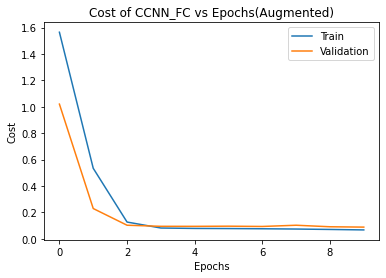

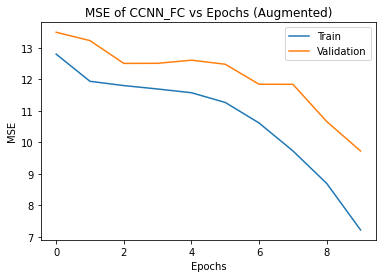

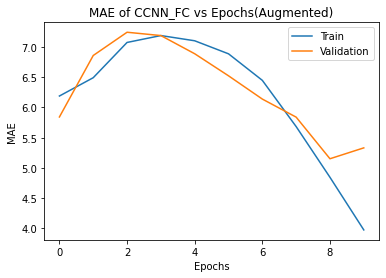

In [ ]:
plot_cost, plot_mse,plot_mae = 1, 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of CCNN_FC vs Epochs(Augmented)")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mse:
    plt.plot(MSE_train)
    plt.plot(MSE_validation)
    plt.title("MSE of CCNN_FC vs Epochs (Augmented)")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mae:
    plt.plot(MAE_train)
    
    plt.plot(MAE_validation)
    plt.title("MAE of CCNN_FC vs Epochs(Augmented)")
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/CountNet_FC.pth'
torch.save(Net.state_dict(), PATH)

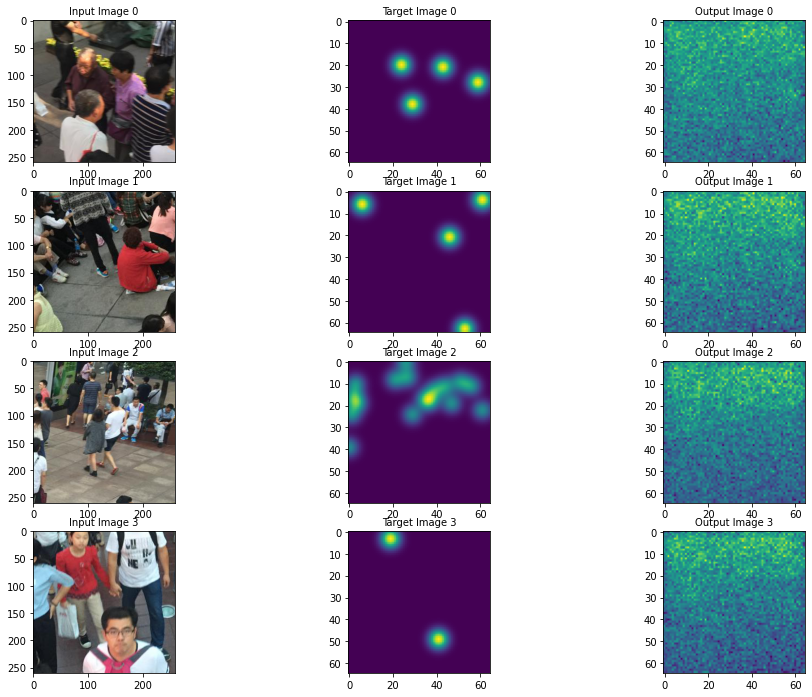

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

test_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

test_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/'

test_set =  ShanghaiTech_Dataset(test_names,test_data_folder,test_labels_folder )
test_generator = torch.utils.data.DataLoader(test_set, **params) 

PATH = '/content/drive/My Drive/CountNet_FC.pth'
net = CountNet_FC()
net.load_state_dict(torch.load(PATH))

dataiter = iter(test_generator)
images, labels = dataiter.next()

#print(images.shape,labels.shape)
outputs = net(images)
#print(outputs.shape)
test_set.test_network(images, outputs.view(-1,1,65,65), labels)



In [ ]:
# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])


mse = nn.MSELoss()
mae = nn.L1Loss()

running_testloss, running_test_mse, running_test_mae = 0.0, 0.0 , 0.0
test_cnt = 0

# test
with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        test_loss = Euclidean_regression_loss(batch_outputs.squeeze().view(-1,65,65), batch_labels)

        running_testloss += test_loss.item()
        running_loss += test_loss.item()
    
        a = torch.sqrt(mse(torch.sum(batch_outputs.squeeze().view(-1,65,65), dim = [1,2]), torch.sum(batch_labels, dim = [1,2])))
        running_test_mse += a
        running_mse += a

        b = mae(torch.sum(batch_outputs.squeeze().view(-1,65,65), dim = [1,2]), torch.sum(batch_labels, dim = [1,2]))
        running_test_mae += b
        running_mae += b

        if val_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 10 ))
          print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 10 ))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

        test_cnt += 1
        

test_losses = running_testloss / test_cnt

MSE_test =  running_test_mse / test_cnt

MAE_test =running_test_mae / test_cnt







  0%|          | 0/565 [00:00<?, ?it/s]





  0%|          | 1/565 [00:00<04:57,  1.90it/s]





  0%|          | 2/565 [00:00<03:56,  2.38it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.085062
MSE of Validation data after 10 iterations in epoch 10 : 9.829425
MAE of Validation data after 10 iterations in epoch 10 : 5.426187
Cost of Validation data after 10 iterations in epoch 10 : 0.003390
MSE of Validation data after 10 iterations in epoch 10 : 0.425823
MAE of Validation data after 10 iterations in epoch 10 : 0.319146








  1%|          | 3/565 [00:00<03:10,  2.95it/s]





  1%|          | 4/565 [00:00<02:35,  3.60it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.015387
MSE of Validation data after 10 iterations in epoch 10 : 1.160359
MAE of Validation data after 10 iterations in epoch 10 : 0.930205
Cost of Validation data after 10 iterations in epoch 10 : 0.001598
MSE of Validation data after 10 iterations in epoch 10 : 0.430081
MAE of Validation data after 10 iterations in epoch 10 : 0.419275








  1%|          | 5/565 [00:01<02:10,  4.28it/s]





  1%|          | 6/565 [00:01<01:51,  5.03it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004111
MSE of Validation data after 10 iterations in epoch 10 : 0.263049
MAE of Validation data after 10 iterations in epoch 10 : 0.229222
Cost of Validation data after 10 iterations in epoch 10 : 0.002430
MSE of Validation data after 10 iterations in epoch 10 : 0.308579
MAE of Validation data after 10 iterations in epoch 10 : 0.302077








  1%|          | 7/565 [00:01<01:37,  5.74it/s]





  1%|▏         | 8/565 [00:01<01:27,  6.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.007965
MSE of Validation data after 10 iterations in epoch 10 : 0.199676
MAE of Validation data after 10 iterations in epoch 10 : 0.179472
Cost of Validation data after 10 iterations in epoch 10 : 0.034532
MSE of Validation data after 10 iterations in epoch 10 : 1.908831
MAE of Validation data after 10 iterations in epoch 10 : 1.127232








  2%|▏         | 9/565 [00:01<01:21,  6.84it/s]





  2%|▏         | 10/565 [00:01<01:16,  7.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003220
MSE of Validation data after 10 iterations in epoch 10 : 0.371825
MAE of Validation data after 10 iterations in epoch 10 : 0.343617
Cost of Validation data after 10 iterations in epoch 10 : 0.004511
MSE of Validation data after 10 iterations in epoch 10 : 0.362176
MAE of Validation data after 10 iterations in epoch 10 : 0.291308








  2%|▏         | 11/565 [00:01<01:12,  7.62it/s]





  2%|▏         | 12/565 [00:01<01:10,  7.81it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001893
MSE of Validation data after 10 iterations in epoch 10 : 0.434155
MAE of Validation data after 10 iterations in epoch 10 : 0.376038
Cost of Validation data after 10 iterations in epoch 10 : 0.004898
MSE of Validation data after 10 iterations in epoch 10 : 0.640849
MAE of Validation data after 10 iterations in epoch 10 : 0.559516








  2%|▏         | 13/565 [00:02<01:09,  8.00it/s]





  2%|▏         | 14/565 [00:02<01:07,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001367
MSE of Validation data after 10 iterations in epoch 10 : 0.606869
MAE of Validation data after 10 iterations in epoch 10 : 0.436541
Cost of Validation data after 10 iterations in epoch 10 : 0.002827
MSE of Validation data after 10 iterations in epoch 10 : 0.368332
MAE of Validation data after 10 iterations in epoch 10 : 0.345349








  3%|▎         | 15/565 [00:02<01:06,  8.24it/s]





  3%|▎         | 16/565 [00:02<01:06,  8.23it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002808
MSE of Validation data after 10 iterations in epoch 10 : 0.458798
MAE of Validation data after 10 iterations in epoch 10 : 0.401731
Cost of Validation data after 10 iterations in epoch 10 : 0.002601
MSE of Validation data after 10 iterations in epoch 10 : 0.233701
MAE of Validation data after 10 iterations in epoch 10 : 0.163414








  3%|▎         | 17/565 [00:02<01:06,  8.24it/s]





  3%|▎         | 18/565 [00:02<01:05,  8.32it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005152
MSE of Validation data after 10 iterations in epoch 10 : 0.510379
MAE of Validation data after 10 iterations in epoch 10 : 0.452788
Cost of Validation data after 10 iterations in epoch 10 : 0.003537
MSE of Validation data after 10 iterations in epoch 10 : 0.432955
MAE of Validation data after 10 iterations in epoch 10 : 0.402030








  3%|▎         | 19/565 [00:02<01:05,  8.35it/s]





  4%|▎         | 20/565 [00:02<01:05,  8.37it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002380
MSE of Validation data after 10 iterations in epoch 10 : 0.567703
MAE of Validation data after 10 iterations in epoch 10 : 0.489736
Cost of Validation data after 10 iterations in epoch 10 : 0.004128
MSE of Validation data after 10 iterations in epoch 10 : 0.418476
MAE of Validation data after 10 iterations in epoch 10 : 0.394737








  4%|▎         | 21/565 [00:03<01:05,  8.33it/s]





  4%|▍         | 22/565 [00:03<01:06,  8.19it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004309
MSE of Validation data after 10 iterations in epoch 10 : 0.629989
MAE of Validation data after 10 iterations in epoch 10 : 0.571529
Cost of Validation data after 10 iterations in epoch 10 : 0.002679
MSE of Validation data after 10 iterations in epoch 10 : 0.461269
MAE of Validation data after 10 iterations in epoch 10 : 0.382462








  4%|▍         | 23/565 [00:03<01:07,  8.06it/s]





  4%|▍         | 24/565 [00:03<01:06,  8.14it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003760
MSE of Validation data after 10 iterations in epoch 10 : 0.696877
MAE of Validation data after 10 iterations in epoch 10 : 0.553995
Cost of Validation data after 10 iterations in epoch 10 : 0.013396
MSE of Validation data after 10 iterations in epoch 10 : 1.439102
MAE of Validation data after 10 iterations in epoch 10 : 0.843303








  4%|▍         | 25/565 [00:03<01:06,  8.08it/s]





  5%|▍         | 26/565 [00:03<01:06,  8.14it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001635
MSE of Validation data after 10 iterations in epoch 10 : 0.280731
MAE of Validation data after 10 iterations in epoch 10 : 0.239201
Cost of Validation data after 10 iterations in epoch 10 : 0.000903
MSE of Validation data after 10 iterations in epoch 10 : 0.205629
MAE of Validation data after 10 iterations in epoch 10 : 0.180393








  5%|▍         | 27/565 [00:03<01:05,  8.21it/s]





  5%|▍         | 28/565 [00:03<01:04,  8.34it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004638
MSE of Validation data after 10 iterations in epoch 10 : 0.433747
MAE of Validation data after 10 iterations in epoch 10 : 0.427078
Cost of Validation data after 10 iterations in epoch 10 : 0.045173
MSE of Validation data after 10 iterations in epoch 10 : 1.724417
MAE of Validation data after 10 iterations in epoch 10 : 1.230782








  5%|▌         | 29/565 [00:03<01:04,  8.29it/s]





  5%|▌         | 30/565 [00:04<01:04,  8.34it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003409
MSE of Validation data after 10 iterations in epoch 10 : 0.694605
MAE of Validation data after 10 iterations in epoch 10 : 0.673205
Cost of Validation data after 10 iterations in epoch 10 : 0.001500
MSE of Validation data after 10 iterations in epoch 10 : 0.396122
MAE of Validation data after 10 iterations in epoch 10 : 0.386977








  5%|▌         | 31/565 [00:04<01:04,  8.32it/s]





  6%|▌         | 32/565 [00:04<01:03,  8.38it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001320
MSE of Validation data after 10 iterations in epoch 10 : 0.411349
MAE of Validation data after 10 iterations in epoch 10 : 0.379677
Cost of Validation data after 10 iterations in epoch 10 : 0.001815
MSE of Validation data after 10 iterations in epoch 10 : 0.513352
MAE of Validation data after 10 iterations in epoch 10 : 0.421634








  6%|▌         | 33/565 [00:04<01:03,  8.38it/s]





  6%|▌         | 34/565 [00:04<01:03,  8.37it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003324
MSE of Validation data after 10 iterations in epoch 10 : 0.533908
MAE of Validation data after 10 iterations in epoch 10 : 0.459623
Cost of Validation data after 10 iterations in epoch 10 : 0.005563
MSE of Validation data after 10 iterations in epoch 10 : 0.536330
MAE of Validation data after 10 iterations in epoch 10 : 0.461757








  6%|▌         | 35/565 [00:04<01:03,  8.35it/s]





  6%|▋         | 36/565 [00:04<01:03,  8.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002831
MSE of Validation data after 10 iterations in epoch 10 : 0.624112
MAE of Validation data after 10 iterations in epoch 10 : 0.539646
Cost of Validation data after 10 iterations in epoch 10 : 0.004823
MSE of Validation data after 10 iterations in epoch 10 : 0.433242
MAE of Validation data after 10 iterations in epoch 10 : 0.419889








  7%|▋         | 37/565 [00:04<01:03,  8.35it/s]





  7%|▋         | 38/565 [00:05<01:02,  8.46it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008310
MSE of Validation data after 10 iterations in epoch 10 : 0.869499
MAE of Validation data after 10 iterations in epoch 10 : 0.584101
Cost of Validation data after 10 iterations in epoch 10 : 0.001226
MSE of Validation data after 10 iterations in epoch 10 : 0.384043
MAE of Validation data after 10 iterations in epoch 10 : 0.350623








  7%|▋         | 39/565 [00:05<01:02,  8.42it/s]





  7%|▋         | 40/565 [00:05<01:01,  8.47it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002779
MSE of Validation data after 10 iterations in epoch 10 : 0.593302
MAE of Validation data after 10 iterations in epoch 10 : 0.517496
Cost of Validation data after 10 iterations in epoch 10 : 0.003503
MSE of Validation data after 10 iterations in epoch 10 : 0.463961
MAE of Validation data after 10 iterations in epoch 10 : 0.396423








  7%|▋         | 41/565 [00:05<01:02,  8.37it/s]





  7%|▋         | 42/565 [00:05<01:02,  8.33it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002209
MSE of Validation data after 10 iterations in epoch 10 : 0.406933
MAE of Validation data after 10 iterations in epoch 10 : 0.374292
Cost of Validation data after 10 iterations in epoch 10 : 0.006397
MSE of Validation data after 10 iterations in epoch 10 : 0.582813
MAE of Validation data after 10 iterations in epoch 10 : 0.508128








  8%|▊         | 43/565 [00:05<01:03,  8.22it/s]





  8%|▊         | 44/565 [00:05<01:02,  8.28it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004513
MSE of Validation data after 10 iterations in epoch 10 : 0.893558
MAE of Validation data after 10 iterations in epoch 10 : 0.715189
Cost of Validation data after 10 iterations in epoch 10 : 0.002817
MSE of Validation data after 10 iterations in epoch 10 : 0.536726
MAE of Validation data after 10 iterations in epoch 10 : 0.435607








  8%|▊         | 45/565 [00:05<01:02,  8.30it/s]





  8%|▊         | 46/565 [00:06<01:02,  8.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004105
MSE of Validation data after 10 iterations in epoch 10 : 0.318612
MAE of Validation data after 10 iterations in epoch 10 : 0.245157
Cost of Validation data after 10 iterations in epoch 10 : 0.006771
MSE of Validation data after 10 iterations in epoch 10 : 0.392587
MAE of Validation data after 10 iterations in epoch 10 : 0.361934








  8%|▊         | 47/565 [00:06<01:02,  8.35it/s]





  8%|▊         | 48/565 [00:06<01:02,  8.24it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006593
MSE of Validation data after 10 iterations in epoch 10 : 0.724029
MAE of Validation data after 10 iterations in epoch 10 : 0.600484
Cost of Validation data after 10 iterations in epoch 10 : 0.005630
MSE of Validation data after 10 iterations in epoch 10 : 0.326992
MAE of Validation data after 10 iterations in epoch 10 : 0.275254








  9%|▊         | 49/565 [00:06<01:02,  8.32it/s]





  9%|▉         | 50/565 [00:06<01:01,  8.34it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001120
MSE of Validation data after 10 iterations in epoch 10 : 0.321786
MAE of Validation data after 10 iterations in epoch 10 : 0.320295
Cost of Validation data after 10 iterations in epoch 10 : 0.002583
MSE of Validation data after 10 iterations in epoch 10 : 0.417369
MAE of Validation data after 10 iterations in epoch 10 : 0.336981








  9%|▉         | 51/565 [00:06<01:01,  8.30it/s]





  9%|▉         | 52/565 [00:06<01:02,  8.22it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.016126
MSE of Validation data after 10 iterations in epoch 10 : 1.478328
MAE of Validation data after 10 iterations in epoch 10 : 0.951028
Cost of Validation data after 10 iterations in epoch 10 : 0.003245
MSE of Validation data after 10 iterations in epoch 10 : 0.367450
MAE of Validation data after 10 iterations in epoch 10 : 0.344228








  9%|▉         | 53/565 [00:06<01:01,  8.29it/s]





 10%|▉         | 54/565 [00:06<01:01,  8.31it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008676
MSE of Validation data after 10 iterations in epoch 10 : 0.429038
MAE of Validation data after 10 iterations in epoch 10 : 0.328243
Cost of Validation data after 10 iterations in epoch 10 : 0.003017
MSE of Validation data after 10 iterations in epoch 10 : 0.531038
MAE of Validation data after 10 iterations in epoch 10 : 0.460331








 10%|▉         | 55/565 [00:07<01:01,  8.29it/s]





 10%|▉         | 56/565 [00:07<01:01,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003023
MSE of Validation data after 10 iterations in epoch 10 : 0.492351
MAE of Validation data after 10 iterations in epoch 10 : 0.451205
Cost of Validation data after 10 iterations in epoch 10 : 0.002530
MSE of Validation data after 10 iterations in epoch 10 : 0.383824
MAE of Validation data after 10 iterations in epoch 10 : 0.362193








 10%|█         | 57/565 [00:07<01:01,  8.29it/s]





 10%|█         | 58/565 [00:07<01:01,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002488
MSE of Validation data after 10 iterations in epoch 10 : 0.375532
MAE of Validation data after 10 iterations in epoch 10 : 0.358643
Cost of Validation data after 10 iterations in epoch 10 : 0.005359
MSE of Validation data after 10 iterations in epoch 10 : 0.454691
MAE of Validation data after 10 iterations in epoch 10 : 0.416746








 10%|█         | 59/565 [00:07<01:01,  8.27it/s]





 11%|█         | 60/565 [00:07<01:00,  8.29it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003237
MSE of Validation data after 10 iterations in epoch 10 : 0.316700
MAE of Validation data after 10 iterations in epoch 10 : 0.280555
Cost of Validation data after 10 iterations in epoch 10 : 0.001806
MSE of Validation data after 10 iterations in epoch 10 : 0.325061
MAE of Validation data after 10 iterations in epoch 10 : 0.246617








 11%|█         | 61/565 [00:07<01:00,  8.26it/s]





 11%|█         | 62/565 [00:07<01:00,  8.26it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001895
MSE of Validation data after 10 iterations in epoch 10 : 0.551169
MAE of Validation data after 10 iterations in epoch 10 : 0.501267
Cost of Validation data after 10 iterations in epoch 10 : 0.001735
MSE of Validation data after 10 iterations in epoch 10 : 0.221187
MAE of Validation data after 10 iterations in epoch 10 : 0.203212








 11%|█         | 63/565 [00:08<00:59,  8.37it/s]





 11%|█▏        | 64/565 [00:08<00:59,  8.46it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002329
MSE of Validation data after 10 iterations in epoch 10 : 0.208463
MAE of Validation data after 10 iterations in epoch 10 : 0.155568
Cost of Validation data after 10 iterations in epoch 10 : 0.001082
MSE of Validation data after 10 iterations in epoch 10 : 0.494106
MAE of Validation data after 10 iterations in epoch 10 : 0.468778








 12%|█▏        | 65/565 [00:08<01:00,  8.27it/s]





 12%|█▏        | 66/565 [00:08<01:00,  8.26it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001211
MSE of Validation data after 10 iterations in epoch 10 : 0.399907
MAE of Validation data after 10 iterations in epoch 10 : 0.379402
Cost of Validation data after 10 iterations in epoch 10 : 0.000423
MSE of Validation data after 10 iterations in epoch 10 : 0.303380
MAE of Validation data after 10 iterations in epoch 10 : 0.291628








 12%|█▏        | 67/565 [00:08<01:00,  8.28it/s]





 12%|█▏        | 68/565 [00:08<00:59,  8.36it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005444
MSE of Validation data after 10 iterations in epoch 10 : 0.685649
MAE of Validation data after 10 iterations in epoch 10 : 0.584636
Cost of Validation data after 10 iterations in epoch 10 : 0.000494
MSE of Validation data after 10 iterations in epoch 10 : 0.412800
MAE of Validation data after 10 iterations in epoch 10 : 0.369150








 12%|█▏        | 69/565 [00:08<01:00,  8.20it/s]





 12%|█▏        | 70/565 [00:08<00:59,  8.33it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002319
MSE of Validation data after 10 iterations in epoch 10 : 0.420386
MAE of Validation data after 10 iterations in epoch 10 : 0.395726
Cost of Validation data after 10 iterations in epoch 10 : 0.006448
MSE of Validation data after 10 iterations in epoch 10 : 0.390278
MAE of Validation data after 10 iterations in epoch 10 : 0.327477








 13%|█▎        | 71/565 [00:09<01:00,  8.23it/s]





 13%|█▎        | 72/565 [00:09<01:00,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001975
MSE of Validation data after 10 iterations in epoch 10 : 0.347247
MAE of Validation data after 10 iterations in epoch 10 : 0.295468
Cost of Validation data after 10 iterations in epoch 10 : 0.000433
MSE of Validation data after 10 iterations in epoch 10 : 0.197601
MAE of Validation data after 10 iterations in epoch 10 : 0.193599








 13%|█▎        | 73/565 [00:09<01:00,  8.19it/s]





 13%|█▎        | 74/565 [00:09<00:59,  8.20it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001186
MSE of Validation data after 10 iterations in epoch 10 : 0.557577
MAE of Validation data after 10 iterations in epoch 10 : 0.469653
Cost of Validation data after 10 iterations in epoch 10 : 0.002339
MSE of Validation data after 10 iterations in epoch 10 : 0.561785
MAE of Validation data after 10 iterations in epoch 10 : 0.399796








 13%|█▎        | 75/565 [00:09<00:59,  8.26it/s]





 13%|█▎        | 76/565 [00:09<00:59,  8.16it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001917
MSE of Validation data after 10 iterations in epoch 10 : 0.391264
MAE of Validation data after 10 iterations in epoch 10 : 0.308827
Cost of Validation data after 10 iterations in epoch 10 : 0.002638
MSE of Validation data after 10 iterations in epoch 10 : 0.439720
MAE of Validation data after 10 iterations in epoch 10 : 0.395419








 14%|█▎        | 77/565 [00:09<00:59,  8.19it/s]





 14%|█▍        | 78/565 [00:09<00:58,  8.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003217
MSE of Validation data after 10 iterations in epoch 10 : 0.194252
MAE of Validation data after 10 iterations in epoch 10 : 0.191567
Cost of Validation data after 10 iterations in epoch 10 : 0.002390
MSE of Validation data after 10 iterations in epoch 10 : 0.495974
MAE of Validation data after 10 iterations in epoch 10 : 0.446038








 14%|█▍        | 79/565 [00:10<00:58,  8.30it/s]





 14%|█▍        | 80/565 [00:10<00:59,  8.18it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001711
MSE of Validation data after 10 iterations in epoch 10 : 0.293801
MAE of Validation data after 10 iterations in epoch 10 : 0.288940
Cost of Validation data after 10 iterations in epoch 10 : 0.001572
MSE of Validation data after 10 iterations in epoch 10 : 0.606882
MAE of Validation data after 10 iterations in epoch 10 : 0.540856








 14%|█▍        | 81/565 [00:10<00:59,  8.13it/s]





 15%|█▍        | 82/565 [00:10<00:59,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.013445
MSE of Validation data after 10 iterations in epoch 10 : 0.830143
MAE of Validation data after 10 iterations in epoch 10 : 0.689343
Cost of Validation data after 10 iterations in epoch 10 : 0.037445
MSE of Validation data after 10 iterations in epoch 10 : 1.853745
MAE of Validation data after 10 iterations in epoch 10 : 1.363572








 15%|█▍        | 83/565 [00:10<00:58,  8.18it/s]





 15%|█▍        | 84/565 [00:10<00:58,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001812
MSE of Validation data after 10 iterations in epoch 10 : 0.371747
MAE of Validation data after 10 iterations in epoch 10 : 0.323223
Cost of Validation data after 10 iterations in epoch 10 : 0.004944
MSE of Validation data after 10 iterations in epoch 10 : 0.515904
MAE of Validation data after 10 iterations in epoch 10 : 0.397909








 15%|█▌        | 85/565 [00:10<00:58,  8.21it/s]





 15%|█▌        | 86/565 [00:10<00:57,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.079182
MSE of Validation data after 10 iterations in epoch 10 : 3.193323
MAE of Validation data after 10 iterations in epoch 10 : 1.701303
Cost of Validation data after 10 iterations in epoch 10 : 0.011320
MSE of Validation data after 10 iterations in epoch 10 : 0.740369
MAE of Validation data after 10 iterations in epoch 10 : 0.679140








 15%|█▌        | 87/565 [00:10<00:57,  8.30it/s]





 16%|█▌        | 88/565 [00:11<00:57,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002123
MSE of Validation data after 10 iterations in epoch 10 : 0.670847
MAE of Validation data after 10 iterations in epoch 10 : 0.535330
Cost of Validation data after 10 iterations in epoch 10 : 0.003747
MSE of Validation data after 10 iterations in epoch 10 : 0.570417
MAE of Validation data after 10 iterations in epoch 10 : 0.554920








 16%|█▌        | 89/565 [00:11<00:57,  8.26it/s]





 16%|█▌        | 90/565 [00:11<00:57,  8.19it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003816
MSE of Validation data after 10 iterations in epoch 10 : 0.488862
MAE of Validation data after 10 iterations in epoch 10 : 0.385943
Cost of Validation data after 10 iterations in epoch 10 : 0.002554
MSE of Validation data after 10 iterations in epoch 10 : 0.373437
MAE of Validation data after 10 iterations in epoch 10 : 0.362215








 16%|█▌        | 91/565 [00:11<00:57,  8.19it/s]





 16%|█▋        | 92/565 [00:11<00:56,  8.34it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.014037
MSE of Validation data after 10 iterations in epoch 10 : 1.053855
MAE of Validation data after 10 iterations in epoch 10 : 0.660889
Cost of Validation data after 10 iterations in epoch 10 : 0.007075
MSE of Validation data after 10 iterations in epoch 10 : 0.993148
MAE of Validation data after 10 iterations in epoch 10 : 0.862110








 16%|█▋        | 93/565 [00:11<00:56,  8.31it/s]





 17%|█▋        | 94/565 [00:11<00:56,  8.38it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001695
MSE of Validation data after 10 iterations in epoch 10 : 0.509716
MAE of Validation data after 10 iterations in epoch 10 : 0.441086
Cost of Validation data after 10 iterations in epoch 10 : 0.002575
MSE of Validation data after 10 iterations in epoch 10 : 0.308451
MAE of Validation data after 10 iterations in epoch 10 : 0.288320








 17%|█▋        | 95/565 [00:11<00:55,  8.41it/s]





 17%|█▋        | 96/565 [00:12<00:55,  8.39it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003651
MSE of Validation data after 10 iterations in epoch 10 : 0.214228
MAE of Validation data after 10 iterations in epoch 10 : 0.199946
Cost of Validation data after 10 iterations in epoch 10 : 0.007409
MSE of Validation data after 10 iterations in epoch 10 : 0.977657
MAE of Validation data after 10 iterations in epoch 10 : 0.619689








 17%|█▋        | 97/565 [00:12<00:55,  8.42it/s]





 17%|█▋        | 98/565 [00:12<00:56,  8.31it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005757
MSE of Validation data after 10 iterations in epoch 10 : 0.544116
MAE of Validation data after 10 iterations in epoch 10 : 0.438359
Cost of Validation data after 10 iterations in epoch 10 : 0.004047
MSE of Validation data after 10 iterations in epoch 10 : 0.454736
MAE of Validation data after 10 iterations in epoch 10 : 0.401563








 18%|█▊        | 99/565 [00:12<00:55,  8.36it/s]





 18%|█▊        | 100/565 [00:12<00:55,  8.33it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001404
MSE of Validation data after 10 iterations in epoch 10 : 0.357113
MAE of Validation data after 10 iterations in epoch 10 : 0.292210
Cost of Validation data after 10 iterations in epoch 10 : 0.001480
MSE of Validation data after 10 iterations in epoch 10 : 0.367146
MAE of Validation data after 10 iterations in epoch 10 : 0.335682








 18%|█▊        | 101/565 [00:12<00:55,  8.35it/s]





 18%|█▊        | 102/565 [00:12<00:56,  8.25it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001832
MSE of Validation data after 10 iterations in epoch 10 : 0.522870
MAE of Validation data after 10 iterations in epoch 10 : 0.487538
Cost of Validation data after 10 iterations in epoch 10 : 0.001911
MSE of Validation data after 10 iterations in epoch 10 : 0.322819
MAE of Validation data after 10 iterations in epoch 10 : 0.301815








 18%|█▊        | 103/565 [00:12<00:55,  8.29it/s]





 18%|█▊        | 104/565 [00:13<00:55,  8.28it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001074
MSE of Validation data after 10 iterations in epoch 10 : 0.188319
MAE of Validation data after 10 iterations in epoch 10 : 0.180191
Cost of Validation data after 10 iterations in epoch 10 : 0.001609
MSE of Validation data after 10 iterations in epoch 10 : 0.287967
MAE of Validation data after 10 iterations in epoch 10 : 0.275213








 19%|█▊        | 105/565 [00:13<00:55,  8.22it/s]





 19%|█▉        | 106/565 [00:13<00:56,  8.18it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.012219
MSE of Validation data after 10 iterations in epoch 10 : 0.939333
MAE of Validation data after 10 iterations in epoch 10 : 0.772550
Cost of Validation data after 10 iterations in epoch 10 : 0.000625
MSE of Validation data after 10 iterations in epoch 10 : 0.395387
MAE of Validation data after 10 iterations in epoch 10 : 0.388276








 19%|█▉        | 107/565 [00:13<00:55,  8.20it/s]





 19%|█▉        | 108/565 [00:13<00:56,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.090895
MSE of Validation data after 10 iterations in epoch 10 : 2.800439
MAE of Validation data after 10 iterations in epoch 10 : 1.602205
Cost of Validation data after 10 iterations in epoch 10 : 0.000814
MSE of Validation data after 10 iterations in epoch 10 : 0.479907
MAE of Validation data after 10 iterations in epoch 10 : 0.407854








 19%|█▉        | 109/565 [00:13<00:56,  8.11it/s]





 19%|█▉        | 110/565 [00:13<00:55,  8.19it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.045685
MSE of Validation data after 10 iterations in epoch 10 : 1.652908
MAE of Validation data after 10 iterations in epoch 10 : 1.315130
Cost of Validation data after 10 iterations in epoch 10 : 0.001620
MSE of Validation data after 10 iterations in epoch 10 : 0.738221
MAE of Validation data after 10 iterations in epoch 10 : 0.651303








 20%|█▉        | 111/565 [00:13<00:56,  8.09it/s]





 20%|█▉        | 112/565 [00:14<00:55,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.012210
MSE of Validation data after 10 iterations in epoch 10 : 0.789133
MAE of Validation data after 10 iterations in epoch 10 : 0.620542
Cost of Validation data after 10 iterations in epoch 10 : 0.007308
MSE of Validation data after 10 iterations in epoch 10 : 0.997688
MAE of Validation data after 10 iterations in epoch 10 : 0.567991








 20%|██        | 113/565 [00:14<00:56,  7.99it/s]





 20%|██        | 114/565 [00:14<00:55,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002851
MSE of Validation data after 10 iterations in epoch 10 : 0.505698
MAE of Validation data after 10 iterations in epoch 10 : 0.468697
Cost of Validation data after 10 iterations in epoch 10 : 0.001921
MSE of Validation data after 10 iterations in epoch 10 : 0.329456
MAE of Validation data after 10 iterations in epoch 10 : 0.297325








 20%|██        | 115/565 [00:14<00:55,  8.18it/s]





 21%|██        | 116/565 [00:14<00:54,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.007729
MSE of Validation data after 10 iterations in epoch 10 : 0.776776
MAE of Validation data after 10 iterations in epoch 10 : 0.662727
Cost of Validation data after 10 iterations in epoch 10 : 0.000871
MSE of Validation data after 10 iterations in epoch 10 : 0.347773
MAE of Validation data after 10 iterations in epoch 10 : 0.341665








 21%|██        | 117/565 [00:14<00:55,  8.07it/s]





 21%|██        | 118/565 [00:14<00:55,  8.03it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001287
MSE of Validation data after 10 iterations in epoch 10 : 0.338715
MAE of Validation data after 10 iterations in epoch 10 : 0.292917
Cost of Validation data after 10 iterations in epoch 10 : 0.002641
MSE of Validation data after 10 iterations in epoch 10 : 0.301993
MAE of Validation data after 10 iterations in epoch 10 : 0.254271








 21%|██        | 119/565 [00:14<00:55,  8.11it/s]





 21%|██        | 120/565 [00:15<00:54,  8.20it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001853
MSE of Validation data after 10 iterations in epoch 10 : 0.481120
MAE of Validation data after 10 iterations in epoch 10 : 0.429074
Cost of Validation data after 10 iterations in epoch 10 : 0.000669
MSE of Validation data after 10 iterations in epoch 10 : 0.419171
MAE of Validation data after 10 iterations in epoch 10 : 0.388915








 21%|██▏       | 121/565 [00:15<00:54,  8.19it/s]





 22%|██▏       | 122/565 [00:15<00:53,  8.32it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003885
MSE of Validation data after 10 iterations in epoch 10 : 0.474092
MAE of Validation data after 10 iterations in epoch 10 : 0.453163
Cost of Validation data after 10 iterations in epoch 10 : 0.021892
MSE of Validation data after 10 iterations in epoch 10 : 1.628538
MAE of Validation data after 10 iterations in epoch 10 : 1.202242








 22%|██▏       | 123/565 [00:15<00:53,  8.24it/s]





 22%|██▏       | 124/565 [00:15<00:54,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003040
MSE of Validation data after 10 iterations in epoch 10 : 0.791072
MAE of Validation data after 10 iterations in epoch 10 : 0.745117
Cost of Validation data after 10 iterations in epoch 10 : 0.006151
MSE of Validation data after 10 iterations in epoch 10 : 0.548421
MAE of Validation data after 10 iterations in epoch 10 : 0.472398








 22%|██▏       | 125/565 [00:15<00:53,  8.20it/s]





 22%|██▏       | 126/565 [00:15<00:53,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.010566
MSE of Validation data after 10 iterations in epoch 10 : 0.939809
MAE of Validation data after 10 iterations in epoch 10 : 0.810865
Cost of Validation data after 10 iterations in epoch 10 : 0.003727
MSE of Validation data after 10 iterations in epoch 10 : 0.875301
MAE of Validation data after 10 iterations in epoch 10 : 0.720913








 22%|██▏       | 127/565 [00:15<00:53,  8.17it/s]





 23%|██▎       | 128/565 [00:15<00:53,  8.14it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004269
MSE of Validation data after 10 iterations in epoch 10 : 0.693784
MAE of Validation data after 10 iterations in epoch 10 : 0.667726
Cost of Validation data after 10 iterations in epoch 10 : 0.001231
MSE of Validation data after 10 iterations in epoch 10 : 0.374445
MAE of Validation data after 10 iterations in epoch 10 : 0.293707








 23%|██▎       | 129/565 [00:16<00:53,  8.14it/s]





 23%|██▎       | 130/565 [00:16<00:53,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002825
MSE of Validation data after 10 iterations in epoch 10 : 0.379119
MAE of Validation data after 10 iterations in epoch 10 : 0.340818
Cost of Validation data after 10 iterations in epoch 10 : 0.001153
MSE of Validation data after 10 iterations in epoch 10 : 0.228116
MAE of Validation data after 10 iterations in epoch 10 : 0.205994








 23%|██▎       | 131/565 [00:16<00:53,  8.14it/s]





 23%|██▎       | 132/565 [00:16<00:52,  8.18it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001048
MSE of Validation data after 10 iterations in epoch 10 : 0.304090
MAE of Validation data after 10 iterations in epoch 10 : 0.290704
Cost of Validation data after 10 iterations in epoch 10 : 0.011989
MSE of Validation data after 10 iterations in epoch 10 : 1.112438
MAE of Validation data after 10 iterations in epoch 10 : 0.766692








 24%|██▎       | 133/565 [00:16<00:53,  8.13it/s]





 24%|██▎       | 134/565 [00:16<00:53,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005775
MSE of Validation data after 10 iterations in epoch 10 : 0.670997
MAE of Validation data after 10 iterations in epoch 10 : 0.625481
Cost of Validation data after 10 iterations in epoch 10 : 0.018636
MSE of Validation data after 10 iterations in epoch 10 : 0.605182
MAE of Validation data after 10 iterations in epoch 10 : 0.441191








 24%|██▍       | 135/565 [00:16<00:52,  8.15it/s]





 24%|██▍       | 136/565 [00:16<00:51,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.018483
MSE of Validation data after 10 iterations in epoch 10 : 1.847052
MAE of Validation data after 10 iterations in epoch 10 : 1.274459
Cost of Validation data after 10 iterations in epoch 10 : 0.000785
MSE of Validation data after 10 iterations in epoch 10 : 0.373625
MAE of Validation data after 10 iterations in epoch 10 : 0.359556








 24%|██▍       | 137/565 [00:17<00:52,  8.17it/s]





 24%|██▍       | 138/565 [00:17<00:52,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.011026
MSE of Validation data after 10 iterations in epoch 10 : 0.729976
MAE of Validation data after 10 iterations in epoch 10 : 0.708226
Cost of Validation data after 10 iterations in epoch 10 : 0.005354
MSE of Validation data after 10 iterations in epoch 10 : 0.489374
MAE of Validation data after 10 iterations in epoch 10 : 0.417434








 25%|██▍       | 139/565 [00:17<00:51,  8.31it/s]





 25%|██▍       | 140/565 [00:17<00:51,  8.18it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000842
MSE of Validation data after 10 iterations in epoch 10 : 0.372473
MAE of Validation data after 10 iterations in epoch 10 : 0.316660
Cost of Validation data after 10 iterations in epoch 10 : 0.001043
MSE of Validation data after 10 iterations in epoch 10 : 0.266725
MAE of Validation data after 10 iterations in epoch 10 : 0.255569








 25%|██▍       | 141/565 [00:17<00:52,  8.12it/s]





 25%|██▌       | 142/565 [00:17<00:52,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.029424
MSE of Validation data after 10 iterations in epoch 10 : 2.233257
MAE of Validation data after 10 iterations in epoch 10 : 1.358043
Cost of Validation data after 10 iterations in epoch 10 : 0.001655
MSE of Validation data after 10 iterations in epoch 10 : 0.485747
MAE of Validation data after 10 iterations in epoch 10 : 0.462088








 25%|██▌       | 143/565 [00:17<00:52,  8.07it/s]





 25%|██▌       | 144/565 [00:17<00:52,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005580
MSE of Validation data after 10 iterations in epoch 10 : 0.597628
MAE of Validation data after 10 iterations in epoch 10 : 0.514291
Cost of Validation data after 10 iterations in epoch 10 : 0.001111
MSE of Validation data after 10 iterations in epoch 10 : 0.347938
MAE of Validation data after 10 iterations in epoch 10 : 0.333139








 26%|██▌       | 145/565 [00:18<00:52,  8.02it/s]





 26%|██▌       | 146/565 [00:18<00:51,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003766
MSE of Validation data after 10 iterations in epoch 10 : 0.531355
MAE of Validation data after 10 iterations in epoch 10 : 0.401723
Cost of Validation data after 10 iterations in epoch 10 : 0.003102
MSE of Validation data after 10 iterations in epoch 10 : 0.465854
MAE of Validation data after 10 iterations in epoch 10 : 0.382622








 26%|██▌       | 147/565 [00:18<00:51,  8.10it/s]





 26%|██▌       | 148/565 [00:18<00:51,  8.10it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000604
MSE of Validation data after 10 iterations in epoch 10 : 0.306514
MAE of Validation data after 10 iterations in epoch 10 : 0.303109
Cost of Validation data after 10 iterations in epoch 10 : 0.002118
MSE of Validation data after 10 iterations in epoch 10 : 0.550098
MAE of Validation data after 10 iterations in epoch 10 : 0.535129








 26%|██▋       | 149/565 [00:18<00:51,  8.10it/s]





 27%|██▋       | 150/565 [00:18<00:51,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001237
MSE of Validation data after 10 iterations in epoch 10 : 0.406191
MAE of Validation data after 10 iterations in epoch 10 : 0.357658
Cost of Validation data after 10 iterations in epoch 10 : 0.005377
MSE of Validation data after 10 iterations in epoch 10 : 0.604659
MAE of Validation data after 10 iterations in epoch 10 : 0.451829








 27%|██▋       | 151/565 [00:18<00:51,  8.09it/s]





 27%|██▋       | 152/565 [00:18<00:50,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.049842
MSE of Validation data after 10 iterations in epoch 10 : 2.740500
MAE of Validation data after 10 iterations in epoch 10 : 2.274724
Cost of Validation data after 10 iterations in epoch 10 : 0.003727
MSE of Validation data after 10 iterations in epoch 10 : 0.219521
MAE of Validation data after 10 iterations in epoch 10 : 0.188063








 27%|██▋       | 153/565 [00:19<00:50,  8.13it/s]





 27%|██▋       | 154/565 [00:19<00:50,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002633
MSE of Validation data after 10 iterations in epoch 10 : 0.409467
MAE of Validation data after 10 iterations in epoch 10 : 0.358206
Cost of Validation data after 10 iterations in epoch 10 : 0.002742
MSE of Validation data after 10 iterations in epoch 10 : 0.494420
MAE of Validation data after 10 iterations in epoch 10 : 0.401561








 27%|██▋       | 155/565 [00:19<00:50,  8.07it/s]





 28%|██▊       | 156/565 [00:19<00:50,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001957
MSE of Validation data after 10 iterations in epoch 10 : 0.377936
MAE of Validation data after 10 iterations in epoch 10 : 0.359745
Cost of Validation data after 10 iterations in epoch 10 : 0.001153
MSE of Validation data after 10 iterations in epoch 10 : 0.372419
MAE of Validation data after 10 iterations in epoch 10 : 0.353425








 28%|██▊       | 157/565 [00:19<00:51,  7.96it/s]





 28%|██▊       | 158/565 [00:19<00:51,  7.93it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.149802
MSE of Validation data after 10 iterations in epoch 10 : 3.824599
MAE of Validation data after 10 iterations in epoch 10 : 2.144659
Cost of Validation data after 10 iterations in epoch 10 : 0.008451
MSE of Validation data after 10 iterations in epoch 10 : 0.745985
MAE of Validation data after 10 iterations in epoch 10 : 0.612803








 28%|██▊       | 159/565 [00:19<00:50,  7.99it/s]





 28%|██▊       | 160/565 [00:19<00:50,  7.99it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004961
MSE of Validation data after 10 iterations in epoch 10 : 0.389460
MAE of Validation data after 10 iterations in epoch 10 : 0.343447
Cost of Validation data after 10 iterations in epoch 10 : 0.004579
MSE of Validation data after 10 iterations in epoch 10 : 0.789742
MAE of Validation data after 10 iterations in epoch 10 : 0.687979








 28%|██▊       | 161/565 [00:20<00:50,  8.06it/s]





 29%|██▊       | 162/565 [00:20<00:49,  8.10it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008661
MSE of Validation data after 10 iterations in epoch 10 : 0.720340
MAE of Validation data after 10 iterations in epoch 10 : 0.533027
Cost of Validation data after 10 iterations in epoch 10 : 0.001304
MSE of Validation data after 10 iterations in epoch 10 : 0.427707
MAE of Validation data after 10 iterations in epoch 10 : 0.394044








 29%|██▉       | 163/565 [00:20<00:48,  8.25it/s]





 29%|██▉       | 164/565 [00:20<00:47,  8.36it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.044685
MSE of Validation data after 10 iterations in epoch 10 : 2.837188
MAE of Validation data after 10 iterations in epoch 10 : 1.975028
Cost of Validation data after 10 iterations in epoch 10 : 0.003651
MSE of Validation data after 10 iterations in epoch 10 : 0.678959
MAE of Validation data after 10 iterations in epoch 10 : 0.602731








 29%|██▉       | 165/565 [00:20<00:49,  8.13it/s]





 29%|██▉       | 166/565 [00:20<00:49,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.061606
MSE of Validation data after 10 iterations in epoch 10 : 4.378039
MAE of Validation data after 10 iterations in epoch 10 : 2.438668
Cost of Validation data after 10 iterations in epoch 10 : 0.002802
MSE of Validation data after 10 iterations in epoch 10 : 0.430152
MAE of Validation data after 10 iterations in epoch 10 : 0.335408








 30%|██▉       | 167/565 [00:20<00:50,  7.95it/s]





 30%|██▉       | 168/565 [00:20<00:50,  7.92it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001263
MSE of Validation data after 10 iterations in epoch 10 : 0.470436
MAE of Validation data after 10 iterations in epoch 10 : 0.425520
Cost of Validation data after 10 iterations in epoch 10 : 0.001027
MSE of Validation data after 10 iterations in epoch 10 : 0.360840
MAE of Validation data after 10 iterations in epoch 10 : 0.312540








 30%|██▉       | 169/565 [00:21<00:49,  7.96it/s]





 30%|███       | 170/565 [00:21<00:49,  7.91it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.059894
MSE of Validation data after 10 iterations in epoch 10 : 3.184642
MAE of Validation data after 10 iterations in epoch 10 : 1.916717
Cost of Validation data after 10 iterations in epoch 10 : 0.001721
MSE of Validation data after 10 iterations in epoch 10 : 0.533048
MAE of Validation data after 10 iterations in epoch 10 : 0.458254








 30%|███       | 171/565 [00:21<00:48,  8.06it/s]





 30%|███       | 172/565 [00:21<00:48,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000846
MSE of Validation data after 10 iterations in epoch 10 : 0.357781
MAE of Validation data after 10 iterations in epoch 10 : 0.337308
Cost of Validation data after 10 iterations in epoch 10 : 0.012505
MSE of Validation data after 10 iterations in epoch 10 : 1.021168
MAE of Validation data after 10 iterations in epoch 10 : 0.635465








 31%|███       | 173/565 [00:21<00:48,  8.15it/s]





 31%|███       | 174/565 [00:21<00:48,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001826
MSE of Validation data after 10 iterations in epoch 10 : 0.172174
MAE of Validation data after 10 iterations in epoch 10 : 0.165289
Cost of Validation data after 10 iterations in epoch 10 : 0.002783
MSE of Validation data after 10 iterations in epoch 10 : 0.423064
MAE of Validation data after 10 iterations in epoch 10 : 0.406316








 31%|███       | 175/565 [00:21<00:48,  8.02it/s]





 31%|███       | 176/565 [00:21<00:48,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000880
MSE of Validation data after 10 iterations in epoch 10 : 0.350625
MAE of Validation data after 10 iterations in epoch 10 : 0.334019
Cost of Validation data after 10 iterations in epoch 10 : 0.003498
MSE of Validation data after 10 iterations in epoch 10 : 0.530825
MAE of Validation data after 10 iterations in epoch 10 : 0.439618








 31%|███▏      | 177/565 [00:22<00:49,  7.90it/s]





 32%|███▏      | 178/565 [00:22<00:48,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000743
MSE of Validation data after 10 iterations in epoch 10 : 0.482758
MAE of Validation data after 10 iterations in epoch 10 : 0.420523
Cost of Validation data after 10 iterations in epoch 10 : 0.010125
MSE of Validation data after 10 iterations in epoch 10 : 1.224377
MAE of Validation data after 10 iterations in epoch 10 : 0.819332








 32%|███▏      | 179/565 [00:22<00:47,  8.08it/s]





 32%|███▏      | 180/565 [00:22<00:47,  8.03it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001142
MSE of Validation data after 10 iterations in epoch 10 : 0.198415
MAE of Validation data after 10 iterations in epoch 10 : 0.180988
Cost of Validation data after 10 iterations in epoch 10 : 0.001445
MSE of Validation data after 10 iterations in epoch 10 : 0.503953
MAE of Validation data after 10 iterations in epoch 10 : 0.440088








 32%|███▏      | 181/565 [00:22<00:47,  8.07it/s]





 32%|███▏      | 182/565 [00:22<00:47,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003065
MSE of Validation data after 10 iterations in epoch 10 : 0.519661
MAE of Validation data after 10 iterations in epoch 10 : 0.487266
Cost of Validation data after 10 iterations in epoch 10 : 0.001130
MSE of Validation data after 10 iterations in epoch 10 : 0.347933
MAE of Validation data after 10 iterations in epoch 10 : 0.328786








 32%|███▏      | 183/565 [00:22<00:47,  8.02it/s]





 33%|███▎      | 184/565 [00:22<00:47,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002385
MSE of Validation data after 10 iterations in epoch 10 : 0.420586
MAE of Validation data after 10 iterations in epoch 10 : 0.360805
Cost of Validation data after 10 iterations in epoch 10 : 0.000698
MSE of Validation data after 10 iterations in epoch 10 : 0.196317
MAE of Validation data after 10 iterations in epoch 10 : 0.172941








 33%|███▎      | 185/565 [00:23<00:47,  7.99it/s]





 33%|███▎      | 186/565 [00:23<00:47,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000845
MSE of Validation data after 10 iterations in epoch 10 : 0.234029
MAE of Validation data after 10 iterations in epoch 10 : 0.185573
Cost of Validation data after 10 iterations in epoch 10 : 0.001444
MSE of Validation data after 10 iterations in epoch 10 : 0.432748
MAE of Validation data after 10 iterations in epoch 10 : 0.309213








 33%|███▎      | 187/565 [00:23<00:46,  8.06it/s]





 33%|███▎      | 188/565 [00:23<00:46,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002388
MSE of Validation data after 10 iterations in epoch 10 : 0.568731
MAE of Validation data after 10 iterations in epoch 10 : 0.488228
Cost of Validation data after 10 iterations in epoch 10 : 0.002607
MSE of Validation data after 10 iterations in epoch 10 : 0.323246
MAE of Validation data after 10 iterations in epoch 10 : 0.283008








 33%|███▎      | 189/565 [00:23<00:47,  7.94it/s]





 34%|███▎      | 190/565 [00:23<00:46,  7.99it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002430
MSE of Validation data after 10 iterations in epoch 10 : 0.416827
MAE of Validation data after 10 iterations in epoch 10 : 0.398603
Cost of Validation data after 10 iterations in epoch 10 : 0.000937
MSE of Validation data after 10 iterations in epoch 10 : 0.292823
MAE of Validation data after 10 iterations in epoch 10 : 0.277293








 34%|███▍      | 191/565 [00:23<00:46,  8.09it/s]





 34%|███▍      | 192/565 [00:23<00:46,  7.98it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002188
MSE of Validation data after 10 iterations in epoch 10 : 0.588310
MAE of Validation data after 10 iterations in epoch 10 : 0.422772
Cost of Validation data after 10 iterations in epoch 10 : 0.004643
MSE of Validation data after 10 iterations in epoch 10 : 0.303715
MAE of Validation data after 10 iterations in epoch 10 : 0.278810








 34%|███▍      | 193/565 [00:24<00:46,  8.05it/s]





 34%|███▍      | 194/565 [00:24<00:46,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001190
MSE of Validation data after 10 iterations in epoch 10 : 0.521418
MAE of Validation data after 10 iterations in epoch 10 : 0.463160
Cost of Validation data after 10 iterations in epoch 10 : 0.002504
MSE of Validation data after 10 iterations in epoch 10 : 0.628952
MAE of Validation data after 10 iterations in epoch 10 : 0.541741








 35%|███▍      | 195/565 [00:24<00:46,  7.97it/s]





 35%|███▍      | 196/565 [00:24<00:46,  7.96it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002328
MSE of Validation data after 10 iterations in epoch 10 : 0.306839
MAE of Validation data after 10 iterations in epoch 10 : 0.289922
Cost of Validation data after 10 iterations in epoch 10 : 0.000931
MSE of Validation data after 10 iterations in epoch 10 : 0.505766
MAE of Validation data after 10 iterations in epoch 10 : 0.443129








 35%|███▍      | 197/565 [00:24<00:46,  7.97it/s]





 35%|███▌      | 198/565 [00:24<00:45,  8.13it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005059
MSE of Validation data after 10 iterations in epoch 10 : 1.078432
MAE of Validation data after 10 iterations in epoch 10 : 0.743630
Cost of Validation data after 10 iterations in epoch 10 : 0.001772
MSE of Validation data after 10 iterations in epoch 10 : 0.238050
MAE of Validation data after 10 iterations in epoch 10 : 0.219444








 35%|███▌      | 199/565 [00:24<00:45,  8.12it/s]





 35%|███▌      | 200/565 [00:24<00:45,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001819
MSE of Validation data after 10 iterations in epoch 10 : 0.419807
MAE of Validation data after 10 iterations in epoch 10 : 0.371840
Cost of Validation data after 10 iterations in epoch 10 : 0.007203
MSE of Validation data after 10 iterations in epoch 10 : 1.201064
MAE of Validation data after 10 iterations in epoch 10 : 0.983435








 36%|███▌      | 201/565 [00:25<00:45,  8.01it/s]





 36%|███▌      | 202/565 [00:25<00:45,  8.04it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001486
MSE of Validation data after 10 iterations in epoch 10 : 0.594329
MAE of Validation data after 10 iterations in epoch 10 : 0.458561
Cost of Validation data after 10 iterations in epoch 10 : 0.001666
MSE of Validation data after 10 iterations in epoch 10 : 0.295403
MAE of Validation data after 10 iterations in epoch 10 : 0.211024








 36%|███▌      | 203/565 [00:25<00:45,  7.99it/s]





 36%|███▌      | 204/565 [00:25<00:45,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000679
MSE of Validation data after 10 iterations in epoch 10 : 0.307136
MAE of Validation data after 10 iterations in epoch 10 : 0.284451
Cost of Validation data after 10 iterations in epoch 10 : 0.001514
MSE of Validation data after 10 iterations in epoch 10 : 0.519345
MAE of Validation data after 10 iterations in epoch 10 : 0.445754








 36%|███▋      | 205/565 [00:25<00:45,  7.94it/s]





 36%|███▋      | 206/565 [00:25<00:44,  8.04it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002394
MSE of Validation data after 10 iterations in epoch 10 : 0.622372
MAE of Validation data after 10 iterations in epoch 10 : 0.519373
Cost of Validation data after 10 iterations in epoch 10 : 0.007803
MSE of Validation data after 10 iterations in epoch 10 : 0.538388
MAE of Validation data after 10 iterations in epoch 10 : 0.429964








 37%|███▋      | 207/565 [00:25<00:44,  8.05it/s]





 37%|███▋      | 208/565 [00:25<00:44,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004883
MSE of Validation data after 10 iterations in epoch 10 : 0.418681
MAE of Validation data after 10 iterations in epoch 10 : 0.366166
Cost of Validation data after 10 iterations in epoch 10 : 0.000803
MSE of Validation data after 10 iterations in epoch 10 : 0.430912
MAE of Validation data after 10 iterations in epoch 10 : 0.349811








 37%|███▋      | 209/565 [00:26<00:43,  8.12it/s]





 37%|███▋      | 210/565 [00:26<00:43,  8.19it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.013306
MSE of Validation data after 10 iterations in epoch 10 : 1.423037
MAE of Validation data after 10 iterations in epoch 10 : 0.889862
Cost of Validation data after 10 iterations in epoch 10 : 0.003640
MSE of Validation data after 10 iterations in epoch 10 : 0.757038
MAE of Validation data after 10 iterations in epoch 10 : 0.664002








 37%|███▋      | 211/565 [00:26<00:43,  8.14it/s]





 38%|███▊      | 212/565 [00:26<00:43,  8.16it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001401
MSE of Validation data after 10 iterations in epoch 10 : 0.596760
MAE of Validation data after 10 iterations in epoch 10 : 0.500339
Cost of Validation data after 10 iterations in epoch 10 : 0.008589
MSE of Validation data after 10 iterations in epoch 10 : 0.477608
MAE of Validation data after 10 iterations in epoch 10 : 0.447729








 38%|███▊      | 213/565 [00:26<00:43,  8.16it/s]





 38%|███▊      | 214/565 [00:26<00:42,  8.33it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004225
MSE of Validation data after 10 iterations in epoch 10 : 0.847536
MAE of Validation data after 10 iterations in epoch 10 : 0.744278
Cost of Validation data after 10 iterations in epoch 10 : 0.001144
MSE of Validation data after 10 iterations in epoch 10 : 0.233916
MAE of Validation data after 10 iterations in epoch 10 : 0.213279








 38%|███▊      | 215/565 [00:26<00:42,  8.22it/s]





 38%|███▊      | 216/565 [00:26<00:42,  8.20it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003565
MSE of Validation data after 10 iterations in epoch 10 : 0.248675
MAE of Validation data after 10 iterations in epoch 10 : 0.228185
Cost of Validation data after 10 iterations in epoch 10 : 0.003536
MSE of Validation data after 10 iterations in epoch 10 : 0.499323
MAE of Validation data after 10 iterations in epoch 10 : 0.440268








 38%|███▊      | 217/565 [00:27<00:42,  8.22it/s]





 39%|███▊      | 218/565 [00:27<00:42,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001292
MSE of Validation data after 10 iterations in epoch 10 : 0.525352
MAE of Validation data after 10 iterations in epoch 10 : 0.476396
Cost of Validation data after 10 iterations in epoch 10 : 0.001398
MSE of Validation data after 10 iterations in epoch 10 : 0.333611
MAE of Validation data after 10 iterations in epoch 10 : 0.298530








 39%|███▉      | 219/565 [00:27<00:41,  8.34it/s]





 39%|███▉      | 220/565 [00:27<00:41,  8.37it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001286
MSE of Validation data after 10 iterations in epoch 10 : 0.345175
MAE of Validation data after 10 iterations in epoch 10 : 0.288945
Cost of Validation data after 10 iterations in epoch 10 : 0.001810
MSE of Validation data after 10 iterations in epoch 10 : 0.475559
MAE of Validation data after 10 iterations in epoch 10 : 0.360382








 39%|███▉      | 221/565 [00:27<00:41,  8.29it/s]





 39%|███▉      | 222/565 [00:27<00:41,  8.22it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.007228
MSE of Validation data after 10 iterations in epoch 10 : 0.531474
MAE of Validation data after 10 iterations in epoch 10 : 0.465888
Cost of Validation data after 10 iterations in epoch 10 : 0.003262
MSE of Validation data after 10 iterations in epoch 10 : 0.562994
MAE of Validation data after 10 iterations in epoch 10 : 0.513968








 39%|███▉      | 223/565 [00:27<00:42,  8.12it/s]





 40%|███▉      | 224/565 [00:27<00:42,  7.98it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002339
MSE of Validation data after 10 iterations in epoch 10 : 0.521571
MAE of Validation data after 10 iterations in epoch 10 : 0.414637
Cost of Validation data after 10 iterations in epoch 10 : 0.002073
MSE of Validation data after 10 iterations in epoch 10 : 0.276314
MAE of Validation data after 10 iterations in epoch 10 : 0.269554








 40%|███▉      | 225/565 [00:27<00:42,  7.99it/s]





 40%|████      | 226/565 [00:28<00:42,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005604
MSE of Validation data after 10 iterations in epoch 10 : 0.358761
MAE of Validation data after 10 iterations in epoch 10 : 0.339308
Cost of Validation data after 10 iterations in epoch 10 : 0.000948
MSE of Validation data after 10 iterations in epoch 10 : 0.439402
MAE of Validation data after 10 iterations in epoch 10 : 0.391420








 40%|████      | 227/565 [00:28<00:42,  8.02it/s]





 40%|████      | 228/565 [00:28<00:41,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003469
MSE of Validation data after 10 iterations in epoch 10 : 0.523459
MAE of Validation data after 10 iterations in epoch 10 : 0.502000
Cost of Validation data after 10 iterations in epoch 10 : 0.001403
MSE of Validation data after 10 iterations in epoch 10 : 0.203900
MAE of Validation data after 10 iterations in epoch 10 : 0.195070








 41%|████      | 229/565 [00:28<00:40,  8.22it/s]





 41%|████      | 230/565 [00:28<00:41,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002466
MSE of Validation data after 10 iterations in epoch 10 : 0.417819
MAE of Validation data after 10 iterations in epoch 10 : 0.357261
Cost of Validation data after 10 iterations in epoch 10 : 0.002410
MSE of Validation data after 10 iterations in epoch 10 : 0.225493
MAE of Validation data after 10 iterations in epoch 10 : 0.176594








 41%|████      | 231/565 [00:28<00:40,  8.28it/s]





 41%|████      | 232/565 [00:28<00:40,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000776
MSE of Validation data after 10 iterations in epoch 10 : 0.504475
MAE of Validation data after 10 iterations in epoch 10 : 0.423670
Cost of Validation data after 10 iterations in epoch 10 : 0.001965
MSE of Validation data after 10 iterations in epoch 10 : 0.621658
MAE of Validation data after 10 iterations in epoch 10 : 0.555541








 41%|████      | 233/565 [00:28<00:40,  8.16it/s]





 41%|████▏     | 234/565 [00:29<00:41,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000966
MSE of Validation data after 10 iterations in epoch 10 : 0.313998
MAE of Validation data after 10 iterations in epoch 10 : 0.299325
Cost of Validation data after 10 iterations in epoch 10 : 0.004991
MSE of Validation data after 10 iterations in epoch 10 : 0.361513
MAE of Validation data after 10 iterations in epoch 10 : 0.285136








 42%|████▏     | 235/565 [00:29<00:41,  8.02it/s]





 42%|████▏     | 236/565 [00:29<00:41,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003006
MSE of Validation data after 10 iterations in epoch 10 : 0.184473
MAE of Validation data after 10 iterations in epoch 10 : 0.136646
Cost of Validation data after 10 iterations in epoch 10 : 0.000992
MSE of Validation data after 10 iterations in epoch 10 : 0.449142
MAE of Validation data after 10 iterations in epoch 10 : 0.336995








 42%|████▏     | 237/565 [00:29<00:41,  8.00it/s]





 42%|████▏     | 238/565 [00:29<00:40,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001625
MSE of Validation data after 10 iterations in epoch 10 : 0.406773
MAE of Validation data after 10 iterations in epoch 10 : 0.400585
Cost of Validation data after 10 iterations in epoch 10 : 0.003056
MSE of Validation data after 10 iterations in epoch 10 : 0.500554
MAE of Validation data after 10 iterations in epoch 10 : 0.455865








 42%|████▏     | 239/565 [00:29<00:40,  8.08it/s]





 42%|████▏     | 240/565 [00:29<00:40,  8.04it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004750
MSE of Validation data after 10 iterations in epoch 10 : 0.342168
MAE of Validation data after 10 iterations in epoch 10 : 0.291028
Cost of Validation data after 10 iterations in epoch 10 : 0.006784
MSE of Validation data after 10 iterations in epoch 10 : 0.448228
MAE of Validation data after 10 iterations in epoch 10 : 0.397471








 43%|████▎     | 241/565 [00:29<00:40,  8.01it/s]





 43%|████▎     | 242/565 [00:30<00:40,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002675
MSE of Validation data after 10 iterations in epoch 10 : 0.429738
MAE of Validation data after 10 iterations in epoch 10 : 0.387836
Cost of Validation data after 10 iterations in epoch 10 : 0.002207
MSE of Validation data after 10 iterations in epoch 10 : 0.656108
MAE of Validation data after 10 iterations in epoch 10 : 0.472055








 43%|████▎     | 243/565 [00:30<00:39,  8.06it/s]





 43%|████▎     | 244/565 [00:30<00:40,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001568
MSE of Validation data after 10 iterations in epoch 10 : 0.679180
MAE of Validation data after 10 iterations in epoch 10 : 0.541919
Cost of Validation data after 10 iterations in epoch 10 : 0.002141
MSE of Validation data after 10 iterations in epoch 10 : 0.374518
MAE of Validation data after 10 iterations in epoch 10 : 0.308897








 43%|████▎     | 245/565 [00:30<00:39,  8.03it/s]





 44%|████▎     | 246/565 [00:30<00:40,  7.96it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003572
MSE of Validation data after 10 iterations in epoch 10 : 0.330286
MAE of Validation data after 10 iterations in epoch 10 : 0.315693
Cost of Validation data after 10 iterations in epoch 10 : 0.003070
MSE of Validation data after 10 iterations in epoch 10 : 0.735151
MAE of Validation data after 10 iterations in epoch 10 : 0.616995








 44%|████▎     | 247/565 [00:30<00:39,  8.09it/s]





 44%|████▍     | 248/565 [00:30<00:39,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.018644
MSE of Validation data after 10 iterations in epoch 10 : 1.921994
MAE of Validation data after 10 iterations in epoch 10 : 1.285596
Cost of Validation data after 10 iterations in epoch 10 : 0.001196
MSE of Validation data after 10 iterations in epoch 10 : 0.435060
MAE of Validation data after 10 iterations in epoch 10 : 0.341622








 44%|████▍     | 249/565 [00:30<00:39,  7.93it/s]





 44%|████▍     | 250/565 [00:31<00:39,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000871
MSE of Validation data after 10 iterations in epoch 10 : 0.333230
MAE of Validation data after 10 iterations in epoch 10 : 0.289724
Cost of Validation data after 10 iterations in epoch 10 : 0.006565
MSE of Validation data after 10 iterations in epoch 10 : 0.150357
MAE of Validation data after 10 iterations in epoch 10 : 0.128431








 44%|████▍     | 251/565 [00:31<00:39,  8.02it/s]





 45%|████▍     | 252/565 [00:31<00:38,  8.22it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001598
MSE of Validation data after 10 iterations in epoch 10 : 0.230864
MAE of Validation data after 10 iterations in epoch 10 : 0.186842
Cost of Validation data after 10 iterations in epoch 10 : 0.004595
MSE of Validation data after 10 iterations in epoch 10 : 0.410772
MAE of Validation data after 10 iterations in epoch 10 : 0.353835








 45%|████▍     | 253/565 [00:31<00:38,  8.16it/s]





 45%|████▍     | 254/565 [00:31<00:38,  8.13it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.031610
MSE of Validation data after 10 iterations in epoch 10 : 1.741152
MAE of Validation data after 10 iterations in epoch 10 : 1.147060
Cost of Validation data after 10 iterations in epoch 10 : 0.001254
MSE of Validation data after 10 iterations in epoch 10 : 0.583177
MAE of Validation data after 10 iterations in epoch 10 : 0.547041








 45%|████▌     | 255/565 [00:31<00:37,  8.24it/s]





 45%|████▌     | 256/565 [00:31<00:37,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.009799
MSE of Validation data after 10 iterations in epoch 10 : 0.240614
MAE of Validation data after 10 iterations in epoch 10 : 0.215506
Cost of Validation data after 10 iterations in epoch 10 : 0.003406
MSE of Validation data after 10 iterations in epoch 10 : 0.643845
MAE of Validation data after 10 iterations in epoch 10 : 0.590405








 45%|████▌     | 257/565 [00:31<00:37,  8.16it/s]





 46%|████▌     | 258/565 [00:32<00:37,  8.14it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002270
MSE of Validation data after 10 iterations in epoch 10 : 0.298926
MAE of Validation data after 10 iterations in epoch 10 : 0.244945
Cost of Validation data after 10 iterations in epoch 10 : 0.016302
MSE of Validation data after 10 iterations in epoch 10 : 1.371929
MAE of Validation data after 10 iterations in epoch 10 : 0.919451








 46%|████▌     | 259/565 [00:32<00:37,  8.07it/s]





 46%|████▌     | 260/565 [00:32<00:37,  8.10it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001677
MSE of Validation data after 10 iterations in epoch 10 : 0.286401
MAE of Validation data after 10 iterations in epoch 10 : 0.284382
Cost of Validation data after 10 iterations in epoch 10 : 0.007139
MSE of Validation data after 10 iterations in epoch 10 : 0.628935
MAE of Validation data after 10 iterations in epoch 10 : 0.479342








 46%|████▌     | 261/565 [00:32<00:37,  8.15it/s]





 46%|████▋     | 262/565 [00:32<00:37,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002261
MSE of Validation data after 10 iterations in epoch 10 : 0.415990
MAE of Validation data after 10 iterations in epoch 10 : 0.353943
Cost of Validation data after 10 iterations in epoch 10 : 0.003086
MSE of Validation data after 10 iterations in epoch 10 : 0.618238
MAE of Validation data after 10 iterations in epoch 10 : 0.573403








 47%|████▋     | 263/565 [00:32<00:37,  8.08it/s]





 47%|████▋     | 264/565 [00:32<00:37,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002085
MSE of Validation data after 10 iterations in epoch 10 : 0.364783
MAE of Validation data after 10 iterations in epoch 10 : 0.307477
Cost of Validation data after 10 iterations in epoch 10 : 0.000652
MSE of Validation data after 10 iterations in epoch 10 : 0.290494
MAE of Validation data after 10 iterations in epoch 10 : 0.287742








 47%|████▋     | 265/565 [00:32<00:36,  8.16it/s]





 47%|████▋     | 266/565 [00:33<00:36,  8.28it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005699
MSE of Validation data after 10 iterations in epoch 10 : 0.665858
MAE of Validation data after 10 iterations in epoch 10 : 0.569843
Cost of Validation data after 10 iterations in epoch 10 : 0.005013
MSE of Validation data after 10 iterations in epoch 10 : 0.608237
MAE of Validation data after 10 iterations in epoch 10 : 0.546109








 47%|████▋     | 267/565 [00:33<00:36,  8.17it/s]





 47%|████▋     | 268/565 [00:33<00:36,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.119971
MSE of Validation data after 10 iterations in epoch 10 : 4.045429
MAE of Validation data after 10 iterations in epoch 10 : 2.240824
Cost of Validation data after 10 iterations in epoch 10 : 0.008603
MSE of Validation data after 10 iterations in epoch 10 : 1.420132
MAE of Validation data after 10 iterations in epoch 10 : 1.031778








 48%|████▊     | 269/565 [00:33<00:36,  8.12it/s]





 48%|████▊     | 270/565 [00:33<00:35,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001069
MSE of Validation data after 10 iterations in epoch 10 : 0.443569
MAE of Validation data after 10 iterations in epoch 10 : 0.442485
Cost of Validation data after 10 iterations in epoch 10 : 0.015506
MSE of Validation data after 10 iterations in epoch 10 : 0.839118
MAE of Validation data after 10 iterations in epoch 10 : 0.582012








 48%|████▊     | 271/565 [00:33<00:36,  8.12it/s]





 48%|████▊     | 272/565 [00:33<00:37,  7.92it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000941
MSE of Validation data after 10 iterations in epoch 10 : 0.399721
MAE of Validation data after 10 iterations in epoch 10 : 0.386060
Cost of Validation data after 10 iterations in epoch 10 : 0.004487
MSE of Validation data after 10 iterations in epoch 10 : 0.265255
MAE of Validation data after 10 iterations in epoch 10 : 0.264907








 48%|████▊     | 273/565 [00:33<00:36,  7.94it/s]





 48%|████▊     | 274/565 [00:34<00:36,  7.93it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.010813
MSE of Validation data after 10 iterations in epoch 10 : 1.312173
MAE of Validation data after 10 iterations in epoch 10 : 1.137508
Cost of Validation data after 10 iterations in epoch 10 : 0.001548
MSE of Validation data after 10 iterations in epoch 10 : 0.257596
MAE of Validation data after 10 iterations in epoch 10 : 0.241034








 49%|████▊     | 275/565 [00:34<00:36,  7.89it/s]





 49%|████▉     | 276/565 [00:34<00:35,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000772
MSE of Validation data after 10 iterations in epoch 10 : 0.328197
MAE of Validation data after 10 iterations in epoch 10 : 0.293536
Cost of Validation data after 10 iterations in epoch 10 : 0.002261
MSE of Validation data after 10 iterations in epoch 10 : 0.469903
MAE of Validation data after 10 iterations in epoch 10 : 0.390913








 49%|████▉     | 277/565 [00:34<00:35,  8.18it/s]





 49%|████▉     | 278/565 [00:34<00:35,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003916
MSE of Validation data after 10 iterations in epoch 10 : 0.281751
MAE of Validation data after 10 iterations in epoch 10 : 0.229214
Cost of Validation data after 10 iterations in epoch 10 : 0.018620
MSE of Validation data after 10 iterations in epoch 10 : 1.286102
MAE of Validation data after 10 iterations in epoch 10 : 1.066858








 49%|████▉     | 279/565 [00:34<00:35,  8.05it/s]





 50%|████▉     | 280/565 [00:34<00:34,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000779
MSE of Validation data after 10 iterations in epoch 10 : 0.399922
MAE of Validation data after 10 iterations in epoch 10 : 0.392330
Cost of Validation data after 10 iterations in epoch 10 : 0.044990
MSE of Validation data after 10 iterations in epoch 10 : 3.766067
MAE of Validation data after 10 iterations in epoch 10 : 2.091546








 50%|████▉     | 281/565 [00:34<00:34,  8.13it/s]





 50%|████▉     | 282/565 [00:35<00:34,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003078
MSE of Validation data after 10 iterations in epoch 10 : 0.318523
MAE of Validation data after 10 iterations in epoch 10 : 0.264008
Cost of Validation data after 10 iterations in epoch 10 : 0.000750
MSE of Validation data after 10 iterations in epoch 10 : 0.381678
MAE of Validation data after 10 iterations in epoch 10 : 0.374185








 50%|█████     | 283/565 [00:35<00:34,  8.08it/s]





 50%|█████     | 284/565 [00:35<00:34,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003167
MSE of Validation data after 10 iterations in epoch 10 : 0.449499
MAE of Validation data after 10 iterations in epoch 10 : 0.369525
Cost of Validation data after 10 iterations in epoch 10 : 0.001267
MSE of Validation data after 10 iterations in epoch 10 : 0.316009
MAE of Validation data after 10 iterations in epoch 10 : 0.279090








 50%|█████     | 285/565 [00:35<00:34,  8.15it/s]





 51%|█████     | 286/565 [00:35<00:33,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001872
MSE of Validation data after 10 iterations in epoch 10 : 0.481544
MAE of Validation data after 10 iterations in epoch 10 : 0.417655
Cost of Validation data after 10 iterations in epoch 10 : 0.013683
MSE of Validation data after 10 iterations in epoch 10 : 0.236321
MAE of Validation data after 10 iterations in epoch 10 : 0.226186








 51%|█████     | 287/565 [00:35<00:34,  8.12it/s]





 51%|█████     | 288/565 [00:35<00:34,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.016235
MSE of Validation data after 10 iterations in epoch 10 : 1.182791
MAE of Validation data after 10 iterations in epoch 10 : 0.752128
Cost of Validation data after 10 iterations in epoch 10 : 0.001170
MSE of Validation data after 10 iterations in epoch 10 : 0.401514
MAE of Validation data after 10 iterations in epoch 10 : 0.357568








 51%|█████     | 289/565 [00:35<00:35,  7.82it/s]





 51%|█████▏    | 290/565 [00:36<00:35,  7.79it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001309
MSE of Validation data after 10 iterations in epoch 10 : 0.415915
MAE of Validation data after 10 iterations in epoch 10 : 0.380186
Cost of Validation data after 10 iterations in epoch 10 : 0.001773
MSE of Validation data after 10 iterations in epoch 10 : 0.324452
MAE of Validation data after 10 iterations in epoch 10 : 0.317008








 52%|█████▏    | 291/565 [00:36<00:35,  7.75it/s]





 52%|█████▏    | 292/565 [00:36<00:34,  7.85it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002044
MSE of Validation data after 10 iterations in epoch 10 : 0.299325
MAE of Validation data after 10 iterations in epoch 10 : 0.289355
Cost of Validation data after 10 iterations in epoch 10 : 0.002341
MSE of Validation data after 10 iterations in epoch 10 : 0.493835
MAE of Validation data after 10 iterations in epoch 10 : 0.417662








 52%|█████▏    | 293/565 [00:36<00:33,  8.03it/s]





 52%|█████▏    | 294/565 [00:36<00:33,  8.10it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003585
MSE of Validation data after 10 iterations in epoch 10 : 0.195085
MAE of Validation data after 10 iterations in epoch 10 : 0.168390
Cost of Validation data after 10 iterations in epoch 10 : 0.001669
MSE of Validation data after 10 iterations in epoch 10 : 0.474835
MAE of Validation data after 10 iterations in epoch 10 : 0.386390








 52%|█████▏    | 295/565 [00:36<00:33,  8.09it/s]





 52%|█████▏    | 296/565 [00:36<00:33,  8.10it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001661
MSE of Validation data after 10 iterations in epoch 10 : 0.594705
MAE of Validation data after 10 iterations in epoch 10 : 0.562146
Cost of Validation data after 10 iterations in epoch 10 : 0.007809
MSE of Validation data after 10 iterations in epoch 10 : 0.539129
MAE of Validation data after 10 iterations in epoch 10 : 0.514684








 53%|█████▎    | 297/565 [00:36<00:32,  8.23it/s]





 53%|█████▎    | 298/565 [00:37<00:32,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001664
MSE of Validation data after 10 iterations in epoch 10 : 0.252432
MAE of Validation data after 10 iterations in epoch 10 : 0.246708
Cost of Validation data after 10 iterations in epoch 10 : 0.001770
MSE of Validation data after 10 iterations in epoch 10 : 0.359736
MAE of Validation data after 10 iterations in epoch 10 : 0.352101








 53%|█████▎    | 299/565 [00:37<00:32,  8.07it/s]





 53%|█████▎    | 300/565 [00:37<00:32,  8.20it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001496
MSE of Validation data after 10 iterations in epoch 10 : 0.228645
MAE of Validation data after 10 iterations in epoch 10 : 0.208270
Cost of Validation data after 10 iterations in epoch 10 : 0.000990
MSE of Validation data after 10 iterations in epoch 10 : 0.340027
MAE of Validation data after 10 iterations in epoch 10 : 0.314672








 53%|█████▎    | 301/565 [00:37<00:32,  8.18it/s]





 53%|█████▎    | 302/565 [00:37<00:31,  8.29it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001038
MSE of Validation data after 10 iterations in epoch 10 : 0.483883
MAE of Validation data after 10 iterations in epoch 10 : 0.440098
Cost of Validation data after 10 iterations in epoch 10 : 0.002918
MSE of Validation data after 10 iterations in epoch 10 : 0.494375
MAE of Validation data after 10 iterations in epoch 10 : 0.461392








 54%|█████▎    | 303/565 [00:37<00:32,  8.14it/s]





 54%|█████▍    | 304/565 [00:37<00:32,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001646
MSE of Validation data after 10 iterations in epoch 10 : 0.337880
MAE of Validation data after 10 iterations in epoch 10 : 0.291865
Cost of Validation data after 10 iterations in epoch 10 : 0.012681
MSE of Validation data after 10 iterations in epoch 10 : 0.741391
MAE of Validation data after 10 iterations in epoch 10 : 0.661274








 54%|█████▍    | 305/565 [00:37<00:32,  7.97it/s]





 54%|█████▍    | 306/565 [00:38<00:32,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006094
MSE of Validation data after 10 iterations in epoch 10 : 0.668705
MAE of Validation data after 10 iterations in epoch 10 : 0.427659
Cost of Validation data after 10 iterations in epoch 10 : 0.001591
MSE of Validation data after 10 iterations in epoch 10 : 0.533340
MAE of Validation data after 10 iterations in epoch 10 : 0.459197








 54%|█████▍    | 307/565 [00:38<00:32,  7.82it/s]





 55%|█████▍    | 308/565 [00:38<00:32,  7.91it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001029
MSE of Validation data after 10 iterations in epoch 10 : 0.326691
MAE of Validation data after 10 iterations in epoch 10 : 0.298167
Cost of Validation data after 10 iterations in epoch 10 : 0.004991
MSE of Validation data after 10 iterations in epoch 10 : 0.865922
MAE of Validation data after 10 iterations in epoch 10 : 0.650768








 55%|█████▍    | 309/565 [00:38<00:33,  7.72it/s]





 55%|█████▍    | 310/565 [00:38<00:32,  7.75it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004712
MSE of Validation data after 10 iterations in epoch 10 : 0.289800
MAE of Validation data after 10 iterations in epoch 10 : 0.264665
Cost of Validation data after 10 iterations in epoch 10 : 0.001991
MSE of Validation data after 10 iterations in epoch 10 : 0.222232
MAE of Validation data after 10 iterations in epoch 10 : 0.178383








 55%|█████▌    | 311/565 [00:38<00:32,  7.82it/s]





 55%|█████▌    | 312/565 [00:38<00:31,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006835
MSE of Validation data after 10 iterations in epoch 10 : 0.517584
MAE of Validation data after 10 iterations in epoch 10 : 0.496963
Cost of Validation data after 10 iterations in epoch 10 : 0.003250
MSE of Validation data after 10 iterations in epoch 10 : 0.431666
MAE of Validation data after 10 iterations in epoch 10 : 0.411848








 55%|█████▌    | 313/565 [00:38<00:31,  8.08it/s]





 56%|█████▌    | 314/565 [00:39<00:30,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.024135
MSE of Validation data after 10 iterations in epoch 10 : 1.441540
MAE of Validation data after 10 iterations in epoch 10 : 0.885595
Cost of Validation data after 10 iterations in epoch 10 : 0.031390
MSE of Validation data after 10 iterations in epoch 10 : 2.635457
MAE of Validation data after 10 iterations in epoch 10 : 1.890988








 56%|█████▌    | 315/565 [00:39<00:31,  8.00it/s]





 56%|█████▌    | 316/565 [00:39<00:31,  8.00it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001456
MSE of Validation data after 10 iterations in epoch 10 : 0.540726
MAE of Validation data after 10 iterations in epoch 10 : 0.510424
Cost of Validation data after 10 iterations in epoch 10 : 0.001234
MSE of Validation data after 10 iterations in epoch 10 : 0.470070
MAE of Validation data after 10 iterations in epoch 10 : 0.442832








 56%|█████▌    | 317/565 [00:39<00:30,  8.10it/s]





 56%|█████▋    | 318/565 [00:39<00:30,  8.04it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005596
MSE of Validation data after 10 iterations in epoch 10 : 0.210615
MAE of Validation data after 10 iterations in epoch 10 : 0.208699
Cost of Validation data after 10 iterations in epoch 10 : 0.031283
MSE of Validation data after 10 iterations in epoch 10 : 1.535577
MAE of Validation data after 10 iterations in epoch 10 : 1.046694








 56%|█████▋    | 319/565 [00:39<00:30,  8.07it/s]





 57%|█████▋    | 320/565 [00:39<00:30,  7.93it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001863
MSE of Validation data after 10 iterations in epoch 10 : 0.134966
MAE of Validation data after 10 iterations in epoch 10 : 0.107282
Cost of Validation data after 10 iterations in epoch 10 : 0.001872
MSE of Validation data after 10 iterations in epoch 10 : 0.327190
MAE of Validation data after 10 iterations in epoch 10 : 0.282556








 57%|█████▋    | 321/565 [00:39<00:30,  7.92it/s]





 57%|█████▋    | 322/565 [00:40<00:30,  7.89it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001879
MSE of Validation data after 10 iterations in epoch 10 : 0.322846
MAE of Validation data after 10 iterations in epoch 10 : 0.302540
Cost of Validation data after 10 iterations in epoch 10 : 0.011402
MSE of Validation data after 10 iterations in epoch 10 : 0.539082
MAE of Validation data after 10 iterations in epoch 10 : 0.441483








 57%|█████▋    | 323/565 [00:40<00:31,  7.79it/s]





 57%|█████▋    | 324/565 [00:40<00:30,  7.84it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002437
MSE of Validation data after 10 iterations in epoch 10 : 0.679192
MAE of Validation data after 10 iterations in epoch 10 : 0.574486
Cost of Validation data after 10 iterations in epoch 10 : 0.007386
MSE of Validation data after 10 iterations in epoch 10 : 0.739690
MAE of Validation data after 10 iterations in epoch 10 : 0.571421








 58%|█████▊    | 325/565 [00:40<00:30,  7.96it/s]





 58%|█████▊    | 326/565 [00:40<00:29,  8.04it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002482
MSE of Validation data after 10 iterations in epoch 10 : 0.737777
MAE of Validation data after 10 iterations in epoch 10 : 0.650103
Cost of Validation data after 10 iterations in epoch 10 : 0.001894
MSE of Validation data after 10 iterations in epoch 10 : 0.611448
MAE of Validation data after 10 iterations in epoch 10 : 0.569901








 58%|█████▊    | 327/565 [00:40<00:29,  7.97it/s]





 58%|█████▊    | 328/565 [00:40<00:30,  7.90it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002668
MSE of Validation data after 10 iterations in epoch 10 : 0.703161
MAE of Validation data after 10 iterations in epoch 10 : 0.511595
Cost of Validation data after 10 iterations in epoch 10 : 0.001473
MSE of Validation data after 10 iterations in epoch 10 : 0.400941
MAE of Validation data after 10 iterations in epoch 10 : 0.371137








 58%|█████▊    | 329/565 [00:40<00:28,  8.14it/s]





 58%|█████▊    | 330/565 [00:41<00:28,  8.14it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001628
MSE of Validation data after 10 iterations in epoch 10 : 0.490495
MAE of Validation data after 10 iterations in epoch 10 : 0.452895
Cost of Validation data after 10 iterations in epoch 10 : 0.001098
MSE of Validation data after 10 iterations in epoch 10 : 0.300247
MAE of Validation data after 10 iterations in epoch 10 : 0.289407








 59%|█████▊    | 331/565 [00:41<00:29,  8.02it/s]





 59%|█████▉    | 332/565 [00:41<00:29,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.080738
MSE of Validation data after 10 iterations in epoch 10 : 2.994129
MAE of Validation data after 10 iterations in epoch 10 : 2.255519
Cost of Validation data after 10 iterations in epoch 10 : 0.005437
MSE of Validation data after 10 iterations in epoch 10 : 0.626002
MAE of Validation data after 10 iterations in epoch 10 : 0.518756








 59%|█████▉    | 333/565 [00:41<00:29,  8.00it/s]





 59%|█████▉    | 334/565 [00:41<00:28,  8.03it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002602
MSE of Validation data after 10 iterations in epoch 10 : 0.269631
MAE of Validation data after 10 iterations in epoch 10 : 0.254846
Cost of Validation data after 10 iterations in epoch 10 : 0.011812
MSE of Validation data after 10 iterations in epoch 10 : 0.940281
MAE of Validation data after 10 iterations in epoch 10 : 0.870246








 59%|█████▉    | 335/565 [00:41<00:28,  8.01it/s]





 59%|█████▉    | 336/565 [00:41<00:28,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006935
MSE of Validation data after 10 iterations in epoch 10 : 1.184350
MAE of Validation data after 10 iterations in epoch 10 : 0.885716
Cost of Validation data after 10 iterations in epoch 10 : 0.018776
MSE of Validation data after 10 iterations in epoch 10 : 1.118153
MAE of Validation data after 10 iterations in epoch 10 : 0.894234








 60%|█████▉    | 337/565 [00:41<00:27,  8.18it/s]





 60%|█████▉    | 338/565 [00:41<00:27,  8.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001670
MSE of Validation data after 10 iterations in epoch 10 : 0.323053
MAE of Validation data after 10 iterations in epoch 10 : 0.307622
Cost of Validation data after 10 iterations in epoch 10 : 0.001259
MSE of Validation data after 10 iterations in epoch 10 : 0.275350
MAE of Validation data after 10 iterations in epoch 10 : 0.258317








 60%|██████    | 339/565 [00:42<00:27,  8.32it/s]





 60%|██████    | 340/565 [00:42<00:26,  8.40it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001087
MSE of Validation data after 10 iterations in epoch 10 : 0.368614
MAE of Validation data after 10 iterations in epoch 10 : 0.335399
Cost of Validation data after 10 iterations in epoch 10 : 0.004041
MSE of Validation data after 10 iterations in epoch 10 : 0.356601
MAE of Validation data after 10 iterations in epoch 10 : 0.337787








 60%|██████    | 341/565 [00:42<00:27,  8.21it/s]





 61%|██████    | 342/565 [00:42<00:26,  8.36it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000753
MSE of Validation data after 10 iterations in epoch 10 : 0.356945
MAE of Validation data after 10 iterations in epoch 10 : 0.321923
Cost of Validation data after 10 iterations in epoch 10 : 0.002956
MSE of Validation data after 10 iterations in epoch 10 : 0.263368
MAE of Validation data after 10 iterations in epoch 10 : 0.225330








 61%|██████    | 343/565 [00:42<00:27,  8.22it/s]





 61%|██████    | 344/565 [00:42<00:27,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003883
MSE of Validation data after 10 iterations in epoch 10 : 0.587999
MAE of Validation data after 10 iterations in epoch 10 : 0.415159
Cost of Validation data after 10 iterations in epoch 10 : 0.003603
MSE of Validation data after 10 iterations in epoch 10 : 0.391694
MAE of Validation data after 10 iterations in epoch 10 : 0.326331








 61%|██████    | 345/565 [00:42<00:26,  8.15it/s]





 61%|██████    | 346/565 [00:42<00:26,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.015009
MSE of Validation data after 10 iterations in epoch 10 : 1.273265
MAE of Validation data after 10 iterations in epoch 10 : 0.941623
Cost of Validation data after 10 iterations in epoch 10 : 0.001981
MSE of Validation data after 10 iterations in epoch 10 : 0.663960
MAE of Validation data after 10 iterations in epoch 10 : 0.614493








 61%|██████▏   | 347/565 [00:43<00:26,  8.20it/s]





 62%|██████▏   | 348/565 [00:43<00:26,  8.32it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.011260
MSE of Validation data after 10 iterations in epoch 10 : 1.025702
MAE of Validation data after 10 iterations in epoch 10 : 0.806664
Cost of Validation data after 10 iterations in epoch 10 : 0.005120
MSE of Validation data after 10 iterations in epoch 10 : 0.504966
MAE of Validation data after 10 iterations in epoch 10 : 0.459601








 62%|██████▏   | 349/565 [00:43<00:26,  8.14it/s]





 62%|██████▏   | 350/565 [00:43<00:26,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001276
MSE of Validation data after 10 iterations in epoch 10 : 0.482218
MAE of Validation data after 10 iterations in epoch 10 : 0.453371
Cost of Validation data after 10 iterations in epoch 10 : 0.001345
MSE of Validation data after 10 iterations in epoch 10 : 0.543733
MAE of Validation data after 10 iterations in epoch 10 : 0.484464








 62%|██████▏   | 351/565 [00:43<00:26,  7.97it/s]





 62%|██████▏   | 352/565 [00:43<00:26,  8.01it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004151
MSE of Validation data after 10 iterations in epoch 10 : 0.541748
MAE of Validation data after 10 iterations in epoch 10 : 0.489926
Cost of Validation data after 10 iterations in epoch 10 : 0.001484
MSE of Validation data after 10 iterations in epoch 10 : 0.311681
MAE of Validation data after 10 iterations in epoch 10 : 0.283218








 62%|██████▏   | 353/565 [00:43<00:25,  8.18it/s]





 63%|██████▎   | 354/565 [00:43<00:25,  8.20it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.015363
MSE of Validation data after 10 iterations in epoch 10 : 0.925721
MAE of Validation data after 10 iterations in epoch 10 : 0.615815
Cost of Validation data after 10 iterations in epoch 10 : 0.001021
MSE of Validation data after 10 iterations in epoch 10 : 0.418053
MAE of Validation data after 10 iterations in epoch 10 : 0.392307








 63%|██████▎   | 355/565 [00:44<00:25,  8.19it/s]





 63%|██████▎   | 356/565 [00:44<00:25,  8.13it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003301
MSE of Validation data after 10 iterations in epoch 10 : 0.254544
MAE of Validation data after 10 iterations in epoch 10 : 0.229397
Cost of Validation data after 10 iterations in epoch 10 : 0.009191
MSE of Validation data after 10 iterations in epoch 10 : 0.755924
MAE of Validation data after 10 iterations in epoch 10 : 0.643093








 63%|██████▎   | 357/565 [00:44<00:25,  8.21it/s]





 63%|██████▎   | 358/565 [00:44<00:26,  7.92it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000701
MSE of Validation data after 10 iterations in epoch 10 : 0.354258
MAE of Validation data after 10 iterations in epoch 10 : 0.340011
Cost of Validation data after 10 iterations in epoch 10 : 0.002911
MSE of Validation data after 10 iterations in epoch 10 : 0.509892
MAE of Validation data after 10 iterations in epoch 10 : 0.458592








 64%|██████▎   | 359/565 [00:44<00:25,  8.12it/s]





 64%|██████▎   | 360/565 [00:44<00:25,  7.90it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001489
MSE of Validation data after 10 iterations in epoch 10 : 0.197786
MAE of Validation data after 10 iterations in epoch 10 : 0.159420
Cost of Validation data after 10 iterations in epoch 10 : 0.000996
MSE of Validation data after 10 iterations in epoch 10 : 0.228712
MAE of Validation data after 10 iterations in epoch 10 : 0.214672








 64%|██████▍   | 361/565 [00:44<00:25,  8.04it/s]





 64%|██████▍   | 362/565 [00:44<00:25,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002307
MSE of Validation data after 10 iterations in epoch 10 : 0.572595
MAE of Validation data after 10 iterations in epoch 10 : 0.479171
Cost of Validation data after 10 iterations in epoch 10 : 0.008137
MSE of Validation data after 10 iterations in epoch 10 : 1.272409
MAE of Validation data after 10 iterations in epoch 10 : 1.007159








 64%|██████▍   | 363/565 [00:45<00:24,  8.10it/s]





 64%|██████▍   | 364/565 [00:45<00:25,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.018789
MSE of Validation data after 10 iterations in epoch 10 : 1.855933
MAE of Validation data after 10 iterations in epoch 10 : 1.320765
Cost of Validation data after 10 iterations in epoch 10 : 0.000529
MSE of Validation data after 10 iterations in epoch 10 : 0.302209
MAE of Validation data after 10 iterations in epoch 10 : 0.297640








 65%|██████▍   | 365/565 [00:45<00:25,  7.91it/s]





 65%|██████▍   | 366/565 [00:45<00:25,  7.73it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006342
MSE of Validation data after 10 iterations in epoch 10 : 0.163140
MAE of Validation data after 10 iterations in epoch 10 : 0.144482
Cost of Validation data after 10 iterations in epoch 10 : 0.003709
MSE of Validation data after 10 iterations in epoch 10 : 0.605459
MAE of Validation data after 10 iterations in epoch 10 : 0.507114








 65%|██████▍   | 367/565 [00:45<00:25,  7.82it/s]





 65%|██████▌   | 368/565 [00:45<00:24,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001545
MSE of Validation data after 10 iterations in epoch 10 : 0.398293
MAE of Validation data after 10 iterations in epoch 10 : 0.391280
Cost of Validation data after 10 iterations in epoch 10 : 0.002343
MSE of Validation data after 10 iterations in epoch 10 : 0.479380
MAE of Validation data after 10 iterations in epoch 10 : 0.391264








 65%|██████▌   | 369/565 [00:45<00:23,  8.23it/s]





 65%|██████▌   | 370/565 [00:45<00:24,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001303
MSE of Validation data after 10 iterations in epoch 10 : 0.475443
MAE of Validation data after 10 iterations in epoch 10 : 0.409666
Cost of Validation data after 10 iterations in epoch 10 : 0.002271
MSE of Validation data after 10 iterations in epoch 10 : 0.424069
MAE of Validation data after 10 iterations in epoch 10 : 0.384467








 66%|██████▌   | 371/565 [00:46<00:24,  7.86it/s]





 66%|██████▌   | 372/565 [00:46<00:24,  7.90it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000903
MSE of Validation data after 10 iterations in epoch 10 : 0.422424
MAE of Validation data after 10 iterations in epoch 10 : 0.353778
Cost of Validation data after 10 iterations in epoch 10 : 0.000790
MSE of Validation data after 10 iterations in epoch 10 : 0.308966
MAE of Validation data after 10 iterations in epoch 10 : 0.272580








 66%|██████▌   | 373/565 [00:46<00:24,  7.82it/s]





 66%|██████▌   | 374/565 [00:46<00:24,  7.78it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002367
MSE of Validation data after 10 iterations in epoch 10 : 0.339447
MAE of Validation data after 10 iterations in epoch 10 : 0.290352
Cost of Validation data after 10 iterations in epoch 10 : 0.002069
MSE of Validation data after 10 iterations in epoch 10 : 0.542511
MAE of Validation data after 10 iterations in epoch 10 : 0.434448








 66%|██████▋   | 375/565 [00:46<00:24,  7.71it/s]





 67%|██████▋   | 376/565 [00:46<00:24,  7.82it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001379
MSE of Validation data after 10 iterations in epoch 10 : 0.243160
MAE of Validation data after 10 iterations in epoch 10 : 0.221851
Cost of Validation data after 10 iterations in epoch 10 : 0.007719
MSE of Validation data after 10 iterations in epoch 10 : 0.441782
MAE of Validation data after 10 iterations in epoch 10 : 0.399499








 67%|██████▋   | 377/565 [00:46<00:23,  8.01it/s]





 67%|██████▋   | 378/565 [00:46<00:23,  7.93it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003667
MSE of Validation data after 10 iterations in epoch 10 : 0.496642
MAE of Validation data after 10 iterations in epoch 10 : 0.395159
Cost of Validation data after 10 iterations in epoch 10 : 0.010360
MSE of Validation data after 10 iterations in epoch 10 : 0.987312
MAE of Validation data after 10 iterations in epoch 10 : 0.718549








 67%|██████▋   | 379/565 [00:47<00:23,  7.95it/s]





 67%|██████▋   | 380/565 [00:47<00:23,  7.75it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001776
MSE of Validation data after 10 iterations in epoch 10 : 0.368675
MAE of Validation data after 10 iterations in epoch 10 : 0.360115
Cost of Validation data after 10 iterations in epoch 10 : 0.005006
MSE of Validation data after 10 iterations in epoch 10 : 0.416046
MAE of Validation data after 10 iterations in epoch 10 : 0.331414








 67%|██████▋   | 381/565 [00:47<00:23,  7.73it/s]





 68%|██████▊   | 382/565 [00:47<00:24,  7.54it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003117
MSE of Validation data after 10 iterations in epoch 10 : 0.349152
MAE of Validation data after 10 iterations in epoch 10 : 0.325242
Cost of Validation data after 10 iterations in epoch 10 : 0.001954
MSE of Validation data after 10 iterations in epoch 10 : 0.420185
MAE of Validation data after 10 iterations in epoch 10 : 0.379904








 68%|██████▊   | 383/565 [00:47<00:24,  7.57it/s]





 68%|██████▊   | 384/565 [00:47<00:23,  7.86it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002801
MSE of Validation data after 10 iterations in epoch 10 : 0.289829
MAE of Validation data after 10 iterations in epoch 10 : 0.232749
Cost of Validation data after 10 iterations in epoch 10 : 0.005454
MSE of Validation data after 10 iterations in epoch 10 : 0.808867
MAE of Validation data after 10 iterations in epoch 10 : 0.747617








 68%|██████▊   | 385/565 [00:47<00:23,  7.79it/s]





 68%|██████▊   | 386/565 [00:48<00:23,  7.77it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.093518
MSE of Validation data after 10 iterations in epoch 10 : 4.019294
MAE of Validation data after 10 iterations in epoch 10 : 2.287357
Cost of Validation data after 10 iterations in epoch 10 : 0.044075
MSE of Validation data after 10 iterations in epoch 10 : 2.637862
MAE of Validation data after 10 iterations in epoch 10 : 1.697590








 68%|██████▊   | 387/565 [00:48<00:23,  7.68it/s]





 69%|██████▊   | 388/565 [00:48<00:22,  7.91it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001181
MSE of Validation data after 10 iterations in epoch 10 : 0.494050
MAE of Validation data after 10 iterations in epoch 10 : 0.389669
Cost of Validation data after 10 iterations in epoch 10 : 0.002725
MSE of Validation data after 10 iterations in epoch 10 : 0.293159
MAE of Validation data after 10 iterations in epoch 10 : 0.254179








 69%|██████▉   | 389/565 [00:48<00:21,  8.08it/s]





 69%|██████▉   | 390/565 [00:48<00:22,  7.87it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.009756
MSE of Validation data after 10 iterations in epoch 10 : 0.865888
MAE of Validation data after 10 iterations in epoch 10 : 0.735885
Cost of Validation data after 10 iterations in epoch 10 : 0.006076
MSE of Validation data after 10 iterations in epoch 10 : 0.844447
MAE of Validation data after 10 iterations in epoch 10 : 0.743182








 69%|██████▉   | 391/565 [00:48<00:22,  7.79it/s]





 69%|██████▉   | 392/565 [00:48<00:22,  7.80it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.016408
MSE of Validation data after 10 iterations in epoch 10 : 0.958924
MAE of Validation data after 10 iterations in epoch 10 : 0.653694
Cost of Validation data after 10 iterations in epoch 10 : 0.001714
MSE of Validation data after 10 iterations in epoch 10 : 0.429588
MAE of Validation data after 10 iterations in epoch 10 : 0.337428








 70%|██████▉   | 393/565 [00:48<00:21,  7.93it/s]





 70%|██████▉   | 394/565 [00:49<00:21,  8.00it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004751
MSE of Validation data after 10 iterations in epoch 10 : 0.921291
MAE of Validation data after 10 iterations in epoch 10 : 0.651404
Cost of Validation data after 10 iterations in epoch 10 : 0.001958
MSE of Validation data after 10 iterations in epoch 10 : 0.659192
MAE of Validation data after 10 iterations in epoch 10 : 0.483135








 70%|██████▉   | 395/565 [00:49<00:21,  7.80it/s]





 70%|███████   | 396/565 [00:49<00:20,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002946
MSE of Validation data after 10 iterations in epoch 10 : 0.402199
MAE of Validation data after 10 iterations in epoch 10 : 0.390694
Cost of Validation data after 10 iterations in epoch 10 : 0.032777
MSE of Validation data after 10 iterations in epoch 10 : 2.368331
MAE of Validation data after 10 iterations in epoch 10 : 1.292725








 70%|███████   | 397/565 [00:49<00:20,  8.01it/s]





 70%|███████   | 398/565 [00:49<00:20,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008128
MSE of Validation data after 10 iterations in epoch 10 : 1.048964
MAE of Validation data after 10 iterations in epoch 10 : 0.829445
Cost of Validation data after 10 iterations in epoch 10 : 0.000733
MSE of Validation data after 10 iterations in epoch 10 : 0.419997
MAE of Validation data after 10 iterations in epoch 10 : 0.392683








 71%|███████   | 399/565 [00:49<00:20,  8.13it/s]





 71%|███████   | 400/565 [00:49<00:20,  8.23it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008554
MSE of Validation data after 10 iterations in epoch 10 : 1.100828
MAE of Validation data after 10 iterations in epoch 10 : 0.856894
Cost of Validation data after 10 iterations in epoch 10 : 0.001515
MSE of Validation data after 10 iterations in epoch 10 : 0.371590
MAE of Validation data after 10 iterations in epoch 10 : 0.319961








 71%|███████   | 401/565 [00:49<00:20,  8.11it/s]





 71%|███████   | 402/565 [00:50<00:20,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.018501
MSE of Validation data after 10 iterations in epoch 10 : 1.302677
MAE of Validation data after 10 iterations in epoch 10 : 0.930202
Cost of Validation data after 10 iterations in epoch 10 : 0.001000
MSE of Validation data after 10 iterations in epoch 10 : 0.368826
MAE of Validation data after 10 iterations in epoch 10 : 0.356163








 71%|███████▏  | 403/565 [00:50<00:20,  7.96it/s]





 72%|███████▏  | 404/565 [00:50<00:19,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002279
MSE of Validation data after 10 iterations in epoch 10 : 0.277629
MAE of Validation data after 10 iterations in epoch 10 : 0.242598
Cost of Validation data after 10 iterations in epoch 10 : 0.001980
MSE of Validation data after 10 iterations in epoch 10 : 0.415767
MAE of Validation data after 10 iterations in epoch 10 : 0.401575








 72%|███████▏  | 405/565 [00:50<00:19,  8.15it/s]





 72%|███████▏  | 406/565 [00:50<00:19,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.043987
MSE of Validation data after 10 iterations in epoch 10 : 2.288959
MAE of Validation data after 10 iterations in epoch 10 : 1.773718
Cost of Validation data after 10 iterations in epoch 10 : 0.003688
MSE of Validation data after 10 iterations in epoch 10 : 0.364418
MAE of Validation data after 10 iterations in epoch 10 : 0.335048








 72%|███████▏  | 407/565 [00:50<00:19,  8.07it/s]





 72%|███████▏  | 408/565 [00:50<00:19,  8.16it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001381
MSE of Validation data after 10 iterations in epoch 10 : 0.305521
MAE of Validation data after 10 iterations in epoch 10 : 0.288383
Cost of Validation data after 10 iterations in epoch 10 : 0.002141
MSE of Validation data after 10 iterations in epoch 10 : 0.319496
MAE of Validation data after 10 iterations in epoch 10 : 0.308173








 72%|███████▏  | 409/565 [00:50<00:19,  8.05it/s]





 73%|███████▎  | 410/565 [00:51<00:19,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001810
MSE of Validation data after 10 iterations in epoch 10 : 0.259333
MAE of Validation data after 10 iterations in epoch 10 : 0.230959
Cost of Validation data after 10 iterations in epoch 10 : 0.014671
MSE of Validation data after 10 iterations in epoch 10 : 1.163475
MAE of Validation data after 10 iterations in epoch 10 : 0.882436








 73%|███████▎  | 411/565 [00:51<00:19,  7.89it/s]





 73%|███████▎  | 412/565 [00:51<00:19,  8.01it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002506
MSE of Validation data after 10 iterations in epoch 10 : 0.590010
MAE of Validation data after 10 iterations in epoch 10 : 0.462586
Cost of Validation data after 10 iterations in epoch 10 : 0.001917
MSE of Validation data after 10 iterations in epoch 10 : 0.216201
MAE of Validation data after 10 iterations in epoch 10 : 0.158638








 73%|███████▎  | 413/565 [00:51<00:18,  8.13it/s]





 73%|███████▎  | 414/565 [00:51<00:18,  8.31it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002806
MSE of Validation data after 10 iterations in epoch 10 : 0.491959
MAE of Validation data after 10 iterations in epoch 10 : 0.401866
Cost of Validation data after 10 iterations in epoch 10 : 0.006025
MSE of Validation data after 10 iterations in epoch 10 : 0.792083
MAE of Validation data after 10 iterations in epoch 10 : 0.733254








 73%|███████▎  | 415/565 [00:51<00:18,  8.03it/s]





 74%|███████▎  | 416/565 [00:51<00:18,  7.95it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001466
MSE of Validation data after 10 iterations in epoch 10 : 0.412789
MAE of Validation data after 10 iterations in epoch 10 : 0.336465
Cost of Validation data after 10 iterations in epoch 10 : 0.001236
MSE of Validation data after 10 iterations in epoch 10 : 0.370839
MAE of Validation data after 10 iterations in epoch 10 : 0.306189








 74%|███████▍  | 417/565 [00:51<00:18,  7.89it/s]





 74%|███████▍  | 418/565 [00:52<00:18,  7.88it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001141
MSE of Validation data after 10 iterations in epoch 10 : 0.393071
MAE of Validation data after 10 iterations in epoch 10 : 0.356349
Cost of Validation data after 10 iterations in epoch 10 : 0.033333
MSE of Validation data after 10 iterations in epoch 10 : 3.144401
MAE of Validation data after 10 iterations in epoch 10 : 1.712293








 74%|███████▍  | 419/565 [00:52<00:18,  7.69it/s]





 74%|███████▍  | 420/565 [00:52<00:18,  7.84it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001454
MSE of Validation data after 10 iterations in epoch 10 : 0.231396
MAE of Validation data after 10 iterations in epoch 10 : 0.178374
Cost of Validation data after 10 iterations in epoch 10 : 0.002315
MSE of Validation data after 10 iterations in epoch 10 : 0.427540
MAE of Validation data after 10 iterations in epoch 10 : 0.391090








 75%|███████▍  | 421/565 [00:52<00:18,  7.78it/s]





 75%|███████▍  | 422/565 [00:52<00:18,  7.89it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001470
MSE of Validation data after 10 iterations in epoch 10 : 0.392944
MAE of Validation data after 10 iterations in epoch 10 : 0.336478
Cost of Validation data after 10 iterations in epoch 10 : 0.000678
MSE of Validation data after 10 iterations in epoch 10 : 0.347586
MAE of Validation data after 10 iterations in epoch 10 : 0.303662








 75%|███████▍  | 423/565 [00:52<00:17,  7.94it/s]





 75%|███████▌  | 424/565 [00:52<00:17,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000992
MSE of Validation data after 10 iterations in epoch 10 : 0.531399
MAE of Validation data after 10 iterations in epoch 10 : 0.404467
Cost of Validation data after 10 iterations in epoch 10 : 0.004425
MSE of Validation data after 10 iterations in epoch 10 : 0.481044
MAE of Validation data after 10 iterations in epoch 10 : 0.403818








 75%|███████▌  | 425/565 [00:52<00:17,  7.99it/s]





 75%|███████▌  | 426/565 [00:53<00:17,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.222213
MSE of Validation data after 10 iterations in epoch 10 : 6.986882
MAE of Validation data after 10 iterations in epoch 10 : 3.771632
Cost of Validation data after 10 iterations in epoch 10 : 0.001790
MSE of Validation data after 10 iterations in epoch 10 : 0.339310
MAE of Validation data after 10 iterations in epoch 10 : 0.283680








 76%|███████▌  | 427/565 [00:53<00:16,  8.17it/s]





 76%|███████▌  | 428/565 [00:53<00:16,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.019918
MSE of Validation data after 10 iterations in epoch 10 : 1.218076
MAE of Validation data after 10 iterations in epoch 10 : 0.835241
Cost of Validation data after 10 iterations in epoch 10 : 0.005527
MSE of Validation data after 10 iterations in epoch 10 : 0.426388
MAE of Validation data after 10 iterations in epoch 10 : 0.366542








 76%|███████▌  | 429/565 [00:53<00:16,  8.27it/s]





 76%|███████▌  | 430/565 [00:53<00:16,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.058636
MSE of Validation data after 10 iterations in epoch 10 : 1.701733
MAE of Validation data after 10 iterations in epoch 10 : 1.418288
Cost of Validation data after 10 iterations in epoch 10 : 0.007810
MSE of Validation data after 10 iterations in epoch 10 : 1.068643
MAE of Validation data after 10 iterations in epoch 10 : 0.957590








 76%|███████▋  | 431/565 [00:53<00:16,  8.08it/s]





 76%|███████▋  | 432/565 [00:53<00:16,  8.22it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001667
MSE of Validation data after 10 iterations in epoch 10 : 0.223179
MAE of Validation data after 10 iterations in epoch 10 : 0.165545
Cost of Validation data after 10 iterations in epoch 10 : 0.003068
MSE of Validation data after 10 iterations in epoch 10 : 0.427712
MAE of Validation data after 10 iterations in epoch 10 : 0.386319








 77%|███████▋  | 433/565 [00:53<00:16,  8.02it/s]





 77%|███████▋  | 434/565 [00:53<00:15,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003435
MSE of Validation data after 10 iterations in epoch 10 : 0.620983
MAE of Validation data after 10 iterations in epoch 10 : 0.485033
Cost of Validation data after 10 iterations in epoch 10 : 0.014124
MSE of Validation data after 10 iterations in epoch 10 : 0.736671
MAE of Validation data after 10 iterations in epoch 10 : 0.656705








 77%|███████▋  | 435/565 [00:54<00:15,  8.37it/s]





 77%|███████▋  | 436/565 [00:54<00:15,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003594
MSE of Validation data after 10 iterations in epoch 10 : 0.365225
MAE of Validation data after 10 iterations in epoch 10 : 0.363021
Cost of Validation data after 10 iterations in epoch 10 : 0.001875
MSE of Validation data after 10 iterations in epoch 10 : 0.900856
MAE of Validation data after 10 iterations in epoch 10 : 0.770161








 77%|███████▋  | 437/565 [00:54<00:15,  8.15it/s]





 78%|███████▊  | 438/565 [00:54<00:15,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002469
MSE of Validation data after 10 iterations in epoch 10 : 0.259989
MAE of Validation data after 10 iterations in epoch 10 : 0.226143
Cost of Validation data after 10 iterations in epoch 10 : 0.006210
MSE of Validation data after 10 iterations in epoch 10 : 0.619405
MAE of Validation data after 10 iterations in epoch 10 : 0.457764








 78%|███████▊  | 439/565 [00:54<00:15,  7.92it/s]





 78%|███████▊  | 440/565 [00:54<00:15,  7.98it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001806
MSE of Validation data after 10 iterations in epoch 10 : 0.443314
MAE of Validation data after 10 iterations in epoch 10 : 0.395628
Cost of Validation data after 10 iterations in epoch 10 : 0.003441
MSE of Validation data after 10 iterations in epoch 10 : 0.509443
MAE of Validation data after 10 iterations in epoch 10 : 0.355034








 78%|███████▊  | 441/565 [00:54<00:15,  8.10it/s]





 78%|███████▊  | 442/565 [00:54<00:15,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.008120
MSE of Validation data after 10 iterations in epoch 10 : 1.055487
MAE of Validation data after 10 iterations in epoch 10 : 0.681851
Cost of Validation data after 10 iterations in epoch 10 : 0.008386
MSE of Validation data after 10 iterations in epoch 10 : 0.574565
MAE of Validation data after 10 iterations in epoch 10 : 0.495269








 78%|███████▊  | 443/565 [00:55<00:15,  8.10it/s]





 79%|███████▊  | 444/565 [00:55<00:14,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.013465
MSE of Validation data after 10 iterations in epoch 10 : 1.239330
MAE of Validation data after 10 iterations in epoch 10 : 0.993552
Cost of Validation data after 10 iterations in epoch 10 : 0.001867
MSE of Validation data after 10 iterations in epoch 10 : 0.466588
MAE of Validation data after 10 iterations in epoch 10 : 0.382391








 79%|███████▉  | 445/565 [00:55<00:15,  8.00it/s]





 79%|███████▉  | 446/565 [00:55<00:14,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.009267
MSE of Validation data after 10 iterations in epoch 10 : 0.932559
MAE of Validation data after 10 iterations in epoch 10 : 0.722646
Cost of Validation data after 10 iterations in epoch 10 : 0.004536
MSE of Validation data after 10 iterations in epoch 10 : 0.273136
MAE of Validation data after 10 iterations in epoch 10 : 0.255202








 79%|███████▉  | 447/565 [00:55<00:14,  8.00it/s]





 79%|███████▉  | 448/565 [00:55<00:14,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006668
MSE of Validation data after 10 iterations in epoch 10 : 0.627827
MAE of Validation data after 10 iterations in epoch 10 : 0.502438
Cost of Validation data after 10 iterations in epoch 10 : 0.002972
MSE of Validation data after 10 iterations in epoch 10 : 0.393968
MAE of Validation data after 10 iterations in epoch 10 : 0.381306








 79%|███████▉  | 449/565 [00:55<00:14,  8.05it/s]





 80%|███████▉  | 450/565 [00:55<00:14,  7.99it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002836
MSE of Validation data after 10 iterations in epoch 10 : 0.788233
MAE of Validation data after 10 iterations in epoch 10 : 0.702159
Cost of Validation data after 10 iterations in epoch 10 : 0.001330
MSE of Validation data after 10 iterations in epoch 10 : 0.345340
MAE of Validation data after 10 iterations in epoch 10 : 0.323810








 80%|███████▉  | 451/565 [00:56<00:14,  8.08it/s]





 80%|████████  | 452/565 [00:56<00:13,  8.09it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003554
MSE of Validation data after 10 iterations in epoch 10 : 0.449760
MAE of Validation data after 10 iterations in epoch 10 : 0.328209
Cost of Validation data after 10 iterations in epoch 10 : 0.000709
MSE of Validation data after 10 iterations in epoch 10 : 0.350980
MAE of Validation data after 10 iterations in epoch 10 : 0.347337








 80%|████████  | 453/565 [00:56<00:13,  8.25it/s]





 80%|████████  | 454/565 [00:56<00:13,  8.24it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003500
MSE of Validation data after 10 iterations in epoch 10 : 0.645824
MAE of Validation data after 10 iterations in epoch 10 : 0.507420
Cost of Validation data after 10 iterations in epoch 10 : 0.000448
MSE of Validation data after 10 iterations in epoch 10 : 0.247032
MAE of Validation data after 10 iterations in epoch 10 : 0.242025








 81%|████████  | 455/565 [00:56<00:13,  8.34it/s]





 81%|████████  | 456/565 [00:56<00:13,  8.26it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001651
MSE of Validation data after 10 iterations in epoch 10 : 0.438230
MAE of Validation data after 10 iterations in epoch 10 : 0.331364
Cost of Validation data after 10 iterations in epoch 10 : 0.006895
MSE of Validation data after 10 iterations in epoch 10 : 0.999355
MAE of Validation data after 10 iterations in epoch 10 : 0.639707








 81%|████████  | 457/565 [00:56<00:12,  8.37it/s]





 81%|████████  | 458/565 [00:56<00:12,  8.31it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.047385
MSE of Validation data after 10 iterations in epoch 10 : 2.236442
MAE of Validation data after 10 iterations in epoch 10 : 1.312658
Cost of Validation data after 10 iterations in epoch 10 : 0.002739
MSE of Validation data after 10 iterations in epoch 10 : 0.288280
MAE of Validation data after 10 iterations in epoch 10 : 0.250171








 81%|████████  | 459/565 [00:57<00:13,  8.13it/s]





 81%|████████▏ | 460/565 [00:57<00:13,  8.00it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001309
MSE of Validation data after 10 iterations in epoch 10 : 0.395929
MAE of Validation data after 10 iterations in epoch 10 : 0.362650
Cost of Validation data after 10 iterations in epoch 10 : 0.001827
MSE of Validation data after 10 iterations in epoch 10 : 0.410036
MAE of Validation data after 10 iterations in epoch 10 : 0.338283








 82%|████████▏ | 461/565 [00:57<00:13,  7.98it/s]





 82%|████████▏ | 462/565 [00:57<00:12,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001931
MSE of Validation data after 10 iterations in epoch 10 : 0.194563
MAE of Validation data after 10 iterations in epoch 10 : 0.180052
Cost of Validation data after 10 iterations in epoch 10 : 0.082479
MSE of Validation data after 10 iterations in epoch 10 : 2.411413
MAE of Validation data after 10 iterations in epoch 10 : 1.534135








 82%|████████▏ | 463/565 [00:57<00:12,  8.03it/s]





 82%|████████▏ | 464/565 [00:57<00:12,  8.18it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002270
MSE of Validation data after 10 iterations in epoch 10 : 0.623836
MAE of Validation data after 10 iterations in epoch 10 : 0.551697
Cost of Validation data after 10 iterations in epoch 10 : 0.000989
MSE of Validation data after 10 iterations in epoch 10 : 0.534207
MAE of Validation data after 10 iterations in epoch 10 : 0.486181








 82%|████████▏ | 465/565 [00:57<00:12,  8.03it/s]





 82%|████████▏ | 466/565 [00:57<00:12,  7.98it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000845
MSE of Validation data after 10 iterations in epoch 10 : 0.563360
MAE of Validation data after 10 iterations in epoch 10 : 0.510032
Cost of Validation data after 10 iterations in epoch 10 : 0.012551
MSE of Validation data after 10 iterations in epoch 10 : 1.602787
MAE of Validation data after 10 iterations in epoch 10 : 1.258551








 83%|████████▎ | 467/565 [00:58<00:12,  8.14it/s]





 83%|████████▎ | 468/565 [00:58<00:11,  8.28it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005195
MSE of Validation data after 10 iterations in epoch 10 : 0.517292
MAE of Validation data after 10 iterations in epoch 10 : 0.500281
Cost of Validation data after 10 iterations in epoch 10 : 0.010864
MSE of Validation data after 10 iterations in epoch 10 : 1.025649
MAE of Validation data after 10 iterations in epoch 10 : 0.692416








 83%|████████▎ | 469/565 [00:58<00:11,  8.26it/s]





 83%|████████▎ | 470/565 [00:58<00:11,  8.23it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.006710
MSE of Validation data after 10 iterations in epoch 10 : 0.699964
MAE of Validation data after 10 iterations in epoch 10 : 0.627295
Cost of Validation data after 10 iterations in epoch 10 : 0.004186
MSE of Validation data after 10 iterations in epoch 10 : 0.391070
MAE of Validation data after 10 iterations in epoch 10 : 0.377388








 83%|████████▎ | 471/565 [00:58<00:11,  8.15it/s]





 84%|████████▎ | 472/565 [00:58<00:11,  7.91it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002178
MSE of Validation data after 10 iterations in epoch 10 : 0.432754
MAE of Validation data after 10 iterations in epoch 10 : 0.384222
Cost of Validation data after 10 iterations in epoch 10 : 0.001145
MSE of Validation data after 10 iterations in epoch 10 : 0.201466
MAE of Validation data after 10 iterations in epoch 10 : 0.172399








 84%|████████▎ | 473/565 [00:58<00:11,  7.96it/s]





 84%|████████▍ | 474/565 [00:58<00:11,  7.83it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002732
MSE of Validation data after 10 iterations in epoch 10 : 0.373820
MAE of Validation data after 10 iterations in epoch 10 : 0.346735
Cost of Validation data after 10 iterations in epoch 10 : 0.001247
MSE of Validation data after 10 iterations in epoch 10 : 0.415294
MAE of Validation data after 10 iterations in epoch 10 : 0.388023








 84%|████████▍ | 475/565 [00:59<00:11,  7.90it/s]





 84%|████████▍ | 476/565 [00:59<00:11,  8.00it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.010217
MSE of Validation data after 10 iterations in epoch 10 : 0.644085
MAE of Validation data after 10 iterations in epoch 10 : 0.557873
Cost of Validation data after 10 iterations in epoch 10 : 0.002223
MSE of Validation data after 10 iterations in epoch 10 : 0.321093
MAE of Validation data after 10 iterations in epoch 10 : 0.302492








 84%|████████▍ | 477/565 [00:59<00:11,  7.82it/s]





 85%|████████▍ | 478/565 [00:59<00:10,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002713
MSE of Validation data after 10 iterations in epoch 10 : 0.290139
MAE of Validation data after 10 iterations in epoch 10 : 0.259953
Cost of Validation data after 10 iterations in epoch 10 : 0.010055
MSE of Validation data after 10 iterations in epoch 10 : 1.565567
MAE of Validation data after 10 iterations in epoch 10 : 1.145342








 85%|████████▍ | 479/565 [00:59<00:10,  7.94it/s]





 85%|████████▍ | 480/565 [00:59<00:10,  7.84it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002372
MSE of Validation data after 10 iterations in epoch 10 : 0.463221
MAE of Validation data after 10 iterations in epoch 10 : 0.392215
Cost of Validation data after 10 iterations in epoch 10 : 0.043060
MSE of Validation data after 10 iterations in epoch 10 : 1.586899
MAE of Validation data after 10 iterations in epoch 10 : 0.915036








 85%|████████▌ | 481/565 [00:59<00:10,  7.78it/s]





 85%|████████▌ | 482/565 [00:59<00:10,  7.86it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.012468
MSE of Validation data after 10 iterations in epoch 10 : 1.065436
MAE of Validation data after 10 iterations in epoch 10 : 0.868078
Cost of Validation data after 10 iterations in epoch 10 : 0.002758
MSE of Validation data after 10 iterations in epoch 10 : 0.543821
MAE of Validation data after 10 iterations in epoch 10 : 0.461804








 85%|████████▌ | 483/565 [01:00<00:10,  7.86it/s]





 86%|████████▌ | 484/565 [01:00<00:10,  7.96it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001371
MSE of Validation data after 10 iterations in epoch 10 : 0.357633
MAE of Validation data after 10 iterations in epoch 10 : 0.349919
Cost of Validation data after 10 iterations in epoch 10 : 0.004785
MSE of Validation data after 10 iterations in epoch 10 : 0.463720
MAE of Validation data after 10 iterations in epoch 10 : 0.436534








 86%|████████▌ | 485/565 [01:00<00:09,  8.10it/s]





 86%|████████▌ | 486/565 [01:00<00:09,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.011870
MSE of Validation data after 10 iterations in epoch 10 : 0.855455
MAE of Validation data after 10 iterations in epoch 10 : 0.739596
Cost of Validation data after 10 iterations in epoch 10 : 0.001494
MSE of Validation data after 10 iterations in epoch 10 : 0.348448
MAE of Validation data after 10 iterations in epoch 10 : 0.292464








 86%|████████▌ | 487/565 [01:00<00:09,  8.05it/s]





 86%|████████▋ | 488/565 [01:00<00:09,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.007659
MSE of Validation data after 10 iterations in epoch 10 : 0.199071
MAE of Validation data after 10 iterations in epoch 10 : 0.189011
Cost of Validation data after 10 iterations in epoch 10 : 0.001454
MSE of Validation data after 10 iterations in epoch 10 : 0.328790
MAE of Validation data after 10 iterations in epoch 10 : 0.319649








 87%|████████▋ | 489/565 [01:00<00:09,  8.10it/s]





 87%|████████▋ | 490/565 [01:00<00:09,  8.11it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001454
MSE of Validation data after 10 iterations in epoch 10 : 0.402157
MAE of Validation data after 10 iterations in epoch 10 : 0.371642
Cost of Validation data after 10 iterations in epoch 10 : 0.001788
MSE of Validation data after 10 iterations in epoch 10 : 0.342281
MAE of Validation data after 10 iterations in epoch 10 : 0.263797








 87%|████████▋ | 491/565 [01:01<00:09,  8.02it/s]





 87%|████████▋ | 492/565 [01:01<00:09,  8.01it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003996
MSE of Validation data after 10 iterations in epoch 10 : 0.681351
MAE of Validation data after 10 iterations in epoch 10 : 0.615913
Cost of Validation data after 10 iterations in epoch 10 : 0.002374
MSE of Validation data after 10 iterations in epoch 10 : 0.418155
MAE of Validation data after 10 iterations in epoch 10 : 0.381388








 87%|████████▋ | 493/565 [01:01<00:08,  8.09it/s]





 87%|████████▋ | 494/565 [01:01<00:08,  8.13it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002514
MSE of Validation data after 10 iterations in epoch 10 : 0.632280
MAE of Validation data after 10 iterations in epoch 10 : 0.503926
Cost of Validation data after 10 iterations in epoch 10 : 0.000360
MSE of Validation data after 10 iterations in epoch 10 : 0.307222
MAE of Validation data after 10 iterations in epoch 10 : 0.295757








 88%|████████▊ | 495/565 [01:01<00:08,  8.14it/s]





 88%|████████▊ | 496/565 [01:01<00:08,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002144
MSE of Validation data after 10 iterations in epoch 10 : 0.377027
MAE of Validation data after 10 iterations in epoch 10 : 0.329481
Cost of Validation data after 10 iterations in epoch 10 : 0.000848
MSE of Validation data after 10 iterations in epoch 10 : 0.309001
MAE of Validation data after 10 iterations in epoch 10 : 0.300091








 88%|████████▊ | 497/565 [01:01<00:08,  8.06it/s]





 88%|████████▊ | 498/565 [01:01<00:08,  7.97it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000991
MSE of Validation data after 10 iterations in epoch 10 : 0.368161
MAE of Validation data after 10 iterations in epoch 10 : 0.336541
Cost of Validation data after 10 iterations in epoch 10 : 0.004667
MSE of Validation data after 10 iterations in epoch 10 : 0.741163
MAE of Validation data after 10 iterations in epoch 10 : 0.684158








 88%|████████▊ | 499/565 [01:02<00:08,  7.88it/s]





 88%|████████▊ | 500/565 [01:02<00:08,  7.93it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004740
MSE of Validation data after 10 iterations in epoch 10 : 0.519817
MAE of Validation data after 10 iterations in epoch 10 : 0.469065
Cost of Validation data after 10 iterations in epoch 10 : 0.002109
MSE of Validation data after 10 iterations in epoch 10 : 0.546388
MAE of Validation data after 10 iterations in epoch 10 : 0.442229








 89%|████████▊ | 501/565 [01:02<00:08,  7.98it/s]





 89%|████████▉ | 502/565 [01:02<00:07,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.057515
MSE of Validation data after 10 iterations in epoch 10 : 3.284815
MAE of Validation data after 10 iterations in epoch 10 : 1.937750
Cost of Validation data after 10 iterations in epoch 10 : 0.002133
MSE of Validation data after 10 iterations in epoch 10 : 0.397094
MAE of Validation data after 10 iterations in epoch 10 : 0.336670








 89%|████████▉ | 503/565 [01:02<00:07,  8.14it/s]





 89%|████████▉ | 504/565 [01:02<00:07,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.004044
MSE of Validation data after 10 iterations in epoch 10 : 0.518589
MAE of Validation data after 10 iterations in epoch 10 : 0.422074
Cost of Validation data after 10 iterations in epoch 10 : 0.003902
MSE of Validation data after 10 iterations in epoch 10 : 0.336104
MAE of Validation data after 10 iterations in epoch 10 : 0.302546








 89%|████████▉ | 505/565 [01:02<00:07,  8.06it/s]





 90%|████████▉ | 506/565 [01:02<00:07,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002735
MSE of Validation data after 10 iterations in epoch 10 : 0.809740
MAE of Validation data after 10 iterations in epoch 10 : 0.599368
Cost of Validation data after 10 iterations in epoch 10 : 0.002308
MSE of Validation data after 10 iterations in epoch 10 : 0.793085
MAE of Validation data after 10 iterations in epoch 10 : 0.636732








 90%|████████▉ | 507/565 [01:03<00:07,  7.98it/s]





 90%|████████▉ | 508/565 [01:03<00:07,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001347
MSE of Validation data after 10 iterations in epoch 10 : 0.354282
MAE of Validation data after 10 iterations in epoch 10 : 0.342237
Cost of Validation data after 10 iterations in epoch 10 : 0.001189
MSE of Validation data after 10 iterations in epoch 10 : 0.636168
MAE of Validation data after 10 iterations in epoch 10 : 0.506569








 90%|█████████ | 509/565 [01:03<00:06,  8.05it/s]





 90%|█████████ | 510/565 [01:03<00:06,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.012296
MSE of Validation data after 10 iterations in epoch 10 : 0.654076
MAE of Validation data after 10 iterations in epoch 10 : 0.514744
Cost of Validation data after 10 iterations in epoch 10 : 0.002296
MSE of Validation data after 10 iterations in epoch 10 : 0.501760
MAE of Validation data after 10 iterations in epoch 10 : 0.453928








 90%|█████████ | 511/565 [01:03<00:06,  8.09it/s]





 91%|█████████ | 512/565 [01:03<00:06,  8.05it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001114
MSE of Validation data after 10 iterations in epoch 10 : 0.409016
MAE of Validation data after 10 iterations in epoch 10 : 0.383782
Cost of Validation data after 10 iterations in epoch 10 : 0.003020
MSE of Validation data after 10 iterations in epoch 10 : 0.433046
MAE of Validation data after 10 iterations in epoch 10 : 0.363030








 91%|█████████ | 513/565 [01:03<00:06,  8.14it/s]





 91%|█████████ | 514/565 [01:03<00:06,  8.16it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.005365
MSE of Validation data after 10 iterations in epoch 10 : 0.894737
MAE of Validation data after 10 iterations in epoch 10 : 0.621959
Cost of Validation data after 10 iterations in epoch 10 : 0.015690
MSE of Validation data after 10 iterations in epoch 10 : 0.657408
MAE of Validation data after 10 iterations in epoch 10 : 0.524184








 91%|█████████ | 515/565 [01:04<00:06,  8.14it/s]





 91%|█████████▏| 516/565 [01:04<00:05,  8.25it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002002
MSE of Validation data after 10 iterations in epoch 10 : 0.362679
MAE of Validation data after 10 iterations in epoch 10 : 0.331190
Cost of Validation data after 10 iterations in epoch 10 : 0.002683
MSE of Validation data after 10 iterations in epoch 10 : 0.439450
MAE of Validation data after 10 iterations in epoch 10 : 0.317594








 92%|█████████▏| 517/565 [01:04<00:05,  8.15it/s]





 92%|█████████▏| 518/565 [01:04<00:05,  8.32it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002242
MSE of Validation data after 10 iterations in epoch 10 : 0.536853
MAE of Validation data after 10 iterations in epoch 10 : 0.421995
Cost of Validation data after 10 iterations in epoch 10 : 0.001903
MSE of Validation data after 10 iterations in epoch 10 : 0.455096
MAE of Validation data after 10 iterations in epoch 10 : 0.395855








 92%|█████████▏| 519/565 [01:04<00:05,  8.31it/s]





 92%|█████████▏| 520/565 [01:04<00:05,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001370
MSE of Validation data after 10 iterations in epoch 10 : 0.296857
MAE of Validation data after 10 iterations in epoch 10 : 0.267257
Cost of Validation data after 10 iterations in epoch 10 : 0.007311
MSE of Validation data after 10 iterations in epoch 10 : 0.507244
MAE of Validation data after 10 iterations in epoch 10 : 0.434069








 92%|█████████▏| 521/565 [01:04<00:05,  8.33it/s]





 92%|█████████▏| 522/565 [01:04<00:05,  8.35it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.014307
MSE of Validation data after 10 iterations in epoch 10 : 0.591612
MAE of Validation data after 10 iterations in epoch 10 : 0.548543
Cost of Validation data after 10 iterations in epoch 10 : 0.003446
MSE of Validation data after 10 iterations in epoch 10 : 0.354440
MAE of Validation data after 10 iterations in epoch 10 : 0.317359








 93%|█████████▎| 523/565 [01:04<00:04,  8.47it/s]





 93%|█████████▎| 524/565 [01:05<00:04,  8.38it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.020358
MSE of Validation data after 10 iterations in epoch 10 : 0.755683
MAE of Validation data after 10 iterations in epoch 10 : 0.695004
Cost of Validation data after 10 iterations in epoch 10 : 0.004466
MSE of Validation data after 10 iterations in epoch 10 : 0.543209
MAE of Validation data after 10 iterations in epoch 10 : 0.450316








 93%|█████████▎| 525/565 [01:05<00:04,  8.21it/s]





 93%|█████████▎| 526/565 [01:05<00:04,  8.32it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001724
MSE of Validation data after 10 iterations in epoch 10 : 0.498875
MAE of Validation data after 10 iterations in epoch 10 : 0.412629
Cost of Validation data after 10 iterations in epoch 10 : 0.002926
MSE of Validation data after 10 iterations in epoch 10 : 0.819346
MAE of Validation data after 10 iterations in epoch 10 : 0.690081








 93%|█████████▎| 527/565 [01:05<00:04,  8.34it/s]





 93%|█████████▎| 528/565 [01:05<00:04,  8.21it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001149
MSE of Validation data after 10 iterations in epoch 10 : 0.494226
MAE of Validation data after 10 iterations in epoch 10 : 0.446097
Cost of Validation data after 10 iterations in epoch 10 : 0.016930
MSE of Validation data after 10 iterations in epoch 10 : 1.222936
MAE of Validation data after 10 iterations in epoch 10 : 0.857840








 94%|█████████▎| 529/565 [01:05<00:04,  8.21it/s]





 94%|█████████▍| 530/565 [01:05<00:04,  8.17it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.012162
MSE of Validation data after 10 iterations in epoch 10 : 0.801248
MAE of Validation data after 10 iterations in epoch 10 : 0.603453
Cost of Validation data after 10 iterations in epoch 10 : 0.000991
MSE of Validation data after 10 iterations in epoch 10 : 0.670387
MAE of Validation data after 10 iterations in epoch 10 : 0.590112








 94%|█████████▍| 531/565 [01:05<00:04,  8.33it/s]





 94%|█████████▍| 532/565 [01:06<00:03,  8.36it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000435
MSE of Validation data after 10 iterations in epoch 10 : 0.291826
MAE of Validation data after 10 iterations in epoch 10 : 0.283116
Cost of Validation data after 10 iterations in epoch 10 : 0.003404
MSE of Validation data after 10 iterations in epoch 10 : 0.446964
MAE of Validation data after 10 iterations in epoch 10 : 0.359488








 94%|█████████▍| 533/565 [01:06<00:03,  8.26it/s]





 95%|█████████▍| 534/565 [01:06<00:03,  8.28it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002371
MSE of Validation data after 10 iterations in epoch 10 : 0.755277
MAE of Validation data after 10 iterations in epoch 10 : 0.548923
Cost of Validation data after 10 iterations in epoch 10 : 0.003666
MSE of Validation data after 10 iterations in epoch 10 : 0.514179
MAE of Validation data after 10 iterations in epoch 10 : 0.467167








 95%|█████████▍| 535/565 [01:06<00:03,  8.33it/s]





 95%|█████████▍| 536/565 [01:06<00:03,  8.13it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001020
MSE of Validation data after 10 iterations in epoch 10 : 0.236688
MAE of Validation data after 10 iterations in epoch 10 : 0.192848
Cost of Validation data after 10 iterations in epoch 10 : 0.002410
MSE of Validation data after 10 iterations in epoch 10 : 0.654546
MAE of Validation data after 10 iterations in epoch 10 : 0.611228








 95%|█████████▌| 537/565 [01:06<00:03,  8.21it/s]





 95%|█████████▌| 538/565 [01:06<00:03,  8.33it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000588
MSE of Validation data after 10 iterations in epoch 10 : 0.261734
MAE of Validation data after 10 iterations in epoch 10 : 0.253921
Cost of Validation data after 10 iterations in epoch 10 : 0.003802
MSE of Validation data after 10 iterations in epoch 10 : 0.322963
MAE of Validation data after 10 iterations in epoch 10 : 0.304044








 95%|█████████▌| 539/565 [01:06<00:03,  8.40it/s]





 96%|█████████▌| 540/565 [01:07<00:03,  8.31it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002633
MSE of Validation data after 10 iterations in epoch 10 : 0.383203
MAE of Validation data after 10 iterations in epoch 10 : 0.364790
Cost of Validation data after 10 iterations in epoch 10 : 0.002857
MSE of Validation data after 10 iterations in epoch 10 : 0.501497
MAE of Validation data after 10 iterations in epoch 10 : 0.437312








 96%|█████████▌| 541/565 [01:07<00:02,  8.15it/s]





 96%|█████████▌| 542/565 [01:07<00:02,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.011466
MSE of Validation data after 10 iterations in epoch 10 : 0.773477
MAE of Validation data after 10 iterations in epoch 10 : 0.641399
Cost of Validation data after 10 iterations in epoch 10 : 0.002273
MSE of Validation data after 10 iterations in epoch 10 : 0.578881
MAE of Validation data after 10 iterations in epoch 10 : 0.500539








 96%|█████████▌| 543/565 [01:07<00:02,  8.05it/s]





 96%|█████████▋| 544/565 [01:07<00:02,  7.98it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001364
MSE of Validation data after 10 iterations in epoch 10 : 0.576677
MAE of Validation data after 10 iterations in epoch 10 : 0.472935
Cost of Validation data after 10 iterations in epoch 10 : 0.002524
MSE of Validation data after 10 iterations in epoch 10 : 0.366765
MAE of Validation data after 10 iterations in epoch 10 : 0.295066








 96%|█████████▋| 545/565 [01:07<00:02,  7.85it/s]





 97%|█████████▋| 546/565 [01:07<00:02,  7.81it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.002585
MSE of Validation data after 10 iterations in epoch 10 : 0.341004
MAE of Validation data after 10 iterations in epoch 10 : 0.330392
Cost of Validation data after 10 iterations in epoch 10 : 0.002985
MSE of Validation data after 10 iterations in epoch 10 : 0.315756
MAE of Validation data after 10 iterations in epoch 10 : 0.289484








 97%|█████████▋| 547/565 [01:07<00:02,  8.02it/s]





 97%|█████████▋| 548/565 [01:08<00:02,  8.02it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001114
MSE of Validation data after 10 iterations in epoch 10 : 0.329856
MAE of Validation data after 10 iterations in epoch 10 : 0.307934
Cost of Validation data after 10 iterations in epoch 10 : 0.010026
MSE of Validation data after 10 iterations in epoch 10 : 1.244468
MAE of Validation data after 10 iterations in epoch 10 : 0.815440








 97%|█████████▋| 549/565 [01:08<00:01,  8.14it/s]





 97%|█████████▋| 550/565 [01:08<00:01,  8.15it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001723
MSE of Validation data after 10 iterations in epoch 10 : 0.225113
MAE of Validation data after 10 iterations in epoch 10 : 0.179595
Cost of Validation data after 10 iterations in epoch 10 : 0.001967
MSE of Validation data after 10 iterations in epoch 10 : 0.345842
MAE of Validation data after 10 iterations in epoch 10 : 0.263687








 98%|█████████▊| 551/565 [01:08<00:01,  8.22it/s]





 98%|█████████▊| 552/565 [01:08<00:01,  8.27it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.000781
MSE of Validation data after 10 iterations in epoch 10 : 0.201411
MAE of Validation data after 10 iterations in epoch 10 : 0.197646
Cost of Validation data after 10 iterations in epoch 10 : 0.001975
MSE of Validation data after 10 iterations in epoch 10 : 0.226720
MAE of Validation data after 10 iterations in epoch 10 : 0.195629








 98%|█████████▊| 553/565 [01:08<00:01,  8.21it/s]





 98%|█████████▊| 554/565 [01:08<00:01,  8.30it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003031
MSE of Validation data after 10 iterations in epoch 10 : 0.403663
MAE of Validation data after 10 iterations in epoch 10 : 0.377581
Cost of Validation data after 10 iterations in epoch 10 : 0.007659
MSE of Validation data after 10 iterations in epoch 10 : 1.207877
MAE of Validation data after 10 iterations in epoch 10 : 0.781573








 98%|█████████▊| 555/565 [01:08<00:01,  8.16it/s]





 98%|█████████▊| 556/565 [01:09<00:01,  8.12it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.016262
MSE of Validation data after 10 iterations in epoch 10 : 1.396224
MAE of Validation data after 10 iterations in epoch 10 : 1.092093
Cost of Validation data after 10 iterations in epoch 10 : 0.004135
MSE of Validation data after 10 iterations in epoch 10 : 0.582412
MAE of Validation data after 10 iterations in epoch 10 : 0.460397








 99%|█████████▊| 557/565 [01:09<00:01,  7.91it/s]





 99%|█████████▉| 558/565 [01:09<00:00,  8.08it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001033
MSE of Validation data after 10 iterations in epoch 10 : 0.531720
MAE of Validation data after 10 iterations in epoch 10 : 0.511441
Cost of Validation data after 10 iterations in epoch 10 : 0.000796
MSE of Validation data after 10 iterations in epoch 10 : 0.419266
MAE of Validation data after 10 iterations in epoch 10 : 0.388132








 99%|█████████▉| 559/565 [01:09<00:00,  7.99it/s]





 99%|█████████▉| 560/565 [01:09<00:00,  8.07it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001549
MSE of Validation data after 10 iterations in epoch 10 : 0.399001
MAE of Validation data after 10 iterations in epoch 10 : 0.337707
Cost of Validation data after 10 iterations in epoch 10 : 0.007272
MSE of Validation data after 10 iterations in epoch 10 : 0.458315
MAE of Validation data after 10 iterations in epoch 10 : 0.446287








 99%|█████████▉| 561/565 [01:09<00:00,  7.90it/s]





 99%|█████████▉| 562/565 [01:09<00:00,  7.89it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.003540
MSE of Validation data after 10 iterations in epoch 10 : 0.821090
MAE of Validation data after 10 iterations in epoch 10 : 0.609652
Cost of Validation data after 10 iterations in epoch 10 : 0.001080
MSE of Validation data after 10 iterations in epoch 10 : 0.386009
MAE of Validation data after 10 iterations in epoch 10 : 0.349506








100%|█████████▉| 563/565 [01:09<00:00,  7.99it/s]





100%|█████████▉| 564/565 [01:10<00:00,  8.06it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001165
MSE of Validation data after 10 iterations in epoch 10 : 0.198515
MAE of Validation data after 10 iterations in epoch 10 : 0.170373
Cost of Validation data after 10 iterations in epoch 10 : 0.001091
MSE of Validation data after 10 iterations in epoch 10 : 0.391189
MAE of Validation data after 10 iterations in epoch 10 : 0.354793








100%|██████████| 565/565 [01:10<00:00,  8.01it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.001696
MSE of Validation data after 10 iterations in epoch 10 : 0.520529
MAE of Validation data after 10 iterations in epoch 10 : 0.470377


In [ ]:
print("Cost of Test data after training : ", test_losses)
print("MSE of Test data after training : ",MSE_test)
print("MAE of Test data after training : ",MAE_test)

Cost of Test data after training :  0.07096205211495137
MSE of Test data after training :  tensor(6.4517, device='cuda:0', dtype=torch.float64)
MAE of Test data after training :  tensor(5.0878, device='cuda:0')


## Milascenous

### Train CountNet_BN

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

train_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_data/'
train_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/train_labels/'

val_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'
val_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/'


#train_folder = '/content/ShanghaiTech_Dataset/train_data/'
train_names = [f  for f in os.listdir(train_data_folder) if os.path.isfile(os.path.join(train_data_folder, f))]

#val_folder = '/content/ShanghaiTech_Dataset/val_data/'
val_names = [f  for f in os.listdir(val_data_folder) if os.path.isfile(os.path.join(val_data_folder, f))]



# Training and validation Data Generators
training_set =  ShanghaiTech_Dataset(train_names,train_data_folder,train_labels_folder )
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  ShanghaiTech_Dataset(val_names,val_data_folder, val_labels_folder)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Model 
Net = CountNet_BN()
Net.to(device)

# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])

mse = nn.MSELoss()
mae = nn.L1Loss()
#optimizer = optim.SGD(Net.parameters(), lr = 0.00005, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(Net.parameters(), lr = 0.001)

train_losses = []
validation_losses = []

MSE_train = []
MSE_validation = []

MAE_train = []
MAE_validation = []

# dataiter = iter(training_generator)
# batch_data, batch_labels = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0 , 0.0
    running_train_mse, running_val_mse, running_mse = 0.0, 0.0 , 0.0
    running_train_mae, running_val_mae, running_mae = 0.0, 0.0 , 0.0      
    train_cnt, val_cnt = 0, 0 
    
    # Training
    for batch_data, batch_labels in tqdm(training_generator):
        #print(batch_data[0,0,10,11])
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        #print(batch_labels[0,:,:])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        #print(batch_outputs[0,:,:,:])
        loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        z = torch.round(torch.sum(batch_labels, dim = [1,2]))
        z_hat = torch.round(torch.sum(batch_outputs.squeeze(), dim = [1,2]))
        
        a = torch.sqrt(mse(z,z_hat))
        running_train_mse += a
        running_mse += a
        
        b = mae(z,z_hat)
        running_train_mae += b
        running_mae += b
        
        if train_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mse / 10))
          print("MAE of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_mae / 10))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
        
        train_cnt += 1

    
    # Validation
    running_loss, running_mse, running_mae = 0.0, 0.0, 0.0
    
    with torch.set_grad_enabled(False):
        for batch_data, batch_labels in tqdm(validation_generator):
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(batch_data)
            
            val_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

            running_valloss += val_loss.item()
            running_loss += val_loss.item()
        
            a = torch.sqrt(mse(torch.sum(batch_outputs.squeeze(), dim = [1,2]), torch.sum(batch_labels, dim = [1,2])))
            running_val_mse += a
            running_mse += a

            b = mae(torch.sum(batch_outputs.squeeze(), dim = [1,2]), torch.sum(batch_labels, dim = [1,2]))
            running_val_mae += b
            running_mae += b

            if val_cnt % 10 == 9:    # print every 10 mini-batches
              print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
              print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 10))
              print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 10))
              running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

            val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

    MSE_train.append(running_train_mse / train_cnt)
    MSE_validation.append(running_val_mse / val_cnt)

    MAE_train.append(running_train_mae / train_cnt)
    MAE_validation.append(running_val_mae / val_cnt)

 18%|█▊        | 10/57 [00:06<00:26,  1.75it/s]

Cost of Train data after 10 iterations in epoch 1 : 1508.178045
MSE of Train data after 10 iterations in epoch 1 : 1022.409647
MAE of Train data after 10 iterations in epoch 1 : 831.081250



 35%|███▌      | 20/57 [00:11<00:20,  1.78it/s]

Cost of Train data after 20 iterations in epoch 1 : 38.719739
MSE of Train data after 20 iterations in epoch 1 : 210.354227
MAE of Train data after 20 iterations in epoch 1 : 173.767188



 53%|█████▎    | 30/57 [00:17<00:16,  1.61it/s]

Cost of Train data after 30 iterations in epoch 1 : 9.965392
MSE of Train data after 30 iterations in epoch 1 : 86.546685
MAE of Train data after 30 iterations in epoch 1 : 72.879688



 70%|███████   | 40/57 [00:26<00:14,  1.18it/s]

Cost of Train data after 40 iterations in epoch 1 : 4.305708
MSE of Train data after 40 iterations in epoch 1 : 61.161076
MAE of Train data after 40 iterations in epoch 1 : 51.623438



 88%|████████▊ | 50/57 [00:37<00:07,  1.08s/it]

Cost of Train data after 50 iterations in epoch 1 : 2.363040
MSE of Train data after 50 iterations in epoch 1 : 39.659858
MAE of Train data after 50 iterations in epoch 1 : 32.646875



100%|██████████| 57/57 [00:44<00:00,  1.27it/s]

 21%|██        | 10/48 [00:10<00:36,  1.05it/s]

Cost of Validation data after 10 iterations in epoch 1 : 1.421701
MSE of Validation data after 10 iterations in epoch 1 : 25.128035
MAE of Validation data after 10 iterations in epoch 1 : 18.952040



 42%|████▏     | 20/48 [00:21<00:26,  1.05it/s]

Cost of Validation data after 20 iterations in epoch 1 : 1.431747
MSE of Validation data after 20 iterations in epoch 1 : 26.534132
MAE of Validation data after 20 iterations in epoch 1 : 20.259632



 62%|██████▎   | 30/48 [00:34<00:20,  1.14s/it]

Cost of Validation data after 30 iterations in epoch 1 : 1.397013
MSE of Validation data after 30 iterations in epoch 1 : 25.866717
MAE of Validation data after 30 iterations in epoch 1 : 20.147924



 83%|████████▎ | 40/48 [00:47<00:08,  1.12s/it]

Cost of Validation data after 40 iterations in epoch 1 : 1.379460
MSE of Validation data after 40 iterations in epoch 1 : 24.180809
MAE of Validation data after 40 iterations in epoch 1 : 18.344126



 18%|█▊        | 10/57 [00:05<00:24,  1.91it/s]

Cost of Train data after 10 iterations in epoch 2 : 1.409443
MSE of Train data after 10 iterations in epoch 2 : 30.748296
MAE of Train data after 10 iterations in epoch 2 : 23.784375



 35%|███▌      | 20/57 [00:15<00:41,  1.13s/it]

Cost of Train data after 20 iterations in epoch 2 : 1.130937
MSE of Train data after 20 iterations in epoch 2 : 25.547634
MAE of Train data after 20 iterations in epoch 2 : 20.289062



 53%|█████▎    | 30/57 [00:29<00:36,  1.36s/it]

Cost of Train data after 30 iterations in epoch 2 : 1.119093
MSE of Train data after 30 iterations in epoch 2 : 24.311071
MAE of Train data after 30 iterations in epoch 2 : 18.451563



 70%|███████   | 40/57 [00:41<00:18,  1.10s/it]

Cost of Train data after 40 iterations in epoch 2 : 0.875688
MSE of Train data after 40 iterations in epoch 2 : 21.542237
MAE of Train data after 40 iterations in epoch 2 : 17.351562



 88%|████████▊ | 50/57 [00:48<00:03,  1.78it/s]

Cost of Train data after 50 iterations in epoch 2 : 0.759057
MSE of Train data after 50 iterations in epoch 2 : 18.207218
MAE of Train data after 50 iterations in epoch 2 : 14.260938



100%|██████████| 57/57 [00:51<00:00,  1.10it/s]

 21%|██        | 10/48 [00:07<00:25,  1.52it/s]

Cost of Validation data after 10 iterations in epoch 2 : 0.622454
MSE of Validation data after 10 iterations in epoch 2 : 14.456345
MAE of Validation data after 10 iterations in epoch 2 : 10.760167



 42%|████▏     | 20/48 [00:15<00:21,  1.31it/s]

Cost of Validation data after 20 iterations in epoch 2 : 0.633739
MSE of Validation data after 20 iterations in epoch 2 : 15.756702
MAE of Validation data after 20 iterations in epoch 2 : 10.907542



 62%|██████▎   | 30/48 [00:23<00:17,  1.05it/s]

Cost of Validation data after 30 iterations in epoch 2 : 0.676503
MSE of Validation data after 30 iterations in epoch 2 : 18.345565
MAE of Validation data after 30 iterations in epoch 2 : 13.076096



 83%|████████▎ | 40/48 [00:37<00:11,  1.40s/it]

Cost of Validation data after 40 iterations in epoch 2 : 0.663323
MSE of Validation data after 40 iterations in epoch 2 : 18.622171
MAE of Validation data after 40 iterations in epoch 2 : 13.924529



 18%|█▊        | 10/57 [00:05<00:23,  2.00it/s]

Cost of Train data after 10 iterations in epoch 3 : 0.819008
MSE of Train data after 10 iterations in epoch 3 : 25.618786
MAE of Train data after 10 iterations in epoch 3 : 20.707813



 35%|███▌      | 20/57 [00:10<00:18,  2.05it/s]

Cost of Train data after 20 iterations in epoch 3 : 0.779550
MSE of Train data after 20 iterations in epoch 3 : 24.258458
MAE of Train data after 20 iterations in epoch 3 : 18.379687



 53%|█████▎    | 30/57 [00:14<00:13,  2.05it/s]

Cost of Train data after 30 iterations in epoch 3 : 0.623629
MSE of Train data after 30 iterations in epoch 3 : 21.020853
MAE of Train data after 30 iterations in epoch 3 : 16.753125



 70%|███████   | 40/57 [00:19<00:08,  2.08it/s]

Cost of Train data after 40 iterations in epoch 3 : 0.596346
MSE of Train data after 40 iterations in epoch 3 : 20.405734
MAE of Train data after 40 iterations in epoch 3 : 15.817188



 88%|████████▊ | 50/57 [00:26<00:04,  1.50it/s]

Cost of Train data after 50 iterations in epoch 3 : 0.628866
MSE of Train data after 50 iterations in epoch 3 : 26.750519
MAE of Train data after 50 iterations in epoch 3 : 21.062500



100%|██████████| 57/57 [00:31<00:00,  1.83it/s]

 23%|██▎       | 11/48 [00:02<00:07,  5.28it/s]

Cost of Validation data after 10 iterations in epoch 3 : 0.568144
MSE of Validation data after 10 iterations in epoch 3 : 19.512147
MAE of Validation data after 10 iterations in epoch 3 : 15.384084



 42%|████▏     | 20/48 [00:03<00:04,  5.69it/s]


Cost of Validation data after 20 iterations in epoch 3 : 0.582621
MSE of Validation data after 20 iterations in epoch 3 : 19.916916
MAE of Validation data after 20 iterations in epoch 3 : 15.647133


 65%|██████▍   | 31/48 [00:06<00:03,  5.09it/s]

Cost of Validation data after 30 iterations in epoch 3 : 0.529164
MSE of Validation data after 30 iterations in epoch 3 : 16.086377
MAE of Validation data after 30 iterations in epoch 3 : 12.005409



 85%|████████▌ | 41/48 [00:07<00:01,  5.60it/s]

Cost of Validation data after 40 iterations in epoch 3 : 0.536409
MSE of Validation data after 40 iterations in epoch 3 : 15.914791
MAE of Validation data after 40 iterations in epoch 3 : 11.911003



 18%|█▊        | 10/57 [00:05<00:23,  2.01it/s]

Cost of Train data after 10 iterations in epoch 4 : 0.576109
MSE of Train data after 10 iterations in epoch 4 : 20.479259
MAE of Train data after 10 iterations in epoch 4 : 14.351562



 35%|███▌      | 20/57 [00:09<00:17,  2.07it/s]

Cost of Train data after 20 iterations in epoch 4 : 0.530712
MSE of Train data after 20 iterations in epoch 4 : 19.636817
MAE of Train data after 20 iterations in epoch 4 : 14.703125



 53%|█████▎    | 30/57 [00:14<00:13,  2.06it/s]

Cost of Train data after 30 iterations in epoch 4 : 0.525610
MSE of Train data after 30 iterations in epoch 4 : 21.544307
MAE of Train data after 30 iterations in epoch 4 : 16.187500



 70%|███████   | 40/57 [00:19<00:08,  2.07it/s]

Cost of Train data after 40 iterations in epoch 4 : 0.449841
MSE of Train data after 40 iterations in epoch 4 : 16.214841
MAE of Train data after 40 iterations in epoch 4 : 12.056250



 88%|████████▊ | 50/57 [00:24<00:03,  2.05it/s]

Cost of Train data after 50 iterations in epoch 4 : 0.448874
MSE of Train data after 50 iterations in epoch 4 : 20.832998
MAE of Train data after 50 iterations in epoch 4 : 17.025000



100%|██████████| 57/57 [00:27<00:00,  2.06it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.30it/s]

Cost of Validation data after 10 iterations in epoch 4 : 0.374011
MSE of Validation data after 10 iterations in epoch 4 : 16.412532
MAE of Validation data after 10 iterations in epoch 4 : 12.219939



 44%|████▍     | 21/48 [00:04<00:04,  5.60it/s]

Cost of Validation data after 20 iterations in epoch 4 : 0.370049
MSE of Validation data after 20 iterations in epoch 4 : 15.098331
MAE of Validation data after 20 iterations in epoch 4 : 11.049642



 62%|██████▎   | 30/48 [00:05<00:03,  5.52it/s]

Cost of Validation data after 30 iterations in epoch 4 : 0.394170
MSE of Validation data after 30 iterations in epoch 4 : 15.706047
MAE of Validation data after 30 iterations in epoch 4 : 10.883175



 85%|████████▌ | 41/48 [00:07<00:01,  5.64it/s]

Cost of Validation data after 40 iterations in epoch 4 : 0.375378
MSE of Validation data after 40 iterations in epoch 4 : 16.382837
MAE of Validation data after 40 iterations in epoch 4 : 12.094000



 18%|█▊        | 10/57 [00:05<00:23,  2.00it/s]

Cost of Train data after 10 iterations in epoch 5 : 0.448011
MSE of Train data after 10 iterations in epoch 5 : 20.304608
MAE of Train data after 10 iterations in epoch 5 : 15.323438



 35%|███▌      | 20/57 [00:10<00:18,  2.05it/s]

Cost of Train data after 20 iterations in epoch 5 : 0.418374
MSE of Train data after 20 iterations in epoch 5 : 17.745352
MAE of Train data after 20 iterations in epoch 5 : 12.296875



 53%|█████▎    | 30/57 [00:14<00:13,  2.05it/s]

Cost of Train data after 30 iterations in epoch 5 : 0.326857
MSE of Train data after 30 iterations in epoch 5 : 12.594456
MAE of Train data after 30 iterations in epoch 5 : 9.551563



 70%|███████   | 40/57 [00:19<00:08,  2.04it/s]

Cost of Train data after 40 iterations in epoch 5 : 0.353466
MSE of Train data after 40 iterations in epoch 5 : 16.129727
MAE of Train data after 40 iterations in epoch 5 : 11.048438



 88%|████████▊ | 50/57 [00:24<00:03,  2.06it/s]

Cost of Train data after 50 iterations in epoch 5 : 0.342687
MSE of Train data after 50 iterations in epoch 5 : 15.609086
MAE of Train data after 50 iterations in epoch 5 : 11.045313



100%|██████████| 57/57 [00:27<00:00,  2.05it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.54it/s]

Cost of Validation data after 10 iterations in epoch 5 : 0.439667
MSE of Validation data after 10 iterations in epoch 5 : 24.970887
MAE of Validation data after 10 iterations in epoch 5 : 20.339144



 44%|████▍     | 21/48 [00:03<00:04,  5.79it/s]

Cost of Validation data after 20 iterations in epoch 5 : 0.408615
MSE of Validation data after 20 iterations in epoch 5 : 24.275971
MAE of Validation data after 20 iterations in epoch 5 : 19.950987



 65%|██████▍   | 31/48 [00:05<00:02,  5.75it/s]

Cost of Validation data after 30 iterations in epoch 5 : 0.394669
MSE of Validation data after 30 iterations in epoch 5 : 22.210663
MAE of Validation data after 30 iterations in epoch 5 : 17.918833



 85%|████████▌ | 41/48 [00:07<00:01,  5.77it/s]

Cost of Validation data after 40 iterations in epoch 5 : 0.369029
MSE of Validation data after 40 iterations in epoch 5 : 20.055540
MAE of Validation data after 40 iterations in epoch 5 : 15.516614



 18%|█▊        | 10/57 [00:05<00:23,  1.99it/s]

Cost of Train data after 10 iterations in epoch 6 : 0.375380
MSE of Train data after 10 iterations in epoch 6 : 19.474480
MAE of Train data after 10 iterations in epoch 6 : 15.340625



 35%|███▌      | 20/57 [00:10<00:17,  2.06it/s]

Cost of Train data after 20 iterations in epoch 6 : 0.385622
MSE of Train data after 20 iterations in epoch 6 : 19.291743
MAE of Train data after 20 iterations in epoch 6 : 14.065625



 53%|█████▎    | 30/57 [00:14<00:13,  2.05it/s]

Cost of Train data after 30 iterations in epoch 6 : 0.346159
MSE of Train data after 30 iterations in epoch 6 : 18.121354
MAE of Train data after 30 iterations in epoch 6 : 13.493750



 70%|███████   | 40/57 [00:19<00:08,  2.06it/s]

Cost of Train data after 40 iterations in epoch 6 : 0.343258
MSE of Train data after 40 iterations in epoch 6 : 18.662240
MAE of Train data after 40 iterations in epoch 6 : 14.368750



 88%|████████▊ | 50/57 [00:24<00:03,  2.06it/s]

Cost of Train data after 50 iterations in epoch 6 : 0.332288
MSE of Train data after 50 iterations in epoch 6 : 16.963945
MAE of Train data after 50 iterations in epoch 6 : 11.629688



100%|██████████| 57/57 [00:27<00:00,  2.05it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.37it/s]

Cost of Validation data after 10 iterations in epoch 6 : 0.349363
MSE of Validation data after 10 iterations in epoch 6 : 19.268894
MAE of Validation data after 10 iterations in epoch 6 : 14.419776



 44%|████▍     | 21/48 [00:04<00:04,  5.71it/s]

Cost of Validation data after 20 iterations in epoch 6 : 0.334504
MSE of Validation data after 20 iterations in epoch 6 : 18.414989
MAE of Validation data after 20 iterations in epoch 6 : 13.673154



 65%|██████▍   | 31/48 [00:05<00:03,  5.58it/s]

Cost of Validation data after 30 iterations in epoch 6 : 0.345384
MSE of Validation data after 30 iterations in epoch 6 : 19.198806
MAE of Validation data after 30 iterations in epoch 6 : 13.918065



 85%|████████▌ | 41/48 [00:07<00:01,  5.64it/s]

Cost of Validation data after 40 iterations in epoch 6 : 0.360148
MSE of Validation data after 40 iterations in epoch 6 : 19.969065
MAE of Validation data after 40 iterations in epoch 6 : 14.942317



 18%|█▊        | 10/57 [00:05<00:23,  1.99it/s]

Cost of Train data after 10 iterations in epoch 7 : 0.353457
MSE of Train data after 10 iterations in epoch 7 : 18.433904
MAE of Train data after 10 iterations in epoch 7 : 13.120313



 35%|███▌      | 20/57 [00:10<00:17,  2.06it/s]

Cost of Train data after 20 iterations in epoch 7 : 0.313294
MSE of Train data after 20 iterations in epoch 7 : 16.871870
MAE of Train data after 20 iterations in epoch 7 : 11.546875



 53%|█████▎    | 30/57 [00:14<00:13,  2.06it/s]

Cost of Train data after 30 iterations in epoch 7 : 0.285834
MSE of Train data after 30 iterations in epoch 7 : 15.235861
MAE of Train data after 30 iterations in epoch 7 : 10.628125



 70%|███████   | 40/57 [00:19<00:08,  2.05it/s]

Cost of Train data after 40 iterations in epoch 7 : 0.268004
MSE of Train data after 40 iterations in epoch 7 : 15.177700
MAE of Train data after 40 iterations in epoch 7 : 11.392188



 88%|████████▊ | 50/57 [00:24<00:03,  2.05it/s]

Cost of Train data after 50 iterations in epoch 7 : 0.262574
MSE of Train data after 50 iterations in epoch 7 : 15.042870
MAE of Train data after 50 iterations in epoch 7 : 11.357813



100%|██████████| 57/57 [00:27<00:00,  2.05it/s]

 23%|██▎       | 11/48 [00:02<00:07,  5.24it/s]

Cost of Validation data after 10 iterations in epoch 7 : 0.230358
MSE of Validation data after 10 iterations in epoch 7 : 15.251706
MAE of Validation data after 10 iterations in epoch 7 : 13.358881



 44%|████▍     | 21/48 [00:04<00:04,  5.73it/s]

Cost of Validation data after 20 iterations in epoch 7 : 0.262433
MSE of Validation data after 20 iterations in epoch 7 : 16.493378
MAE of Validation data after 20 iterations in epoch 7 : 13.075172



 65%|██████▍   | 31/48 [00:05<00:02,  5.68it/s]

Cost of Validation data after 30 iterations in epoch 7 : 0.241857
MSE of Validation data after 30 iterations in epoch 7 : 15.257112
MAE of Validation data after 30 iterations in epoch 7 : 12.829966



 85%|████████▌ | 41/48 [00:07<00:01,  5.54it/s]

Cost of Validation data after 40 iterations in epoch 7 : 0.259217
MSE of Validation data after 40 iterations in epoch 7 : 15.999138
MAE of Validation data after 40 iterations in epoch 7 : 13.314908



 18%|█▊        | 10/57 [00:05<00:23,  2.01it/s]

Cost of Train data after 10 iterations in epoch 8 : 0.308172
MSE of Train data after 10 iterations in epoch 8 : 18.483157
MAE of Train data after 10 iterations in epoch 8 : 13.270313



 35%|███▌      | 20/57 [00:10<00:18,  2.05it/s]

Cost of Train data after 20 iterations in epoch 8 : 0.304728
MSE of Train data after 20 iterations in epoch 8 : 18.148684
MAE of Train data after 20 iterations in epoch 8 : 13.087500



 53%|█████▎    | 30/57 [00:14<00:13,  2.04it/s]

Cost of Train data after 30 iterations in epoch 8 : 0.282026
MSE of Train data after 30 iterations in epoch 8 : 17.801085
MAE of Train data after 30 iterations in epoch 8 : 13.154688



 70%|███████   | 40/57 [00:19<00:08,  2.05it/s]

Cost of Train data after 40 iterations in epoch 8 : 0.303744
MSE of Train data after 40 iterations in epoch 8 : 17.484738
MAE of Train data after 40 iterations in epoch 8 : 12.329688



 88%|████████▊ | 50/57 [00:24<00:03,  2.05it/s]

Cost of Train data after 50 iterations in epoch 8 : 0.281010
MSE of Train data after 50 iterations in epoch 8 : 15.157194
MAE of Train data after 50 iterations in epoch 8 : 10.903125



100%|██████████| 57/57 [00:27<00:00,  2.05it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.43it/s]

Cost of Validation data after 10 iterations in epoch 8 : 0.246061
MSE of Validation data after 10 iterations in epoch 8 : 16.014030
MAE of Validation data after 10 iterations in epoch 8 : 11.477439



 44%|████▍     | 21/48 [00:04<00:04,  5.72it/s]

Cost of Validation data after 20 iterations in epoch 8 : 0.244982
MSE of Validation data after 20 iterations in epoch 8 : 16.585019
MAE of Validation data after 20 iterations in epoch 8 : 12.154993



 65%|██████▍   | 31/48 [00:05<00:02,  5.70it/s]

Cost of Validation data after 30 iterations in epoch 8 : 0.237526
MSE of Validation data after 30 iterations in epoch 8 : 15.389339
MAE of Validation data after 30 iterations in epoch 8 : 11.686559



 85%|████████▌ | 41/48 [00:07<00:01,  5.62it/s]

Cost of Validation data after 40 iterations in epoch 8 : 0.232906
MSE of Validation data after 40 iterations in epoch 8 : 16.843496
MAE of Validation data after 40 iterations in epoch 8 : 13.248169



 18%|█▊        | 10/57 [00:05<00:23,  1.99it/s]

Cost of Train data after 10 iterations in epoch 9 : 0.274866
MSE of Train data after 10 iterations in epoch 9 : 18.081867
MAE of Train data after 10 iterations in epoch 9 : 14.068750



 35%|███▌      | 20/57 [00:10<00:18,  2.04it/s]

Cost of Train data after 20 iterations in epoch 9 : 0.266712
MSE of Train data after 20 iterations in epoch 9 : 18.476696
MAE of Train data after 20 iterations in epoch 9 : 14.170313



 53%|█████▎    | 30/57 [00:15<00:13,  2.04it/s]

Cost of Train data after 30 iterations in epoch 9 : 0.258375
MSE of Train data after 30 iterations in epoch 9 : 15.772280
MAE of Train data after 30 iterations in epoch 9 : 11.714063



 70%|███████   | 40/57 [00:19<00:08,  2.04it/s]

Cost of Train data after 40 iterations in epoch 9 : 0.283650
MSE of Train data after 40 iterations in epoch 9 : 17.249283
MAE of Train data after 40 iterations in epoch 9 : 11.321875



 88%|████████▊ | 50/57 [00:24<00:03,  2.04it/s]

Cost of Train data after 50 iterations in epoch 9 : 0.299504
MSE of Train data after 50 iterations in epoch 9 : 18.613949
MAE of Train data after 50 iterations in epoch 9 : 12.846875



100%|██████████| 57/57 [00:27<00:00,  2.04it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.46it/s]

Cost of Validation data after 10 iterations in epoch 9 : 0.294828
MSE of Validation data after 10 iterations in epoch 9 : 19.099326
MAE of Validation data after 10 iterations in epoch 9 : 14.263148



 44%|████▍     | 21/48 [00:04<00:04,  5.75it/s]

Cost of Validation data after 20 iterations in epoch 9 : 0.319628
MSE of Validation data after 20 iterations in epoch 9 : 21.082026
MAE of Validation data after 20 iterations in epoch 9 : 16.591124



 65%|██████▍   | 31/48 [00:05<00:02,  5.67it/s]

Cost of Validation data after 30 iterations in epoch 9 : 0.364475
MSE of Validation data after 30 iterations in epoch 9 : 22.544066
MAE of Validation data after 30 iterations in epoch 9 : 16.946655



 85%|████████▌ | 41/48 [00:07<00:01,  5.83it/s]

Cost of Validation data after 40 iterations in epoch 9 : 0.304763
MSE of Validation data after 40 iterations in epoch 9 : 20.192247
MAE of Validation data after 40 iterations in epoch 9 : 15.596680



 18%|█▊        | 10/57 [00:05<00:23,  1.99it/s]

Cost of Train data after 10 iterations in epoch 10 : 0.316229
MSE of Train data after 10 iterations in epoch 10 : 19.978881
MAE of Train data after 10 iterations in epoch 10 : 13.293750



 35%|███▌      | 20/57 [00:10<00:18,  2.03it/s]

Cost of Train data after 20 iterations in epoch 10 : 0.272035
MSE of Train data after 20 iterations in epoch 10 : 17.577234
MAE of Train data after 20 iterations in epoch 10 : 11.535938



 53%|█████▎    | 30/57 [00:15<00:13,  1.99it/s]

Cost of Train data after 30 iterations in epoch 10 : 0.198113
MSE of Train data after 30 iterations in epoch 10 : 12.389281
MAE of Train data after 30 iterations in epoch 10 : 9.489063



 70%|███████   | 40/57 [00:19<00:08,  2.04it/s]

Cost of Train data after 40 iterations in epoch 10 : 0.235985
MSE of Train data after 40 iterations in epoch 10 : 16.418914
MAE of Train data after 40 iterations in epoch 10 : 11.892188



 88%|████████▊ | 50/57 [00:24<00:03,  2.07it/s]

Cost of Train data after 50 iterations in epoch 10 : 0.209950
MSE of Train data after 50 iterations in epoch 10 : 13.993295
MAE of Train data after 50 iterations in epoch 10 : 10.050000



100%|██████████| 57/57 [00:27<00:00,  2.04it/s]

 23%|██▎       | 11/48 [00:02<00:06,  5.52it/s]

Cost of Validation data after 10 iterations in epoch 10 : 0.196764
MSE of Validation data after 10 iterations in epoch 10 : 13.389281
MAE of Validation data after 10 iterations in epoch 10 : 10.249373



 44%|████▍     | 21/48 [00:04<00:04,  5.56it/s]

Cost of Validation data after 20 iterations in epoch 10 : 0.217508
MSE of Validation data after 20 iterations in epoch 10 : 15.146666
MAE of Validation data after 20 iterations in epoch 10 : 11.434001



 65%|██████▍   | 31/48 [00:05<00:02,  5.82it/s]

Cost of Validation data after 30 iterations in epoch 10 : 0.206021
MSE of Validation data after 30 iterations in epoch 10 : 14.317998
MAE of Validation data after 30 iterations in epoch 10 : 10.727519



 85%|████████▌ | 41/48 [00:07<00:01,  5.59it/s]

Cost of Validation data after 40 iterations in epoch 10 : 0.224483
MSE of Validation data after 40 iterations in epoch 10 : 15.167234
MAE of Validation data after 40 iterations in epoch 10 : 11.109155



100%|██████████| 10/10 [08:19<00:00, 49.96s/it]


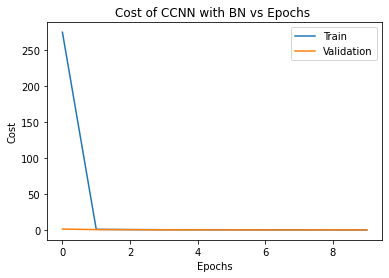

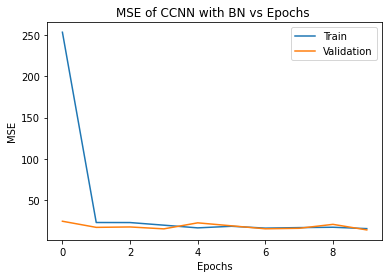

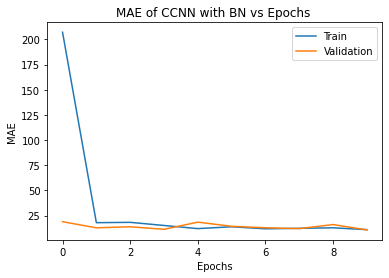

In [ ]:
plot_cost, plot_mse,plot_mae = 1, 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of CCNN with BN vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mse:
    plt.plot(MSE_train)
    plt.plot(MSE_validation)
    plt.title("MSE of CCNN with BN vs Epochs ")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_mae:
    plt.plot(MAE_train)
    plt.plot(MAE_validation)
    plt.title("MAE of CCNN with BN vs Epochs ")
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/CountNet_BN.pth'
torch.save(Net.state_dict(), PATH)

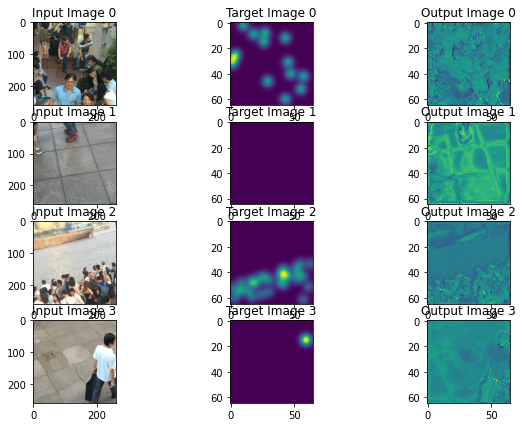

In [ ]:
torch.manual_seed(2045)

# Parameters
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 2}

max_epochs = 10

test_folder = '/content/ShanghaiTech_Dataset/test_data/'
test_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

test_data_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'
test_labels_folder = '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/'

test_set =  ShanghaiTech_Dataset(test_names,test_data_folder,test_labels_folder )
test_generator = torch.utils.data.DataLoader(test_set, **params) 

PATH = '/content/drive/My Drive/CountNet_BN.pth'
net = CountNet_BN()
net.load_state_dict(torch.load(PATH))

dataiter = iter(test_generator)
images, labels = dataiter.next()

#print(images.shape,labels.shape)
outputs = net(images)
#print(outputs.shape)
test_set.test_network(images, outputs, labels)



In [ ]:
# Define Loss function and Optimizer
def Euclidean_regression_loss(output, target):
    return torch.pow(torch.dist(output, target, p=2),2) / ( 2 * output.shape[0])


mse = nn.MSELoss()
mae = nn.L1Loss()

running_testloss, running_test_mse, running_test_mae = 0.0, 0.0 , 0.0
test_cnt = 0

# test
with torch.set_grad_enabled(False):
    for batch_data, batch_labels in tqdm(test_generator):
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(batch_data)
        
        test_loss = Euclidean_regression_loss(batch_outputs.squeeze(), batch_labels)

        running_testloss += test_loss.item()
        running_loss += test_loss.item()
    
        a = torch.sqrt(mse(torch.sum(batch_outputs.squeeze(), dim = [1,2]), torch.sum(batch_labels, dim = [1,2])))
        running_test_mse += a
        running_mse += a

        b = mae(torch.sum(batch_outputs.squeeze(), dim = [1,2]), torch.sum(batch_labels, dim = [1,2]))
        running_test_mae += b
        running_mae += b

        if val_cnt % 10 == 9:    # print every 10 mini-batches
          print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
          print("MSE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mse / 10 ))
          print("MAE of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_mae / 10 ))
          running_loss, running_mse, running_mae = 0.0, 0.0, 0.0

        test_cnt += 1
        

test_losses = running_testloss / test_cnt

MSE_test =  running_test_mse / test_cnt

MAE_test =running_test_mae / test_cnt

100%|██████████| 711/711 [00:34<00:00, 20.71it/s]


In [ ]:
print("Cost of Test data after training : ", test_losses)
print("MSE of Test data after training : ",MSE_test)
print("MAE of Test data after training : ",MAE_test)

Cost of Test data after training :  0.41713727004586326
MSE of Test data after training :  tensor(20.8427, device='cuda:0', dtype=torch.float64)
MAE of Test data after training :  tensor(18.2721, device='cuda:0')


### Load Dataset

In [ ]:
torch.manual_seed(2045)

train_folder = "/content/ShanghaiTech/part_B/train_data/images"
test_folder = "/content/ShanghaiTech/part_B/test_data/images"

train_images_names = [f  for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images_names = [f  for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f)) ]

num_train_samples = len(train_images_names)
random.shuffle(train_images_names)

train_names = train_images_names[0 : int(0.9 * num_train_samples)]
validation_names = train_images_names[int(0.9 * num_train_samples) : ]
test_names = test_images_names


number of heads in original image: 233


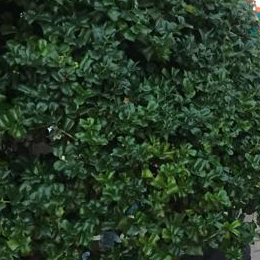

number of heads in cropped image: (1, 2)
number of heads in cropped image: 1.0 [1.]


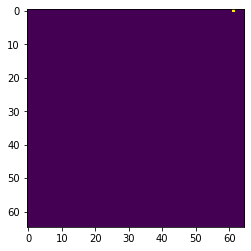

number of heads in cropped image: 0.49819321191294286 [0.01768489]


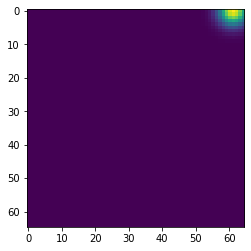

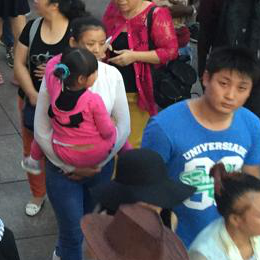

number of heads in cropped image: (6, 2)
number of heads in cropped image: 6.0 [1. 1. 1. 1. 1. 1.]


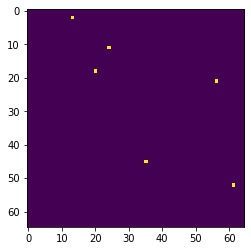

number of heads in cropped image: 5.675970343589022 [0.01768489 0.01816277 0.018163   0.01768512 0.01768489 0.01768489]


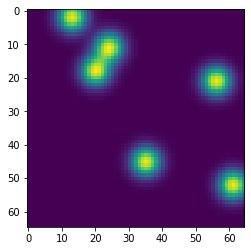

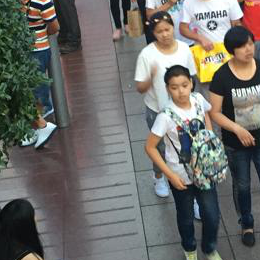

number of heads in cropped image: (4, 2)
number of heads in cropped image: 4.0 [1. 1. 1. 1.]


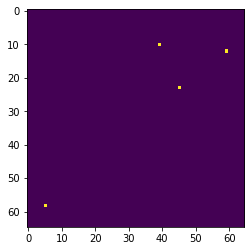

number of heads in cropped image: 3.9200752847901756 [0.01768489 0.01768489 0.01768489 0.01768489]


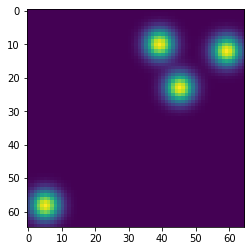

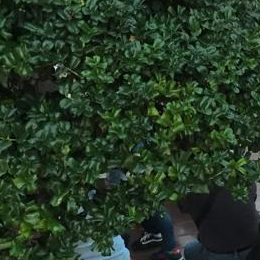

number of heads in cropped image: (0, 2)
number of heads in cropped image: 0.0 []


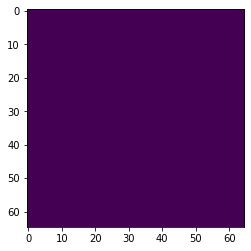

number of heads in cropped image: 0.0 []


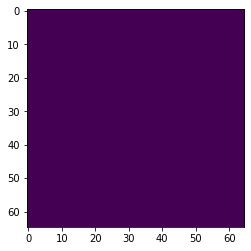

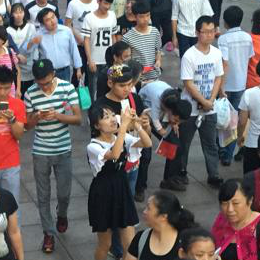

number of heads in cropped image: (17, 2)
number of heads in cropped image: 17.0 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


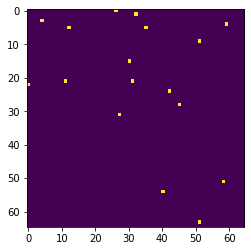

number of heads in cropped image: 15.161411179347525 [0.01768551 0.01768528 0.01768512 0.01781085 0.02209465 0.02210763
 0.01998996 0.01996605 0.02216069 0.01771299 0.01770503 0.01770503
 0.0180894  0.01999792 0.0243587  0.01781085 0.0180894 ]


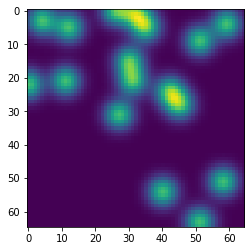

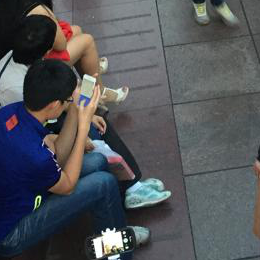

number of heads in cropped image: (2, 2)
number of heads in cropped image: 2.0 [1. 1.]


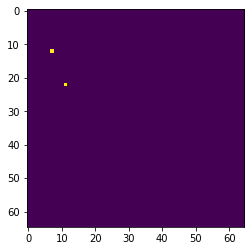

number of heads in cropped image: 1.993960480224035 [0.01771299 0.01771299]


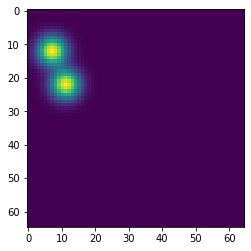

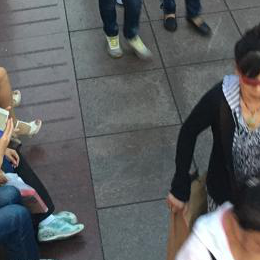

number of heads in cropped image: (1, 2)
number of heads in cropped image: 1.0 [1.]


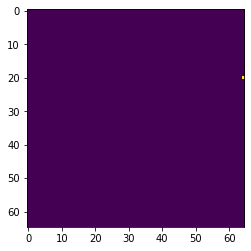

number of heads in cropped image: 0.5664922692753919 [0.01768489]


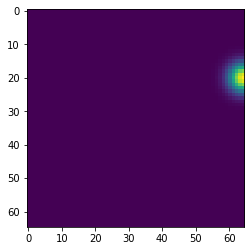

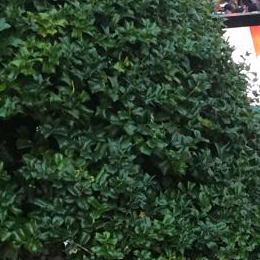

number of heads in cropped image: (5, 2)
number of heads in cropped image: 5.0 [1. 1. 1. 1. 1.]


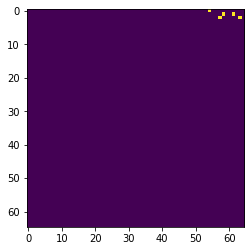

number of heads in cropped image: 3.204261656350251 [0.03440841 0.04978416 0.05137003 0.05528548 0.03780274]


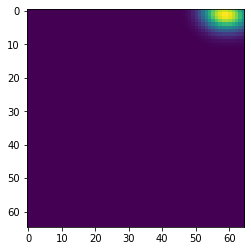

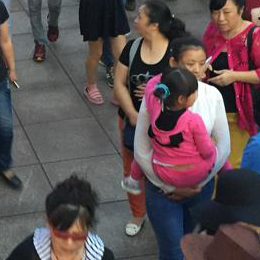

number of heads in cropped image: (6, 2)
number of heads in cropped image: 6.0 [1. 1. 1. 1. 1. 1.]


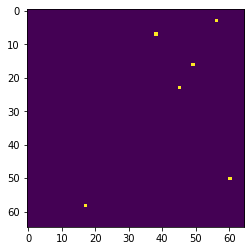

number of heads in cropped image: 5.790879815277465 [0.01768489 0.01768489 0.01816277 0.018163   0.01768489 0.01768512]


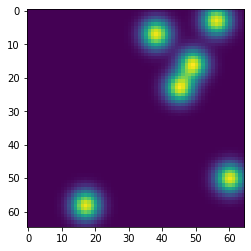

In [ ]:
h_patch = 260
w_patch = 260
patch_number = 9
h_map = 65
w_map = 65
sigma = 3 

transform = transforms.ToTensor()
data_root = "/content/ShanghaiTech/part_B/train_data/images"
labels_root = "/content/ShanghaiTech/part_B/train_data/ground-truth"

# for ID in tqdm(train_names):
ID = "IMG_1.jpg"

data = Image.open(data_root + "/" + ID)
h , w = data.size
patches = []
patch_points = []

ID = ID.replace("IMG","GT_IMG")
ID = ID.replace(".jpg",".mat")
lbl = loadmat(labels_root + "/" + ID)
points = lbl['image_info'][0,0][0,0][0]
num = int(lbl['image_info'][0,0][0,0][1].squeeze())

print("number of heads in original image:", num)

for i in range(patch_number):
    h1 = random.randrange(0, h - h_patch)
    w1 = random.randrange(0, w - w_patch)

    display(data.crop((h1, w1, h1 + h_patch, w1 + w_patch)))
    
    #torch.save(transform(data.crop((h1, w1, h1 + h_patch, w1 + w_patch))), '/content/drive/My Drive/ShanghaiTech_Dataset/train_data/'+ ID +'.pt')

    z  = points[((points[:,0] >= h1) & (points[:,0] <= h1 + h_patch)) & ((points[:,1] >= w1) &  (points[:,1] <= w1 + w_patch)) ]

    z = (z - [h1,w1]) / 4
    z = np.floor(z).astype(int)
    
    print("number of heads in cropped image:",z.shape)
    
    dens_map = np.zeros((h_map,w_map))
    dens_map[z[:,1],z[:,0]] = 1
    
    print("number of heads in cropped image:",np.sum(dens_map),dens_map[z[:,1],z[:,0]])
    plt.imshow(dens_map)
    plt.show()
    dens_map = gaussian_filter(dens_map, sigma, mode = 'constant')

    print("number of heads in cropped image:",np.sum(dens_map),dens_map[z[:,1],z[:,0]])
    plt.imshow(dens_map)
    plt.show()
    #torch.save(torch.from_numpy(dens_map), '/content/drive/My Drive/ShanghaiTech_Dataset/train_labels/' + ID + '.pt')
    #train_labels.append()


In [ ]:
data_root = "/content/ShanghaiTech/part_B/train_data/images"
labels_root = "/content/ShanghaiTech/part_B/train_data/ground-truth"

for ID in tqdm(test_names):
    data = Image.open(data_root + "/" + ID)
    h , w = data.size
    patches = []
    patch_points = []
    
    ID = ID.replace("IMG","GT_IMG")
    ID = ID.replace(".jpg",".mat")
    lbl = loadmat(labels_root + "/" + ID)
    points = lbl['image_info'][0,0][0,0][0]
    num = int(lbl['image_info'][0,0][0,0][1].squeeze())

    for i in range(patch_number):
        h1 = random.randrange(0, h - h_patch)
        w1 = random.randrange(0, w - w_patch)

        #display(data.crop((h1, w1, h1 + h_patch, w1 + w_patch)))
        
        torch.save(transform(data.crop((h1, w1, h1 + h_patch, w1 + w_patch))), '/content/drive/My Drive/ShanghaiTech_Dataset/val_data/'+ ID +'.pt')

        z  = points[((points[:,0] >= h1) & (points[:,0] <= h1 + h_patch)) & ((points[:,1] >= w1) &  (points[:,1] <= w1 + w_patch)) ]
        # print(z.shape,z)
    
        z = (z - [h1,w1]) / 4
        # print(z.shape,z)
        # print("-"*10)
        z = np.floor(z).astype(int)

        dens_map = np.zeros((h_map,w_map))
        dens_map[z[:,1],z[:,0]] = 1#np.array([[1,1]])
        dens_map = gaussian_filter(dens_map, sigma, mode = 'constant')
        # print(dens_map[z[:,1],z[:,0]])
        # plt.imshow(dens_map)
        # plt.show()
        torch.save(torch.from_numpy(dens_map), '/content/drive/My Drive/ShanghaiTech_Dataset/val_labels/' + ID + '.pt')
        #train_labels.append()



100%|██████████| 316/316 [01:38<00:00,  3.22it/s]


In [ ]:
data_root = "/content/ShanghaiTech/part_B/test_data/images"
labels_root = "/content/ShanghaiTech/part_B/test_data/ground-truth"

for ID in tqdm(test_names):
    data = Image.open(data_root + "/" + ID)
    h , w = data.size
    patches = []
    patch_points = []
    
    ID = ID.replace("IMG","GT_IMG")
    ID = ID.replace(".jpg",".mat")
    lbl = loadmat(labels_root + "/" + ID)
    points = lbl['image_info'][0,0][0,0][0]
    num = int(lbl['image_info'][0,0][0,0][1].squeeze())

    for i in range(patch_number):
        h1 = random.randrange(0, h - h_patch)
        w1 = random.randrange(0, w - w_patch)

        #display(data.crop((h1, w1, h1 + h_patch, w1 + w_patch)))
        
        torch.save(transform(data.crop((h1, w1, h1 + h_patch, w1 + w_patch))), '/content/drive/My Drive/ShanghaiTech_Dataset/test_data/'+ ID +'.pt')

        z  = points[((points[:,0] >= h1) & (points[:,0] <= h1 + h_patch)) & ((points[:,1] >= w1) &  (points[:,1] <= w1 + w_patch)) ]
        # print(z.shape,z)
    
        z = (z - [h1,w1]) / 4
        # print(z.shape,z)
        # print("-"*10)
        z = np.floor(z).astype(int)

        dens_map = np.zeros((h_map,w_map))
        dens_map[z[:,1],z[:,0]] = 1#np.array([[1,1]])
        dens_map = gaussian_filter(dens_map, sigma, mode = 'constant')
        # print(dens_map[z[:,1],z[:,0]])
        # plt.imshow(dens_map)
        # plt.show()
        torch.save(torch.from_numpy(dens_map), '/content/drive/My Drive/ShanghaiTech_Dataset/test_labels/' + ID + '.pt')
        #train_labels.append()



100%|██████████| 316/316 [01:37<00:00,  3.24it/s]
